# SCA using hamming weight for classification.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.backend import clear_session
from sklearn.utils import shuffle
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *

from src.aes.sbox import s_box
from src.data.preprocess.hw import hamming_weights
from src.dlla.hw import prepare_traces_dl
from src.pollution.tools import file_suffix
from src.tools.plotter import init_plots
from src.trace_set.database import Database
from src.trace_set.pollution import PollutionType, Pollution
from src.trace_set.set_hw import TraceSetHW

init_plots()

In [2]:
def mlp(classes, number_of_samples):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(number_of_samples,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
    model.summary()
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

### Guessing entropy

Example from [here]() TODO

In [3]:
def aes_labelize_ge_sr(attack_plaintext, key_hypothesis):
    key_byte = np.full(len(attack_plaintext), key_hypothesis)
    state = [int(x) ^ int(k) for x, k in zip(np.asarray(attack_plaintext), key_byte)]
    intermediate_values = s_box[state]

    return hamming_weights(intermediate_values)

# guessing entropy and success rate
def compute_ge(runs, model, correct_key, x_attack, attack_plaintext, key_rank_report_interval, key_rank_attack_traces):
    nt = len(x_attack)
    nt_interval = int(key_rank_attack_traces / key_rank_report_interval)
    key_ranking_sum = np.zeros(nt_interval)

    # ---------------------------------------------------------------------------------------------------------#
    # compute labels for key hypothesis
    # ---------------------------------------------------------------------------------------------------------#
    labels_key_hypothesis = np.zeros((256, nt))
    for key_byte_hypothesis in range(0, 256):
        labels_key_hypothesis[key_byte_hypothesis] = aes_labelize_ge_sr(attack_plaintext, key_byte_hypothesis)

    # ---------------------------------------------------------------------------------------------------------#
    # predict output probabilities for shuffled test or validation set
    # ---------------------------------------------------------------------------------------------------------#
    output_probabilities = model.predict(x_attack)

    probabilities_kg_all_traces = np.zeros((nt, 256))
    for index in range(nt):
        probabilities_kg_all_traces[index] = output_probabilities[index][
            np.asarray([int(leakage[index]) for leakage in labels_key_hypothesis[:]])
        ]

    # ---------------------------------------------------------------------------------------------------------#
    # run key rank "runs" times and average results.
    # ---------------------------------------------------------------------------------------------------------#
    for run in range(runs):

        probabilities_kg_all_traces_shuffled = shuffle(probabilities_kg_all_traces)

        key_probabilities = np.zeros(256)

        kr_count = 0
        for index in range(key_rank_attack_traces):

            key_probabilities += np.log(probabilities_kg_all_traces_shuffled[index] + 1e-36)
            key_probabilities_sorted = np.argsort(key_probabilities)[::-1]

            if (index + 1) % key_rank_report_interval == 0:
                key_ranking_good_key = list(key_probabilities_sorted).index(correct_key) + 1
                key_ranking_sum[kr_count] += key_ranking_good_key
                kr_count += 1

        print("KR run: {} | final GE for correct key ({}): {})".format(run, correct_key, key_ranking_sum[nt_interval - 1] / (run + 1)))

    guessing_entropy = key_ranking_sum / runs

    return guessing_entropy

In [9]:
def store_results(database: Database, method: str, pollution: Pollution, ge: int):
    file_name = f"results/{database.name}.csv"
    with open(file_name, 'a') as f:
        f.write(f"{method};{pollution.type.name};{pollution.parameter};{ge}\n")


def get_ge(db: Database, pollution: Pollution, do_plot=False):
    classes = 9

    # Load the profiling traces
    trace_set = TraceSetHW(db, pollution)
    attack_plaintext, attack_key = trace_set.attack_meta()

    correct_key = attack_key[0]
    # In the ascad dataset, all attack keys should be the same.
    assert np.all(attack_key == correct_key)

    x_profiling, y_profiling, x_attack, y_attack = prepare_traces_dl(*trace_set.profile(), *trace_set.attack())

    num_profiling = 200000
    x_profiling = x_profiling[:num_profiling]
    y_profiling = y_profiling[:num_profiling]

    num_attack_traces, num_sample_points = x_attack.shape
    num_attack_traces = 1000

    model = mlp(classes, num_sample_points)
    model.fit(x=x_profiling, y=y_profiling, batch_size=150, verbose=1, epochs=5, shuffle=True,
              validation_data=(x_attack, y_attack), callbacks=[])

    key_rank_num_traces = num_attack_traces
    key_rank_runs = 100

    ge = compute_ge(key_rank_runs, model, correct_key, x_attack, attack_plaintext, 1, num_attack_traces)

    if do_plot:
        plt.plot(np.arange(1, key_rank_num_traces + 1), ge, label="GE")
        plt.xlabel("Traces")
        plt.ylabel("Guessing Entropy")
        plt.xlim([0, key_rank_num_traces])
        plt.legend()
        plt.show()

    print(f"{pollution.get_name()}: ge=({ge[-1]})")
    store_results(db, "sca_hw", pollution, ge[-1])

    return ge


POLLUTION_PARAMETER = 40
POLLUTION_TYPE = PollutionType.gauss

GE = get_ge(Database.ascad, Pollution(POLLUTION_TYPE, POLLUTION_PARAMETER))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               140100    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7745 - accuracy: 0.2661 - val_loss: 1

<AxesSubplot:>

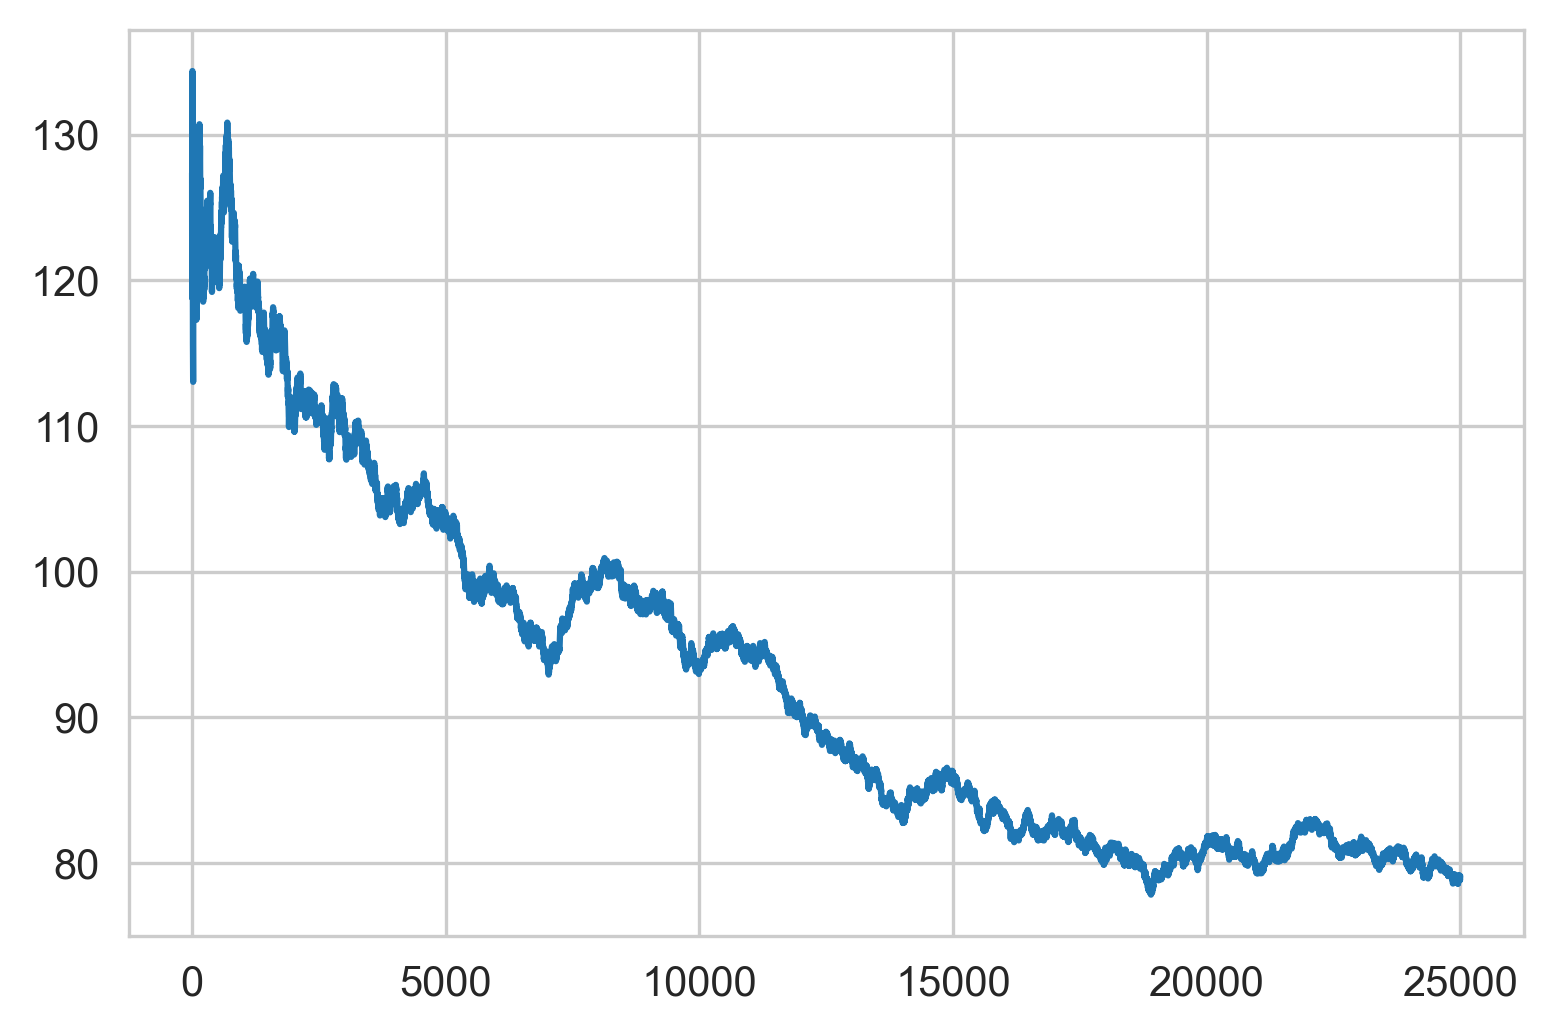

In [5]:
FILE_SUFFIX = file_suffix(POLLUTION_TYPE, POLLUTION_PARAMETER)
pd.DataFrame({"Profiled SCA": GE}).to_csv(f"results/sca-ge{FILE_SUFFIX}.csv")
sns.lineplot(data=GE)

In [ ]:
DB = Database.ascad
POLL_TYPE = PollutionType.gauss
GAUSS_PARAMS = np.arange(0, 42, 1)

while True:
    for PARAM in reversed(GAUSS_PARAMS):
        print(f"Calculating GE for {PARAM}")
        POLL = Pollution(POLL_TYPE, PARAM)
        TRS = TraceSetHW(DB, POLL)

        if os.path.exists(TRS.path):
            get_ge(DB, POLL)
            clear_session()


Calculating GE for 41
Calculating GE for 40
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               140100    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - l

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7745 - accuracy: 0.2661 - val_loss: 1.7672 - val_accuracy: 0.2717
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7531 - accuracy: 0.2714 - val_loss: 1.7739 - val_accuracy: 0.2723
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7291 - accuracy: 0.2807 - val_loss: 1.7903 - val_accuracy: 0.2635
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6832 - accuracy: 0.3037 - val_loss: 1.8369 - val_accuracy: 0.2488
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6198 - accuracy: 0.3318 - val_loss: 1.8899 - val_accuracy: 0.2272
KR run: 0 | final GE for correct key (34): 132.0)
KR run: 1 | final GE for correct key (34): 137.5)
KR run: 2 | final GE for correct key (34): 121.0)
KR run: 3 | final GE for correct key (34): 92.25)
KR run: 4 | final GE for correct key (34): 92.4)
KR run: 5 | final GE for correct key

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7325 - accuracy: 0.2801 - val_loss: 1.7860 - val_accuracy: 0.2581
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6898 - accuracy: 0.2996 - val_loss: 1.8255 - val_accuracy: 0.2499
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6297 - accuracy: 0.3269 - val_loss: 1.8841 - val_accuracy: 0.2390
KR run: 0 | final GE for correct key (34): 58.0)
KR run: 1 | final GE for correct key (34): 151.5)
KR run: 2 | final GE for correct key (34): 158.0)
KR run: 3 | final GE for correct key (34): 127.25)
KR run: 4 | final GE for correct key (34): 129.4)
KR run: 5 | final GE for correct key (34): 121.16666666666667)
KR run: 6 | final GE for correct key (34): 122.28571428571429)
KR run: 7 | final GE for correct key (34): 133.875)
KR run: 8 | final GE for correct key (34): 129.22222222222223)
KR run: 9 | final GE for correct key (34): 121.7)
KR run: 10 | final GE for correct key (3

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6171 - accuracy: 0.3338 - val_loss: 1.8904 - val_accuracy: 0.2345
KR run: 0 | final GE for correct key (34): 111.0)
KR run: 1 | final GE for correct key (34): 106.5)
KR run: 2 | final GE for correct key (34): 105.66666666666667)
KR run: 3 | final GE for correct key (34): 103.0)
KR run: 4 | final GE for correct key (34): 91.0)
KR run: 5 | final GE for correct key (34): 102.66666666666667)
KR run: 6 | final GE for correct key (34): 89.14285714285714)
KR run: 7 | final GE for correct key (34): 94.625)
KR run: 8 | final GE for correct key (34): 84.55555555555556)
KR run: 9 | final GE for correct key (34): 82.7)
KR run: 10 | final GE for correct key (34): 89.63636363636364)
KR run: 11 | final GE for correct key (34): 85.83333333333333)
KR run: 12 | final GE for correct key (34): 86.3076923076923)
KR run: 13 | final GE for correct key (34): 84.5)
KR run: 14 | final GE for correct key (34): 84.0)
KR run: 15 | final GE for corr

KR run: 6 | final GE for correct key (34): 127.71428571428571)
KR run: 7 | final GE for correct key (34): 127.875)
KR run: 8 | final GE for correct key (34): 130.77777777777777)
KR run: 9 | final GE for correct key (34): 129.6)
KR run: 10 | final GE for correct key (34): 119.18181818181819)
KR run: 11 | final GE for correct key (34): 114.08333333333333)
KR run: 12 | final GE for correct key (34): 115.53846153846153)
KR run: 13 | final GE for correct key (34): 109.85714285714286)
KR run: 14 | final GE for correct key (34): 110.4)
KR run: 15 | final GE for correct key (34): 114.0)
KR run: 16 | final GE for correct key (34): 110.82352941176471)
KR run: 17 | final GE for correct key (34): 115.72222222222223)
KR run: 18 | final GE for correct key (34): 120.10526315789474)
KR run: 19 | final GE for correct key (34): 114.45)
KR run: 20 | final GE for correct key (34): 110.19047619047619)
KR run: 21 | final GE for correct key (34): 107.04545454545455)
KR run: 22 | final GE for correct key (34)

KR run: 12 | final GE for correct key (34): 128.3846153846154)
KR run: 13 | final GE for correct key (34): 128.5)
KR run: 14 | final GE for correct key (34): 129.6)
KR run: 15 | final GE for correct key (34): 128.75)
KR run: 16 | final GE for correct key (34): 125.23529411764706)
KR run: 17 | final GE for correct key (34): 120.0)
KR run: 18 | final GE for correct key (34): 125.94736842105263)
KR run: 19 | final GE for correct key (34): 127.2)
KR run: 20 | final GE for correct key (34): 132.66666666666666)
KR run: 21 | final GE for correct key (34): 128.54545454545453)
KR run: 22 | final GE for correct key (34): 132.6086956521739)
KR run: 23 | final GE for correct key (34): 128.75)
KR run: 24 | final GE for correct key (34): 124.8)
KR run: 25 | final GE for correct key (34): 127.03846153846153)
KR run: 26 | final GE for correct key (34): 125.37037037037037)
KR run: 27 | final GE for correct key (34): 128.64285714285714)
KR run: 28 | final GE for correct key (34): 132.3448275862069)
KR r

KR run: 18 | final GE for correct key (34): 130.8421052631579)
KR run: 19 | final GE for correct key (34): 135.4)
KR run: 20 | final GE for correct key (34): 139.23809523809524)
KR run: 21 | final GE for correct key (34): 143.5909090909091)
KR run: 22 | final GE for correct key (34): 140.7826086956522)
KR run: 23 | final GE for correct key (34): 136.625)
KR run: 24 | final GE for correct key (34): 138.84)
KR run: 25 | final GE for correct key (34): 142.23076923076923)
KR run: 26 | final GE for correct key (34): 139.07407407407408)
KR run: 27 | final GE for correct key (34): 137.92857142857142)
KR run: 28 | final GE for correct key (34): 141.0)
KR run: 29 | final GE for correct key (34): 138.76666666666668)
KR run: 30 | final GE for correct key (34): 135.5483870967742)
KR run: 31 | final GE for correct key (34): 136.65625)
KR run: 32 | final GE for correct key (34): 140.15151515151516)
KR run: 33 | final GE for correct key (34): 136.6764705882353)
KR run: 34 | final GE for correct key (

KR run: 24 | final GE for correct key (34): 111.96)
KR run: 25 | final GE for correct key (34): 115.84615384615384)
KR run: 26 | final GE for correct key (34): 113.85185185185185)
KR run: 27 | final GE for correct key (34): 117.78571428571429)
KR run: 28 | final GE for correct key (34): 115.55172413793103)
KR run: 29 | final GE for correct key (34): 118.13333333333334)
KR run: 30 | final GE for correct key (34): 121.2258064516129)
KR run: 31 | final GE for correct key (34): 122.78125)
KR run: 32 | final GE for correct key (34): 123.39393939393939)
KR run: 33 | final GE for correct key (34): 123.91176470588235)
KR run: 34 | final GE for correct key (34): 123.57142857142857)
KR run: 35 | final GE for correct key (34): 120.86111111111111)
KR run: 36 | final GE for correct key (34): 122.02702702702703)
KR run: 37 | final GE for correct key (34): 121.07894736842105)
KR run: 38 | final GE for correct key (34): 119.43589743589743)
KR run: 39 | final GE for correct key (34): 117.9)
KR run: 40 

KR run: 30 | final GE for correct key (34): 114.87096774193549)
KR run: 31 | final GE for correct key (34): 118.15625)
KR run: 32 | final GE for correct key (34): 118.03030303030303)
KR run: 33 | final GE for correct key (34): 117.05882352941177)
KR run: 34 | final GE for correct key (34): 114.37142857142857)
KR run: 35 | final GE for correct key (34): 113.61111111111111)
KR run: 36 | final GE for correct key (34): 112.51351351351352)
KR run: 37 | final GE for correct key (34): 115.78947368421052)
KR run: 38 | final GE for correct key (34): 116.23076923076923)
KR run: 39 | final GE for correct key (34): 115.175)
KR run: 40 | final GE for correct key (34): 116.8780487804878)
KR run: 41 | final GE for correct key (34): 118.11904761904762)
KR run: 42 | final GE for correct key (34): 120.30232558139535)
KR run: 43 | final GE for correct key (34): 118.97727272727273)
KR run: 44 | final GE for correct key (34): 117.66666666666667)
KR run: 45 | final GE for correct key (34): 117.0869565217391

KR run: 36 | final GE for correct key (34): 115.97297297297297)
KR run: 37 | final GE for correct key (34): 114.94736842105263)
KR run: 38 | final GE for correct key (34): 112.05128205128206)
KR run: 39 | final GE for correct key (34): 109.65)
KR run: 40 | final GE for correct key (34): 110.73170731707317)
KR run: 41 | final GE for correct key (34): 111.66666666666667)
KR run: 42 | final GE for correct key (34): 110.34883720930233)
KR run: 43 | final GE for correct key (34): 113.22727272727273)
KR run: 44 | final GE for correct key (34): 112.68888888888888)
KR run: 45 | final GE for correct key (34): 110.67391304347827)
KR run: 46 | final GE for correct key (34): 113.29787234042553)
KR run: 47 | final GE for correct key (34): 114.47916666666667)
KR run: 48 | final GE for correct key (34): 112.75510204081633)
KR run: 49 | final GE for correct key (34): 113.52)
KR run: 50 | final GE for correct key (34): 111.41176470588235)
KR run: 51 | final GE for correct key (34): 109.34615384615384)


KR run: 42 | final GE for correct key (34): 117.90697674418605)
KR run: 43 | final GE for correct key (34): 120.27272727272727)
KR run: 44 | final GE for correct key (34): 122.86666666666666)
KR run: 45 | final GE for correct key (34): 121.47826086956522)
KR run: 46 | final GE for correct key (34): 121.57446808510639)
KR run: 47 | final GE for correct key (34): 119.25)
KR run: 48 | final GE for correct key (34): 120.91836734693878)
KR run: 49 | final GE for correct key (34): 119.28)
KR run: 50 | final GE for correct key (34): 121.37254901960785)
KR run: 51 | final GE for correct key (34): 122.9423076923077)
KR run: 52 | final GE for correct key (34): 123.54716981132076)
KR run: 53 | final GE for correct key (34): 123.07407407407408)
KR run: 54 | final GE for correct key (34): 122.2)
KR run: 55 | final GE for correct key (34): 124.5)
KR run: 56 | final GE for correct key (34): 126.64912280701755)
KR run: 57 | final GE for correct key (34): 127.79310344827586)
KR run: 58 | final GE for c

KR run: 48 | final GE for correct key (34): 118.40816326530613)
KR run: 49 | final GE for correct key (34): 117.2)
KR run: 50 | final GE for correct key (34): 118.6078431372549)
KR run: 51 | final GE for correct key (34): 119.98076923076923)
KR run: 52 | final GE for correct key (34): 121.54716981132076)
KR run: 53 | final GE for correct key (34): 122.37037037037037)
KR run: 54 | final GE for correct key (34): 123.56363636363636)
KR run: 55 | final GE for correct key (34): 124.32142857142857)
KR run: 56 | final GE for correct key (34): 123.89473684210526)
KR run: 57 | final GE for correct key (34): 125.96551724137932)
KR run: 58 | final GE for correct key (34): 124.40677966101696)
KR run: 59 | final GE for correct key (34): 124.7)
KR run: 60 | final GE for correct key (34): 125.50819672131148)
KR run: 61 | final GE for correct key (34): 123.66129032258064)
KR run: 62 | final GE for correct key (34): 122.68253968253968)
KR run: 63 | final GE for correct key (34): 120.8125)
KR run: 64 | 

KR run: 54 | final GE for correct key (34): 111.78181818181818)
KR run: 55 | final GE for correct key (34): 112.08928571428571)
KR run: 56 | final GE for correct key (34): 112.6842105263158)
KR run: 57 | final GE for correct key (34): 113.56896551724138)
KR run: 58 | final GE for correct key (34): 115.54237288135593)
KR run: 59 | final GE for correct key (34): 114.23333333333333)
KR run: 60 | final GE for correct key (34): 115.98360655737704)
KR run: 61 | final GE for correct key (34): 114.91935483870968)
KR run: 62 | final GE for correct key (34): 116.9047619047619)
KR run: 63 | final GE for correct key (34): 118.984375)
KR run: 64 | final GE for correct key (34): 117.16923076923077)
KR run: 65 | final GE for correct key (34): 116.15151515151516)
KR run: 66 | final GE for correct key (34): 115.44776119402985)
KR run: 67 | final GE for correct key (34): 117.1029411764706)
KR run: 68 | final GE for correct key (34): 115.46376811594203)
KR run: 69 | final GE for correct key (34): 114.871

KR run: 60 | final GE for correct key (34): 122.19672131147541)
KR run: 61 | final GE for correct key (34): 120.87096774193549)
KR run: 62 | final GE for correct key (34): 121.46031746031746)
KR run: 63 | final GE for correct key (34): 121.40625)
KR run: 64 | final GE for correct key (34): 122.87692307692308)
KR run: 65 | final GE for correct key (34): 121.1969696969697)
KR run: 66 | final GE for correct key (34): 119.49253731343283)
KR run: 67 | final GE for correct key (34): 120.5)
KR run: 68 | final GE for correct key (34): 118.76811594202898)
KR run: 69 | final GE for correct key (34): 119.57142857142857)
KR run: 70 | final GE for correct key (34): 118.84507042253522)
KR run: 71 | final GE for correct key (34): 118.66666666666667)
KR run: 72 | final GE for correct key (34): 119.06849315068493)
KR run: 73 | final GE for correct key (34): 119.22972972972973)
KR run: 74 | final GE for correct key (34): 118.25333333333333)
KR run: 75 | final GE for correct key (34): 117.51315789473684)

KR run: 66 | final GE for correct key (34): 125.56716417910448)
KR run: 67 | final GE for correct key (34): 124.8529411764706)
KR run: 68 | final GE for correct key (34): 123.5072463768116)
KR run: 69 | final GE for correct key (34): 125.25714285714285)
KR run: 70 | final GE for correct key (34): 124.02816901408451)
KR run: 71 | final GE for correct key (34): 123.68055555555556)
KR run: 72 | final GE for correct key (34): 122.35616438356165)
KR run: 73 | final GE for correct key (34): 122.51351351351352)
KR run: 74 | final GE for correct key (34): 120.92)
KR run: 75 | final GE for correct key (34): 121.32894736842105)
KR run: 76 | final GE for correct key (34): 121.32467532467533)
KR run: 77 | final GE for correct key (34): 119.96153846153847)
KR run: 78 | final GE for correct key (34): 121.60759493670886)
KR run: 79 | final GE for correct key (34): 120.5)
KR run: 80 | final GE for correct key (34): 121.34567901234568)
KR run: 81 | final GE for correct key (34): 120.3048780487805)
KR r

KR run: 72 | final GE for correct key (34): 120.32876712328768)
KR run: 73 | final GE for correct key (34): 118.95945945945945)
KR run: 74 | final GE for correct key (34): 120.50666666666666)
KR run: 75 | final GE for correct key (34): 121.97368421052632)
KR run: 76 | final GE for correct key (34): 120.41558441558442)
KR run: 77 | final GE for correct key (34): 122.01282051282051)
KR run: 78 | final GE for correct key (34): 121.68354430379746)
KR run: 79 | final GE for correct key (34): 121.475)
KR run: 80 | final GE for correct key (34): 122.53086419753086)
KR run: 81 | final GE for correct key (34): 121.48780487804878)
KR run: 82 | final GE for correct key (34): 120.50602409638554)
KR run: 83 | final GE for correct key (34): 120.8452380952381)
KR run: 84 | final GE for correct key (34): 120.37647058823529)
KR run: 85 | final GE for correct key (34): 119.16279069767442)
KR run: 86 | final GE for correct key (34): 118.36781609195403)
KR run: 87 | final GE for correct key (34): 117.9545

KR run: 78 | final GE for correct key (34): 125.0126582278481)
KR run: 79 | final GE for correct key (34): 125.45)
KR run: 80 | final GE for correct key (34): 126.88888888888889)
KR run: 81 | final GE for correct key (34): 128.3048780487805)
KR run: 82 | final GE for correct key (34): 127.08433734939759)
KR run: 83 | final GE for correct key (34): 126.66666666666667)
KR run: 84 | final GE for correct key (34): 125.31764705882352)
KR run: 85 | final GE for correct key (34): 124.32558139534883)
KR run: 86 | final GE for correct key (34): 124.0)
KR run: 87 | final GE for correct key (34): 123.81818181818181)
KR run: 88 | final GE for correct key (34): 124.73033707865169)
KR run: 89 | final GE for correct key (34): 125.42222222222222)
KR run: 90 | final GE for correct key (34): 124.53846153846153)
KR run: 91 | final GE for correct key (34): 124.90217391304348)
KR run: 92 | final GE for correct key (34): 124.88172043010752)
KR run: 93 | final GE for correct key (34): 125.40425531914893)
KR 

KR run: 84 | final GE for correct key (34): 112.09411764705882)
KR run: 85 | final GE for correct key (34): 112.82558139534883)
KR run: 86 | final GE for correct key (34): 112.37931034482759)
KR run: 87 | final GE for correct key (34): 112.2840909090909)
KR run: 88 | final GE for correct key (34): 111.33707865168539)
KR run: 89 | final GE for correct key (34): 112.53333333333333)
KR run: 90 | final GE for correct key (34): 112.06593406593407)
KR run: 91 | final GE for correct key (34): 112.43478260869566)
KR run: 92 | final GE for correct key (34): 111.89247311827957)
KR run: 93 | final GE for correct key (34): 111.48936170212765)
KR run: 94 | final GE for correct key (34): 111.9578947368421)
KR run: 95 | final GE for correct key (34): 111.85416666666667)
KR run: 96 | final GE for correct key (34): 110.79381443298969)
KR run: 97 | final GE for correct key (34): 111.5)
KR run: 98 | final GE for correct key (34): 110.98989898989899)
KR run: 99 | final GE for correct key (34): 110.54)
gau

KR run: 90 | final GE for correct key (34): 115.18681318681318)
KR run: 91 | final GE for correct key (34): 114.51086956521739)
KR run: 92 | final GE for correct key (34): 115.53763440860214)
KR run: 93 | final GE for correct key (34): 114.90425531914893)
KR run: 94 | final GE for correct key (34): 114.54736842105264)
KR run: 95 | final GE for correct key (34): 115.77083333333333)
KR run: 96 | final GE for correct key (34): 114.80412371134021)
KR run: 97 | final GE for correct key (34): 116.18367346938776)
KR run: 98 | final GE for correct key (34): 116.61616161616162)
KR run: 99 | final GE for correct key (34): 117.3)
gauss_22: ge=(117.3)
Calculating GE for 21
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)      

KR run: 96 | final GE for correct key (34): 100.69072164948453)
KR run: 97 | final GE for correct key (34): 100.04081632653062)
KR run: 98 | final GE for correct key (34): 101.34343434343434)
KR run: 99 | final GE for correct key (34): 101.63)
gauss_21: ge=(101.63)
Calculating GE for 20
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (No

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7742 - accuracy: 0.2677 - val_loss: 1.7

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7730 - accuracy: 0.2681 - val_loss: 1.7661 - val_accuracy: 0.2709
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7536 - accuracy: 0.2719 - val_loss: 1.7714 - val_accuracy: 0.2548
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7312 - accuracy: 0.2806 - val_loss: 1.7883 - val_accuracy: 0.2569
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6868 - accuracy: 0.3002 - val_loss: 1.8264 - val_accuracy: 0.2443
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6258 - accuracy: 0.3289 - val_loss: 1.8870 - val_accuracy: 0.2304
KR run: 0 | final GE for correct key (34): 229.0)
KR run: 1 | final GE for correct key (34): 177.0)
KR run: 2 | final GE for correct key (34): 118.33333333333333)
KR run: 3 | final GE for correct key (34): 141.75)
KR run: 4 | final GE for correct key (34): 140.2)
KR run: 5 | final GE 

Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7285 - accuracy: 0.2839 - val_loss: 1.7971 - val_accuracy: 0.2597
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6818 - accuracy: 0.3059 - val_loss: 1.8430 - val_accuracy: 0.2530
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6186 - accuracy: 0.3333 - val_loss: 1.9216 - val_accuracy: 0.2401
KR run: 0 | final GE for correct key (34): 205.0)
KR run: 1 | final GE for correct key (34): 122.0)
KR run: 2 | final GE for correct key (34): 101.0)
KR run: 3 | final GE for correct key (34): 86.5)
KR run: 4 | final GE for correct key (34): 88.8)
KR run: 5 | final GE for correct key (34): 113.0)
KR run: 6 | final GE for correct key (34): 106.85714285714286)
KR run: 7 | final GE for correct key (34): 117.75)
KR run: 8 | final GE for correct key (34): 125.66666666666667)
KR run: 9 | final GE for correct key (34): 120.8)
KR run: 10 | final GE for correct key (34): 12

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6255 - accuracy: 0.3293 - val_loss: 1.9165 - val_accuracy: 0.2359
KR run: 0 | final GE for correct key (34): 30.0)
KR run: 1 | final GE for correct key (34): 44.5)
KR run: 2 | final GE for correct key (34): 80.66666666666667)
KR run: 3 | final GE for correct key (34): 63.0)
KR run: 4 | final GE for correct key (34): 96.2)
KR run: 5 | final GE for correct key (34): 93.83333333333333)
KR run: 6 | final GE for correct key (34): 107.28571428571429)
KR run: 7 | final GE for correct key (34): 116.875)
KR run: 8 | final GE for correct key (34): 111.77777777777777)
KR run: 9 | final GE for correct key (34): 103.2)
KR run: 10 | final GE for correct key (34): 93.9090909090909)
KR run: 11 | final GE for correct key (34): 98.66666666666667)
KR run: 12 | final GE for correct key (34): 104.46153846153847)
KR run: 13 | final GE for correct key (34): 98.57142857142857)
KR run: 14 | final GE for correct key (34): 95.06666666666666)
KR r

KR run: 3 | final GE for correct key (34): 112.25)
KR run: 4 | final GE for correct key (34): 130.4)
KR run: 5 | final GE for correct key (34): 139.83333333333334)
KR run: 6 | final GE for correct key (34): 126.85714285714286)
KR run: 7 | final GE for correct key (34): 140.125)
KR run: 8 | final GE for correct key (34): 128.66666666666666)
KR run: 9 | final GE for correct key (34): 135.3)
KR run: 10 | final GE for correct key (34): 139.8181818181818)
KR run: 11 | final GE for correct key (34): 130.5)
KR run: 12 | final GE for correct key (34): 120.92307692307692)
KR run: 13 | final GE for correct key (34): 120.64285714285714)
KR run: 14 | final GE for correct key (34): 113.4)
KR run: 15 | final GE for correct key (34): 107.375)
KR run: 16 | final GE for correct key (34): 101.11764705882354)
KR run: 17 | final GE for correct key (34): 103.38888888888889)
KR run: 18 | final GE for correct key (34): 102.42105263157895)
KR run: 19 | final GE for correct key (34): 107.7)
KR run: 20 | final 

KR run: 9 | final GE for correct key (34): 75.8)
KR run: 10 | final GE for correct key (34): 77.63636363636364)
KR run: 11 | final GE for correct key (34): 72.91666666666667)
KR run: 12 | final GE for correct key (34): 76.23076923076923)
KR run: 13 | final GE for correct key (34): 81.21428571428571)
KR run: 14 | final GE for correct key (34): 89.26666666666667)
KR run: 15 | final GE for correct key (34): 86.75)
KR run: 16 | final GE for correct key (34): 95.11764705882354)
KR run: 17 | final GE for correct key (34): 97.83333333333333)
KR run: 18 | final GE for correct key (34): 99.47368421052632)
KR run: 19 | final GE for correct key (34): 97.8)
KR run: 20 | final GE for correct key (34): 98.42857142857143)
KR run: 21 | final GE for correct key (34): 98.45454545454545)
KR run: 22 | final GE for correct key (34): 104.73913043478261)
KR run: 23 | final GE for correct key (34): 101.29166666666667)
KR run: 24 | final GE for correct key (34): 100.2)
KR run: 25 | final GE for correct key (34

KR run: 15 | final GE for correct key (34): 98.0625)
KR run: 16 | final GE for correct key (34): 102.76470588235294)
KR run: 17 | final GE for correct key (34): 105.0)
KR run: 18 | final GE for correct key (34): 105.73684210526316)
KR run: 19 | final GE for correct key (34): 107.7)
KR run: 20 | final GE for correct key (34): 106.14285714285714)
KR run: 21 | final GE for correct key (34): 108.22727272727273)
KR run: 22 | final GE for correct key (34): 114.0)
KR run: 23 | final GE for correct key (34): 113.91666666666667)
KR run: 24 | final GE for correct key (34): 113.68)
KR run: 25 | final GE for correct key (34): 111.61538461538461)
KR run: 26 | final GE for correct key (34): 113.25925925925925)
KR run: 27 | final GE for correct key (34): 116.78571428571429)
KR run: 28 | final GE for correct key (34): 117.3103448275862)
KR run: 29 | final GE for correct key (34): 117.96666666666667)
KR run: 30 | final GE for correct key (34): 114.48387096774194)
KR run: 31 | final GE for correct key (

KR run: 21 | final GE for correct key (34): 114.0)
KR run: 22 | final GE for correct key (34): 117.56521739130434)
KR run: 23 | final GE for correct key (34): 117.33333333333333)
KR run: 24 | final GE for correct key (34): 116.92)
KR run: 25 | final GE for correct key (34): 120.15384615384616)
KR run: 26 | final GE for correct key (34): 116.25925925925925)
KR run: 27 | final GE for correct key (34): 115.96428571428571)
KR run: 28 | final GE for correct key (34): 113.51724137931035)
KR run: 29 | final GE for correct key (34): 113.66666666666667)
KR run: 30 | final GE for correct key (34): 114.90322580645162)
KR run: 31 | final GE for correct key (34): 114.0625)
KR run: 32 | final GE for correct key (34): 112.72727272727273)
KR run: 33 | final GE for correct key (34): 109.55882352941177)
KR run: 34 | final GE for correct key (34): 112.28571428571429)
KR run: 35 | final GE for correct key (34): 113.80555555555556)
KR run: 36 | final GE for correct key (34): 112.72972972972973)
KR run: 37 

KR run: 27 | final GE for correct key (34): 118.89285714285714)
KR run: 28 | final GE for correct key (34): 118.10344827586206)
KR run: 29 | final GE for correct key (34): 119.0)
KR run: 30 | final GE for correct key (34): 116.7741935483871)
KR run: 31 | final GE for correct key (34): 117.34375)
KR run: 32 | final GE for correct key (34): 114.96969696969697)
KR run: 33 | final GE for correct key (34): 112.44117647058823)
KR run: 34 | final GE for correct key (34): 115.77142857142857)
KR run: 35 | final GE for correct key (34): 113.13888888888889)
KR run: 36 | final GE for correct key (34): 115.13513513513513)
KR run: 37 | final GE for correct key (34): 113.86842105263158)
KR run: 38 | final GE for correct key (34): 114.92307692307692)
KR run: 39 | final GE for correct key (34): 115.3)
KR run: 40 | final GE for correct key (34): 113.58536585365853)
KR run: 41 | final GE for correct key (34): 114.23809523809524)
KR run: 42 | final GE for correct key (34): 115.02325581395348)
KR run: 43 |

KR run: 33 | final GE for correct key (34): 120.79411764705883)
KR run: 34 | final GE for correct key (34): 124.6)
KR run: 35 | final GE for correct key (34): 123.11111111111111)
KR run: 36 | final GE for correct key (34): 122.89189189189189)
KR run: 37 | final GE for correct key (34): 123.6842105263158)
KR run: 38 | final GE for correct key (34): 120.92307692307692)
KR run: 39 | final GE for correct key (34): 118.9)
KR run: 40 | final GE for correct key (34): 119.5609756097561)
KR run: 41 | final GE for correct key (34): 119.80952380952381)
KR run: 42 | final GE for correct key (34): 119.65116279069767)
KR run: 43 | final GE for correct key (34): 120.20454545454545)
KR run: 44 | final GE for correct key (34): 118.46666666666667)
KR run: 45 | final GE for correct key (34): 116.32608695652173)
KR run: 46 | final GE for correct key (34): 116.76595744680851)
KR run: 47 | final GE for correct key (34): 115.60416666666667)
KR run: 48 | final GE for correct key (34): 114.36734693877551)
KR r

KR run: 39 | final GE for correct key (34): 109.65)
KR run: 40 | final GE for correct key (34): 110.1219512195122)
KR run: 41 | final GE for correct key (34): 111.88095238095238)
KR run: 42 | final GE for correct key (34): 110.5813953488372)
KR run: 43 | final GE for correct key (34): 109.1590909090909)
KR run: 44 | final GE for correct key (34): 111.35555555555555)
KR run: 45 | final GE for correct key (34): 114.28260869565217)
KR run: 46 | final GE for correct key (34): 114.80851063829788)
KR run: 47 | final GE for correct key (34): 116.125)
KR run: 48 | final GE for correct key (34): 117.9795918367347)
KR run: 49 | final GE for correct key (34): 115.78)
KR run: 50 | final GE for correct key (34): 113.52941176470588)
KR run: 51 | final GE for correct key (34): 112.1923076923077)
KR run: 52 | final GE for correct key (34): 111.90566037735849)
KR run: 53 | final GE for correct key (34): 114.20370370370371)
KR run: 54 | final GE for correct key (34): 113.76363636363637)
KR run: 55 | fin

KR run: 45 | final GE for correct key (34): 141.69565217391303)
KR run: 46 | final GE for correct key (34): 140.10638297872342)
KR run: 47 | final GE for correct key (34): 138.47916666666666)
KR run: 48 | final GE for correct key (34): 139.6122448979592)
KR run: 49 | final GE for correct key (34): 137.5)
KR run: 50 | final GE for correct key (34): 138.92156862745097)
KR run: 51 | final GE for correct key (34): 140.21153846153845)
KR run: 52 | final GE for correct key (34): 138.0754716981132)
KR run: 53 | final GE for correct key (34): 139.75925925925927)
KR run: 54 | final GE for correct key (34): 138.63636363636363)
KR run: 55 | final GE for correct key (34): 140.57142857142858)
KR run: 56 | final GE for correct key (34): 141.73684210526315)
KR run: 57 | final GE for correct key (34): 143.63793103448276)
KR run: 58 | final GE for correct key (34): 142.91525423728814)
KR run: 59 | final GE for correct key (34): 142.35)
KR run: 60 | final GE for correct key (34): 140.5737704918033)
KR r

KR run: 51 | final GE for correct key (34): 123.84615384615384)
KR run: 52 | final GE for correct key (34): 125.9245283018868)
KR run: 53 | final GE for correct key (34): 123.74074074074075)
KR run: 54 | final GE for correct key (34): 122.65454545454546)
KR run: 55 | final GE for correct key (34): 123.25)
KR run: 56 | final GE for correct key (34): 124.6140350877193)
KR run: 57 | final GE for correct key (34): 123.41379310344827)
KR run: 58 | final GE for correct key (34): 124.37288135593221)
KR run: 59 | final GE for correct key (34): 122.85)
KR run: 60 | final GE for correct key (34): 121.57377049180327)
KR run: 61 | final GE for correct key (34): 121.40322580645162)
KR run: 62 | final GE for correct key (34): 119.98412698412699)
KR run: 63 | final GE for correct key (34): 119.875)
KR run: 64 | final GE for correct key (34): 118.70769230769231)
KR run: 65 | final GE for correct key (34): 117.75757575757575)
KR run: 66 | final GE for correct key (34): 117.08955223880596)
KR run: 67 | 

KR run: 57 | final GE for correct key (34): 67.3103448275862)
KR run: 58 | final GE for correct key (34): 68.77966101694915)
KR run: 59 | final GE for correct key (34): 68.91666666666667)
KR run: 60 | final GE for correct key (34): 68.34426229508196)
KR run: 61 | final GE for correct key (34): 71.09677419354838)
KR run: 62 | final GE for correct key (34): 72.52380952380952)
KR run: 63 | final GE for correct key (34): 73.390625)
KR run: 64 | final GE for correct key (34): 72.38461538461539)
KR run: 65 | final GE for correct key (34): 72.37878787878788)
KR run: 66 | final GE for correct key (34): 72.59701492537313)
KR run: 67 | final GE for correct key (34): 71.54411764705883)
KR run: 68 | final GE for correct key (34): 73.91304347826087)
KR run: 69 | final GE for correct key (34): 75.2)
KR run: 70 | final GE for correct key (34): 77.54929577464789)
KR run: 71 | final GE for correct key (34): 78.20833333333333)
KR run: 72 | final GE for correct key (34): 77.26027397260275)
KR run: 73 | f

KR run: 66 | final GE for correct key (34): 59.3134328358209)
KR run: 67 | final GE for correct key (34): 59.26470588235294)
KR run: 68 | final GE for correct key (34): 60.11594202898551)
KR run: 69 | final GE for correct key (34): 59.542857142857144)
KR run: 70 | final GE for correct key (34): 58.943661971830984)
KR run: 71 | final GE for correct key (34): 59.84722222222222)
KR run: 72 | final GE for correct key (34): 60.02739726027397)
KR run: 73 | final GE for correct key (34): 59.41891891891892)
KR run: 74 | final GE for correct key (34): 58.64)
KR run: 75 | final GE for correct key (34): 57.88157894736842)
KR run: 76 | final GE for correct key (34): 58.72727272727273)
KR run: 77 | final GE for correct key (34): 58.08974358974359)
KR run: 78 | final GE for correct key (34): 57.46835443037975)
KR run: 79 | final GE for correct key (34): 57.475)
KR run: 80 | final GE for correct key (34): 57.0)
KR run: 81 | final GE for correct key (34): 57.0609756097561)
KR run: 82 | final GE for co

KR run: 72 | final GE for correct key (34): 45.013698630136986)
KR run: 73 | final GE for correct key (34): 44.54054054054054)
KR run: 74 | final GE for correct key (34): 44.026666666666664)
KR run: 75 | final GE for correct key (34): 44.421052631578945)
KR run: 76 | final GE for correct key (34): 44.311688311688314)
KR run: 77 | final GE for correct key (34): 43.756410256410255)
KR run: 78 | final GE for correct key (34): 44.77215189873418)
KR run: 79 | final GE for correct key (34): 44.2875)
KR run: 80 | final GE for correct key (34): 43.97530864197531)
KR run: 81 | final GE for correct key (34): 43.90243902439025)
KR run: 82 | final GE for correct key (34): 45.27710843373494)
KR run: 83 | final GE for correct key (34): 45.69047619047619)
KR run: 84 | final GE for correct key (34): 45.2)
KR run: 85 | final GE for correct key (34): 44.7093023255814)
KR run: 86 | final GE for correct key (34): 44.94252873563219)
KR run: 87 | final GE for correct key (34): 44.55681818181818)
KR run: 88 

KR run: 78 | final GE for correct key (34): 16.70886075949367)
KR run: 79 | final GE for correct key (34): 17.7375)
KR run: 80 | final GE for correct key (34): 17.530864197530864)
KR run: 81 | final GE for correct key (34): 17.548780487804876)
KR run: 82 | final GE for correct key (34): 18.0)
KR run: 83 | final GE for correct key (34): 17.845238095238095)
KR run: 84 | final GE for correct key (34): 17.647058823529413)
KR run: 85 | final GE for correct key (34): 17.476744186046513)
KR run: 86 | final GE for correct key (34): 17.402298850574713)
KR run: 87 | final GE for correct key (34): 17.238636363636363)
KR run: 88 | final GE for correct key (34): 17.0561797752809)
KR run: 89 | final GE for correct key (34): 16.9)
KR run: 90 | final GE for correct key (34): 16.802197802197803)
KR run: 91 | final GE for correct key (34): 16.66304347826087)
KR run: 92 | final GE for correct key (34): 16.49462365591398)
KR run: 93 | final GE for correct key (34): 16.329787234042552)
KR run: 94 | final G

KR run: 87 | final GE for correct key (34): 8.772727272727273)
KR run: 88 | final GE for correct key (34): 8.707865168539326)
KR run: 89 | final GE for correct key (34): 8.622222222222222)
KR run: 90 | final GE for correct key (34): 8.538461538461538)
KR run: 91 | final GE for correct key (34): 8.456521739130435)
KR run: 92 | final GE for correct key (34): 8.408602150537634)
KR run: 93 | final GE for correct key (34): 8.340425531914894)
KR run: 94 | final GE for correct key (34): 8.715789473684211)
KR run: 95 | final GE for correct key (34): 8.635416666666666)
KR run: 96 | final GE for correct key (34): 8.711340206185566)
KR run: 97 | final GE for correct key (34): 8.642857142857142)
KR run: 98 | final GE for correct key (34): 8.717171717171718)
KR run: 99 | final GE for correct key (34): 8.64)
gauss_2: ge=(8.64)
Calculating GE for 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
de

KR run: 93 | final GE for correct key (34): 3.351063829787234)
KR run: 94 | final GE for correct key (34): 3.336842105263158)
KR run: 95 | final GE for correct key (34): 3.3125)
KR run: 96 | final GE for correct key (34): 3.288659793814433)
KR run: 97 | final GE for correct key (34): 3.2653061224489797)
KR run: 98 | final GE for correct key (34): 3.282828282828283)
KR run: 99 | final GE for correct key (34): 3.26)
gauss_1: ge=(3.26)
Calculating GE for 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
____________________________________________________________

KR run: 99 | final GE for correct key (34): 1.18)
gauss_0: ge=(1.18)
Calculating GE for 41
Calculating GE for 40
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epo

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7739 - accuracy: 0.2674 - val_loss: 1.7650 - val_accuracy: 0.2717
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7530 - accuracy: 0.2727 - val_loss: 1.7700 - val_accuracy: 0.2724
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7298 - accuracy: 0.2819 - val_loss: 1.7862 - val_accuracy: 0.2508
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6867 - accuracy: 0.3012 - val_loss: 1.8209 - val_accuracy: 0.2559
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6255 - accuracy: 0.3297 - val_loss: 1.8927 - val_accuracy: 0.2372
KR run: 0 | final GE for correct key (34): 101.0)
KR run: 1 | final GE for correct key (34): 68.5)
KR run: 2 | final GE for correct key (34): 116.66666666666667)
KR run: 3 | final GE for correct key (34): 97.75)
KR run: 4 | final GE for correct key (34): 119.2)
KR run: 5 | final GE fo

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7265 - accuracy: 0.2832 - val_loss: 1.7914 - val_accuracy: 0.2604
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6799 - accuracy: 0.3039 - val_loss: 1.8313 - val_accuracy: 0.2527
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6182 - accuracy: 0.3321 - val_loss: 1.9048 - val_accuracy: 0.2367
KR run: 0 | final GE for correct key (34): 131.0)
KR run: 1 | final GE for correct key (34): 180.5)
KR run: 2 | final GE for correct key (34): 168.33333333333334)
KR run: 3 | final GE for correct key (34): 131.5)
KR run: 4 | final GE for correct key (34): 121.8)
KR run: 5 | final GE for correct key (34): 142.66666666666666)
KR run: 6 | final GE for correct key (34): 126.42857142857143)
KR run: 7 | final GE for correct key (34): 116.875)
KR run: 8 | final GE for correct key (34): 129.55555555555554)
KR run: 9 | final GE for correct key (34): 137.9)
KR run: 10 | final GE for c

Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6097 - accuracy: 0.3396 - val_loss: 1.8992 - val_accuracy: 0.2241
KR run: 0 | final GE for correct key (34): 69.0)
KR run: 1 | final GE for correct key (34): 152.5)
KR run: 2 | final GE for correct key (34): 155.0)
KR run: 3 | final GE for correct key (34): 123.0)
KR run: 4 | final GE for correct key (34): 100.6)
KR run: 5 | final GE for correct key (34): 93.66666666666667)
KR run: 6 | final GE for correct key (34): 80.42857142857143)
KR run: 7 | final GE for correct key (34): 90.0)
KR run: 8 | final GE for correct key (34): 104.22222222222223)
KR run: 9 | final GE for correct key (34): 111.0)
KR run: 10 | final GE for correct key (34): 107.9090909090909)
KR run: 11 | final GE for correct key (34): 110.08333333333333)
KR run: 12 | final GE for correct key (34): 104.6923076923077)
KR run: 13 | final GE for correct key (34): 104.57142857142857)
KR run: 14 | final GE for correct key (34): 112.66666666666667)
KR r

KR run: 6 | final GE for correct key (34): 155.14285714285714)
KR run: 7 | final GE for correct key (34): 136.0)
KR run: 8 | final GE for correct key (34): 142.55555555555554)
KR run: 9 | final GE for correct key (34): 139.8)
KR run: 10 | final GE for correct key (34): 127.27272727272727)
KR run: 11 | final GE for correct key (34): 120.75)
KR run: 12 | final GE for correct key (34): 127.23076923076923)
KR run: 13 | final GE for correct key (34): 119.57142857142857)
KR run: 14 | final GE for correct key (34): 127.06666666666666)
KR run: 15 | final GE for correct key (34): 128.0625)
KR run: 16 | final GE for correct key (34): 131.58823529411765)
KR run: 17 | final GE for correct key (34): 132.22222222222223)
KR run: 18 | final GE for correct key (34): 130.0)
KR run: 19 | final GE for correct key (34): 135.5)
KR run: 20 | final GE for correct key (34): 129.9047619047619)
KR run: 21 | final GE for correct key (34): 130.95454545454547)
KR run: 22 | final GE for correct key (34): 131.2608695

KR run: 12 | final GE for correct key (34): 140.69230769230768)
KR run: 13 | final GE for correct key (34): 131.64285714285714)
KR run: 14 | final GE for correct key (34): 126.13333333333334)
KR run: 15 | final GE for correct key (34): 126.3125)
KR run: 16 | final GE for correct key (34): 125.47058823529412)
KR run: 17 | final GE for correct key (34): 130.55555555555554)
KR run: 18 | final GE for correct key (34): 128.42105263157896)
KR run: 19 | final GE for correct key (34): 122.85)
KR run: 20 | final GE for correct key (34): 124.38095238095238)
KR run: 21 | final GE for correct key (34): 121.5)
KR run: 22 | final GE for correct key (34): 116.30434782608695)
KR run: 23 | final GE for correct key (34): 111.66666666666667)
KR run: 24 | final GE for correct key (34): 117.24)
KR run: 25 | final GE for correct key (34): 117.23076923076923)
KR run: 26 | final GE for correct key (34): 119.03703703703704)
KR run: 27 | final GE for correct key (34): 120.71428571428571)
KR run: 28 | final GE f

KR run: 17 | final GE for correct key (34): 99.27777777777777)
KR run: 18 | final GE for correct key (34): 106.63157894736842)
KR run: 19 | final GE for correct key (34): 103.1)
KR run: 20 | final GE for correct key (34): 107.28571428571429)
KR run: 21 | final GE for correct key (34): 102.81818181818181)
KR run: 22 | final GE for correct key (34): 107.91304347826087)
KR run: 23 | final GE for correct key (34): 110.5)
KR run: 24 | final GE for correct key (34): 109.92)
KR run: 25 | final GE for correct key (34): 107.1923076923077)
KR run: 26 | final GE for correct key (34): 112.0)
KR run: 27 | final GE for correct key (34): 108.82142857142857)
KR run: 28 | final GE for correct key (34): 113.06896551724138)
KR run: 29 | final GE for correct key (34): 117.2)
KR run: 30 | final GE for correct key (34): 118.09677419354838)
KR run: 31 | final GE for correct key (34): 122.125)
KR run: 32 | final GE for correct key (34): 124.48484848484848)
KR run: 33 | final GE for correct key (34): 120.88235

KR run: 24 | final GE for correct key (34): 129.96)
KR run: 25 | final GE for correct key (34): 128.19230769230768)
KR run: 26 | final GE for correct key (34): 126.22222222222223)
KR run: 27 | final GE for correct key (34): 125.64285714285714)
KR run: 28 | final GE for correct key (34): 122.3103448275862)
KR run: 29 | final GE for correct key (34): 118.93333333333334)
KR run: 30 | final GE for correct key (34): 119.61290322580645)
KR run: 31 | final GE for correct key (34): 120.4375)
KR run: 32 | final GE for correct key (34): 120.48484848484848)
KR run: 33 | final GE for correct key (34): 123.58823529411765)
KR run: 34 | final GE for correct key (34): 124.31428571428572)
KR run: 35 | final GE for correct key (34): 122.22222222222223)
KR run: 36 | final GE for correct key (34): 125.45945945945945)
KR run: 37 | final GE for correct key (34): 127.23684210526316)
KR run: 38 | final GE for correct key (34): 129.15384615384616)
KR run: 39 | final GE for correct key (34): 129.5)
KR run: 40 |

KR run: 33 | final GE for correct key (34): 95.0)
KR run: 34 | final GE for correct key (34): 92.57142857142857)
KR run: 35 | final GE for correct key (34): 92.02777777777777)
KR run: 36 | final GE for correct key (34): 93.02702702702703)
KR run: 37 | final GE for correct key (34): 95.8157894736842)
KR run: 38 | final GE for correct key (34): 99.41025641025641)
KR run: 39 | final GE for correct key (34): 97.975)
KR run: 40 | final GE for correct key (34): 99.90243902439025)
KR run: 41 | final GE for correct key (34): 102.52380952380952)
KR run: 42 | final GE for correct key (34): 103.18604651162791)
KR run: 43 | final GE for correct key (34): 105.97727272727273)
KR run: 44 | final GE for correct key (34): 106.64444444444445)
KR run: 45 | final GE for correct key (34): 107.04347826086956)
KR run: 46 | final GE for correct key (34): 107.76595744680851)
KR run: 47 | final GE for correct key (34): 108.89583333333333)
KR run: 48 | final GE for correct key (34): 106.93877551020408)
KR run: 4

KR run: 39 | final GE for correct key (34): 130.2)
KR run: 40 | final GE for correct key (34): 127.65853658536585)
KR run: 41 | final GE for correct key (34): 128.35714285714286)
KR run: 42 | final GE for correct key (34): 128.1627906976744)
KR run: 43 | final GE for correct key (34): 128.4090909090909)
KR run: 44 | final GE for correct key (34): 126.88888888888889)
KR run: 45 | final GE for correct key (34): 127.04347826086956)
KR run: 46 | final GE for correct key (34): 124.57446808510639)
KR run: 47 | final GE for correct key (34): 122.0625)
KR run: 48 | final GE for correct key (34): 121.77551020408163)
KR run: 49 | final GE for correct key (34): 120.84)
KR run: 50 | final GE for correct key (34): 122.25490196078431)
KR run: 51 | final GE for correct key (34): 120.75)
KR run: 52 | final GE for correct key (34): 118.60377358490567)
KR run: 53 | final GE for correct key (34): 117.57407407407408)
KR run: 54 | final GE for correct key (34): 119.65454545454546)
KR run: 55 | final GE for

KR run: 45 | final GE for correct key (34): 112.67391304347827)
KR run: 46 | final GE for correct key (34): 111.8936170212766)
KR run: 47 | final GE for correct key (34): 113.4375)
KR run: 48 | final GE for correct key (34): 113.85714285714286)
KR run: 49 | final GE for correct key (34): 112.34)
KR run: 50 | final GE for correct key (34): 114.58823529411765)
KR run: 51 | final GE for correct key (34): 113.38461538461539)
KR run: 52 | final GE for correct key (34): 115.58490566037736)
KR run: 53 | final GE for correct key (34): 116.5)
KR run: 54 | final GE for correct key (34): 118.87272727272727)
KR run: 55 | final GE for correct key (34): 116.92857142857143)
KR run: 56 | final GE for correct key (34): 118.15789473684211)
KR run: 57 | final GE for correct key (34): 117.17241379310344)
KR run: 58 | final GE for correct key (34): 118.8135593220339)
KR run: 59 | final GE for correct key (34): 118.41666666666667)
KR run: 60 | final GE for correct key (34): 119.57377049180327)
KR run: 61 | 

KR run: 51 | final GE for correct key (34): 112.5)
KR run: 52 | final GE for correct key (34): 113.62264150943396)
KR run: 53 | final GE for correct key (34): 112.5)
KR run: 54 | final GE for correct key (34): 112.0)
KR run: 55 | final GE for correct key (34): 112.85714285714286)
KR run: 56 | final GE for correct key (34): 114.52631578947368)
KR run: 57 | final GE for correct key (34): 112.89655172413794)
KR run: 58 | final GE for correct key (34): 113.49152542372882)
KR run: 59 | final GE for correct key (34): 111.88333333333334)
KR run: 60 | final GE for correct key (34): 110.52459016393442)
KR run: 61 | final GE for correct key (34): 111.35483870967742)
KR run: 62 | final GE for correct key (34): 112.71428571428571)
KR run: 63 | final GE for correct key (34): 114.765625)
KR run: 64 | final GE for correct key (34): 116.07692307692308)
KR run: 65 | final GE for correct key (34): 118.01515151515152)
KR run: 66 | final GE for correct key (34): 117.56716417910448)
KR run: 67 | final GE f

KR run: 57 | final GE for correct key (34): 132.81034482758622)
KR run: 58 | final GE for correct key (34): 133.38983050847457)
KR run: 59 | final GE for correct key (34): 132.51666666666668)
KR run: 60 | final GE for correct key (34): 132.39344262295083)
KR run: 61 | final GE for correct key (34): 130.59677419354838)
KR run: 62 | final GE for correct key (34): 128.96825396825398)
KR run: 63 | final GE for correct key (34): 127.234375)
KR run: 64 | final GE for correct key (34): 128.43076923076924)
KR run: 65 | final GE for correct key (34): 128.53030303030303)
KR run: 66 | final GE for correct key (34): 127.23880597014926)
KR run: 67 | final GE for correct key (34): 125.91176470588235)
KR run: 68 | final GE for correct key (34): 126.42028985507247)
KR run: 69 | final GE for correct key (34): 125.74285714285715)
KR run: 70 | final GE for correct key (34): 126.33802816901408)
KR run: 71 | final GE for correct key (34): 127.95833333333333)
KR run: 72 | final GE for correct key (34): 126.

KR run: 63 | final GE for correct key (34): 110.625)
KR run: 64 | final GE for correct key (34): 109.9076923076923)
KR run: 65 | final GE for correct key (34): 110.27272727272727)
KR run: 66 | final GE for correct key (34): 109.16417910447761)
KR run: 67 | final GE for correct key (34): 108.92647058823529)
KR run: 68 | final GE for correct key (34): 107.94202898550725)
KR run: 69 | final GE for correct key (34): 107.95714285714286)
KR run: 70 | final GE for correct key (34): 107.53521126760563)
KR run: 71 | final GE for correct key (34): 107.33333333333333)
KR run: 72 | final GE for correct key (34): 107.13698630136986)
KR run: 73 | final GE for correct key (34): 105.8108108108108)
KR run: 74 | final GE for correct key (34): 107.81333333333333)
KR run: 75 | final GE for correct key (34): 107.11842105263158)
KR run: 76 | final GE for correct key (34): 106.8961038961039)
KR run: 77 | final GE for correct key (34): 107.37179487179488)
KR run: 78 | final GE for correct key (34): 107.936708

KR run: 69 | final GE for correct key (34): 99.82857142857142)
KR run: 70 | final GE for correct key (34): 100.3943661971831)
KR run: 71 | final GE for correct key (34): 101.29166666666667)
KR run: 72 | final GE for correct key (34): 101.78082191780823)
KR run: 73 | final GE for correct key (34): 103.24324324324324)
KR run: 74 | final GE for correct key (34): 104.08)
KR run: 75 | final GE for correct key (34): 104.84210526315789)
KR run: 76 | final GE for correct key (34): 104.3896103896104)
KR run: 77 | final GE for correct key (34): 103.71794871794872)
KR run: 78 | final GE for correct key (34): 105.16455696202532)
KR run: 79 | final GE for correct key (34): 105.3875)
KR run: 80 | final GE for correct key (34): 105.17283950617283)
KR run: 81 | final GE for correct key (34): 105.01219512195122)
KR run: 82 | final GE for correct key (34): 105.6867469879518)
KR run: 83 | final GE for correct key (34): 105.35714285714286)
KR run: 84 | final GE for correct key (34): 104.34117647058824)
KR

KR run: 75 | final GE for correct key (34): 118.14473684210526)
KR run: 76 | final GE for correct key (34): 117.93506493506493)
KR run: 77 | final GE for correct key (34): 116.5)
KR run: 78 | final GE for correct key (34): 116.9493670886076)
KR run: 79 | final GE for correct key (34): 116.5125)
KR run: 80 | final GE for correct key (34): 116.32098765432099)
KR run: 81 | final GE for correct key (34): 117.51219512195122)
KR run: 82 | final GE for correct key (34): 118.51807228915662)
KR run: 83 | final GE for correct key (34): 119.19047619047619)
KR run: 84 | final GE for correct key (34): 120.68235294117648)
KR run: 85 | final GE for correct key (34): 121.97674418604652)
KR run: 86 | final GE for correct key (34): 121.36781609195403)
KR run: 87 | final GE for correct key (34): 122.31818181818181)
KR run: 88 | final GE for correct key (34): 121.2247191011236)
KR run: 89 | final GE for correct key (34): 121.35555555555555)
KR run: 90 | final GE for correct key (34): 120.65934065934066)
K

KR run: 81 | final GE for correct key (34): 131.3780487804878)
KR run: 82 | final GE for correct key (34): 131.48192771084337)
KR run: 83 | final GE for correct key (34): 131.17857142857142)
KR run: 84 | final GE for correct key (34): 130.01176470588234)
KR run: 85 | final GE for correct key (34): 130.43023255813952)
KR run: 86 | final GE for correct key (34): 129.11494252873564)
KR run: 87 | final GE for correct key (34): 129.10227272727272)
KR run: 88 | final GE for correct key (34): 128.0)
KR run: 89 | final GE for correct key (34): 127.57777777777778)
KR run: 90 | final GE for correct key (34): 126.8021978021978)
KR run: 91 | final GE for correct key (34): 127.8586956521739)
KR run: 92 | final GE for correct key (34): 127.33333333333333)
KR run: 93 | final GE for correct key (34): 127.58510638297872)
KR run: 94 | final GE for correct key (34): 126.92631578947369)
KR run: 95 | final GE for correct key (34): 127.125)
KR run: 96 | final GE for correct key (34): 127.25773195876289)
KR 

KR run: 87 | final GE for correct key (34): 113.9659090909091)
KR run: 88 | final GE for correct key (34): 114.42696629213484)
KR run: 89 | final GE for correct key (34): 115.66666666666667)
KR run: 90 | final GE for correct key (34): 115.01098901098901)
KR run: 91 | final GE for correct key (34): 114.97826086956522)
KR run: 92 | final GE for correct key (34): 115.97849462365592)
KR run: 93 | final GE for correct key (34): 116.08510638297872)
KR run: 94 | final GE for correct key (34): 115.32631578947368)
KR run: 95 | final GE for correct key (34): 114.88541666666667)
KR run: 96 | final GE for correct key (34): 114.02061855670104)
KR run: 97 | final GE for correct key (34): 114.53061224489795)
KR run: 98 | final GE for correct key (34): 114.95959595959596)
KR run: 99 | final GE for correct key (34): 115.92)
gauss_23: ge=(115.92)
Calculating GE for 22
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape          

KR run: 93 | final GE for correct key (34): 120.84042553191489)
KR run: 94 | final GE for correct key (34): 122.02105263157895)
KR run: 95 | final GE for correct key (34): 123.10416666666667)
KR run: 96 | final GE for correct key (34): 123.56701030927834)
KR run: 97 | final GE for correct key (34): 122.61224489795919)
KR run: 98 | final GE for correct key (34): 122.87878787878788)
KR run: 99 | final GE for correct key (34): 122.49)
gauss_22: ge=(122.49)
Calculating GE for 21
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
______________________________________

KR run: 99 | final GE for correct key (34): 121.23)
gauss_21: ge=(121.23)
Calculating GE for 20
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7739 - accuracy: 0.2683 - val_loss: 1.7653 - val_accuracy: 0.2725
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7539 - accuracy: 0.2727 - val_loss: 1.7704 - val_accuracy: 0.2707
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7317 - accuracy: 0.2775 - val_loss: 1.7854 - val_accuracy: 0.2677
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6867 - accuracy: 0.2980 - val_loss: 1.8191 - val_accuracy: 0.2532
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6256 - accuracy: 0.3239 - val_loss: 1.8757 - val_accuracy: 0.2327
KR run: 0 | final GE for correct key (34): 16.0)
KR run: 1 | final GE for correct key (34): 14.0)
KR run: 2 | final GE for correct key (34): 60.333333333333336)
KR run: 3 | final GE for correct key (34): 52.5)
KR run: 4 | final GE for correct key (34): 42.4)
KR run: 5 | final GE for c

Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7315 - accuracy: 0.2792 - val_loss: 1.7862 - val_accuracy: 0.2600
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6877 - accuracy: 0.2973 - val_loss: 1.8263 - val_accuracy: 0.2459
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6270 - accuracy: 0.3263 - val_loss: 1.8841 - val_accuracy: 0.2309
KR run: 0 | final GE for correct key (34): 91.0)
KR run: 1 | final GE for correct key (34): 135.5)
KR run: 2 | final GE for correct key (34): 168.33333333333334)
KR run: 3 | final GE for correct key (34): 180.25)
KR run: 4 | final GE for correct key (34): 187.2)
KR run: 5 | final GE for correct key (34): 163.0)
KR run: 6 | final GE for correct key (34): 171.0)
KR run: 7 | final GE for correct key (34): 164.375)
KR run: 8 | final GE for correct key (34): 169.55555555555554)
KR run: 9 | final GE for correct key (34): 154.9)
KR run: 10 | final GE for correct key (34):

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6194 - accuracy: 0.3338 - val_loss: 1.8898 - val_accuracy: 0.2385
KR run: 0 | final GE for correct key (34): 68.0)
KR run: 1 | final GE for correct key (34): 48.5)
KR run: 2 | final GE for correct key (34): 61.0)
KR run: 3 | final GE for correct key (34): 48.75)
KR run: 4 | final GE for correct key (34): 79.6)
KR run: 5 | final GE for correct key (34): 80.66666666666667)
KR run: 6 | final GE for correct key (34): 71.14285714285714)
KR run: 7 | final GE for correct key (34): 80.25)
KR run: 8 | final GE for correct key (34): 80.11111111111111)
KR run: 9 | final GE for correct key (34): 74.6)
KR run: 10 | final GE for correct key (34): 82.27272727272727)
KR run: 11 | final GE for correct key (34): 92.0)
KR run: 12 | final GE for correct key (34): 85.61538461538461)
KR run: 13 | final GE for correct key (34): 82.57142857142857)
KR run: 14 | final GE for correct key (34): 86.26666666666667)
KR run: 15 | final GE for correct 

KR run: 6 | final GE for correct key (34): 69.28571428571429)
KR run: 7 | final GE for correct key (34): 63.75)
KR run: 8 | final GE for correct key (34): 70.66666666666667)
KR run: 9 | final GE for correct key (34): 82.1)
KR run: 10 | final GE for correct key (34): 82.9090909090909)
KR run: 11 | final GE for correct key (34): 80.25)
KR run: 12 | final GE for correct key (34): 89.3076923076923)
KR run: 13 | final GE for correct key (34): 95.28571428571429)
KR run: 14 | final GE for correct key (34): 95.46666666666667)
KR run: 15 | final GE for correct key (34): 101.25)
KR run: 16 | final GE for correct key (34): 96.82352941176471)
KR run: 17 | final GE for correct key (34): 96.66666666666667)
KR run: 18 | final GE for correct key (34): 98.36842105263158)
KR run: 19 | final GE for correct key (34): 98.35)
KR run: 20 | final GE for correct key (34): 96.42857142857143)
KR run: 21 | final GE for correct key (34): 96.36363636363636)
KR run: 22 | final GE for correct key (34): 95.39130434782

KR run: 12 | final GE for correct key (34): 92.38461538461539)
KR run: 13 | final GE for correct key (34): 95.92857142857143)
KR run: 14 | final GE for correct key (34): 94.6)
KR run: 15 | final GE for correct key (34): 91.125)
KR run: 16 | final GE for correct key (34): 90.76470588235294)
KR run: 17 | final GE for correct key (34): 99.44444444444444)
KR run: 18 | final GE for correct key (34): 101.15789473684211)
KR run: 19 | final GE for correct key (34): 103.6)
KR run: 20 | final GE for correct key (34): 103.57142857142857)
KR run: 21 | final GE for correct key (34): 108.36363636363636)
KR run: 22 | final GE for correct key (34): 104.47826086956522)
KR run: 23 | final GE for correct key (34): 105.45833333333333)
KR run: 24 | final GE for correct key (34): 104.56)
KR run: 25 | final GE for correct key (34): 107.6923076923077)
KR run: 26 | final GE for correct key (34): 105.0)
KR run: 27 | final GE for correct key (34): 103.07142857142857)
KR run: 28 | final GE for correct key (34): 1

KR run: 18 | final GE for correct key (34): 165.05263157894737)
KR run: 19 | final GE for correct key (34): 168.0)
KR run: 20 | final GE for correct key (34): 172.14285714285714)
KR run: 21 | final GE for correct key (34): 175.77272727272728)
KR run: 22 | final GE for correct key (34): 168.47826086956522)
KR run: 23 | final GE for correct key (34): 166.70833333333334)
KR run: 24 | final GE for correct key (34): 166.12)
KR run: 25 | final GE for correct key (34): 160.46153846153845)
KR run: 26 | final GE for correct key (34): 156.62962962962962)
KR run: 27 | final GE for correct key (34): 154.89285714285714)
KR run: 28 | final GE for correct key (34): 155.48275862068965)
KR run: 29 | final GE for correct key (34): 150.66666666666666)
KR run: 30 | final GE for correct key (34): 151.5483870967742)
KR run: 31 | final GE for correct key (34): 151.6875)
KR run: 32 | final GE for correct key (34): 147.21212121212122)
KR run: 33 | final GE for correct key (34): 145.41176470588235)
KR run: 34 |

KR run: 24 | final GE for correct key (34): 134.2)
KR run: 25 | final GE for correct key (34): 133.73076923076923)
KR run: 26 | final GE for correct key (34): 129.03703703703704)
KR run: 27 | final GE for correct key (34): 130.78571428571428)
KR run: 28 | final GE for correct key (34): 127.44827586206897)
KR run: 29 | final GE for correct key (34): 125.3)
KR run: 30 | final GE for correct key (34): 129.32258064516128)
KR run: 31 | final GE for correct key (34): 132.03125)
KR run: 32 | final GE for correct key (34): 133.3030303030303)
KR run: 33 | final GE for correct key (34): 136.3235294117647)
KR run: 34 | final GE for correct key (34): 137.42857142857142)
KR run: 35 | final GE for correct key (34): 134.86111111111111)
KR run: 36 | final GE for correct key (34): 136.75675675675674)
KR run: 37 | final GE for correct key (34): 133.47368421052633)
KR run: 38 | final GE for correct key (34): 134.2051282051282)
KR run: 39 | final GE for correct key (34): 132.7)
KR run: 40 | final GE for c

KR run: 30 | final GE for correct key (34): 110.58064516129032)
KR run: 31 | final GE for correct key (34): 109.875)
KR run: 32 | final GE for correct key (34): 110.72727272727273)
KR run: 33 | final GE for correct key (34): 114.44117647058823)
KR run: 34 | final GE for correct key (34): 114.74285714285715)
KR run: 35 | final GE for correct key (34): 116.5)
KR run: 36 | final GE for correct key (34): 115.67567567567568)
KR run: 37 | final GE for correct key (34): 113.6842105263158)
KR run: 38 | final GE for correct key (34): 111.3076923076923)
KR run: 39 | final GE for correct key (34): 113.925)
KR run: 40 | final GE for correct key (34): 111.2439024390244)
KR run: 41 | final GE for correct key (34): 113.14285714285714)
KR run: 42 | final GE for correct key (34): 112.53488372093024)
KR run: 43 | final GE for correct key (34): 110.0909090909091)
KR run: 44 | final GE for correct key (34): 110.08888888888889)
KR run: 45 | final GE for correct key (34): 112.34782608695652)
KR run: 46 | fi

KR run: 36 | final GE for correct key (34): 114.91891891891892)
KR run: 37 | final GE for correct key (34): 113.52631578947368)
KR run: 38 | final GE for correct key (34): 111.8974358974359)
KR run: 39 | final GE for correct key (34): 111.15)
KR run: 40 | final GE for correct key (34): 109.73170731707317)
KR run: 41 | final GE for correct key (34): 109.83333333333333)
KR run: 42 | final GE for correct key (34): 107.88372093023256)
KR run: 43 | final GE for correct key (34): 107.29545454545455)
KR run: 44 | final GE for correct key (34): 109.17777777777778)
KR run: 45 | final GE for correct key (34): 107.47826086956522)
KR run: 46 | final GE for correct key (34): 107.48936170212765)
KR run: 47 | final GE for correct key (34): 107.52083333333333)
KR run: 48 | final GE for correct key (34): 108.79591836734694)
KR run: 49 | final GE for correct key (34): 107.8)
KR run: 50 | final GE for correct key (34): 105.82352941176471)
KR run: 51 | final GE for correct key (34): 107.53846153846153)
KR

KR run: 42 | final GE for correct key (34): 125.69767441860465)
KR run: 43 | final GE for correct key (34): 125.20454545454545)
KR run: 44 | final GE for correct key (34): 125.24444444444444)
KR run: 45 | final GE for correct key (34): 126.82608695652173)
KR run: 46 | final GE for correct key (34): 125.02127659574468)
KR run: 47 | final GE for correct key (34): 127.08333333333333)
KR run: 48 | final GE for correct key (34): 128.16326530612244)
KR run: 49 | final GE for correct key (34): 126.82)
KR run: 50 | final GE for correct key (34): 124.47058823529412)
KR run: 51 | final GE for correct key (34): 122.65384615384616)
KR run: 52 | final GE for correct key (34): 122.26415094339623)
KR run: 53 | final GE for correct key (34): 123.18518518518519)
KR run: 54 | final GE for correct key (34): 124.36363636363636)
KR run: 55 | final GE for correct key (34): 122.30357142857143)
KR run: 56 | final GE for correct key (34): 122.59649122807018)
KR run: 57 | final GE for correct key (34): 122.0862

KR run: 48 | final GE for correct key (34): 108.95918367346938)
KR run: 49 | final GE for correct key (34): 108.96)
KR run: 50 | final GE for correct key (34): 109.29411764705883)
KR run: 51 | final GE for correct key (34): 111.53846153846153)
KR run: 52 | final GE for correct key (34): 113.05660377358491)
KR run: 53 | final GE for correct key (34): 115.01851851851852)
KR run: 54 | final GE for correct key (34): 117.01818181818182)
KR run: 55 | final GE for correct key (34): 115.76785714285714)
KR run: 56 | final GE for correct key (34): 114.52631578947368)
KR run: 57 | final GE for correct key (34): 115.82758620689656)
KR run: 58 | final GE for correct key (34): 117.22033898305085)
KR run: 59 | final GE for correct key (34): 118.4)
KR run: 60 | final GE for correct key (34): 118.52459016393442)
KR run: 61 | final GE for correct key (34): 118.88709677419355)
KR run: 62 | final GE for correct key (34): 119.68253968253968)
KR run: 63 | final GE for correct key (34): 121.609375)
KR run: 6

KR run: 54 | final GE for correct key (34): 132.0909090909091)
KR run: 55 | final GE for correct key (34): 132.19642857142858)
KR run: 56 | final GE for correct key (34): 130.64912280701753)
KR run: 57 | final GE for correct key (34): 131.86206896551724)
KR run: 58 | final GE for correct key (34): 133.79661016949152)
KR run: 59 | final GE for correct key (34): 134.13333333333333)
KR run: 60 | final GE for correct key (34): 134.2622950819672)
KR run: 61 | final GE for correct key (34): 133.4516129032258)
KR run: 62 | final GE for correct key (34): 134.4126984126984)
KR run: 63 | final GE for correct key (34): 134.0)
KR run: 64 | final GE for correct key (34): 133.98461538461538)
KR run: 65 | final GE for correct key (34): 134.66666666666666)
KR run: 66 | final GE for correct key (34): 133.40298507462686)
KR run: 67 | final GE for correct key (34): 131.7058823529412)
KR run: 68 | final GE for correct key (34): 132.30434782608697)
KR run: 69 | final GE for correct key (34): 132.0428571428

KR run: 60 | final GE for correct key (34): 111.29508196721312)
KR run: 61 | final GE for correct key (34): 109.6774193548387)
KR run: 62 | final GE for correct key (34): 108.46031746031746)
KR run: 63 | final GE for correct key (34): 107.875)
KR run: 64 | final GE for correct key (34): 106.70769230769231)
KR run: 65 | final GE for correct key (34): 107.06060606060606)
KR run: 66 | final GE for correct key (34): 108.76119402985074)
KR run: 67 | final GE for correct key (34): 108.8529411764706)
KR run: 68 | final GE for correct key (34): 108.57971014492753)
KR run: 69 | final GE for correct key (34): 110.2)
KR run: 70 | final GE for correct key (34): 109.0)
KR run: 71 | final GE for correct key (34): 108.45833333333333)
KR run: 72 | final GE for correct key (34): 107.35616438356165)
KR run: 73 | final GE for correct key (34): 106.29729729729729)
KR run: 74 | final GE for correct key (34): 105.77333333333333)
KR run: 75 | final GE for correct key (34): 107.03947368421052)
KR run: 76 | fi

KR run: 66 | final GE for correct key (34): 81.49253731343283)
KR run: 67 | final GE for correct key (34): 80.57352941176471)
KR run: 68 | final GE for correct key (34): 79.65217391304348)
KR run: 69 | final GE for correct key (34): 79.2)
KR run: 70 | final GE for correct key (34): 81.02816901408451)
KR run: 71 | final GE for correct key (34): 80.20833333333333)
KR run: 72 | final GE for correct key (34): 79.53424657534246)
KR run: 73 | final GE for correct key (34): 79.4054054054054)
KR run: 74 | final GE for correct key (34): 78.38666666666667)
KR run: 75 | final GE for correct key (34): 79.15789473684211)
KR run: 76 | final GE for correct key (34): 78.2987012987013)
KR run: 77 | final GE for correct key (34): 77.6923076923077)
KR run: 78 | final GE for correct key (34): 77.11392405063292)
KR run: 79 | final GE for correct key (34): 78.3375)
KR run: 80 | final GE for correct key (34): 79.79012345679013)
KR run: 81 | final GE for correct key (34): 80.64634146341463)
KR run: 82 | final

KR run: 75 | final GE for correct key (34): 51.05263157894737)
KR run: 76 | final GE for correct key (34): 51.714285714285715)
KR run: 77 | final GE for correct key (34): 53.32051282051282)
KR run: 78 | final GE for correct key (34): 54.379746835443036)
KR run: 79 | final GE for correct key (34): 54.0375)
KR run: 80 | final GE for correct key (34): 55.03703703703704)
KR run: 81 | final GE for correct key (34): 55.09756097560975)
KR run: 82 | final GE for correct key (34): 55.93975903614458)
KR run: 83 | final GE for correct key (34): 55.607142857142854)
KR run: 84 | final GE for correct key (34): 54.96470588235294)
KR run: 85 | final GE for correct key (34): 57.0)
KR run: 86 | final GE for correct key (34): 56.689655172413794)
KR run: 87 | final GE for correct key (34): 56.15909090909091)
KR run: 88 | final GE for correct key (34): 55.60674157303371)
KR run: 89 | final GE for correct key (34): 55.022222222222226)
KR run: 90 | final GE for correct key (34): 55.32967032967033)
KR run: 91

KR run: 84 | final GE for correct key (34): 56.576470588235296)
KR run: 85 | final GE for correct key (34): 55.93023255813954)
KR run: 86 | final GE for correct key (34): 56.11494252873563)
KR run: 87 | final GE for correct key (34): 55.61363636363637)
KR run: 88 | final GE for correct key (34): 56.741573033707866)
KR run: 89 | final GE for correct key (34): 56.15555555555556)
KR run: 90 | final GE for correct key (34): 57.15384615384615)
KR run: 91 | final GE for correct key (34): 56.79347826086956)
KR run: 92 | final GE for correct key (34): 56.956989247311824)
KR run: 93 | final GE for correct key (34): 56.43617021276596)
KR run: 94 | final GE for correct key (34): 57.48421052631579)
KR run: 95 | final GE for correct key (34): 58.0625)
KR run: 96 | final GE for correct key (34): 57.50515463917526)
KR run: 97 | final GE for correct key (34): 57.6530612244898)
KR run: 98 | final GE for correct key (34): 57.09090909090909)
KR run: 99 | final GE for correct key (34): 56.76)
gauss_4: ge=

KR run: 93 | final GE for correct key (34): 25.074468085106382)
KR run: 94 | final GE for correct key (34): 25.126315789473683)
KR run: 95 | final GE for correct key (34): 24.875)
KR run: 96 | final GE for correct key (34): 25.49484536082474)
KR run: 97 | final GE for correct key (34): 25.29591836734694)
KR run: 98 | final GE for correct key (34): 25.11111111111111)
KR run: 99 | final GE for correct key (34): 24.98)
gauss_3: ge=(24.98)
Calculating GE for 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7738 - accuracy: 0.2666 - val_loss: 1.7

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7750 - accuracy: 0.2641 - val_loss: 1.7609 - val_accuracy: 0.2700
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7508 - accuracy: 0.2717 - val_loss: 1.7404 - val_accuracy: 0.2760
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7364 - accuracy: 0.2763 - val_loss: 1.7360 - val_accuracy: 0.2759
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7247 - accuracy: 0.2779 - val_loss: 1.7252 - val_accuracy: 0.2794
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7121 - accuracy: 0.2803 - val_loss: 1.7236 - val_accuracy: 0.2806
KR run: 0 | final GE for correct key (34): 4.0)
KR run: 1 | final GE for correct key (34): 3.0)
KR run: 2 | final GE for correct key (34): 2.3333333333333335)
KR run: 3 | final GE for correct key (34): 2.0)
KR run: 4 | final GE for correct key (34): 1.8)
KR run: 5 | final GE for corre

Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7308 - accuracy: 0.2787 - val_loss: 1.7970 - val_accuracy: 0.2681
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6867 - accuracy: 0.2981 - val_loss: 1.8373 - val_accuracy: 0.2577
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6261 - accuracy: 0.3244 - val_loss: 1.8949 - val_accuracy: 0.2315
KR run: 0 | final GE for correct key (34): 99.0)
KR run: 1 | final GE for correct key (34): 111.0)
KR run: 2 | final GE for correct key (34): 91.0)
KR run: 3 | final GE for correct key (34): 106.0)
KR run: 4 | final GE for correct key (34): 96.6)
KR run: 5 | final GE for correct key (34): 117.16666666666667)
KR run: 6 | final GE for correct key (34): 123.57142857142857)
KR run: 7 | final GE for correct key (34): 108.25)
KR run: 8 | final GE for correct key (34): 98.66666666666667)
KR run: 9 | final GE for correct key (34): 101.8)
KR run: 10 | final GE for correct k

Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6122 - accuracy: 0.3362 - val_loss: 1.9006 - val_accuracy: 0.2376
KR run: 0 | final GE for correct key (34): 168.0)
KR run: 1 | final GE for correct key (34): 118.5)
KR run: 2 | final GE for correct key (34): 144.0)
KR run: 3 | final GE for correct key (34): 166.0)
KR run: 4 | final GE for correct key (34): 143.6)
KR run: 5 | final GE for correct key (34): 143.0)
KR run: 6 | final GE for correct key (34): 127.42857142857143)
KR run: 7 | final GE for correct key (34): 134.75)
KR run: 8 | final GE for correct key (34): 135.22222222222223)
KR run: 9 | final GE for correct key (34): 130.9)
KR run: 10 | final GE for correct key (34): 131.63636363636363)
KR run: 11 | final GE for correct key (34): 129.33333333333334)
KR run: 12 | final GE for correct key (34): 135.53846153846155)
KR run: 13 | final GE for correct key (34): 126.92857142857143)
KR run: 14 | final GE for correct key (34): 124.73333333333333)
KR run: 15

KR run: 6 | final GE for correct key (34): 164.71428571428572)
KR run: 7 | final GE for correct key (34): 166.0)
KR run: 8 | final GE for correct key (34): 148.66666666666666)
KR run: 9 | final GE for correct key (34): 144.7)
KR run: 10 | final GE for correct key (34): 132.36363636363637)
KR run: 11 | final GE for correct key (34): 141.75)
KR run: 12 | final GE for correct key (34): 145.3846153846154)
KR run: 13 | final GE for correct key (34): 144.5)
KR run: 14 | final GE for correct key (34): 140.73333333333332)
KR run: 15 | final GE for correct key (34): 138.125)
KR run: 16 | final GE for correct key (34): 133.8235294117647)
KR run: 17 | final GE for correct key (34): 139.27777777777777)
KR run: 18 | final GE for correct key (34): 135.10526315789474)
KR run: 19 | final GE for correct key (34): 135.9)
KR run: 20 | final GE for correct key (34): 135.1904761904762)
KR run: 21 | final GE for correct key (34): 138.63636363636363)
KR run: 22 | final GE for correct key (34): 137.3478260869

KR run: 12 | final GE for correct key (34): 148.53846153846155)
KR run: 13 | final GE for correct key (34): 150.35714285714286)
KR run: 14 | final GE for correct key (34): 143.2)
KR run: 15 | final GE for correct key (34): 139.125)
KR run: 16 | final GE for correct key (34): 138.11764705882354)
KR run: 17 | final GE for correct key (34): 141.05555555555554)
KR run: 18 | final GE for correct key (34): 133.73684210526315)
KR run: 19 | final GE for correct key (34): 135.45)
KR run: 20 | final GE for correct key (34): 139.04761904761904)
KR run: 21 | final GE for correct key (34): 137.8181818181818)
KR run: 22 | final GE for correct key (34): 131.95652173913044)
KR run: 23 | final GE for correct key (34): 131.79166666666666)
KR run: 24 | final GE for correct key (34): 130.48)
KR run: 25 | final GE for correct key (34): 125.5)
KR run: 26 | final GE for correct key (34): 124.11111111111111)
KR run: 27 | final GE for correct key (34): 122.32142857142857)
KR run: 28 | final GE for correct key 

KR run: 18 | final GE for correct key (34): 129.78947368421052)
KR run: 19 | final GE for correct key (34): 135.2)
KR run: 20 | final GE for correct key (34): 130.66666666666666)
KR run: 21 | final GE for correct key (34): 133.5)
KR run: 22 | final GE for correct key (34): 136.52173913043478)
KR run: 23 | final GE for correct key (34): 138.20833333333334)
KR run: 24 | final GE for correct key (34): 141.96)
KR run: 25 | final GE for correct key (34): 137.80769230769232)
KR run: 26 | final GE for correct key (34): 138.5185185185185)
KR run: 27 | final GE for correct key (34): 141.07142857142858)
KR run: 28 | final GE for correct key (34): 136.3793103448276)
KR run: 29 | final GE for correct key (34): 133.53333333333333)
KR run: 30 | final GE for correct key (34): 137.2258064516129)
KR run: 31 | final GE for correct key (34): 138.21875)
KR run: 32 | final GE for correct key (34): 137.63636363636363)
KR run: 33 | final GE for correct key (34): 137.85294117647058)
KR run: 34 | final GE for 

KR run: 24 | final GE for correct key (34): 111.52)
KR run: 25 | final GE for correct key (34): 113.6923076923077)
KR run: 26 | final GE for correct key (34): 117.4074074074074)
KR run: 27 | final GE for correct key (34): 121.96428571428571)
KR run: 28 | final GE for correct key (34): 121.41379310344827)
KR run: 29 | final GE for correct key (34): 117.8)
KR run: 30 | final GE for correct key (34): 115.83870967741936)
KR run: 31 | final GE for correct key (34): 116.40625)
KR run: 32 | final GE for correct key (34): 118.96969696969697)
KR run: 33 | final GE for correct key (34): 120.52941176470588)
KR run: 34 | final GE for correct key (34): 117.25714285714285)
KR run: 35 | final GE for correct key (34): 114.38888888888889)
KR run: 36 | final GE for correct key (34): 117.64864864864865)
KR run: 37 | final GE for correct key (34): 115.78947368421052)
KR run: 38 | final GE for correct key (34): 115.38461538461539)
KR run: 39 | final GE for correct key (34): 117.575)
KR run: 40 | final GE f

KR run: 30 | final GE for correct key (34): 116.51612903225806)
KR run: 31 | final GE for correct key (34): 114.3125)
KR run: 32 | final GE for correct key (34): 114.18181818181819)
KR run: 33 | final GE for correct key (34): 112.52941176470588)
KR run: 34 | final GE for correct key (34): 111.4)
KR run: 35 | final GE for correct key (34): 113.83333333333333)
KR run: 36 | final GE for correct key (34): 112.83783783783784)
KR run: 37 | final GE for correct key (34): 116.3157894736842)
KR run: 38 | final GE for correct key (34): 113.51282051282051)
KR run: 39 | final GE for correct key (34): 113.525)
KR run: 40 | final GE for correct key (34): 112.1951219512195)
KR run: 41 | final GE for correct key (34): 110.71428571428571)
KR run: 42 | final GE for correct key (34): 113.93023255813954)
KR run: 43 | final GE for correct key (34): 114.6590909090909)
KR run: 44 | final GE for correct key (34): 114.15555555555555)
KR run: 45 | final GE for correct key (34): 115.1304347826087)
KR run: 46 | f

KR run: 36 | final GE for correct key (34): 126.0)
KR run: 37 | final GE for correct key (34): 127.60526315789474)
KR run: 38 | final GE for correct key (34): 130.05128205128204)
KR run: 39 | final GE for correct key (34): 131.05)
KR run: 40 | final GE for correct key (34): 130.0731707317073)
KR run: 41 | final GE for correct key (34): 128.66666666666666)
KR run: 42 | final GE for correct key (34): 128.1627906976744)
KR run: 43 | final GE for correct key (34): 125.93181818181819)
KR run: 44 | final GE for correct key (34): 126.13333333333334)
KR run: 45 | final GE for correct key (34): 123.45652173913044)
KR run: 46 | final GE for correct key (34): 121.53191489361703)
KR run: 47 | final GE for correct key (34): 123.58333333333333)
KR run: 48 | final GE for correct key (34): 122.04081632653062)
KR run: 49 | final GE for correct key (34): 123.16)
KR run: 50 | final GE for correct key (34): 122.86274509803921)
KR run: 51 | final GE for correct key (34): 123.8076923076923)
KR run: 52 | fin

KR run: 42 | final GE for correct key (34): 112.55813953488372)
KR run: 43 | final GE for correct key (34): 113.61363636363636)
KR run: 44 | final GE for correct key (34): 111.73333333333333)
KR run: 45 | final GE for correct key (34): 109.32608695652173)
KR run: 46 | final GE for correct key (34): 111.8936170212766)
KR run: 47 | final GE for correct key (34): 113.375)
KR run: 48 | final GE for correct key (34): 114.53061224489795)
KR run: 49 | final GE for correct key (34): 116.26)
KR run: 50 | final GE for correct key (34): 117.23529411764706)
KR run: 51 | final GE for correct key (34): 116.42307692307692)
KR run: 52 | final GE for correct key (34): 115.28301886792453)
KR run: 53 | final GE for correct key (34): 113.25925925925925)
KR run: 54 | final GE for correct key (34): 114.81818181818181)
KR run: 55 | final GE for correct key (34): 112.96428571428571)
KR run: 56 | final GE for correct key (34): 111.84210526315789)
KR run: 57 | final GE for correct key (34): 110.36206896551724)


KR run: 48 | final GE for correct key (34): 111.6938775510204)
KR run: 49 | final GE for correct key (34): 111.6)
KR run: 50 | final GE for correct key (34): 113.43137254901961)
KR run: 51 | final GE for correct key (34): 114.46153846153847)
KR run: 52 | final GE for correct key (34): 115.32075471698113)
KR run: 53 | final GE for correct key (34): 116.22222222222223)
KR run: 54 | final GE for correct key (34): 117.41818181818182)
KR run: 55 | final GE for correct key (34): 119.69642857142857)
KR run: 56 | final GE for correct key (34): 119.15789473684211)
KR run: 57 | final GE for correct key (34): 120.75862068965517)
KR run: 58 | final GE for correct key (34): 119.0)
KR run: 59 | final GE for correct key (34): 119.71666666666667)
KR run: 60 | final GE for correct key (34): 120.36065573770492)
KR run: 61 | final GE for correct key (34): 120.51612903225806)
KR run: 62 | final GE for correct key (34): 119.42857142857143)
KR run: 63 | final GE for correct key (34): 119.890625)
KR run: 64 

KR run: 54 | final GE for correct key (34): 96.61818181818182)
KR run: 55 | final GE for correct key (34): 95.39285714285714)
KR run: 56 | final GE for correct key (34): 94.85964912280701)
KR run: 57 | final GE for correct key (34): 97.24137931034483)
KR run: 58 | final GE for correct key (34): 95.77966101694915)
KR run: 59 | final GE for correct key (34): 96.15)
KR run: 60 | final GE for correct key (34): 96.45901639344262)
KR run: 61 | final GE for correct key (34): 95.20967741935483)
KR run: 62 | final GE for correct key (34): 95.6984126984127)
KR run: 63 | final GE for correct key (34): 95.96875)
KR run: 64 | final GE for correct key (34): 96.81538461538462)
KR run: 65 | final GE for correct key (34): 96.39393939393939)
KR run: 66 | final GE for correct key (34): 95.76119402985074)
KR run: 67 | final GE for correct key (34): 96.70588235294117)
KR run: 68 | final GE for correct key (34): 95.68115942028986)
KR run: 69 | final GE for correct key (34): 96.8)
KR run: 70 | final GE for c

KR run: 63 | final GE for correct key (34): 108.671875)
KR run: 64 | final GE for correct key (34): 107.47692307692307)
KR run: 65 | final GE for correct key (34): 107.81818181818181)
KR run: 66 | final GE for correct key (34): 106.85074626865672)
KR run: 67 | final GE for correct key (34): 107.6470588235294)
KR run: 68 | final GE for correct key (34): 106.6231884057971)
KR run: 69 | final GE for correct key (34): 107.17142857142858)
KR run: 70 | final GE for correct key (34): 107.1830985915493)
KR run: 71 | final GE for correct key (34): 108.29166666666667)
KR run: 72 | final GE for correct key (34): 108.20547945205479)
KR run: 73 | final GE for correct key (34): 107.13513513513513)
KR run: 74 | final GE for correct key (34): 106.46666666666667)
KR run: 75 | final GE for correct key (34): 106.47368421052632)
KR run: 76 | final GE for correct key (34): 106.84415584415585)
KR run: 77 | final GE for correct key (34): 105.85897435897436)
KR run: 78 | final GE for correct key (34): 106.962

KR run: 69 | final GE for correct key (34): 127.71428571428571)
KR run: 70 | final GE for correct key (34): 128.98591549295776)
KR run: 71 | final GE for correct key (34): 128.02777777777777)
KR run: 72 | final GE for correct key (34): 127.53424657534246)
KR run: 73 | final GE for correct key (34): 126.71621621621621)
KR run: 74 | final GE for correct key (34): 128.01333333333332)
KR run: 75 | final GE for correct key (34): 129.22368421052633)
KR run: 76 | final GE for correct key (34): 128.83116883116884)
KR run: 77 | final GE for correct key (34): 129.80769230769232)
KR run: 78 | final GE for correct key (34): 128.29113924050634)
KR run: 79 | final GE for correct key (34): 128.2875)
KR run: 80 | final GE for correct key (34): 128.8641975308642)
KR run: 81 | final GE for correct key (34): 129.40243902439025)
KR run: 82 | final GE for correct key (34): 128.21686746987953)
KR run: 83 | final GE for correct key (34): 128.63095238095238)
KR run: 84 | final GE for correct key (34): 129.905

KR run: 75 | final GE for correct key (34): 111.65789473684211)
KR run: 76 | final GE for correct key (34): 113.1948051948052)
KR run: 77 | final GE for correct key (34): 112.38461538461539)
KR run: 78 | final GE for correct key (34): 112.73417721518987)
KR run: 79 | final GE for correct key (34): 114.375)
KR run: 80 | final GE for correct key (34): 114.93827160493827)
KR run: 81 | final GE for correct key (34): 114.3170731707317)
KR run: 82 | final GE for correct key (34): 115.98795180722891)
KR run: 83 | final GE for correct key (34): 116.63095238095238)
KR run: 84 | final GE for correct key (34): 115.71764705882353)
KR run: 85 | final GE for correct key (34): 116.54651162790698)
KR run: 86 | final GE for correct key (34): 117.183908045977)
KR run: 87 | final GE for correct key (34): 116.01136363636364)
KR run: 88 | final GE for correct key (34): 115.17977528089888)
KR run: 89 | final GE for correct key (34): 114.21111111111111)
KR run: 90 | final GE for correct key (34): 113.9670329

KR run: 81 | final GE for correct key (34): 125.64634146341463)
KR run: 82 | final GE for correct key (34): 125.37349397590361)
KR run: 83 | final GE for correct key (34): 124.78571428571429)
KR run: 84 | final GE for correct key (34): 124.54117647058824)
KR run: 85 | final GE for correct key (34): 123.45348837209302)
KR run: 86 | final GE for correct key (34): 124.25287356321839)
KR run: 87 | final GE for correct key (34): 123.27272727272727)
KR run: 88 | final GE for correct key (34): 123.41573033707866)
KR run: 89 | final GE for correct key (34): 122.62222222222222)
KR run: 90 | final GE for correct key (34): 121.56043956043956)
KR run: 91 | final GE for correct key (34): 120.3695652173913)
KR run: 92 | final GE for correct key (34): 120.79569892473118)
KR run: 93 | final GE for correct key (34): 121.30851063829788)
KR run: 94 | final GE for correct key (34): 121.0421052631579)
KR run: 95 | final GE for correct key (34): 121.83333333333333)
KR run: 96 | final GE for correct key (34)

KR run: 87 | final GE for correct key (34): 115.125)
KR run: 88 | final GE for correct key (34): 116.33707865168539)
KR run: 89 | final GE for correct key (34): 116.4888888888889)
KR run: 90 | final GE for correct key (34): 115.3076923076923)
KR run: 91 | final GE for correct key (34): 116.79347826086956)
KR run: 92 | final GE for correct key (34): 117.23655913978494)
KR run: 93 | final GE for correct key (34): 117.47872340425532)
KR run: 94 | final GE for correct key (34): 117.43157894736842)
KR run: 95 | final GE for correct key (34): 118.21875)
KR run: 96 | final GE for correct key (34): 117.78350515463917)
KR run: 97 | final GE for correct key (34): 118.44897959183673)
KR run: 98 | final GE for correct key (34): 118.9090909090909)
KR run: 99 | final GE for correct key (34): 119.97)
gauss_25: ge=(119.97)
Calculating GE for 24
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (

KR run: 93 | final GE for correct key (34): 118.79787234042553)
KR run: 94 | final GE for correct key (34): 118.93684210526315)
KR run: 95 | final GE for correct key (34): 119.94791666666667)
KR run: 96 | final GE for correct key (34): 119.54639175257732)
KR run: 97 | final GE for correct key (34): 118.64285714285714)
KR run: 98 | final GE for correct key (34): 118.64646464646465)
KR run: 99 | final GE for correct key (34): 119.17)
gauss_24: ge=(119.17)
Calculating GE for 23
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
______________________________________

KR run: 99 | final GE for correct key (34): 117.87)
gauss_23: ge=(117.87)
Calculating GE for 22
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7744 - accuracy: 0.2675 - val_loss: 1.7648 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7519 - accuracy: 0.2724 - val_loss: 1.7751 - val_accuracy: 0.2717
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7262 - accuracy: 0.2840 - val_loss: 1.7902 - val_accuracy: 0.2473
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6781 - accuracy: 0.3060 - val_loss: 1.8333 - val_accuracy: 0.2457
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6120 - accuracy: 0.3363 - val_loss: 1.9030 - val_accuracy: 0.2223
KR run: 0 | final GE for correct key (34): 139.0)
KR run: 1 | final GE for correct key (34): 132.5)
KR run: 2 | final GE for correct key (34): 147.33333333333334)
KR run: 3 | final GE for correct key (34): 150.25)
KR run: 4 | final GE for correct key (34): 154.4)
KR run: 5 | final GE 

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7273 - accuracy: 0.2821 - val_loss: 1.7968 - val_accuracy: 0.2629
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6775 - accuracy: 0.3055 - val_loss: 1.8462 - val_accuracy: 0.2495
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6130 - accuracy: 0.3359 - val_loss: 1.9267 - val_accuracy: 0.2322
KR run: 0 | final GE for correct key (34): 103.0)
KR run: 1 | final GE for correct key (34): 149.5)
KR run: 2 | final GE for correct key (34): 151.66666666666666)
KR run: 3 | final GE for correct key (34): 176.5)
KR run: 4 | final GE for correct key (34): 174.0)
KR run: 5 | final GE for correct key (34): 173.0)
KR run: 6 | final GE for correct key (34): 178.0)
KR run: 7 | final GE for correct key (34): 185.875)
KR run: 8 | final GE for correct key (34): 187.66666666666666)
KR run: 9 | final GE for correct key (34): 179.2)
KR run: 10 | final GE for correct key (34): 166.09090

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6203 - accuracy: 0.3216 - val_loss: 1.9013 - val_accuracy: 0.2364
KR run: 0 | final GE for correct key (34): 201.0)
KR run: 1 | final GE for correct key (34): 203.5)
KR run: 2 | final GE for correct key (34): 145.33333333333334)
KR run: 3 | final GE for correct key (34): 153.25)
KR run: 4 | final GE for correct key (34): 139.0)
KR run: 5 | final GE for correct key (34): 147.33333333333334)
KR run: 6 | final GE for correct key (34): 140.14285714285714)
KR run: 7 | final GE for correct key (34): 139.875)
KR run: 8 | final GE for correct key (34): 140.22222222222223)
KR run: 9 | final GE for correct key (34): 146.4)
KR run: 10 | final GE for correct key (34): 143.27272727272728)
KR run: 11 | final GE for correct key (34): 132.33333333333334)
KR run: 12 | final GE for correct key (34): 137.30769230769232)
KR run: 13 | final GE for correct key (34): 138.57142857142858)
KR run: 14 | final GE for correct key (34): 136.93333333

KR run: 3 | final GE for correct key (34): 96.0)
KR run: 4 | final GE for correct key (34): 127.6)
KR run: 5 | final GE for correct key (34): 109.83333333333333)
KR run: 6 | final GE for correct key (34): 102.28571428571429)
KR run: 7 | final GE for correct key (34): 106.625)
KR run: 8 | final GE for correct key (34): 99.66666666666667)
KR run: 9 | final GE for correct key (34): 96.5)
KR run: 10 | final GE for correct key (34): 89.9090909090909)
KR run: 11 | final GE for correct key (34): 84.16666666666667)
KR run: 12 | final GE for correct key (34): 86.84615384615384)
KR run: 13 | final GE for correct key (34): 89.57142857142857)
KR run: 14 | final GE for correct key (34): 89.4)
KR run: 15 | final GE for correct key (34): 85.75)
KR run: 16 | final GE for correct key (34): 88.88235294117646)
KR run: 17 | final GE for correct key (34): 93.33333333333333)
KR run: 18 | final GE for correct key (34): 89.89473684210526)
KR run: 19 | final GE for correct key (34): 86.45)
KR run: 20 | final G

KR run: 9 | final GE for correct key (34): 116.3)
KR run: 10 | final GE for correct key (34): 108.27272727272727)
KR run: 11 | final GE for correct key (34): 100.5)
KR run: 12 | final GE for correct key (34): 97.15384615384616)
KR run: 13 | final GE for correct key (34): 107.78571428571429)
KR run: 14 | final GE for correct key (34): 109.13333333333334)
KR run: 15 | final GE for correct key (34): 106.75)
KR run: 16 | final GE for correct key (34): 105.88235294117646)
KR run: 17 | final GE for correct key (34): 103.16666666666667)
KR run: 18 | final GE for correct key (34): 108.05263157894737)
KR run: 19 | final GE for correct key (34): 111.1)
KR run: 20 | final GE for correct key (34): 108.38095238095238)
KR run: 21 | final GE for correct key (34): 112.13636363636364)
KR run: 22 | final GE for correct key (34): 116.17391304347827)
KR run: 23 | final GE for correct key (34): 120.0)
KR run: 24 | final GE for correct key (34): 120.8)
KR run: 25 | final GE for correct key (34): 117.7692307

KR run: 15 | final GE for correct key (34): 105.75)
KR run: 16 | final GE for correct key (34): 107.17647058823529)
KR run: 17 | final GE for correct key (34): 101.83333333333333)
KR run: 18 | final GE for correct key (34): 105.36842105263158)
KR run: 19 | final GE for correct key (34): 109.3)
KR run: 20 | final GE for correct key (34): 109.0952380952381)
KR run: 21 | final GE for correct key (34): 105.18181818181819)
KR run: 22 | final GE for correct key (34): 105.21739130434783)
KR run: 23 | final GE for correct key (34): 109.16666666666667)
KR run: 24 | final GE for correct key (34): 108.44)
KR run: 25 | final GE for correct key (34): 105.42307692307692)
KR run: 26 | final GE for correct key (34): 103.55555555555556)
KR run: 27 | final GE for correct key (34): 106.35714285714286)
KR run: 28 | final GE for correct key (34): 108.89655172413794)
KR run: 29 | final GE for correct key (34): 108.06666666666666)
KR run: 30 | final GE for correct key (34): 111.16129032258064)
KR run: 31 | f

KR run: 21 | final GE for correct key (34): 124.27272727272727)
KR run: 22 | final GE for correct key (34): 121.91304347826087)
KR run: 23 | final GE for correct key (34): 122.79166666666667)
KR run: 24 | final GE for correct key (34): 118.04)
KR run: 25 | final GE for correct key (34): 118.3076923076923)
KR run: 26 | final GE for correct key (34): 117.33333333333333)
KR run: 27 | final GE for correct key (34): 120.75)
KR run: 28 | final GE for correct key (34): 122.79310344827586)
KR run: 29 | final GE for correct key (34): 121.26666666666667)
KR run: 30 | final GE for correct key (34): 121.03225806451613)
KR run: 31 | final GE for correct key (34): 118.375)
KR run: 32 | final GE for correct key (34): 114.93939393939394)
KR run: 33 | final GE for correct key (34): 112.20588235294117)
KR run: 34 | final GE for correct key (34): 112.14285714285714)
KR run: 35 | final GE for correct key (34): 114.83333333333333)
KR run: 36 | final GE for correct key (34): 114.75675675675676)
KR run: 37 |

KR run: 27 | final GE for correct key (34): 137.53571428571428)
KR run: 28 | final GE for correct key (34): 135.20689655172413)
KR run: 29 | final GE for correct key (34): 131.16666666666666)
KR run: 30 | final GE for correct key (34): 134.25806451612902)
KR run: 31 | final GE for correct key (34): 130.40625)
KR run: 32 | final GE for correct key (34): 132.63636363636363)
KR run: 33 | final GE for correct key (34): 129.52941176470588)
KR run: 34 | final GE for correct key (34): 127.71428571428571)
KR run: 35 | final GE for correct key (34): 128.58333333333334)
KR run: 36 | final GE for correct key (34): 129.48648648648648)
KR run: 37 | final GE for correct key (34): 128.57894736842104)
KR run: 38 | final GE for correct key (34): 131.10256410256412)
KR run: 39 | final GE for correct key (34): 130.125)
KR run: 40 | final GE for correct key (34): 128.09756097560975)
KR run: 41 | final GE for correct key (34): 125.38095238095238)
KR run: 42 | final GE for correct key (34): 127.465116279069

KR run: 33 | final GE for correct key (34): 116.1470588235294)
KR run: 34 | final GE for correct key (34): 114.77142857142857)
KR run: 35 | final GE for correct key (34): 118.44444444444444)
KR run: 36 | final GE for correct key (34): 117.75675675675676)
KR run: 37 | final GE for correct key (34): 120.1842105263158)
KR run: 38 | final GE for correct key (34): 118.3076923076923)
KR run: 39 | final GE for correct key (34): 119.8)
KR run: 40 | final GE for correct key (34): 119.2439024390244)
KR run: 41 | final GE for correct key (34): 118.33333333333333)
KR run: 42 | final GE for correct key (34): 115.74418604651163)
KR run: 43 | final GE for correct key (34): 113.8409090909091)
KR run: 44 | final GE for correct key (34): 113.71111111111111)
KR run: 45 | final GE for correct key (34): 112.91304347826087)
KR run: 46 | final GE for correct key (34): 111.46808510638297)
KR run: 47 | final GE for correct key (34): 109.58333333333333)
KR run: 48 | final GE for correct key (34): 110.0816326530

KR run: 39 | final GE for correct key (34): 111.925)
KR run: 40 | final GE for correct key (34): 112.07317073170732)
KR run: 41 | final GE for correct key (34): 114.57142857142857)
KR run: 42 | final GE for correct key (34): 116.13953488372093)
KR run: 43 | final GE for correct key (34): 116.81818181818181)
KR run: 44 | final GE for correct key (34): 117.08888888888889)
KR run: 45 | final GE for correct key (34): 115.56521739130434)
KR run: 46 | final GE for correct key (34): 116.19148936170212)
KR run: 47 | final GE for correct key (34): 117.375)
KR run: 48 | final GE for correct key (34): 115.51020408163265)
KR run: 49 | final GE for correct key (34): 117.6)
KR run: 50 | final GE for correct key (34): 119.07843137254902)
KR run: 51 | final GE for correct key (34): 117.63461538461539)
KR run: 52 | final GE for correct key (34): 119.77358490566037)
KR run: 53 | final GE for correct key (34): 118.0925925925926)
KR run: 54 | final GE for correct key (34): 119.2909090909091)
KR run: 55 | 

KR run: 45 | final GE for correct key (34): 103.08695652173913)
KR run: 46 | final GE for correct key (34): 105.36170212765957)
KR run: 47 | final GE for correct key (34): 106.875)
KR run: 48 | final GE for correct key (34): 105.40816326530613)
KR run: 49 | final GE for correct key (34): 107.54)
KR run: 50 | final GE for correct key (34): 108.58823529411765)
KR run: 51 | final GE for correct key (34): 110.48076923076923)
KR run: 52 | final GE for correct key (34): 108.50943396226415)
KR run: 53 | final GE for correct key (34): 109.85185185185185)
KR run: 54 | final GE for correct key (34): 110.34545454545454)
KR run: 55 | final GE for correct key (34): 112.08928571428571)
KR run: 56 | final GE for correct key (34): 110.73684210526316)
KR run: 57 | final GE for correct key (34): 109.79310344827586)
KR run: 58 | final GE for correct key (34): 111.91525423728814)
KR run: 59 | final GE for correct key (34): 110.88333333333334)
KR run: 60 | final GE for correct key (34): 109.88524590163935)

KR run: 51 | final GE for correct key (34): 98.09615384615384)
KR run: 52 | final GE for correct key (34): 97.79245283018868)
KR run: 53 | final GE for correct key (34): 97.22222222222223)
KR run: 54 | final GE for correct key (34): 97.30909090909091)
KR run: 55 | final GE for correct key (34): 95.78571428571429)
KR run: 56 | final GE for correct key (34): 95.28070175438596)
KR run: 57 | final GE for correct key (34): 96.08620689655173)
KR run: 58 | final GE for correct key (34): 95.61016949152543)
KR run: 59 | final GE for correct key (34): 97.05)
KR run: 60 | final GE for correct key (34): 99.1311475409836)
KR run: 61 | final GE for correct key (34): 97.8225806451613)
KR run: 62 | final GE for correct key (34): 99.26984126984127)
KR run: 63 | final GE for correct key (34): 98.265625)
KR run: 64 | final GE for correct key (34): 97.35384615384615)
KR run: 65 | final GE for correct key (34): 98.53030303030303)
KR run: 66 | final GE for correct key (34): 97.80597014925372)
KR run: 67 | f

KR run: 57 | final GE for correct key (34): 111.20689655172414)
KR run: 58 | final GE for correct key (34): 111.0)
KR run: 59 | final GE for correct key (34): 112.13333333333334)
KR run: 60 | final GE for correct key (34): 112.9672131147541)
KR run: 61 | final GE for correct key (34): 113.90322580645162)
KR run: 62 | final GE for correct key (34): 115.98412698412699)
KR run: 63 | final GE for correct key (34): 115.78125)
KR run: 64 | final GE for correct key (34): 114.13846153846154)
KR run: 65 | final GE for correct key (34): 112.71212121212122)
KR run: 66 | final GE for correct key (34): 113.1044776119403)
KR run: 67 | final GE for correct key (34): 114.76470588235294)
KR run: 68 | final GE for correct key (34): 115.82608695652173)
KR run: 69 | final GE for correct key (34): 117.54285714285714)
KR run: 70 | final GE for correct key (34): 118.19718309859155)
KR run: 71 | final GE for correct key (34): 119.51388888888889)
KR run: 72 | final GE for correct key (34): 118.36986301369863)


KR run: 63 | final GE for correct key (34): 133.734375)
KR run: 64 | final GE for correct key (34): 134.41538461538462)
KR run: 65 | final GE for correct key (34): 134.13636363636363)
KR run: 66 | final GE for correct key (34): 133.16417910447763)
KR run: 67 | final GE for correct key (34): 132.48529411764707)
KR run: 68 | final GE for correct key (34): 132.97101449275362)
KR run: 69 | final GE for correct key (34): 132.24285714285713)
KR run: 70 | final GE for correct key (34): 133.7605633802817)
KR run: 71 | final GE for correct key (34): 131.95833333333334)
KR run: 72 | final GE for correct key (34): 131.63013698630138)
KR run: 73 | final GE for correct key (34): 132.04054054054055)
KR run: 74 | final GE for correct key (34): 131.62666666666667)
KR run: 75 | final GE for correct key (34): 131.80263157894737)
KR run: 76 | final GE for correct key (34): 133.03896103896105)
KR run: 77 | final GE for correct key (34): 133.0897435897436)
KR run: 78 | final GE for correct key (34): 132.10

KR run: 69 | final GE for correct key (34): 103.05714285714286)
KR run: 70 | final GE for correct key (34): 103.52112676056338)
KR run: 71 | final GE for correct key (34): 104.38888888888889)
KR run: 72 | final GE for correct key (34): 104.32876712328768)
KR run: 73 | final GE for correct key (34): 106.0)
KR run: 74 | final GE for correct key (34): 104.84)
KR run: 75 | final GE for correct key (34): 104.14473684210526)
KR run: 76 | final GE for correct key (34): 105.62337662337663)
KR run: 77 | final GE for correct key (34): 106.41025641025641)
KR run: 78 | final GE for correct key (34): 107.41772151898734)
KR run: 79 | final GE for correct key (34): 106.7125)
KR run: 80 | final GE for correct key (34): 107.69135802469135)
KR run: 81 | final GE for correct key (34): 106.63414634146342)
KR run: 82 | final GE for correct key (34): 106.67469879518072)
KR run: 83 | final GE for correct key (34): 106.53571428571429)
KR run: 84 | final GE for correct key (34): 107.96470588235294)
KR run: 85 

KR run: 78 | final GE for correct key (34): 77.22784810126582)
KR run: 79 | final GE for correct key (34): 76.5625)
KR run: 80 | final GE for correct key (34): 77.79012345679013)
KR run: 81 | final GE for correct key (34): 77.0609756097561)
KR run: 82 | final GE for correct key (34): 76.2289156626506)
KR run: 83 | final GE for correct key (34): 76.28571428571429)
KR run: 84 | final GE for correct key (34): 75.94117647058823)
KR run: 85 | final GE for correct key (34): 75.82558139534883)
KR run: 86 | final GE for correct key (34): 75.06896551724138)
KR run: 87 | final GE for correct key (34): 75.88636363636364)
KR run: 88 | final GE for correct key (34): 77.71910112359551)
KR run: 89 | final GE for correct key (34): 76.87777777777778)
KR run: 90 | final GE for correct key (34): 76.1978021978022)
KR run: 91 | final GE for correct key (34): 76.08695652173913)
KR run: 92 | final GE for correct key (34): 75.73118279569893)
KR run: 93 | final GE for correct key (34): 77.26595744680851)
KR ru

KR run: 87 | final GE for correct key (34): 48.23863636363637)
KR run: 88 | final GE for correct key (34): 49.438202247191015)
KR run: 89 | final GE for correct key (34): 49.25555555555555)
KR run: 90 | final GE for correct key (34): 50.40659340659341)
KR run: 91 | final GE for correct key (34): 49.869565217391305)
KR run: 92 | final GE for correct key (34): 49.88172043010753)
KR run: 93 | final GE for correct key (34): 49.6063829787234)
KR run: 94 | final GE for correct key (34): 49.136842105263156)
KR run: 95 | final GE for correct key (34): 48.666666666666664)
KR run: 96 | final GE for correct key (34): 48.175257731958766)
KR run: 97 | final GE for correct key (34): 49.07142857142857)
KR run: 98 | final GE for correct key (34): 48.62626262626262)
KR run: 99 | final GE for correct key (34): 48.15)
gauss_5: ge=(48.15)
Calculating GE for 4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #

KR run: 93 | final GE for correct key (34): 52.723404255319146)
KR run: 94 | final GE for correct key (34): 54.33684210526316)
KR run: 95 | final GE for correct key (34): 54.479166666666664)
KR run: 96 | final GE for correct key (34): 53.92783505154639)
KR run: 97 | final GE for correct key (34): 53.744897959183675)
KR run: 98 | final GE for correct key (34): 53.313131313131315)
KR run: 99 | final GE for correct key (34): 53.07)
gauss_4: ge=(53.07)
Calculating GE for 3
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
____________________________________________

KR run: 99 | final GE for correct key (34): 22.12)
gauss_3: ge=(22.12)
Calculating GE for 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [===

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7759 - accuracy: 0.2631 - val_loss: 1.7619 - val_accuracy: 0.2713
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7517 - accuracy: 0.2731 - val_loss: 1.7468 - val_accuracy: 0.2736
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7375 - accuracy: 0.2746 - val_loss: 1.7444 - val_accuracy: 0.2741
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7268 - accuracy: 0.2772 - val_loss: 1.7398 - val_accuracy: 0.2765
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7151 - accuracy: 0.2796 - val_loss: 1.7425 - val_accuracy: 0.2742
KR run: 0 | final GE for correct key (34): 1.0)
KR run: 1 | final GE for correct key (34): 1.0)
KR run: 2 | final GE for correct key (34): 4.333333333333333)
KR run: 3 | final GE for correct key (34): 4.5)
KR run: 4 | final GE for correct key (34): 5.2)
KR run: 5 | final GE for correc

Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7241 - accuracy: 0.2771 - val_loss: 1.7304 - val_accuracy: 0.2790
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7123 - accuracy: 0.2802 - val_loss: 1.7275 - val_accuracy: 0.2795
KR run: 0 | final GE for correct key (34): 1.0)
KR run: 1 | final GE for correct key (34): 1.0)
KR run: 2 | final GE for correct key (34): 1.0)
KR run: 3 | final GE for correct key (34): 1.0)
KR run: 4 | final GE for correct key (34): 1.0)
KR run: 5 | final GE for correct key (34): 1.1666666666666667)
KR run: 6 | final GE for correct key (34): 1.1428571428571428)
KR run: 7 | final GE for correct key (34): 1.125)
KR run: 8 | final GE for correct key (34): 1.3333333333333333)
KR run: 9 | final GE for correct key (34): 1.3)
KR run: 10 | final GE for correct key (34): 1.2727272727272727)
KR run: 11 | final GE for correct key (34): 1.25)
KR run: 12 | final GE for correct key (34): 1.2307692307692308)
KR run: 1

KR run: 3 | final GE for correct key (34): 139.75)
KR run: 4 | final GE for correct key (34): 121.8)
KR run: 5 | final GE for correct key (34): 112.33333333333333)
KR run: 6 | final GE for correct key (34): 112.71428571428571)
KR run: 7 | final GE for correct key (34): 101.0)
KR run: 8 | final GE for correct key (34): 104.55555555555556)
KR run: 9 | final GE for correct key (34): 112.1)
KR run: 10 | final GE for correct key (34): 120.54545454545455)
KR run: 11 | final GE for correct key (34): 122.66666666666667)
KR run: 12 | final GE for correct key (34): 125.61538461538461)
KR run: 13 | final GE for correct key (34): 128.42857142857142)
KR run: 14 | final GE for correct key (34): 132.06666666666666)
KR run: 15 | final GE for correct key (34): 131.0625)
KR run: 16 | final GE for correct key (34): 124.88235294117646)
KR run: 17 | final GE for correct key (34): 128.77777777777777)
KR run: 18 | final GE for correct key (34): 124.42105263157895)
KR run: 19 | final GE for correct key (34): 

KR run: 9 | final GE for correct key (34): 109.1)
KR run: 10 | final GE for correct key (34): 114.63636363636364)
KR run: 11 | final GE for correct key (34): 105.33333333333333)
KR run: 12 | final GE for correct key (34): 97.3076923076923)
KR run: 13 | final GE for correct key (34): 103.21428571428571)
KR run: 14 | final GE for correct key (34): 103.93333333333334)
KR run: 15 | final GE for correct key (34): 98.625)
KR run: 16 | final GE for correct key (34): 107.88235294117646)
KR run: 17 | final GE for correct key (34): 106.44444444444444)
KR run: 18 | final GE for correct key (34): 110.73684210526316)
KR run: 19 | final GE for correct key (34): 111.05)
KR run: 20 | final GE for correct key (34): 113.38095238095238)
KR run: 21 | final GE for correct key (34): 112.72727272727273)
KR run: 22 | final GE for correct key (34): 115.8695652173913)
KR run: 23 | final GE for correct key (34): 121.29166666666667)
KR run: 24 | final GE for correct key (34): 123.0)
KR run: 25 | final GE for corr

KR run: 15 | final GE for correct key (34): 157.25)
KR run: 16 | final GE for correct key (34): 159.76470588235293)
KR run: 17 | final GE for correct key (34): 152.44444444444446)
KR run: 18 | final GE for correct key (34): 151.3684210526316)
KR run: 19 | final GE for correct key (34): 148.3)
KR run: 20 | final GE for correct key (34): 145.33333333333334)
KR run: 21 | final GE for correct key (34): 147.6818181818182)
KR run: 22 | final GE for correct key (34): 145.2173913043478)
KR run: 23 | final GE for correct key (34): 147.58333333333334)
KR run: 24 | final GE for correct key (34): 144.68)
KR run: 25 | final GE for correct key (34): 141.53846153846155)
KR run: 26 | final GE for correct key (34): 138.85185185185185)
KR run: 27 | final GE for correct key (34): 141.75)
KR run: 28 | final GE for correct key (34): 145.24137931034483)
KR run: 29 | final GE for correct key (34): 145.73333333333332)
KR run: 30 | final GE for correct key (34): 146.7741935483871)
KR run: 31 | final GE for cor

KR run: 24 | final GE for correct key (34): 105.88)
KR run: 25 | final GE for correct key (34): 106.0)
KR run: 26 | final GE for correct key (34): 103.81481481481481)
KR run: 27 | final GE for correct key (34): 102.21428571428571)
KR run: 28 | final GE for correct key (34): 105.48275862068965)
KR run: 29 | final GE for correct key (34): 107.96666666666667)
KR run: 30 | final GE for correct key (34): 104.83870967741936)
KR run: 31 | final GE for correct key (34): 101.59375)
KR run: 32 | final GE for correct key (34): 101.54545454545455)
KR run: 33 | final GE for correct key (34): 99.32352941176471)
KR run: 34 | final GE for correct key (34): 98.25714285714285)
KR run: 35 | final GE for correct key (34): 98.0)
KR run: 36 | final GE for correct key (34): 101.97297297297297)
KR run: 37 | final GE for correct key (34): 100.23684210526316)
KR run: 38 | final GE for correct key (34): 98.76923076923077)
KR run: 39 | final GE for correct key (34): 99.125)
KR run: 40 | final GE for correct key (

KR run: 33 | final GE for correct key (34): 90.88235294117646)
KR run: 34 | final GE for correct key (34): 91.14285714285714)
KR run: 35 | final GE for correct key (34): 89.88888888888889)
KR run: 36 | final GE for correct key (34): 90.78378378378379)
KR run: 37 | final GE for correct key (34): 90.47368421052632)
KR run: 38 | final GE for correct key (34): 90.41025641025641)
KR run: 39 | final GE for correct key (34): 88.2)
KR run: 40 | final GE for correct key (34): 91.41463414634147)
KR run: 41 | final GE for correct key (34): 90.78571428571429)
KR run: 42 | final GE for correct key (34): 91.6046511627907)
KR run: 43 | final GE for correct key (34): 93.04545454545455)
KR run: 44 | final GE for correct key (34): 91.71111111111111)
KR run: 45 | final GE for correct key (34): 95.06521739130434)
KR run: 46 | final GE for correct key (34): 96.31914893617021)
KR run: 47 | final GE for correct key (34): 94.5625)
KR run: 48 | final GE for correct key (34): 94.24489795918367)
KR run: 49 | fin

KR run: 39 | final GE for correct key (34): 105.125)
KR run: 40 | final GE for correct key (34): 106.5609756097561)
KR run: 41 | final GE for correct key (34): 109.45238095238095)
KR run: 42 | final GE for correct key (34): 109.72093023255815)
KR run: 43 | final GE for correct key (34): 110.27272727272727)
KR run: 44 | final GE for correct key (34): 112.68888888888888)
KR run: 45 | final GE for correct key (34): 110.3695652173913)
KR run: 46 | final GE for correct key (34): 111.70212765957447)
KR run: 47 | final GE for correct key (34): 111.27083333333333)
KR run: 48 | final GE for correct key (34): 113.83673469387755)
KR run: 49 | final GE for correct key (34): 112.96)
KR run: 50 | final GE for correct key (34): 111.29411764705883)
KR run: 51 | final GE for correct key (34): 111.84615384615384)
KR run: 52 | final GE for correct key (34): 110.75471698113208)
KR run: 53 | final GE for correct key (34): 109.48148148148148)
KR run: 54 | final GE for correct key (34): 107.8)
KR run: 55 | f

KR run: 45 | final GE for correct key (34): 118.84782608695652)
KR run: 46 | final GE for correct key (34): 121.48936170212765)
KR run: 47 | final GE for correct key (34): 119.54166666666667)
KR run: 48 | final GE for correct key (34): 117.6734693877551)
KR run: 49 | final GE for correct key (34): 116.7)
KR run: 50 | final GE for correct key (34): 115.41176470588235)
KR run: 51 | final GE for correct key (34): 115.67307692307692)
KR run: 52 | final GE for correct key (34): 115.20754716981132)
KR run: 53 | final GE for correct key (34): 113.87037037037037)
KR run: 54 | final GE for correct key (34): 115.49090909090908)
KR run: 55 | final GE for correct key (34): 115.58928571428571)
KR run: 56 | final GE for correct key (34): 115.54385964912281)
KR run: 57 | final GE for correct key (34): 117.46551724137932)
KR run: 58 | final GE for correct key (34): 117.23728813559322)
KR run: 59 | final GE for correct key (34): 117.01666666666667)
KR run: 60 | final GE for correct key (34): 118.737704

KR run: 51 | final GE for correct key (34): 107.73076923076923)
KR run: 52 | final GE for correct key (34): 107.56603773584905)
KR run: 53 | final GE for correct key (34): 106.70370370370371)
KR run: 54 | final GE for correct key (34): 106.76363636363637)
KR run: 55 | final GE for correct key (34): 108.5)
KR run: 56 | final GE for correct key (34): 109.75438596491227)
KR run: 57 | final GE for correct key (34): 108.34482758620689)
KR run: 58 | final GE for correct key (34): 107.8135593220339)
KR run: 59 | final GE for correct key (34): 106.95)
KR run: 60 | final GE for correct key (34): 109.0327868852459)
KR run: 61 | final GE for correct key (34): 110.03225806451613)
KR run: 62 | final GE for correct key (34): 108.46031746031746)
KR run: 63 | final GE for correct key (34): 108.3125)
KR run: 64 | final GE for correct key (34): 108.63076923076923)
KR run: 65 | final GE for correct key (34): 108.6969696969697)
KR run: 66 | final GE for correct key (34): 107.86567164179104)
KR run: 67 | f

KR run: 57 | final GE for correct key (34): 98.51724137931035)
KR run: 58 | final GE for correct key (34): 97.57627118644068)
KR run: 59 | final GE for correct key (34): 99.78333333333333)
KR run: 60 | final GE for correct key (34): 99.77049180327869)
KR run: 61 | final GE for correct key (34): 100.79032258064517)
KR run: 62 | final GE for correct key (34): 100.33333333333333)
KR run: 63 | final GE for correct key (34): 98.828125)
KR run: 64 | final GE for correct key (34): 97.73846153846154)
KR run: 65 | final GE for correct key (34): 100.0)
KR run: 66 | final GE for correct key (34): 100.38805970149254)
KR run: 67 | final GE for correct key (34): 99.75)
KR run: 68 | final GE for correct key (34): 98.6231884057971)
KR run: 69 | final GE for correct key (34): 97.95714285714286)
KR run: 70 | final GE for correct key (34): 100.05633802816901)
KR run: 71 | final GE for correct key (34): 101.5)
KR run: 72 | final GE for correct key (34): 103.26027397260275)
KR run: 73 | final GE for correc

KR run: 63 | final GE for correct key (34): 101.03125)
KR run: 64 | final GE for correct key (34): 100.98461538461538)
KR run: 65 | final GE for correct key (34): 101.36363636363636)
KR run: 66 | final GE for correct key (34): 100.55223880597015)
KR run: 67 | final GE for correct key (34): 100.17647058823529)
KR run: 68 | final GE for correct key (34): 99.7536231884058)
KR run: 69 | final GE for correct key (34): 98.85714285714286)
KR run: 70 | final GE for correct key (34): 97.47887323943662)
KR run: 71 | final GE for correct key (34): 97.08333333333333)
KR run: 72 | final GE for correct key (34): 96.17808219178082)
KR run: 73 | final GE for correct key (34): 95.28378378378379)
KR run: 74 | final GE for correct key (34): 95.41333333333333)
KR run: 75 | final GE for correct key (34): 95.42105263157895)
KR run: 76 | final GE for correct key (34): 97.2987012987013)
KR run: 77 | final GE for correct key (34): 99.07692307692308)
KR run: 78 | final GE for correct key (34): 99.48101265822785

KR run: 69 | final GE for correct key (34): 115.2)
KR run: 70 | final GE for correct key (34): 116.35211267605634)
KR run: 71 | final GE for correct key (34): 117.44444444444444)
KR run: 72 | final GE for correct key (34): 116.3013698630137)
KR run: 73 | final GE for correct key (34): 116.28378378378379)
KR run: 74 | final GE for correct key (34): 116.08)
KR run: 75 | final GE for correct key (34): 115.97368421052632)
KR run: 76 | final GE for correct key (34): 116.92207792207792)
KR run: 77 | final GE for correct key (34): 117.65384615384616)
KR run: 78 | final GE for correct key (34): 116.60759493670886)
KR run: 79 | final GE for correct key (34): 117.6625)
KR run: 80 | final GE for correct key (34): 117.69135802469135)
KR run: 81 | final GE for correct key (34): 116.70731707317073)
KR run: 82 | final GE for correct key (34): 116.32530120481928)
KR run: 83 | final GE for correct key (34): 115.54761904761905)
KR run: 84 | final GE for correct key (34): 116.11764705882354)
KR run: 85 |

KR run: 75 | final GE for correct key (34): 124.96052631578948)
KR run: 76 | final GE for correct key (34): 126.01298701298701)
KR run: 77 | final GE for correct key (34): 125.6923076923077)
KR run: 78 | final GE for correct key (34): 124.37974683544304)
KR run: 79 | final GE for correct key (34): 125.0)
KR run: 80 | final GE for correct key (34): 124.30864197530865)
KR run: 81 | final GE for correct key (34): 123.17073170731707)
KR run: 82 | final GE for correct key (34): 124.48192771084338)
KR run: 83 | final GE for correct key (34): 123.29761904761905)
KR run: 84 | final GE for correct key (34): 121.85882352941177)
KR run: 85 | final GE for correct key (34): 123.11627906976744)
KR run: 86 | final GE for correct key (34): 123.9080459770115)
KR run: 87 | final GE for correct key (34): 124.31818181818181)
KR run: 88 | final GE for correct key (34): 124.47191011235955)
KR run: 89 | final GE for correct key (34): 123.6)
KR run: 90 | final GE for correct key (34): 123.36263736263736)
KR r

KR run: 81 | final GE for correct key (34): 127.41463414634147)
KR run: 82 | final GE for correct key (34): 126.62650602409639)
KR run: 83 | final GE for correct key (34): 126.92857142857143)
KR run: 84 | final GE for correct key (34): 128.18823529411765)
KR run: 85 | final GE for correct key (34): 129.5581395348837)
KR run: 86 | final GE for correct key (34): 130.77011494252875)
KR run: 87 | final GE for correct key (34): 131.38636363636363)
KR run: 88 | final GE for correct key (34): 131.4943820224719)
KR run: 89 | final GE for correct key (34): 131.22222222222223)
KR run: 90 | final GE for correct key (34): 131.3846153846154)
KR run: 91 | final GE for correct key (34): 130.30434782608697)
KR run: 92 | final GE for correct key (34): 131.11827956989248)
KR run: 93 | final GE for correct key (34): 131.7659574468085)
KR run: 94 | final GE for correct key (34): 132.44210526315788)
KR run: 95 | final GE for correct key (34): 131.35416666666666)
KR run: 96 | final GE for correct key (34): 

KR run: 87 | final GE for correct key (34): 121.45454545454545)
KR run: 88 | final GE for correct key (34): 122.87640449438203)
KR run: 89 | final GE for correct key (34): 123.33333333333333)
KR run: 90 | final GE for correct key (34): 123.50549450549451)
KR run: 91 | final GE for correct key (34): 122.83695652173913)
KR run: 92 | final GE for correct key (34): 121.93548387096774)
KR run: 93 | final GE for correct key (34): 123.30851063829788)
KR run: 94 | final GE for correct key (34): 123.85263157894737)
KR run: 95 | final GE for correct key (34): 123.15625)
KR run: 96 | final GE for correct key (34): 124.47422680412372)
KR run: 97 | final GE for correct key (34): 123.66326530612245)
KR run: 98 | final GE for correct key (34): 123.45454545454545)
KR run: 99 | final GE for correct key (34): 122.94)
gauss_27: ge=(122.94)
Calculating GE for 26
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Para

KR run: 92 | final GE for correct key (34): 113.54838709677419)
KR run: 93 | final GE for correct key (34): 113.37234042553192)
KR run: 94 | final GE for correct key (34): 113.27368421052631)
KR run: 95 | final GE for correct key (34): 114.4375)
KR run: 96 | final GE for correct key (34): 115.87628865979381)
KR run: 97 | final GE for correct key (34): 116.89795918367346)
KR run: 98 | final GE for correct key (34): 117.91919191919192)
KR run: 99 | final GE for correct key (34): 117.82)
gauss_26: ge=(117.82)
Calculating GE for 25
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)          

KR run: 99 | final GE for correct key (34): 129.07)
gauss_25: ge=(129.07)
Calculating GE for 24
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7740 - accuracy: 0.2674 - val_loss: 1.7650 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7526 - accuracy: 0.2723 - val_loss: 1.7727 - val_accuracy: 0.2716
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7283 - accuracy: 0.2836 - val_loss: 1.7897 - val_accuracy: 0.2620
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6829 - accuracy: 0.3063 - val_loss: 1.8277 - val_accuracy: 0.2464
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6207 - accuracy: 0.3349 - val_loss: 1.8947 - val_accuracy: 0.2400
KR run: 0 | final GE for correct key (34): 29.0)
KR run: 1 | final GE for correct key (34): 59.0)
KR run: 2 | final GE for correct key (34): 53.333333333333336)
KR run: 3 | final GE for correct key (34): 46.25)
KR run: 4 | final GE for correct key (34): 41.8)
KR run: 5 | final GE for 

Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7256 - accuracy: 0.2849 - val_loss: 1.7918 - val_accuracy: 0.2605
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6771 - accuracy: 0.3083 - val_loss: 1.8379 - val_accuracy: 0.2436
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6130 - accuracy: 0.3379 - val_loss: 1.9225 - val_accuracy: 0.2520
KR run: 0 | final GE for correct key (34): 191.0)
KR run: 1 | final GE for correct key (34): 137.5)
KR run: 2 | final GE for correct key (34): 157.0)
KR run: 3 | final GE for correct key (34): 165.5)
KR run: 4 | final GE for correct key (34): 168.6)
KR run: 5 | final GE for correct key (34): 174.0)
KR run: 6 | final GE for correct key (34): 163.0)
KR run: 7 | final GE for correct key (34): 164.375)
KR run: 8 | final GE for correct key (34): 150.66666666666666)
KR run: 9 | final GE for correct key (34): 150.3)
KR run: 10 | final GE for correct key (34): 148.72727272

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6235 - accuracy: 0.3333 - val_loss: 1.8886 - val_accuracy: 0.2353
KR run: 0 | final GE for correct key (34): 241.0)
KR run: 1 | final GE for correct key (34): 212.0)
KR run: 2 | final GE for correct key (34): 148.0)
KR run: 3 | final GE for correct key (34): 158.5)
KR run: 4 | final GE for correct key (34): 168.6)
KR run: 5 | final GE for correct key (34): 147.16666666666666)
KR run: 6 | final GE for correct key (34): 140.85714285714286)
KR run: 7 | final GE for correct key (34): 135.375)
KR run: 8 | final GE for correct key (34): 130.77777777777777)
KR run: 9 | final GE for correct key (34): 126.1)
KR run: 10 | final GE for correct key (34): 116.27272727272727)
KR run: 11 | final GE for correct key (34): 112.91666666666667)
KR run: 12 | final GE for correct key (34): 112.92307692307692)
KR run: 13 | final GE for correct key (34): 117.57142857142857)
KR run: 14 | final GE for correct key (34): 111.86666666666666)
KR run

KR run: 6 | final GE for correct key (34): 104.57142857142857)
KR run: 7 | final GE for correct key (34): 101.25)
KR run: 8 | final GE for correct key (34): 92.88888888888889)
KR run: 9 | final GE for correct key (34): 106.4)
KR run: 10 | final GE for correct key (34): 110.18181818181819)
KR run: 11 | final GE for correct key (34): 110.66666666666667)
KR run: 12 | final GE for correct key (34): 112.6923076923077)
KR run: 13 | final GE for correct key (34): 110.07142857142857)
KR run: 14 | final GE for correct key (34): 105.73333333333333)
KR run: 15 | final GE for correct key (34): 103.25)
KR run: 16 | final GE for correct key (34): 109.0)
KR run: 17 | final GE for correct key (34): 115.0)
KR run: 18 | final GE for correct key (34): 110.57894736842105)
KR run: 19 | final GE for correct key (34): 107.7)
KR run: 20 | final GE for correct key (34): 112.61904761904762)
KR run: 21 | final GE for correct key (34): 116.63636363636364)
KR run: 22 | final GE for correct key (34): 115.6956521739

KR run: 15 | final GE for correct key (34): 101.0)
KR run: 16 | final GE for correct key (34): 100.76470588235294)
KR run: 17 | final GE for correct key (34): 106.16666666666667)
KR run: 18 | final GE for correct key (34): 111.3157894736842)
KR run: 19 | final GE for correct key (34): 115.95)
KR run: 20 | final GE for correct key (34): 113.28571428571429)
KR run: 21 | final GE for correct key (34): 108.4090909090909)
KR run: 22 | final GE for correct key (34): 107.91304347826087)
KR run: 23 | final GE for correct key (34): 106.91666666666667)
KR run: 24 | final GE for correct key (34): 112.68)
KR run: 25 | final GE for correct key (34): 114.88461538461539)
KR run: 26 | final GE for correct key (34): 110.66666666666667)
KR run: 27 | final GE for correct key (34): 108.75)
KR run: 28 | final GE for correct key (34): 109.34482758620689)
KR run: 29 | final GE for correct key (34): 109.06666666666666)
KR run: 30 | final GE for correct key (34): 108.41935483870968)
KR run: 31 | final GE for c

KR run: 21 | final GE for correct key (34): 108.72727272727273)
KR run: 22 | final GE for correct key (34): 109.82608695652173)
KR run: 23 | final GE for correct key (34): 112.75)
KR run: 24 | final GE for correct key (34): 109.36)
KR run: 25 | final GE for correct key (34): 107.8076923076923)
KR run: 26 | final GE for correct key (34): 108.37037037037037)
KR run: 27 | final GE for correct key (34): 105.71428571428571)
KR run: 28 | final GE for correct key (34): 102.72413793103448)
KR run: 29 | final GE for correct key (34): 106.13333333333334)
KR run: 30 | final GE for correct key (34): 107.93548387096774)
KR run: 31 | final GE for correct key (34): 106.96875)
KR run: 32 | final GE for correct key (34): 106.78787878787878)
KR run: 33 | final GE for correct key (34): 107.08823529411765)
KR run: 34 | final GE for correct key (34): 106.17142857142858)
KR run: 35 | final GE for correct key (34): 108.19444444444444)
KR run: 36 | final GE for correct key (34): 105.29729729729729)
KR run: 37

KR run: 27 | final GE for correct key (34): 107.17857142857143)
KR run: 28 | final GE for correct key (34): 103.82758620689656)
KR run: 29 | final GE for correct key (34): 105.03333333333333)
KR run: 30 | final GE for correct key (34): 108.29032258064517)
KR run: 31 | final GE for correct key (34): 112.3125)
KR run: 32 | final GE for correct key (34): 115.60606060606061)
KR run: 33 | final GE for correct key (34): 116.3529411764706)
KR run: 34 | final GE for correct key (34): 113.42857142857143)
KR run: 35 | final GE for correct key (34): 116.38888888888889)
KR run: 36 | final GE for correct key (34): 114.62162162162163)
KR run: 37 | final GE for correct key (34): 114.0)
KR run: 38 | final GE for correct key (34): 112.0)
KR run: 39 | final GE for correct key (34): 112.9)
KR run: 40 | final GE for correct key (34): 111.26829268292683)
KR run: 41 | final GE for correct key (34): 111.76190476190476)
KR run: 42 | final GE for correct key (34): 113.06976744186046)
KR run: 43 | final GE for 

KR run: 33 | final GE for correct key (34): 141.76470588235293)
KR run: 34 | final GE for correct key (34): 139.42857142857142)
KR run: 35 | final GE for correct key (34): 135.72222222222223)
KR run: 36 | final GE for correct key (34): 138.0810810810811)
KR run: 37 | final GE for correct key (34): 140.1578947368421)
KR run: 38 | final GE for correct key (34): 139.4102564102564)
KR run: 39 | final GE for correct key (34): 136.15)
KR run: 40 | final GE for correct key (34): 135.70731707317074)
KR run: 41 | final GE for correct key (34): 136.61904761904762)
KR run: 42 | final GE for correct key (34): 138.30232558139534)
KR run: 43 | final GE for correct key (34): 136.0681818181818)
KR run: 44 | final GE for correct key (34): 133.93333333333334)
KR run: 45 | final GE for correct key (34): 134.7608695652174)
KR run: 46 | final GE for correct key (34): 134.25531914893617)
KR run: 47 | final GE for correct key (34): 132.125)
KR run: 48 | final GE for correct key (34): 132.08163265306123)
KR r

KR run: 39 | final GE for correct key (34): 111.425)
KR run: 40 | final GE for correct key (34): 110.97560975609755)
KR run: 41 | final GE for correct key (34): 109.83333333333333)
KR run: 42 | final GE for correct key (34): 108.48837209302326)
KR run: 43 | final GE for correct key (34): 107.47727272727273)
KR run: 44 | final GE for correct key (34): 105.95555555555555)
KR run: 45 | final GE for correct key (34): 104.65217391304348)
KR run: 46 | final GE for correct key (34): 105.1063829787234)
KR run: 47 | final GE for correct key (34): 106.625)
KR run: 48 | final GE for correct key (34): 107.0)
KR run: 49 | final GE for correct key (34): 107.82)
KR run: 50 | final GE for correct key (34): 106.2156862745098)
KR run: 51 | final GE for correct key (34): 107.4423076923077)
KR run: 52 | final GE for correct key (34): 107.94339622641509)
KR run: 53 | final GE for correct key (34): 106.33333333333333)
KR run: 54 | final GE for correct key (34): 104.81818181818181)
KR run: 55 | final GE for 

KR run: 45 | final GE for correct key (34): 117.08695652173913)
KR run: 46 | final GE for correct key (34): 115.1063829787234)
KR run: 47 | final GE for correct key (34): 115.6875)
KR run: 48 | final GE for correct key (34): 114.61224489795919)
KR run: 49 | final GE for correct key (34): 116.3)
KR run: 50 | final GE for correct key (34): 115.43137254901961)
KR run: 51 | final GE for correct key (34): 117.32692307692308)
KR run: 52 | final GE for correct key (34): 116.75471698113208)
KR run: 53 | final GE for correct key (34): 119.01851851851852)
KR run: 54 | final GE for correct key (34): 116.89090909090909)
KR run: 55 | final GE for correct key (34): 115.26785714285714)
KR run: 56 | final GE for correct key (34): 113.73684210526316)
KR run: 57 | final GE for correct key (34): 115.5)
KR run: 58 | final GE for correct key (34): 114.28813559322033)
KR run: 59 | final GE for correct key (34): 113.2)
KR run: 60 | final GE for correct key (34): 114.50819672131148)
KR run: 61 | final GE for 

KR run: 51 | final GE for correct key (34): 121.61538461538461)
KR run: 52 | final GE for correct key (34): 119.75471698113208)
KR run: 53 | final GE for correct key (34): 119.0)
KR run: 54 | final GE for correct key (34): 116.96363636363637)
KR run: 55 | final GE for correct key (34): 117.89285714285714)
KR run: 56 | final GE for correct key (34): 116.28070175438596)
KR run: 57 | final GE for correct key (34): 118.60344827586206)
KR run: 58 | final GE for correct key (34): 116.61016949152543)
KR run: 59 | final GE for correct key (34): 117.55)
KR run: 60 | final GE for correct key (34): 118.91803278688525)
KR run: 61 | final GE for correct key (34): 117.62903225806451)
KR run: 62 | final GE for correct key (34): 116.5079365079365)
KR run: 63 | final GE for correct key (34): 115.53125)
KR run: 64 | final GE for correct key (34): 113.87692307692308)
KR run: 65 | final GE for correct key (34): 113.77272727272727)
KR run: 66 | final GE for correct key (34): 112.76119402985074)
KR run: 67 

KR run: 57 | final GE for correct key (34): 98.75862068965517)
KR run: 58 | final GE for correct key (34): 101.08474576271186)
KR run: 59 | final GE for correct key (34): 101.18333333333334)
KR run: 60 | final GE for correct key (34): 100.88524590163935)
KR run: 61 | final GE for correct key (34): 100.64516129032258)
KR run: 62 | final GE for correct key (34): 101.17460317460318)
KR run: 63 | final GE for correct key (34): 100.015625)
KR run: 64 | final GE for correct key (34): 99.29230769230769)
KR run: 65 | final GE for correct key (34): 98.25757575757575)
KR run: 66 | final GE for correct key (34): 98.04477611940298)
KR run: 67 | final GE for correct key (34): 97.91176470588235)
KR run: 68 | final GE for correct key (34): 99.82608695652173)
KR run: 69 | final GE for correct key (34): 99.47142857142858)
KR run: 70 | final GE for correct key (34): 100.16901408450704)
KR run: 71 | final GE for correct key (34): 99.98611111111111)
KR run: 72 | final GE for correct key (34): 100.20547945

KR run: 63 | final GE for correct key (34): 123.625)
KR run: 64 | final GE for correct key (34): 122.78461538461538)
KR run: 65 | final GE for correct key (34): 123.0909090909091)
KR run: 66 | final GE for correct key (34): 124.02985074626865)
KR run: 67 | final GE for correct key (34): 124.61764705882354)
KR run: 68 | final GE for correct key (34): 124.3913043478261)
KR run: 69 | final GE for correct key (34): 125.85714285714286)
KR run: 70 | final GE for correct key (34): 125.70422535211267)
KR run: 71 | final GE for correct key (34): 124.55555555555556)
KR run: 72 | final GE for correct key (34): 122.91780821917808)
KR run: 73 | final GE for correct key (34): 121.85135135135135)
KR run: 74 | final GE for correct key (34): 123.26666666666667)
KR run: 75 | final GE for correct key (34): 124.6842105263158)
KR run: 76 | final GE for correct key (34): 126.14285714285714)
KR run: 77 | final GE for correct key (34): 126.23076923076923)
KR run: 78 | final GE for correct key (34): 127.670886

KR run: 69 | final GE for correct key (34): 106.55714285714286)
KR run: 70 | final GE for correct key (34): 105.36619718309859)
KR run: 71 | final GE for correct key (34): 105.55555555555556)
KR run: 72 | final GE for correct key (34): 106.0958904109589)
KR run: 73 | final GE for correct key (34): 105.58108108108108)
KR run: 74 | final GE for correct key (34): 106.73333333333333)
KR run: 75 | final GE for correct key (34): 108.51315789473684)
KR run: 76 | final GE for correct key (34): 107.23376623376623)
KR run: 77 | final GE for correct key (34): 107.2051282051282)
KR run: 78 | final GE for correct key (34): 106.81012658227849)
KR run: 79 | final GE for correct key (34): 107.675)
KR run: 80 | final GE for correct key (34): 107.96296296296296)
KR run: 81 | final GE for correct key (34): 108.32926829268293)
KR run: 82 | final GE for correct key (34): 107.06024096385542)
KR run: 83 | final GE for correct key (34): 108.5952380952381)
KR run: 84 | final GE for correct key (34): 109.576470

KR run: 75 | final GE for correct key (34): 122.76315789473684)
KR run: 76 | final GE for correct key (34): 121.50649350649351)
KR run: 77 | final GE for correct key (34): 121.85897435897436)
KR run: 78 | final GE for correct key (34): 121.73417721518987)
KR run: 79 | final GE for correct key (34): 120.6875)
KR run: 80 | final GE for correct key (34): 121.30864197530865)
KR run: 81 | final GE for correct key (34): 122.5609756097561)
KR run: 82 | final GE for correct key (34): 124.144578313253)
KR run: 83 | final GE for correct key (34): 123.96428571428571)
KR run: 84 | final GE for correct key (34): 125.4235294117647)
KR run: 85 | final GE for correct key (34): 124.5813953488372)
KR run: 86 | final GE for correct key (34): 124.73563218390805)
KR run: 87 | final GE for correct key (34): 123.76136363636364)
KR run: 88 | final GE for correct key (34): 123.91011235955057)
KR run: 89 | final GE for correct key (34): 125.17777777777778)
KR run: 90 | final GE for correct key (34): 125.2417582

KR run: 81 | final GE for correct key (34): 112.8048780487805)
KR run: 82 | final GE for correct key (34): 112.49397590361446)
KR run: 83 | final GE for correct key (34): 111.41666666666667)
KR run: 84 | final GE for correct key (34): 111.27058823529411)
KR run: 85 | final GE for correct key (34): 110.15116279069767)
KR run: 86 | final GE for correct key (34): 110.13793103448276)
KR run: 87 | final GE for correct key (34): 109.10227272727273)
KR run: 88 | final GE for correct key (34): 108.01123595505618)
KR run: 89 | final GE for correct key (34): 108.45555555555555)
KR run: 90 | final GE for correct key (34): 109.38461538461539)
KR run: 91 | final GE for correct key (34): 108.21739130434783)
KR run: 92 | final GE for correct key (34): 107.33333333333333)
KR run: 93 | final GE for correct key (34): 107.20212765957447)
KR run: 94 | final GE for correct key (34): 107.06315789473685)
KR run: 95 | final GE for correct key (34): 106.84375)
KR run: 96 | final GE for correct key (34): 106.67

KR run: 87 | final GE for correct key (34): 93.1590909090909)
KR run: 88 | final GE for correct key (34): 92.24719101123596)
KR run: 89 | final GE for correct key (34): 92.94444444444444)
KR run: 90 | final GE for correct key (34): 92.51648351648352)
KR run: 91 | final GE for correct key (34): 93.22826086956522)
KR run: 92 | final GE for correct key (34): 94.68817204301075)
KR run: 93 | final GE for correct key (34): 93.75531914893617)
KR run: 94 | final GE for correct key (34): 93.0)
KR run: 95 | final GE for correct key (34): 92.92708333333333)
KR run: 96 | final GE for correct key (34): 94.17525773195877)
KR run: 97 | final GE for correct key (34): 94.31632653061224)
KR run: 98 | final GE for correct key (34): 95.25252525252525)
KR run: 99 | final GE for correct key (34): 95.59)
gauss_7: ge=(95.59)
Calculating GE for 6
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense) 

KR run: 93 | final GE for correct key (34): 115.1063829787234)
KR run: 94 | final GE for correct key (34): 115.71578947368421)
KR run: 95 | final GE for correct key (34): 115.88541666666667)
KR run: 96 | final GE for correct key (34): 116.78350515463917)
KR run: 97 | final GE for correct key (34): 118.03061224489795)
KR run: 98 | final GE for correct key (34): 117.97979797979798)
KR run: 99 | final GE for correct key (34): 118.11)
gauss_6: ge=(118.11)
Calculating GE for 5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________

KR run: 99 | final GE for correct key (34): 50.98)
gauss_5: ge=(50.98)
Calculating GE for 4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [===

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7752 - accuracy: 0.2670 - val_loss: 1.7637 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7548 - accuracy: 0.2701 - val_loss: 1.7596 - val_accuracy: 0.2703
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7382 - accuracy: 0.2750 - val_loss: 1.7559 - val_accuracy: 0.2718
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7199 - accuracy: 0.2810 - val_loss: 1.7715 - val_accuracy: 0.2729
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6929 - accuracy: 0.2912 - val_loss: 1.7877 - val_accuracy: 0.2641
KR run: 0 | final GE for correct key (34): 3.0)
KR run: 1 | final GE for correct key (34): 10.0)
KR run: 2 | final GE for correct key (34): 8.0)
KR run: 3 | final GE for correct key (34): 17.25)
KR run: 4 | final GE for correct key (34): 15.2)
KR run: 5 | final GE for correct key (34)

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7368 - accuracy: 0.2747 - val_loss: 1.7482 - val_accuracy: 0.2752
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7227 - accuracy: 0.2783 - val_loss: 1.7529 - val_accuracy: 0.2752
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7044 - accuracy: 0.2842 - val_loss: 1.7589 - val_accuracy: 0.2713
KR run: 0 | final GE for correct key (34): 1.0)
KR run: 1 | final GE for correct key (34): 12.0)
KR run: 2 | final GE for correct key (34): 9.0)
KR run: 3 | final GE for correct key (34): 7.0)
KR run: 4 | final GE for correct key (34): 5.8)
KR run: 5 | final GE for correct key (34): 23.166666666666668)
KR run: 6 | final GE for correct key (34): 21.0)
KR run: 7 | final GE for correct key (34): 18.5)
KR run: 8 | final GE for correct key (34): 18.22222222222222)
KR run: 9 | final GE for correct key (34): 16.7)
KR run: 10 | final GE for correct key (34): 16.636363636363637)
KR r

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7141 - accuracy: 0.2791 - val_loss: 1.7376 - val_accuracy: 0.2776
KR run: 0 | final GE for correct key (34): 7.0)
KR run: 1 | final GE for correct key (34): 4.0)
KR run: 2 | final GE for correct key (34): 3.0)
KR run: 3 | final GE for correct key (34): 2.5)
KR run: 4 | final GE for correct key (34): 2.2)
KR run: 5 | final GE for correct key (34): 2.3333333333333335)
KR run: 6 | final GE for correct key (34): 2.142857142857143)
KR run: 7 | final GE for correct key (34): 2.0)
KR run: 8 | final GE for correct key (34): 1.8888888888888888)
KR run: 9 | final GE for correct key (34): 1.8)
KR run: 10 | final GE for correct key (34): 1.8181818181818181)
KR run: 11 | final GE for correct key (34): 1.8333333333333333)
KR run: 12 | final GE for correct key (34): 1.7692307692307692)
KR run: 13 | final GE for correct key (34): 1.7142857142857142)
KR run: 14 | final GE for correct key (34): 1.6666666666666667)
KR run: 15 | final GE f

KR run: 6 | final GE for correct key (34): 1.0)
KR run: 7 | final GE for correct key (34): 1.0)
KR run: 8 | final GE for correct key (34): 1.1111111111111112)
KR run: 9 | final GE for correct key (34): 1.1)
KR run: 10 | final GE for correct key (34): 1.0909090909090908)
KR run: 11 | final GE for correct key (34): 1.0833333333333333)
KR run: 12 | final GE for correct key (34): 1.0769230769230769)
KR run: 13 | final GE for correct key (34): 1.0714285714285714)
KR run: 14 | final GE for correct key (34): 1.0666666666666667)
KR run: 15 | final GE for correct key (34): 1.0625)
KR run: 16 | final GE for correct key (34): 1.0588235294117647)
KR run: 17 | final GE for correct key (34): 1.0555555555555556)
KR run: 18 | final GE for correct key (34): 1.105263157894737)
KR run: 19 | final GE for correct key (34): 1.1)
KR run: 20 | final GE for correct key (34): 1.0952380952380953)
KR run: 21 | final GE for correct key (34): 1.0909090909090908)
KR run: 22 | final GE for correct key (34): 1.0869565

KR run: 12 | final GE for correct key (34): 141.30769230769232)
KR run: 13 | final GE for correct key (34): 149.14285714285714)
KR run: 14 | final GE for correct key (34): 155.13333333333333)
KR run: 15 | final GE for correct key (34): 157.5625)
KR run: 16 | final GE for correct key (34): 150.8235294117647)
KR run: 17 | final GE for correct key (34): 150.38888888888889)
KR run: 18 | final GE for correct key (34): 144.1578947368421)
KR run: 19 | final GE for correct key (34): 146.0)
KR run: 20 | final GE for correct key (34): 149.14285714285714)
KR run: 21 | final GE for correct key (34): 142.54545454545453)
KR run: 22 | final GE for correct key (34): 142.56521739130434)
KR run: 23 | final GE for correct key (34): 143.45833333333334)
KR run: 24 | final GE for correct key (34): 142.24)
KR run: 25 | final GE for correct key (34): 137.80769230769232)
KR run: 26 | final GE for correct key (34): 135.74074074074073)
KR run: 27 | final GE for correct key (34): 135.96428571428572)
KR run: 28 | 

KR run: 18 | final GE for correct key (34): 102.10526315789474)
KR run: 19 | final GE for correct key (34): 102.0)
KR run: 20 | final GE for correct key (34): 100.47619047619048)
KR run: 21 | final GE for correct key (34): 104.5909090909091)
KR run: 22 | final GE for correct key (34): 102.1304347826087)
KR run: 23 | final GE for correct key (34): 102.79166666666667)
KR run: 24 | final GE for correct key (34): 106.68)
KR run: 25 | final GE for correct key (34): 105.65384615384616)
KR run: 26 | final GE for correct key (34): 107.37037037037037)
KR run: 27 | final GE for correct key (34): 107.21428571428571)
KR run: 28 | final GE for correct key (34): 106.75862068965517)
KR run: 29 | final GE for correct key (34): 103.9)
KR run: 30 | final GE for correct key (34): 101.03225806451613)
KR run: 31 | final GE for correct key (34): 98.4375)
KR run: 32 | final GE for correct key (34): 99.45454545454545)
KR run: 33 | final GE for correct key (34): 97.0)
KR run: 34 | final GE for correct key (34)

KR run: 24 | final GE for correct key (34): 124.52)
KR run: 25 | final GE for correct key (34): 126.96153846153847)
KR run: 26 | final GE for correct key (34): 123.03703703703704)
KR run: 27 | final GE for correct key (34): 118.78571428571429)
KR run: 28 | final GE for correct key (34): 121.79310344827586)
KR run: 29 | final GE for correct key (34): 120.93333333333334)
KR run: 30 | final GE for correct key (34): 121.25806451612904)
KR run: 31 | final GE for correct key (34): 123.46875)
KR run: 32 | final GE for correct key (34): 123.12121212121212)
KR run: 33 | final GE for correct key (34): 123.73529411764706)
KR run: 34 | final GE for correct key (34): 126.25714285714285)
KR run: 35 | final GE for correct key (34): 124.41666666666667)
KR run: 36 | final GE for correct key (34): 124.94594594594595)
KR run: 37 | final GE for correct key (34): 122.21052631578948)
KR run: 38 | final GE for correct key (34): 123.28205128205128)
KR run: 39 | final GE for correct key (34): 121.575)
KR run: 

KR run: 30 | final GE for correct key (34): 133.19354838709677)
KR run: 31 | final GE for correct key (34): 130.90625)
KR run: 32 | final GE for correct key (34): 133.87878787878788)
KR run: 33 | final GE for correct key (34): 131.02941176470588)
KR run: 34 | final GE for correct key (34): 129.17142857142858)
KR run: 35 | final GE for correct key (34): 130.63888888888889)
KR run: 36 | final GE for correct key (34): 131.8108108108108)
KR run: 37 | final GE for correct key (34): 129.26315789473685)
KR run: 38 | final GE for correct key (34): 126.46153846153847)
KR run: 39 | final GE for correct key (34): 126.125)
KR run: 40 | final GE for correct key (34): 126.63414634146342)
KR run: 41 | final GE for correct key (34): 127.14285714285714)
KR run: 42 | final GE for correct key (34): 124.30232558139535)
KR run: 43 | final GE for correct key (34): 121.88636363636364)
KR run: 44 | final GE for correct key (34): 124.77777777777777)
KR run: 45 | final GE for correct key (34): 125.6739130434782

KR run: 36 | final GE for correct key (34): 139.43243243243242)
KR run: 37 | final GE for correct key (34): 141.6315789473684)
KR run: 38 | final GE for correct key (34): 139.35897435897436)
KR run: 39 | final GE for correct key (34): 137.2)
KR run: 40 | final GE for correct key (34): 135.90243902439025)
KR run: 41 | final GE for correct key (34): 137.78571428571428)
KR run: 42 | final GE for correct key (34): 139.86046511627907)
KR run: 43 | final GE for correct key (34): 137.5909090909091)
KR run: 44 | final GE for correct key (34): 135.24444444444444)
KR run: 45 | final GE for correct key (34): 134.82608695652175)
KR run: 46 | final GE for correct key (34): 132.74468085106383)
KR run: 47 | final GE for correct key (34): 134.39583333333334)
KR run: 48 | final GE for correct key (34): 132.0204081632653)
KR run: 49 | final GE for correct key (34): 134.28)
KR run: 50 | final GE for correct key (34): 134.72549019607843)
KR run: 51 | final GE for correct key (34): 132.65384615384616)
KR r

KR run: 42 | final GE for correct key (34): 122.25581395348837)
KR run: 43 | final GE for correct key (34): 122.25)
KR run: 44 | final GE for correct key (34): 121.8)
KR run: 45 | final GE for correct key (34): 122.08695652173913)
KR run: 46 | final GE for correct key (34): 121.14893617021276)
KR run: 47 | final GE for correct key (34): 121.16666666666667)
KR run: 48 | final GE for correct key (34): 121.16326530612245)
KR run: 49 | final GE for correct key (34): 119.96)
KR run: 50 | final GE for correct key (34): 120.0)
KR run: 51 | final GE for correct key (34): 120.9423076923077)
KR run: 52 | final GE for correct key (34): 120.22641509433963)
KR run: 53 | final GE for correct key (34): 120.72222222222223)
KR run: 54 | final GE for correct key (34): 119.34545454545454)
KR run: 55 | final GE for correct key (34): 117.32142857142857)
KR run: 56 | final GE for correct key (34): 117.80701754385964)
KR run: 57 | final GE for correct key (34): 119.0)
KR run: 58 | final GE for correct key (3

KR run: 48 | final GE for correct key (34): 112.55102040816327)
KR run: 49 | final GE for correct key (34): 113.04)
KR run: 50 | final GE for correct key (34): 111.19607843137256)
KR run: 51 | final GE for correct key (34): 109.25)
KR run: 52 | final GE for correct key (34): 109.9245283018868)
KR run: 53 | final GE for correct key (34): 109.0925925925926)
KR run: 54 | final GE for correct key (34): 109.0909090909091)
KR run: 55 | final GE for correct key (34): 108.21428571428571)
KR run: 56 | final GE for correct key (34): 108.40350877192982)
KR run: 57 | final GE for correct key (34): 110.6896551724138)
KR run: 58 | final GE for correct key (34): 110.98305084745763)
KR run: 59 | final GE for correct key (34): 112.58333333333333)
KR run: 60 | final GE for correct key (34): 111.85245901639344)
KR run: 61 | final GE for correct key (34): 111.40322580645162)
KR run: 62 | final GE for correct key (34): 113.34920634920636)
KR run: 63 | final GE for correct key (34): 114.625)
KR run: 64 | fi

KR run: 54 | final GE for correct key (34): 125.2909090909091)
KR run: 55 | final GE for correct key (34): 124.05357142857143)
KR run: 56 | final GE for correct key (34): 121.94736842105263)
KR run: 57 | final GE for correct key (34): 120.79310344827586)
KR run: 58 | final GE for correct key (34): 119.15254237288136)
KR run: 59 | final GE for correct key (34): 119.03333333333333)
KR run: 60 | final GE for correct key (34): 118.52459016393442)
KR run: 61 | final GE for correct key (34): 118.25806451612904)
KR run: 62 | final GE for correct key (34): 117.26984126984127)
KR run: 63 | final GE for correct key (34): 116.28125)
KR run: 64 | final GE for correct key (34): 116.9076923076923)
KR run: 65 | final GE for correct key (34): 117.74242424242425)
KR run: 66 | final GE for correct key (34): 117.14925373134328)
KR run: 67 | final GE for correct key (34): 117.69117647058823)
KR run: 68 | final GE for correct key (34): 116.8840579710145)
KR run: 69 | final GE for correct key (34): 115.6571

KR run: 60 | final GE for correct key (34): 116.37704918032787)
KR run: 61 | final GE for correct key (34): 115.1774193548387)
KR run: 62 | final GE for correct key (34): 114.55555555555556)
KR run: 63 | final GE for correct key (34): 113.28125)
KR run: 64 | final GE for correct key (34): 112.07692307692308)
KR run: 65 | final GE for correct key (34): 113.87878787878788)
KR run: 66 | final GE for correct key (34): 112.26865671641791)
KR run: 67 | final GE for correct key (34): 113.77941176470588)
KR run: 68 | final GE for correct key (34): 113.91304347826087)
KR run: 69 | final GE for correct key (34): 114.94285714285714)
KR run: 70 | final GE for correct key (34): 113.71830985915493)
KR run: 71 | final GE for correct key (34): 113.54166666666667)
KR run: 72 | final GE for correct key (34): 115.38356164383562)
KR run: 73 | final GE for correct key (34): 115.77027027027027)
KR run: 74 | final GE for correct key (34): 116.74666666666667)
KR run: 75 | final GE for correct key (34): 115.5)

KR run: 66 | final GE for correct key (34): 114.82089552238806)
KR run: 67 | final GE for correct key (34): 113.77941176470588)
KR run: 68 | final GE for correct key (34): 113.04347826086956)
KR run: 69 | final GE for correct key (34): 114.27142857142857)
KR run: 70 | final GE for correct key (34): 113.15492957746478)
KR run: 71 | final GE for correct key (34): 114.20833333333333)
KR run: 72 | final GE for correct key (34): 114.68493150684931)
KR run: 73 | final GE for correct key (34): 115.1891891891892)
KR run: 74 | final GE for correct key (34): 113.98666666666666)
KR run: 75 | final GE for correct key (34): 114.42105263157895)
KR run: 76 | final GE for correct key (34): 113.96103896103897)
KR run: 77 | final GE for correct key (34): 114.8974358974359)
KR run: 78 | final GE for correct key (34): 113.83544303797468)
KR run: 79 | final GE for correct key (34): 114.8125)
KR run: 80 | final GE for correct key (34): 115.49382716049382)
KR run: 81 | final GE for correct key (34): 116.6219

KR run: 72 | final GE for correct key (34): 95.0958904109589)
KR run: 73 | final GE for correct key (34): 96.27027027027027)
KR run: 74 | final GE for correct key (34): 95.76)
KR run: 75 | final GE for correct key (34): 97.85526315789474)
KR run: 76 | final GE for correct key (34): 96.93506493506493)
KR run: 77 | final GE for correct key (34): 95.76923076923077)
KR run: 78 | final GE for correct key (34): 96.0506329113924)
KR run: 79 | final GE for correct key (34): 96.8)
KR run: 80 | final GE for correct key (34): 98.1358024691358)
KR run: 81 | final GE for correct key (34): 96.96341463414635)
KR run: 82 | final GE for correct key (34): 97.5421686746988)
KR run: 83 | final GE for correct key (34): 97.67857142857143)
KR run: 84 | final GE for correct key (34): 96.68235294117648)
KR run: 85 | final GE for correct key (34): 96.73255813953489)
KR run: 86 | final GE for correct key (34): 96.66666666666667)
KR run: 87 | final GE for correct key (34): 98.42045454545455)
KR run: 88 | final GE

KR run: 78 | final GE for correct key (34): 116.30379746835443)
KR run: 79 | final GE for correct key (34): 116.25)
KR run: 80 | final GE for correct key (34): 116.65432098765432)
KR run: 81 | final GE for correct key (34): 117.26829268292683)
KR run: 82 | final GE for correct key (34): 118.57831325301204)
KR run: 83 | final GE for correct key (34): 118.07142857142857)
KR run: 84 | final GE for correct key (34): 118.2235294117647)
KR run: 85 | final GE for correct key (34): 118.4186046511628)
KR run: 86 | final GE for correct key (34): 118.816091954023)
KR run: 87 | final GE for correct key (34): 117.75)
KR run: 88 | final GE for correct key (34): 119.1685393258427)
KR run: 89 | final GE for correct key (34): 120.44444444444444)
KR run: 90 | final GE for correct key (34): 121.7032967032967)
KR run: 91 | final GE for correct key (34): 122.07608695652173)
KR run: 92 | final GE for correct key (34): 123.48387096774194)
KR run: 93 | final GE for correct key (34): 122.20212765957447)
KR run

KR run: 84 | final GE for correct key (34): 124.17647058823529)
KR run: 85 | final GE for correct key (34): 123.0)
KR run: 86 | final GE for correct key (34): 123.82758620689656)
KR run: 87 | final GE for correct key (34): 122.86363636363636)
KR run: 88 | final GE for correct key (34): 121.82022471910112)
KR run: 89 | final GE for correct key (34): 121.64444444444445)
KR run: 90 | final GE for correct key (34): 121.0989010989011)
KR run: 91 | final GE for correct key (34): 120.20652173913044)
KR run: 92 | final GE for correct key (34): 121.56989247311827)
KR run: 93 | final GE for correct key (34): 120.70212765957447)
KR run: 94 | final GE for correct key (34): 122.01052631578948)
KR run: 95 | final GE for correct key (34): 122.55208333333333)
KR run: 96 | final GE for correct key (34): 122.0)
KR run: 97 | final GE for correct key (34): 121.29591836734694)
KR run: 98 | final GE for correct key (34): 121.34343434343434)
KR run: 99 | final GE for correct key (34): 121.66)
gauss_28: ge=(1

KR run: 90 | final GE for correct key (34): 137.04395604395606)
KR run: 91 | final GE for correct key (34): 136.19565217391303)
KR run: 92 | final GE for correct key (34): 137.29032258064515)
KR run: 93 | final GE for correct key (34): 136.41489361702128)
KR run: 94 | final GE for correct key (34): 135.42105263157896)
KR run: 95 | final GE for correct key (34): 134.39583333333334)
KR run: 96 | final GE for correct key (34): 135.29896907216494)
KR run: 97 | final GE for correct key (34): 134.44897959183675)
KR run: 98 | final GE for correct key (34): 134.26262626262627)
KR run: 99 | final GE for correct key (34): 134.49)
gauss_27: ge=(134.49)
Calculating GE for 26
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)    

KR run: 96 | final GE for correct key (34): 112.19587628865979)
KR run: 97 | final GE for correct key (34): 112.58163265306122)
KR run: 98 | final GE for correct key (34): 112.73737373737374)
KR run: 99 | final GE for correct key (34): 111.72)
gauss_26: ge=(111.72)
Calculating GE for 25
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (No

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7751 - accuracy: 0.2679 - val_loss: 1.7

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7750 - accuracy: 0.2673 - val_loss: 1.7679 - val_accuracy: 0.2724
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7535 - accuracy: 0.2712 - val_loss: 1.7717 - val_accuracy: 0.2699
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7306 - accuracy: 0.2777 - val_loss: 1.7914 - val_accuracy: 0.2683
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6864 - accuracy: 0.2968 - val_loss: 1.8290 - val_accuracy: 0.2463
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6251 - accuracy: 0.3252 - val_loss: 1.8840 - val_accuracy: 0.2341
KR run: 0 | final GE for correct key (34): 215.0)
KR run: 1 | final GE for correct key (34): 201.0)
KR run: 2 | final GE for correct key (34): 154.0)
KR run: 3 | final GE for correct key (34): 134.0)
KR run: 4 | final GE for correct key (34): 140.0)
KR run: 5 | final GE for correct ke

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7266 - accuracy: 0.2812 - val_loss: 1.7917 - val_accuracy: 0.2566
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6786 - accuracy: 0.3009 - val_loss: 1.8359 - val_accuracy: 0.2444
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6139 - accuracy: 0.3294 - val_loss: 1.9270 - val_accuracy: 0.2435
KR run: 0 | final GE for correct key (34): 251.0)
KR run: 1 | final GE for correct key (34): 202.0)
KR run: 2 | final GE for correct key (34): 139.0)
KR run: 3 | final GE for correct key (34): 143.5)
KR run: 4 | final GE for correct key (34): 123.4)
KR run: 5 | final GE for correct key (34): 145.16666666666666)
KR run: 6 | final GE for correct key (34): 144.85714285714286)
KR run: 7 | final GE for correct key (34): 132.625)
KR run: 8 | final GE for correct key (34): 143.77777777777777)
KR run: 9 | final GE for correct key (34): 141.4)
KR run: 10 | final GE for correct key (3

Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6229 - accuracy: 0.3280 - val_loss: 1.8919 - val_accuracy: 0.2361
KR run: 0 | final GE for correct key (34): 88.0)
KR run: 1 | final GE for correct key (34): 104.0)
KR run: 2 | final GE for correct key (34): 140.66666666666666)
KR run: 3 | final GE for correct key (34): 119.25)
KR run: 4 | final GE for correct key (34): 128.8)
KR run: 5 | final GE for correct key (34): 129.83333333333334)
KR run: 6 | final GE for correct key (34): 141.0)
KR run: 7 | final GE for correct key (34): 152.125)
KR run: 8 | final GE for correct key (34): 154.22222222222223)
KR run: 9 | final GE for correct key (34): 148.4)
KR run: 10 | final GE for correct key (34): 157.0)
KR run: 11 | final GE for correct key (34): 150.08333333333334)
KR run: 12 | final GE for correct key (34): 140.69230769230768)
KR run: 13 | final GE for correct key (34): 141.5)
KR run: 14 | final GE for correct key (34): 132.13333333333333)
KR run: 15 | final GE 

KR run: 6 | final GE for correct key (34): 108.57142857142857)
KR run: 7 | final GE for correct key (34): 123.75)
KR run: 8 | final GE for correct key (34): 124.77777777777777)
KR run: 9 | final GE for correct key (34): 114.9)
KR run: 10 | final GE for correct key (34): 119.36363636363636)
KR run: 11 | final GE for correct key (34): 126.0)
KR run: 12 | final GE for correct key (34): 134.46153846153845)
KR run: 13 | final GE for correct key (34): 132.71428571428572)
KR run: 14 | final GE for correct key (34): 138.73333333333332)
KR run: 15 | final GE for correct key (34): 136.125)
KR run: 16 | final GE for correct key (34): 129.7058823529412)
KR run: 17 | final GE for correct key (34): 124.5)
KR run: 18 | final GE for correct key (34): 118.3157894736842)
KR run: 19 | final GE for correct key (34): 119.75)
KR run: 20 | final GE for correct key (34): 116.61904761904762)
KR run: 21 | final GE for correct key (34): 112.5)
KR run: 22 | final GE for correct key (34): 118.26086956521739)
KR ru

KR run: 12 | final GE for correct key (34): 121.61538461538461)
KR run: 13 | final GE for correct key (34): 123.42857142857143)
KR run: 14 | final GE for correct key (34): 120.2)
KR run: 15 | final GE for correct key (34): 116.125)
KR run: 16 | final GE for correct key (34): 119.76470588235294)
KR run: 17 | final GE for correct key (34): 122.27777777777777)
KR run: 18 | final GE for correct key (34): 117.05263157894737)
KR run: 19 | final GE for correct key (34): 117.1)
KR run: 20 | final GE for correct key (34): 116.95238095238095)
KR run: 21 | final GE for correct key (34): 113.5909090909091)
KR run: 22 | final GE for correct key (34): 114.17391304347827)
KR run: 23 | final GE for correct key (34): 111.16666666666667)
KR run: 24 | final GE for correct key (34): 113.96)
KR run: 25 | final GE for correct key (34): 117.15384615384616)
KR run: 26 | final GE for correct key (34): 114.44444444444444)
KR run: 27 | final GE for correct key (34): 116.35714285714286)
KR run: 28 | final GE for 

KR run: 18 | final GE for correct key (34): 96.0)
KR run: 19 | final GE for correct key (34): 98.75)
KR run: 20 | final GE for correct key (34): 97.61904761904762)
KR run: 21 | final GE for correct key (34): 98.27272727272727)
KR run: 22 | final GE for correct key (34): 94.1304347826087)
KR run: 23 | final GE for correct key (34): 90.91666666666667)
KR run: 24 | final GE for correct key (34): 89.88)
KR run: 25 | final GE for correct key (34): 92.03846153846153)
KR run: 26 | final GE for correct key (34): 89.85185185185185)
KR run: 27 | final GE for correct key (34): 90.92857142857143)
KR run: 28 | final GE for correct key (34): 93.93103448275862)
KR run: 29 | final GE for correct key (34): 92.66666666666667)
KR run: 30 | final GE for correct key (34): 91.25806451612904)
KR run: 31 | final GE for correct key (34): 89.75)
KR run: 32 | final GE for correct key (34): 87.24242424242425)
KR run: 33 | final GE for correct key (34): 87.23529411764706)
KR run: 34 | final GE for correct key (34)

KR run: 27 | final GE for correct key (34): 107.0)
KR run: 28 | final GE for correct key (34): 104.93103448275862)
KR run: 29 | final GE for correct key (34): 103.83333333333333)
KR run: 30 | final GE for correct key (34): 108.61290322580645)
KR run: 31 | final GE for correct key (34): 106.9375)
KR run: 32 | final GE for correct key (34): 110.15151515151516)
KR run: 33 | final GE for correct key (34): 107.6470588235294)
KR run: 34 | final GE for correct key (34): 110.85714285714286)
KR run: 35 | final GE for correct key (34): 113.75)
KR run: 36 | final GE for correct key (34): 114.08108108108108)
KR run: 37 | final GE for correct key (34): 117.3157894736842)
KR run: 38 | final GE for correct key (34): 116.92307692307692)
KR run: 39 | final GE for correct key (34): 116.875)
KR run: 40 | final GE for correct key (34): 119.60975609756098)
KR run: 41 | final GE for correct key (34): 118.23809523809524)
KR run: 42 | final GE for correct key (34): 119.09302325581395)
KR run: 43 | final GE fo

KR run: 33 | final GE for correct key (34): 140.1764705882353)
KR run: 34 | final GE for correct key (34): 136.2)
KR run: 35 | final GE for correct key (34): 132.80555555555554)
KR run: 36 | final GE for correct key (34): 134.24324324324326)
KR run: 37 | final GE for correct key (34): 133.23684210526315)
KR run: 38 | final GE for correct key (34): 134.97435897435898)
KR run: 39 | final GE for correct key (34): 136.925)
KR run: 40 | final GE for correct key (34): 137.78048780487805)
KR run: 41 | final GE for correct key (34): 134.66666666666666)
KR run: 42 | final GE for correct key (34): 132.1860465116279)
KR run: 43 | final GE for correct key (34): 131.22727272727272)
KR run: 44 | final GE for correct key (34): 132.7111111111111)
KR run: 45 | final GE for correct key (34): 130.3913043478261)
KR run: 46 | final GE for correct key (34): 132.91489361702128)
KR run: 47 | final GE for correct key (34): 135.125)
KR run: 48 | final GE for correct key (34): 135.69387755102042)
KR run: 49 | fi

KR run: 39 | final GE for correct key (34): 118.6)
KR run: 40 | final GE for correct key (34): 120.53658536585365)
KR run: 41 | final GE for correct key (34): 123.71428571428571)
KR run: 42 | final GE for correct key (34): 121.72093023255815)
KR run: 43 | final GE for correct key (34): 121.56818181818181)
KR run: 44 | final GE for correct key (34): 123.55555555555556)
KR run: 45 | final GE for correct key (34): 122.71739130434783)
KR run: 46 | final GE for correct key (34): 125.29787234042553)
KR run: 47 | final GE for correct key (34): 123.35416666666667)
KR run: 48 | final GE for correct key (34): 122.75510204081633)
KR run: 49 | final GE for correct key (34): 123.38)
KR run: 50 | final GE for correct key (34): 122.13725490196079)
KR run: 51 | final GE for correct key (34): 123.1923076923077)
KR run: 52 | final GE for correct key (34): 121.43396226415095)
KR run: 53 | final GE for correct key (34): 120.77777777777777)
KR run: 54 | final GE for correct key (34): 123.2)
KR run: 55 | fi

KR run: 45 | final GE for correct key (34): 117.91304347826087)
KR run: 46 | final GE for correct key (34): 115.80851063829788)
KR run: 47 | final GE for correct key (34): 115.125)
KR run: 48 | final GE for correct key (34): 113.95918367346938)
KR run: 49 | final GE for correct key (34): 112.88)
KR run: 50 | final GE for correct key (34): 112.11764705882354)
KR run: 51 | final GE for correct key (34): 110.0)
KR run: 52 | final GE for correct key (34): 108.79245283018868)
KR run: 53 | final GE for correct key (34): 107.48148148148148)
KR run: 54 | final GE for correct key (34): 108.0)
KR run: 55 | final GE for correct key (34): 106.98214285714286)
KR run: 56 | final GE for correct key (34): 107.35087719298245)
KR run: 57 | final GE for correct key (34): 105.89655172413794)
KR run: 58 | final GE for correct key (34): 107.37288135593221)
KR run: 59 | final GE for correct key (34): 106.78333333333333)
KR run: 60 | final GE for correct key (34): 108.09836065573771)
KR run: 61 | final GE for

KR run: 51 | final GE for correct key (34): 107.32692307692308)
KR run: 52 | final GE for correct key (34): 108.20754716981132)
KR run: 53 | final GE for correct key (34): 107.61111111111111)
KR run: 54 | final GE for correct key (34): 105.85454545454546)
KR run: 55 | final GE for correct key (34): 105.75)
KR run: 56 | final GE for correct key (34): 107.87719298245614)
KR run: 57 | final GE for correct key (34): 107.1896551724138)
KR run: 58 | final GE for correct key (34): 109.62711864406779)
KR run: 59 | final GE for correct key (34): 108.66666666666667)
KR run: 60 | final GE for correct key (34): 109.95081967213115)
KR run: 61 | final GE for correct key (34): 111.19354838709677)
KR run: 62 | final GE for correct key (34): 111.3015873015873)
KR run: 63 | final GE for correct key (34): 112.546875)
KR run: 64 | final GE for correct key (34): 112.66153846153846)
KR run: 65 | final GE for correct key (34): 113.71212121212122)
KR run: 66 | final GE for correct key (34): 114.08955223880596

KR run: 57 | final GE for correct key (34): 126.12068965517241)
KR run: 58 | final GE for correct key (34): 125.96610169491525)
KR run: 59 | final GE for correct key (34): 124.48333333333333)
KR run: 60 | final GE for correct key (34): 124.50819672131148)
KR run: 61 | final GE for correct key (34): 122.70967741935483)
KR run: 62 | final GE for correct key (34): 123.28571428571429)
KR run: 63 | final GE for correct key (34): 121.765625)
KR run: 64 | final GE for correct key (34): 122.29230769230769)
KR run: 65 | final GE for correct key (34): 121.34848484848484)
KR run: 66 | final GE for correct key (34): 120.61194029850746)
KR run: 67 | final GE for correct key (34): 121.30882352941177)
KR run: 68 | final GE for correct key (34): 119.79710144927536)
KR run: 69 | final GE for correct key (34): 120.82857142857142)
KR run: 70 | final GE for correct key (34): 121.47887323943662)
KR run: 71 | final GE for correct key (34): 122.43055555555556)
KR run: 72 | final GE for correct key (34): 123.

KR run: 63 | final GE for correct key (34): 118.984375)
KR run: 64 | final GE for correct key (34): 119.78461538461538)
KR run: 65 | final GE for correct key (34): 118.8030303030303)
KR run: 66 | final GE for correct key (34): 117.34328358208955)
KR run: 67 | final GE for correct key (34): 116.30882352941177)
KR run: 68 | final GE for correct key (34): 115.3768115942029)
KR run: 69 | final GE for correct key (34): 114.1)
KR run: 70 | final GE for correct key (34): 115.32394366197182)
KR run: 71 | final GE for correct key (34): 117.20833333333333)
KR run: 72 | final GE for correct key (34): 115.61643835616438)
KR run: 73 | final GE for correct key (34): 114.93243243243244)
KR run: 74 | final GE for correct key (34): 116.02666666666667)
KR run: 75 | final GE for correct key (34): 114.67105263157895)
KR run: 76 | final GE for correct key (34): 115.67532467532467)
KR run: 77 | final GE for correct key (34): 116.37179487179488)
KR run: 78 | final GE for correct key (34): 115.15189873417721)

KR run: 69 | final GE for correct key (34): 122.98571428571428)
KR run: 70 | final GE for correct key (34): 123.3943661971831)
KR run: 71 | final GE for correct key (34): 124.55555555555556)
KR run: 72 | final GE for correct key (34): 124.16438356164383)
KR run: 73 | final GE for correct key (34): 124.97297297297297)
KR run: 74 | final GE for correct key (34): 124.94666666666667)
KR run: 75 | final GE for correct key (34): 124.38157894736842)
KR run: 76 | final GE for correct key (34): 124.06493506493507)
KR run: 77 | final GE for correct key (34): 125.12820512820512)
KR run: 78 | final GE for correct key (34): 124.10126582278481)
KR run: 79 | final GE for correct key (34): 124.1625)
KR run: 80 | final GE for correct key (34): 123.8395061728395)
KR run: 81 | final GE for correct key (34): 124.70731707317073)
KR run: 82 | final GE for correct key (34): 124.62650602409639)
KR run: 83 | final GE for correct key (34): 125.01190476190476)
KR run: 84 | final GE for correct key (34): 123.7058

KR run: 75 | final GE for correct key (34): 125.40789473684211)
KR run: 76 | final GE for correct key (34): 124.23376623376623)
KR run: 77 | final GE for correct key (34): 125.65384615384616)
KR run: 78 | final GE for correct key (34): 124.55696202531645)
KR run: 79 | final GE for correct key (34): 123.275)
KR run: 80 | final GE for correct key (34): 121.79012345679013)
KR run: 81 | final GE for correct key (34): 123.29268292682927)
KR run: 82 | final GE for correct key (34): 124.48192771084338)
KR run: 83 | final GE for correct key (34): 123.91666666666667)
KR run: 84 | final GE for correct key (34): 125.47058823529412)
KR run: 85 | final GE for correct key (34): 124.63953488372093)
KR run: 86 | final GE for correct key (34): 125.40229885057471)
KR run: 87 | final GE for correct key (34): 124.63636363636364)
KR run: 88 | final GE for correct key (34): 123.31460674157303)
KR run: 89 | final GE for correct key (34): 123.71111111111111)
KR run: 90 | final GE for correct key (34): 123.780

KR run: 81 | final GE for correct key (34): 113.53658536585365)
KR run: 82 | final GE for correct key (34): 113.59036144578313)
KR run: 83 | final GE for correct key (34): 112.69047619047619)
KR run: 84 | final GE for correct key (34): 112.4235294117647)
KR run: 85 | final GE for correct key (34): 112.86046511627907)
KR run: 86 | final GE for correct key (34): 111.66666666666667)
KR run: 87 | final GE for correct key (34): 111.79545454545455)
KR run: 88 | final GE for correct key (34): 111.88764044943821)
KR run: 89 | final GE for correct key (34): 111.1)
KR run: 90 | final GE for correct key (34): 110.84615384615384)
KR run: 91 | final GE for correct key (34): 111.3695652173913)
KR run: 92 | final GE for correct key (34): 111.55913978494624)
KR run: 93 | final GE for correct key (34): 111.18085106382979)
KR run: 94 | final GE for correct key (34): 111.34736842105264)
KR run: 95 | final GE for correct key (34): 111.66666666666667)
KR run: 96 | final GE for correct key (34): 113.1237113

KR run: 87 | final GE for correct key (34): 99.89772727272727)
KR run: 88 | final GE for correct key (34): 100.3932584269663)
KR run: 89 | final GE for correct key (34): 99.71111111111111)
KR run: 90 | final GE for correct key (34): 99.87912087912088)
KR run: 91 | final GE for correct key (34): 100.81521739130434)
KR run: 92 | final GE for correct key (34): 101.13978494623656)
KR run: 93 | final GE for correct key (34): 102.12765957446808)
KR run: 94 | final GE for correct key (34): 101.87368421052632)
KR run: 95 | final GE for correct key (34): 101.15625)
KR run: 96 | final GE for correct key (34): 100.50515463917526)
KR run: 97 | final GE for correct key (34): 100.41836734693878)
KR run: 98 | final GE for correct key (34): 99.53535353535354)
KR run: 99 | final GE for correct key (34): 98.62)
gauss_7: ge=(98.62)
Calculating GE for 6
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
de

KR run: 93 | final GE for correct key (34): 104.56382978723404)
KR run: 94 | final GE for correct key (34): 104.08421052631579)
KR run: 95 | final GE for correct key (34): 104.01041666666667)
KR run: 96 | final GE for correct key (34): 105.43298969072166)
KR run: 97 | final GE for correct key (34): 106.54081632653062)
KR run: 98 | final GE for correct key (34): 105.65656565656566)
KR run: 99 | final GE for correct key (34): 105.66)
gauss_6: ge=(105.66)
Calculating GE for 5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7747 - accuracy: 0.2663 - val_loss: 1.7

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7751 - accuracy: 0.2668 - val_loss: 1.7625 - val_accuracy: 0.2728
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7534 - accuracy: 0.2719 - val_loss: 1.7568 - val_accuracy: 0.2695
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7361 - accuracy: 0.2757 - val_loss: 1.7597 - val_accuracy: 0.2710
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7168 - accuracy: 0.2828 - val_loss: 1.7785 - val_accuracy: 0.2578
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6875 - accuracy: 0.2966 - val_loss: 1.7889 - val_accuracy: 0.2648
KR run: 0 | final GE for correct key (34): 1.0)
KR run: 1 | final GE for correct key (34): 6.0)
KR run: 2 | final GE for correct key (34): 26.0)
KR run: 3 | final GE for correct key (34): 20.75)
KR run: 4 | final GE for correct key (34): 17.6)
KR run: 5 | final GE for correct key (34)

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7399 - accuracy: 0.2728 - val_loss: 1.7504 - val_accuracy: 0.2753
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7253 - accuracy: 0.2786 - val_loss: 1.7580 - val_accuracy: 0.2641
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7065 - accuracy: 0.2829 - val_loss: 1.7644 - val_accuracy: 0.2731
KR run: 0 | final GE for correct key (34): 4.0)
KR run: 1 | final GE for correct key (34): 2.5)
KR run: 2 | final GE for correct key (34): 2.0)
KR run: 3 | final GE for correct key (34): 1.75)
KR run: 4 | final GE for correct key (34): 3.0)
KR run: 5 | final GE for correct key (34): 3.6666666666666665)
KR run: 6 | final GE for correct key (34): 4.857142857142857)
KR run: 7 | final GE for correct key (34): 9.625)
KR run: 8 | final GE for correct key (34): 8.777777777777779)
KR run: 9 | final GE for correct key (34): 8.2)
KR run: 10 | final GE for correct key (34): 7.545454545

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7179 - accuracy: 0.2779 - val_loss: 1.7439 - val_accuracy: 0.2755
KR run: 0 | final GE for correct key (34): 2.0)
KR run: 1 | final GE for correct key (34): 1.5)
KR run: 2 | final GE for correct key (34): 1.3333333333333333)
KR run: 3 | final GE for correct key (34): 1.5)
KR run: 4 | final GE for correct key (34): 1.4)
KR run: 5 | final GE for correct key (34): 2.0)
KR run: 6 | final GE for correct key (34): 3.2857142857142856)
KR run: 7 | final GE for correct key (34): 3.0)
KR run: 8 | final GE for correct key (34): 2.7777777777777777)
KR run: 9 | final GE for correct key (34): 2.8)
KR run: 10 | final GE for correct key (34): 2.6363636363636362)
KR run: 11 | final GE for correct key (34): 2.5)
KR run: 12 | final GE for correct key (34): 2.4615384615384617)
KR run: 13 | final GE for correct key (34): 2.357142857142857)
KR run: 14 | final GE for correct key (34): 2.2666666666666666)
KR run: 15 | final GE for correct key 

KR run: 6 | final GE for correct key (34): 1.0)
KR run: 7 | final GE for correct key (34): 1.0)
KR run: 8 | final GE for correct key (34): 1.0)
KR run: 9 | final GE for correct key (34): 1.0)
KR run: 10 | final GE for correct key (34): 1.0)
KR run: 11 | final GE for correct key (34): 1.25)
KR run: 12 | final GE for correct key (34): 1.3846153846153846)
KR run: 13 | final GE for correct key (34): 1.3571428571428572)
KR run: 14 | final GE for correct key (34): 1.3333333333333333)
KR run: 15 | final GE for correct key (34): 1.3125)
KR run: 16 | final GE for correct key (34): 1.411764705882353)
KR run: 17 | final GE for correct key (34): 1.3888888888888888)
KR run: 18 | final GE for correct key (34): 1.368421052631579)
KR run: 19 | final GE for correct key (34): 1.35)
KR run: 20 | final GE for correct key (34): 1.3333333333333333)
KR run: 21 | final GE for correct key (34): 1.3181818181818181)
KR run: 22 | final GE for correct key (34): 1.3043478260869565)
KR run: 23 | final GE for correct

KR run: 12 | final GE for correct key (34): 113.92307692307692)
KR run: 13 | final GE for correct key (34): 122.71428571428571)
KR run: 14 | final GE for correct key (34): 119.6)
KR run: 15 | final GE for correct key (34): 121.1875)
KR run: 16 | final GE for correct key (34): 126.29411764705883)
KR run: 17 | final GE for correct key (34): 124.88888888888889)
KR run: 18 | final GE for correct key (34): 123.84210526315789)
KR run: 19 | final GE for correct key (34): 120.4)
KR run: 20 | final GE for correct key (34): 121.38095238095238)
KR run: 21 | final GE for correct key (34): 126.0)
KR run: 22 | final GE for correct key (34): 121.1304347826087)
KR run: 23 | final GE for correct key (34): 122.0)
KR run: 24 | final GE for correct key (34): 124.44)
KR run: 25 | final GE for correct key (34): 125.65384615384616)
KR run: 26 | final GE for correct key (34): 127.77777777777777)
KR run: 27 | final GE for correct key (34): 126.64285714285714)
KR run: 28 | final GE for correct key (34): 130.517

KR run: 20 | final GE for correct key (34): 158.52380952380952)
KR run: 21 | final GE for correct key (34): 153.63636363636363)
KR run: 22 | final GE for correct key (34): 156.1304347826087)
KR run: 23 | final GE for correct key (34): 151.5)
KR run: 24 | final GE for correct key (34): 152.24)
KR run: 25 | final GE for correct key (34): 149.15384615384616)
KR run: 26 | final GE for correct key (34): 147.0)
KR run: 27 | final GE for correct key (34): 148.85714285714286)
KR run: 28 | final GE for correct key (34): 150.0344827586207)
KR run: 29 | final GE for correct key (34): 149.16666666666666)
KR run: 30 | final GE for correct key (34): 150.09677419354838)
KR run: 31 | final GE for correct key (34): 147.125)
KR run: 32 | final GE for correct key (34): 143.42424242424244)
KR run: 33 | final GE for correct key (34): 144.3235294117647)
KR run: 34 | final GE for correct key (34): 141.4)
KR run: 35 | final GE for correct key (34): 140.80555555555554)
KR run: 36 | final GE for correct key (34

KR run: 27 | final GE for correct key (34): 118.03571428571429)
KR run: 28 | final GE for correct key (34): 114.82758620689656)
KR run: 29 | final GE for correct key (34): 115.93333333333334)
KR run: 30 | final GE for correct key (34): 116.64516129032258)
KR run: 31 | final GE for correct key (34): 120.75)
KR run: 32 | final GE for correct key (34): 122.78787878787878)
KR run: 33 | final GE for correct key (34): 120.11764705882354)
KR run: 34 | final GE for correct key (34): 121.85714285714286)
KR run: 35 | final GE for correct key (34): 124.66666666666667)
KR run: 36 | final GE for correct key (34): 127.08108108108108)
KR run: 37 | final GE for correct key (34): 123.94736842105263)
KR run: 38 | final GE for correct key (34): 126.46153846153847)
KR run: 39 | final GE for correct key (34): 128.775)
KR run: 40 | final GE for correct key (34): 129.29268292682926)
KR run: 41 | final GE for correct key (34): 128.92857142857142)
KR run: 42 | final GE for correct key (34): 126.90697674418605)

KR run: 33 | final GE for correct key (34): 113.70588235294117)
KR run: 34 | final GE for correct key (34): 112.82857142857142)
KR run: 35 | final GE for correct key (34): 111.58333333333333)
KR run: 36 | final GE for correct key (34): 111.70270270270271)
KR run: 37 | final GE for correct key (34): 110.57894736842105)
KR run: 38 | final GE for correct key (34): 111.61538461538461)
KR run: 39 | final GE for correct key (34): 114.875)
KR run: 40 | final GE for correct key (34): 115.04878048780488)
KR run: 41 | final GE for correct key (34): 112.92857142857143)
KR run: 42 | final GE for correct key (34): 112.69767441860465)
KR run: 43 | final GE for correct key (34): 114.63636363636364)
KR run: 44 | final GE for correct key (34): 113.68888888888888)
KR run: 45 | final GE for correct key (34): 116.23913043478261)
KR run: 46 | final GE for correct key (34): 114.63829787234043)
KR run: 47 | final GE for correct key (34): 113.45833333333333)
KR run: 48 | final GE for correct key (34): 111.816

KR run: 39 | final GE for correct key (34): 120.95)
KR run: 40 | final GE for correct key (34): 119.73170731707317)
KR run: 41 | final GE for correct key (34): 121.80952380952381)
KR run: 42 | final GE for correct key (34): 123.04651162790698)
KR run: 43 | final GE for correct key (34): 125.06818181818181)
KR run: 44 | final GE for correct key (34): 125.75555555555556)
KR run: 45 | final GE for correct key (34): 125.43478260869566)
KR run: 46 | final GE for correct key (34): 125.06382978723404)
KR run: 47 | final GE for correct key (34): 125.39583333333333)
KR run: 48 | final GE for correct key (34): 127.44897959183673)
KR run: 49 | final GE for correct key (34): 129.9)
KR run: 50 | final GE for correct key (34): 129.5686274509804)
KR run: 51 | final GE for correct key (34): 127.88461538461539)
KR run: 52 | final GE for correct key (34): 129.47169811320754)
KR run: 53 | final GE for correct key (34): 129.85185185185185)
KR run: 54 | final GE for correct key (34): 128.52727272727273)
KR

KR run: 45 | final GE for correct key (34): 120.65217391304348)
KR run: 46 | final GE for correct key (34): 120.27659574468085)
KR run: 47 | final GE for correct key (34): 118.75)
KR run: 48 | final GE for correct key (34): 118.0204081632653)
KR run: 49 | final GE for correct key (34): 120.74)
KR run: 50 | final GE for correct key (34): 121.92156862745098)
KR run: 51 | final GE for correct key (34): 120.8076923076923)
KR run: 52 | final GE for correct key (34): 119.54716981132076)
KR run: 53 | final GE for correct key (34): 120.64814814814815)
KR run: 54 | final GE for correct key (34): 118.74545454545455)
KR run: 55 | final GE for correct key (34): 118.875)
KR run: 56 | final GE for correct key (34): 119.29824561403508)
KR run: 57 | final GE for correct key (34): 117.44827586206897)
KR run: 58 | final GE for correct key (34): 118.05084745762711)
KR run: 59 | final GE for correct key (34): 119.93333333333334)
KR run: 60 | final GE for correct key (34): 120.93442622950819)
KR run: 61 | 

KR run: 51 | final GE for correct key (34): 114.65384615384616)
KR run: 52 | final GE for correct key (34): 115.37735849056604)
KR run: 53 | final GE for correct key (34): 115.92592592592592)
KR run: 54 | final GE for correct key (34): 117.94545454545455)
KR run: 55 | final GE for correct key (34): 119.53571428571429)
KR run: 56 | final GE for correct key (34): 119.26315789473684)
KR run: 57 | final GE for correct key (34): 120.53448275862068)
KR run: 58 | final GE for correct key (34): 122.0)
KR run: 59 | final GE for correct key (34): 121.4)
KR run: 60 | final GE for correct key (34): 119.63934426229508)
KR run: 61 | final GE for correct key (34): 117.90322580645162)
KR run: 62 | final GE for correct key (34): 116.28571428571429)
KR run: 63 | final GE for correct key (34): 116.390625)
KR run: 64 | final GE for correct key (34): 118.43076923076923)
KR run: 65 | final GE for correct key (34): 118.39393939393939)
KR run: 66 | final GE for correct key (34): 117.65671641791045)
KR run: 67

KR run: 57 | final GE for correct key (34): 107.56896551724138)
KR run: 58 | final GE for correct key (34): 107.7457627118644)
KR run: 59 | final GE for correct key (34): 106.95)
KR run: 60 | final GE for correct key (34): 105.31147540983606)
KR run: 61 | final GE for correct key (34): 105.33870967741936)
KR run: 62 | final GE for correct key (34): 106.15873015873017)
KR run: 63 | final GE for correct key (34): 106.859375)
KR run: 64 | final GE for correct key (34): 107.47692307692307)
KR run: 65 | final GE for correct key (34): 109.63636363636364)
KR run: 66 | final GE for correct key (34): 108.50746268656717)
KR run: 67 | final GE for correct key (34): 108.01470588235294)
KR run: 68 | final GE for correct key (34): 107.3768115942029)
KR run: 69 | final GE for correct key (34): 106.64285714285714)
KR run: 70 | final GE for correct key (34): 106.84507042253522)
KR run: 71 | final GE for correct key (34): 107.29166666666667)
KR run: 72 | final GE for correct key (34): 108.0958904109589)

KR run: 63 | final GE for correct key (34): 112.578125)
KR run: 64 | final GE for correct key (34): 113.38461538461539)
KR run: 65 | final GE for correct key (34): 113.86363636363636)
KR run: 66 | final GE for correct key (34): 114.94029850746269)
KR run: 67 | final GE for correct key (34): 116.29411764705883)
KR run: 68 | final GE for correct key (34): 116.85507246376811)
KR run: 69 | final GE for correct key (34): 117.12857142857143)
KR run: 70 | final GE for correct key (34): 118.88732394366197)
KR run: 71 | final GE for correct key (34): 119.51388888888889)
KR run: 72 | final GE for correct key (34): 120.35616438356165)
KR run: 73 | final GE for correct key (34): 119.20270270270271)
KR run: 74 | final GE for correct key (34): 118.17333333333333)
KR run: 75 | final GE for correct key (34): 119.1842105263158)
KR run: 76 | final GE for correct key (34): 118.8961038961039)
KR run: 77 | final GE for correct key (34): 118.84615384615384)
KR run: 78 | final GE for correct key (34): 119.77

KR run: 69 | final GE for correct key (34): 135.12857142857143)
KR run: 70 | final GE for correct key (34): 134.95774647887325)
KR run: 71 | final GE for correct key (34): 136.05555555555554)
KR run: 72 | final GE for correct key (34): 135.02739726027397)
KR run: 73 | final GE for correct key (34): 136.0)
KR run: 74 | final GE for correct key (34): 134.22666666666666)
KR run: 75 | final GE for correct key (34): 133.3421052631579)
KR run: 76 | final GE for correct key (34): 132.64935064935065)
KR run: 77 | final GE for correct key (34): 133.69230769230768)
KR run: 78 | final GE for correct key (34): 134.63291139240508)
KR run: 79 | final GE for correct key (34): 133.5)
KR run: 80 | final GE for correct key (34): 133.77777777777777)
KR run: 81 | final GE for correct key (34): 133.9512195121951)
KR run: 82 | final GE for correct key (34): 134.3975903614458)
KR run: 83 | final GE for correct key (34): 135.41666666666666)
KR run: 84 | final GE for correct key (34): 134.3764705882353)
KR run

KR run: 75 | final GE for correct key (34): 117.34210526315789)
KR run: 76 | final GE for correct key (34): 119.0)
KR run: 77 | final GE for correct key (34): 117.53846153846153)
KR run: 78 | final GE for correct key (34): 117.9873417721519)
KR run: 79 | final GE for correct key (34): 116.8875)
KR run: 80 | final GE for correct key (34): 116.66666666666667)
KR run: 81 | final GE for correct key (34): 117.9390243902439)
KR run: 82 | final GE for correct key (34): 117.06024096385542)
KR run: 83 | final GE for correct key (34): 116.10714285714286)
KR run: 84 | final GE for correct key (34): 114.82352941176471)
KR run: 85 | final GE for correct key (34): 115.73255813953489)
KR run: 86 | final GE for correct key (34): 116.10344827586206)
KR run: 87 | final GE for correct key (34): 117.36363636363636)
KR run: 88 | final GE for correct key (34): 116.25842696629213)
KR run: 89 | final GE for correct key (34): 116.74444444444444)
KR run: 90 | final GE for correct key (34): 117.02197802197803)
K

KR run: 81 | final GE for correct key (34): 126.89024390243902)
KR run: 82 | final GE for correct key (34): 125.75903614457832)
KR run: 83 | final GE for correct key (34): 124.32142857142857)
KR run: 84 | final GE for correct key (34): 124.3529411764706)
KR run: 85 | final GE for correct key (34): 123.59302325581395)
KR run: 86 | final GE for correct key (34): 123.26436781609195)
KR run: 87 | final GE for correct key (34): 123.20454545454545)
KR run: 88 | final GE for correct key (34): 123.65168539325843)
KR run: 89 | final GE for correct key (34): 125.0)
KR run: 90 | final GE for correct key (34): 124.17582417582418)
KR run: 91 | final GE for correct key (34): 123.51086956521739)
KR run: 92 | final GE for correct key (34): 122.73118279569893)
KR run: 93 | final GE for correct key (34): 123.05319148936171)
KR run: 94 | final GE for correct key (34): 124.15789473684211)
KR run: 95 | final GE for correct key (34): 122.875)
KR run: 96 | final GE for correct key (34): 123.04123711340206)
K

KR run: 87 | final GE for correct key (34): 133.7159090909091)
KR run: 88 | final GE for correct key (34): 133.62921348314606)
KR run: 89 | final GE for correct key (34): 132.32222222222222)
KR run: 90 | final GE for correct key (34): 132.47252747252747)
KR run: 91 | final GE for correct key (34): 133.40217391304347)
KR run: 92 | final GE for correct key (34): 134.1290322580645)
KR run: 93 | final GE for correct key (34): 132.7659574468085)
KR run: 94 | final GE for correct key (34): 132.54736842105262)
KR run: 95 | final GE for correct key (34): 132.64583333333334)
KR run: 96 | final GE for correct key (34): 132.8041237113402)
KR run: 97 | final GE for correct key (34): 131.76530612244898)
KR run: 98 | final GE for correct key (34): 130.8181818181818)
KR run: 99 | final GE for correct key (34): 131.21)
gauss_28: ge=(131.21)
Calculating GE for 27
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              

KR run: 93 | final GE for correct key (34): 125.87234042553192)
KR run: 94 | final GE for correct key (34): 125.23157894736842)
KR run: 95 | final GE for correct key (34): 123.98958333333333)
KR run: 96 | final GE for correct key (34): 124.5979381443299)
KR run: 97 | final GE for correct key (34): 123.90816326530613)
KR run: 98 | final GE for correct key (34): 123.01010101010101)
KR run: 99 | final GE for correct key (34): 124.01)
gauss_27: ge=(124.01)
Calculating GE for 26
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_______________________________________

KR run: 99 | final GE for correct key (34): 128.09)
gauss_26: ge=(128.09)
Calculating GE for 25
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7741 - accuracy: 0.2670 - val_loss: 1.7653 - val_accuracy: 0.2722
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7528 - accuracy: 0.2711 - val_loss: 1.7727 - val_accuracy: 0.2721
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7284 - accuracy: 0.2817 - val_loss: 1.7871 - val_accuracy: 0.2624
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6821 - accuracy: 0.3022 - val_loss: 1.8358 - val_accuracy: 0.2490
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6198 - accuracy: 0.3303 - val_loss: 1.9029 - val_accuracy: 0.2360
KR run: 0 | final GE for correct key (34): 92.0)
KR run: 1 | final GE for correct key (34): 97.5)
KR run: 2 | final GE for correct key (34): 140.33333333333334)
KR run: 3 | final GE for correct key (34): 117.0)
KR run: 4 | final GE for correct key (34): 140.8)
KR run: 5 | final GE for

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7274 - accuracy: 0.2803 - val_loss: 1.7938 - val_accuracy: 0.2532
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6803 - accuracy: 0.3024 - val_loss: 1.8332 - val_accuracy: 0.2506
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6181 - accuracy: 0.3314 - val_loss: 1.9070 - val_accuracy: 0.2394
KR run: 0 | final GE for correct key (34): 7.0)
KR run: 1 | final GE for correct key (34): 98.5)
KR run: 2 | final GE for correct key (34): 111.0)
KR run: 3 | final GE for correct key (34): 142.75)
KR run: 4 | final GE for correct key (34): 122.2)
KR run: 5 | final GE for correct key (34): 102.83333333333333)
KR run: 6 | final GE for correct key (34): 93.85714285714286)
KR run: 7 | final GE for correct key (34): 100.625)
KR run: 8 | final GE for correct key (34): 99.88888888888889)
KR run: 9 | final GE for correct key (34): 112.5)
KR run: 10 | final GE for correct key (34): 

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6115 - accuracy: 0.3356 - val_loss: 1.9071 - val_accuracy: 0.2363
KR run: 0 | final GE for correct key (34): 127.0)
KR run: 1 | final GE for correct key (34): 64.0)
KR run: 2 | final GE for correct key (34): 54.666666666666664)
KR run: 3 | final GE for correct key (34): 88.0)
KR run: 4 | final GE for correct key (34): 106.0)
KR run: 5 | final GE for correct key (34): 120.16666666666667)
KR run: 6 | final GE for correct key (34): 110.14285714285714)
KR run: 7 | final GE for correct key (34): 108.5)
KR run: 8 | final GE for correct key (34): 106.11111111111111)
KR run: 9 | final GE for correct key (34): 108.5)
KR run: 10 | final GE for correct key (34): 107.18181818181819)
KR run: 11 | final GE for correct key (34): 105.75)
KR run: 12 | final GE for correct key (34): 98.84615384615384)
KR run: 13 | final GE for correct key (34): 101.85714285714286)
KR run: 14 | final GE for correct key (34): 105.86666666666666)
KR run: 15

KR run: 3 | final GE for correct key (34): 203.75)
KR run: 4 | final GE for correct key (34): 178.2)
KR run: 5 | final GE for correct key (34): 160.33333333333334)
KR run: 6 | final GE for correct key (34): 148.71428571428572)
KR run: 7 | final GE for correct key (34): 149.375)
KR run: 8 | final GE for correct key (34): 153.0)
KR run: 9 | final GE for correct key (34): 142.3)
KR run: 10 | final GE for correct key (34): 137.1818181818182)
KR run: 11 | final GE for correct key (34): 138.41666666666666)
KR run: 12 | final GE for correct key (34): 144.0)
KR run: 13 | final GE for correct key (34): 134.0)
KR run: 14 | final GE for correct key (34): 136.4)
KR run: 15 | final GE for correct key (34): 130.0625)
KR run: 16 | final GE for correct key (34): 124.47058823529412)
KR run: 17 | final GE for correct key (34): 122.5)
KR run: 18 | final GE for correct key (34): 123.63157894736842)
KR run: 19 | final GE for correct key (34): 123.95)
KR run: 20 | final GE for correct key (34): 119.04761904

KR run: 12 | final GE for correct key (34): 88.46153846153847)
KR run: 13 | final GE for correct key (34): 90.35714285714286)
KR run: 14 | final GE for correct key (34): 88.0)
KR run: 15 | final GE for correct key (34): 90.5)
KR run: 16 | final GE for correct key (34): 88.05882352941177)
KR run: 17 | final GE for correct key (34): 95.38888888888889)
KR run: 18 | final GE for correct key (34): 97.10526315789474)
KR run: 19 | final GE for correct key (34): 97.7)
KR run: 20 | final GE for correct key (34): 102.76190476190476)
KR run: 21 | final GE for correct key (34): 104.5)
KR run: 22 | final GE for correct key (34): 102.8695652173913)
KR run: 23 | final GE for correct key (34): 101.375)
KR run: 24 | final GE for correct key (34): 99.04)
KR run: 25 | final GE for correct key (34): 102.92307692307692)
KR run: 26 | final GE for correct key (34): 99.77777777777777)
KR run: 27 | final GE for correct key (34): 96.78571428571429)
KR run: 28 | final GE for correct key (34): 96.96551724137932)


KR run: 18 | final GE for correct key (34): 111.21052631578948)
KR run: 19 | final GE for correct key (34): 113.35)
KR run: 20 | final GE for correct key (34): 108.19047619047619)
KR run: 21 | final GE for correct key (34): 107.5909090909091)
KR run: 22 | final GE for correct key (34): 110.04347826086956)
KR run: 23 | final GE for correct key (34): 115.16666666666667)
KR run: 24 | final GE for correct key (34): 112.04)
KR run: 25 | final GE for correct key (34): 115.92307692307692)
KR run: 26 | final GE for correct key (34): 115.03703703703704)
KR run: 27 | final GE for correct key (34): 118.28571428571429)
KR run: 28 | final GE for correct key (34): 117.6896551724138)
KR run: 29 | final GE for correct key (34): 113.96666666666667)
KR run: 30 | final GE for correct key (34): 114.45161290322581)
KR run: 31 | final GE for correct key (34): 116.65625)
KR run: 32 | final GE for correct key (34): 119.18181818181819)
KR run: 33 | final GE for correct key (34): 120.52941176470588)
KR run: 34 

KR run: 24 | final GE for correct key (34): 138.36)
KR run: 25 | final GE for correct key (34): 133.5)
KR run: 26 | final GE for correct key (34): 137.92592592592592)
KR run: 27 | final GE for correct key (34): 134.17857142857142)
KR run: 28 | final GE for correct key (34): 129.79310344827587)
KR run: 29 | final GE for correct key (34): 129.16666666666666)
KR run: 30 | final GE for correct key (34): 128.93548387096774)
KR run: 31 | final GE for correct key (34): 131.4375)
KR run: 32 | final GE for correct key (34): 127.51515151515152)
KR run: 33 | final GE for correct key (34): 124.08823529411765)
KR run: 34 | final GE for correct key (34): 121.0)
KR run: 35 | final GE for correct key (34): 119.77777777777777)
KR run: 36 | final GE for correct key (34): 117.02702702702703)
KR run: 37 | final GE for correct key (34): 115.07894736842105)
KR run: 38 | final GE for correct key (34): 116.7948717948718)
KR run: 39 | final GE for correct key (34): 114.025)
KR run: 40 | final GE for correct ke

KR run: 30 | final GE for correct key (34): 107.41935483870968)
KR run: 31 | final GE for correct key (34): 111.65625)
KR run: 32 | final GE for correct key (34): 112.51515151515152)
KR run: 33 | final GE for correct key (34): 111.73529411764706)
KR run: 34 | final GE for correct key (34): 113.74285714285715)
KR run: 35 | final GE for correct key (34): 113.80555555555556)
KR run: 36 | final GE for correct key (34): 113.16216216216216)
KR run: 37 | final GE for correct key (34): 112.78947368421052)
KR run: 38 | final GE for correct key (34): 113.23076923076923)
KR run: 39 | final GE for correct key (34): 111.45)
KR run: 40 | final GE for correct key (34): 112.97560975609755)
KR run: 41 | final GE for correct key (34): 112.38095238095238)
KR run: 42 | final GE for correct key (34): 115.02325581395348)
KR run: 43 | final GE for correct key (34): 115.70454545454545)
KR run: 44 | final GE for correct key (34): 114.66666666666667)
KR run: 45 | final GE for correct key (34): 113.9782608695652

KR run: 36 | final GE for correct key (34): 130.8108108108108)
KR run: 37 | final GE for correct key (34): 129.6578947368421)
KR run: 38 | final GE for correct key (34): 130.28205128205127)
KR run: 39 | final GE for correct key (34): 129.075)
KR run: 40 | final GE for correct key (34): 132.0487804878049)
KR run: 41 | final GE for correct key (34): 129.71428571428572)
KR run: 42 | final GE for correct key (34): 127.69767441860465)
KR run: 43 | final GE for correct key (34): 128.4090909090909)
KR run: 44 | final GE for correct key (34): 128.8)
KR run: 45 | final GE for correct key (34): 127.52173913043478)
KR run: 46 | final GE for correct key (34): 125.29787234042553)
KR run: 47 | final GE for correct key (34): 125.1875)
KR run: 48 | final GE for correct key (34): 125.91836734693878)
KR run: 49 | final GE for correct key (34): 123.84)
KR run: 50 | final GE for correct key (34): 122.45098039215686)
KR run: 51 | final GE for correct key (34): 124.96153846153847)
KR run: 52 | final GE for 

KR run: 45 | final GE for correct key (34): 109.95652173913044)
KR run: 46 | final GE for correct key (34): 111.91489361702128)
KR run: 47 | final GE for correct key (34): 111.39583333333333)
KR run: 48 | final GE for correct key (34): 113.12244897959184)
KR run: 49 | final GE for correct key (34): 112.1)
KR run: 50 | final GE for correct key (34): 112.92156862745098)
KR run: 51 | final GE for correct key (34): 111.71153846153847)
KR run: 52 | final GE for correct key (34): 110.62264150943396)
KR run: 53 | final GE for correct key (34): 108.62962962962963)
KR run: 54 | final GE for correct key (34): 107.0)
KR run: 55 | final GE for correct key (34): 107.0)
KR run: 56 | final GE for correct key (34): 108.6842105263158)
KR run: 57 | final GE for correct key (34): 110.48275862068965)
KR run: 58 | final GE for correct key (34): 110.52542372881356)
KR run: 59 | final GE for correct key (34): 109.66666666666667)
KR run: 60 | final GE for correct key (34): 111.06557377049181)
KR run: 61 | fin

KR run: 51 | final GE for correct key (34): 126.9423076923077)
KR run: 52 | final GE for correct key (34): 129.35849056603774)
KR run: 53 | final GE for correct key (34): 128.94444444444446)
KR run: 54 | final GE for correct key (34): 130.1090909090909)
KR run: 55 | final GE for correct key (34): 130.76785714285714)
KR run: 56 | final GE for correct key (34): 130.05263157894737)
KR run: 57 | final GE for correct key (34): 132.10344827586206)
KR run: 58 | final GE for correct key (34): 133.25423728813558)
KR run: 59 | final GE for correct key (34): 134.96666666666667)
KR run: 60 | final GE for correct key (34): 134.0327868852459)
KR run: 61 | final GE for correct key (34): 132.91935483870967)
KR run: 62 | final GE for correct key (34): 132.88888888888889)
KR run: 63 | final GE for correct key (34): 134.125)
KR run: 64 | final GE for correct key (34): 134.3846153846154)
KR run: 65 | final GE for correct key (34): 133.8030303030303)
KR run: 66 | final GE for correct key (34): 134.70149253

KR run: 57 | final GE for correct key (34): 133.63793103448276)
KR run: 58 | final GE for correct key (34): 131.45762711864407)
KR run: 59 | final GE for correct key (34): 132.8)
KR run: 60 | final GE for correct key (34): 133.47540983606558)
KR run: 61 | final GE for correct key (34): 133.09677419354838)
KR run: 62 | final GE for correct key (34): 133.5079365079365)
KR run: 63 | final GE for correct key (34): 133.828125)
KR run: 64 | final GE for correct key (34): 134.43076923076924)
KR run: 65 | final GE for correct key (34): 135.84848484848484)
KR run: 66 | final GE for correct key (34): 135.6417910447761)
KR run: 67 | final GE for correct key (34): 135.77941176470588)
KR run: 68 | final GE for correct key (34): 133.84057971014494)
KR run: 69 | final GE for correct key (34): 134.5)
KR run: 70 | final GE for correct key (34): 132.73239436619718)
KR run: 71 | final GE for correct key (34): 132.91666666666666)
KR run: 72 | final GE for correct key (34): 132.4931506849315)
KR run: 73 | 

KR run: 63 | final GE for correct key (34): 128.59375)
KR run: 64 | final GE for correct key (34): 127.41538461538461)
KR run: 65 | final GE for correct key (34): 125.5)
KR run: 66 | final GE for correct key (34): 126.53731343283582)
KR run: 67 | final GE for correct key (34): 125.33823529411765)
KR run: 68 | final GE for correct key (34): 126.33333333333333)
KR run: 69 | final GE for correct key (34): 127.14285714285714)
KR run: 70 | final GE for correct key (34): 128.94366197183098)
KR run: 71 | final GE for correct key (34): 129.23611111111111)
KR run: 72 | final GE for correct key (34): 128.9041095890411)
KR run: 73 | final GE for correct key (34): 130.04054054054055)
KR run: 74 | final GE for correct key (34): 128.44)
KR run: 75 | final GE for correct key (34): 128.97368421052633)
KR run: 76 | final GE for correct key (34): 128.8181818181818)
KR run: 77 | final GE for correct key (34): 127.97435897435898)
KR run: 78 | final GE for correct key (34): 128.67088607594937)
KR run: 79 |

KR run: 69 | final GE for correct key (34): 110.11428571428571)
KR run: 70 | final GE for correct key (34): 111.87323943661971)
KR run: 71 | final GE for correct key (34): 112.83333333333333)
KR run: 72 | final GE for correct key (34): 112.12328767123287)
KR run: 73 | final GE for correct key (34): 113.97297297297297)
KR run: 74 | final GE for correct key (34): 115.22666666666667)
KR run: 75 | final GE for correct key (34): 116.03947368421052)
KR run: 76 | final GE for correct key (34): 117.25974025974025)
KR run: 77 | final GE for correct key (34): 115.98717948717949)
KR run: 78 | final GE for correct key (34): 117.56962025316456)
KR run: 79 | final GE for correct key (34): 118.8875)
KR run: 80 | final GE for correct key (34): 118.65432098765432)
KR run: 81 | final GE for correct key (34): 120.08536585365853)
KR run: 82 | final GE for correct key (34): 119.08433734939759)
KR run: 83 | final GE for correct key (34): 120.13095238095238)
KR run: 84 | final GE for correct key (34): 119.65

KR run: 75 | final GE for correct key (34): 133.02631578947367)
KR run: 76 | final GE for correct key (34): 133.74025974025975)
KR run: 77 | final GE for correct key (34): 132.4102564102564)
KR run: 78 | final GE for correct key (34): 131.9367088607595)
KR run: 79 | final GE for correct key (34): 130.925)
KR run: 80 | final GE for correct key (34): 130.2716049382716)
KR run: 81 | final GE for correct key (34): 131.0121951219512)
KR run: 82 | final GE for correct key (34): 131.03614457831324)
KR run: 83 | final GE for correct key (34): 130.22619047619048)
KR run: 84 | final GE for correct key (34): 130.47058823529412)
KR run: 85 | final GE for correct key (34): 129.03488372093022)
KR run: 86 | final GE for correct key (34): 130.17241379310346)
KR run: 87 | final GE for correct key (34): 129.5568181818182)
KR run: 88 | final GE for correct key (34): 129.74157303370785)
KR run: 89 | final GE for correct key (34): 130.95555555555555)
KR run: 90 | final GE for correct key (34): 129.59340659

KR run: 81 | final GE for correct key (34): 105.39024390243902)
KR run: 82 | final GE for correct key (34): 105.33734939759036)
KR run: 83 | final GE for correct key (34): 105.14285714285714)
KR run: 84 | final GE for correct key (34): 104.55294117647058)
KR run: 85 | final GE for correct key (34): 105.27906976744185)
KR run: 86 | final GE for correct key (34): 105.82758620689656)
KR run: 87 | final GE for correct key (34): 105.2840909090909)
KR run: 88 | final GE for correct key (34): 106.70786516853933)
KR run: 89 | final GE for correct key (34): 106.84444444444445)
KR run: 90 | final GE for correct key (34): 106.1978021978022)
KR run: 91 | final GE for correct key (34): 105.45652173913044)
KR run: 92 | final GE for correct key (34): 105.26881720430107)
KR run: 93 | final GE for correct key (34): 104.70212765957447)
KR run: 94 | final GE for correct key (34): 104.05263157894737)
KR run: 95 | final GE for correct key (34): 103.08333333333333)
KR run: 96 | final GE for correct key (34)

KR run: 87 | final GE for correct key (34): 118.55681818181819)
KR run: 88 | final GE for correct key (34): 119.46067415730337)
KR run: 89 | final GE for correct key (34): 118.45555555555555)
KR run: 90 | final GE for correct key (34): 118.86813186813187)
KR run: 91 | final GE for correct key (34): 119.46739130434783)
KR run: 92 | final GE for correct key (34): 120.78494623655914)
KR run: 93 | final GE for correct key (34): 119.6063829787234)
KR run: 94 | final GE for correct key (34): 119.38947368421053)
KR run: 95 | final GE for correct key (34): 118.86458333333333)
KR run: 96 | final GE for correct key (34): 119.68041237113403)
KR run: 97 | final GE for correct key (34): 118.79591836734694)
KR run: 98 | final GE for correct key (34): 117.62626262626263)
KR run: 99 | final GE for correct key (34): 117.54)
gauss_8: ge=(117.54)
Calculating GE for 7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape            

KR run: 93 | final GE for correct key (34): 102.67021276595744)
KR run: 94 | final GE for correct key (34): 103.65263157894736)
KR run: 95 | final GE for correct key (34): 103.5)
KR run: 96 | final GE for correct key (34): 102.47422680412372)
KR run: 97 | final GE for correct key (34): 101.48979591836735)
KR run: 98 | final GE for correct key (34): 102.38383838383838)
KR run: 99 | final GE for correct key (34): 103.92)
gauss_7: ge=(103.92)
Calculating GE for 6
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_____________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7745 - accuracy: 0.2668 - val_loss: 1.7

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7749 - accuracy: 0.2659 - val_loss: 1.7671 - val_accuracy: 0.2716
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7578 - accuracy: 0.2705 - val_loss: 1.7665 - val_accuracy: 0.2660
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7403 - accuracy: 0.2740 - val_loss: 1.7645 - val_accuracy: 0.2661
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7158 - accuracy: 0.2826 - val_loss: 1.7858 - val_accuracy: 0.2499
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6815 - accuracy: 0.2968 - val_loss: 1.8082 - val_accuracy: 0.2580
KR run: 0 | final GE for correct key (34): 2.0)
KR run: 1 | final GE for correct key (34): 6.5)
KR run: 2 | final GE for correct key (34): 10.666666666666666)
KR run: 3 | final GE for correct key (34): 10.75)
KR run: 4 | final GE for correct key (34): 15.0)
KR run: 5 | final GE for co

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7368 - accuracy: 0.2741 - val_loss: 1.7565 - val_accuracy: 0.2720
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7165 - accuracy: 0.2802 - val_loss: 1.7684 - val_accuracy: 0.2691
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6882 - accuracy: 0.2910 - val_loss: 1.7856 - val_accuracy: 0.2640
KR run: 0 | final GE for correct key (34): 2.0)
KR run: 1 | final GE for correct key (34): 3.5)
KR run: 2 | final GE for correct key (34): 18.333333333333332)
KR run: 3 | final GE for correct key (34): 14.25)
KR run: 4 | final GE for correct key (34): 13.4)
KR run: 5 | final GE for correct key (34): 11.333333333333334)
KR run: 6 | final GE for correct key (34): 27.142857142857142)
KR run: 7 | final GE for correct key (34): 44.5)
KR run: 8 | final GE for correct key (34): 41.44444444444444)
KR run: 9 | final GE for correct key (34): 46.2)
KR run: 10 | final GE for correct key

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7052 - accuracy: 0.2838 - val_loss: 1.7648 - val_accuracy: 0.2659
KR run: 0 | final GE for correct key (34): 2.0)
KR run: 1 | final GE for correct key (34): 1.5)
KR run: 2 | final GE for correct key (34): 22.333333333333332)
KR run: 3 | final GE for correct key (34): 17.0)
KR run: 4 | final GE for correct key (34): 13.8)
KR run: 5 | final GE for correct key (34): 11.666666666666666)
KR run: 6 | final GE for correct key (34): 14.857142857142858)
KR run: 7 | final GE for correct key (34): 15.125)
KR run: 8 | final GE for correct key (34): 14.222222222222221)
KR run: 9 | final GE for correct key (34): 12.9)
KR run: 10 | final GE for correct key (34): 12.727272727272727)
KR run: 11 | final GE for correct key (34): 11.833333333333334)
KR run: 12 | final GE for correct key (34): 11.153846153846153)
KR run: 13 | final GE for correct key (34): 10.571428571428571)
KR run: 14 | final GE for correct key (34): 9.933333333333334)
KR

KR run: 6 | final GE for correct key (34): 1.2857142857142858)
KR run: 7 | final GE for correct key (34): 1.375)
KR run: 8 | final GE for correct key (34): 1.3333333333333333)
KR run: 9 | final GE for correct key (34): 3.4)
KR run: 10 | final GE for correct key (34): 3.1818181818181817)
KR run: 11 | final GE for correct key (34): 3.0)
KR run: 12 | final GE for correct key (34): 2.8461538461538463)
KR run: 13 | final GE for correct key (34): 2.7142857142857144)
KR run: 14 | final GE for correct key (34): 2.6)
KR run: 15 | final GE for correct key (34): 2.5)
KR run: 16 | final GE for correct key (34): 2.4705882352941178)
KR run: 17 | final GE for correct key (34): 2.388888888888889)
KR run: 18 | final GE for correct key (34): 2.3157894736842106)
KR run: 19 | final GE for correct key (34): 2.25)
KR run: 20 | final GE for correct key (34): 2.1904761904761907)
KR run: 21 | final GE for correct key (34): 2.1363636363636362)
KR run: 22 | final GE for correct key (34): 2.130434782608696)
KR ru

KR run: 15 | final GE for correct key (34): 1.875)
KR run: 16 | final GE for correct key (34): 1.8235294117647058)
KR run: 17 | final GE for correct key (34): 1.7777777777777777)
KR run: 18 | final GE for correct key (34): 1.736842105263158)
KR run: 19 | final GE for correct key (34): 1.7)
KR run: 20 | final GE for correct key (34): 1.6666666666666667)
KR run: 21 | final GE for correct key (34): 1.6363636363636365)
KR run: 22 | final GE for correct key (34): 1.608695652173913)
KR run: 23 | final GE for correct key (34): 1.5833333333333333)
KR run: 24 | final GE for correct key (34): 1.56)
KR run: 25 | final GE for correct key (34): 1.5384615384615385)
KR run: 26 | final GE for correct key (34): 1.5185185185185186)
KR run: 27 | final GE for correct key (34): 1.5)
KR run: 28 | final GE for correct key (34): 1.4827586206896552)
KR run: 29 | final GE for correct key (34): 1.4666666666666666)
KR run: 30 | final GE for correct key (34): 1.4516129032258065)
KR run: 31 | final GE for correct k

KR run: 21 | final GE for correct key (34): 104.5909090909091)
KR run: 22 | final GE for correct key (34): 103.3913043478261)
KR run: 23 | final GE for correct key (34): 100.95833333333333)
KR run: 24 | final GE for correct key (34): 104.92)
KR run: 25 | final GE for correct key (34): 102.11538461538461)
KR run: 26 | final GE for correct key (34): 98.62962962962963)
KR run: 27 | final GE for correct key (34): 99.89285714285714)
KR run: 28 | final GE for correct key (34): 104.58620689655173)
KR run: 29 | final GE for correct key (34): 104.6)
KR run: 30 | final GE for correct key (34): 104.16129032258064)
KR run: 31 | final GE for correct key (34): 102.71875)
KR run: 32 | final GE for correct key (34): 106.12121212121212)
KR run: 33 | final GE for correct key (34): 106.79411764705883)
KR run: 34 | final GE for correct key (34): 110.02857142857142)
KR run: 35 | final GE for correct key (34): 109.36111111111111)
KR run: 36 | final GE for correct key (34): 108.29729729729729)
KR run: 37 | f

KR run: 27 | final GE for correct key (34): 94.28571428571429)
KR run: 28 | final GE for correct key (34): 97.93103448275862)
KR run: 29 | final GE for correct key (34): 95.36666666666666)
KR run: 30 | final GE for correct key (34): 94.09677419354838)
KR run: 31 | final GE for correct key (34): 92.34375)
KR run: 32 | final GE for correct key (34): 91.42424242424242)
KR run: 33 | final GE for correct key (34): 91.61764705882354)
KR run: 34 | final GE for correct key (34): 91.57142857142857)
KR run: 35 | final GE for correct key (34): 92.91666666666667)
KR run: 36 | final GE for correct key (34): 91.32432432432432)
KR run: 37 | final GE for correct key (34): 90.65789473684211)
KR run: 38 | final GE for correct key (34): 89.15384615384616)
KR run: 39 | final GE for correct key (34): 88.675)
KR run: 40 | final GE for correct key (34): 89.53658536585365)
KR run: 41 | final GE for correct key (34): 90.95238095238095)
KR run: 42 | final GE for correct key (34): 94.48837209302326)
KR run: 43 |

KR run: 33 | final GE for correct key (34): 132.38235294117646)
KR run: 34 | final GE for correct key (34): 133.34285714285716)
KR run: 35 | final GE for correct key (34): 129.97222222222223)
KR run: 36 | final GE for correct key (34): 128.24324324324326)
KR run: 37 | final GE for correct key (34): 129.94736842105263)
KR run: 38 | final GE for correct key (34): 132.43589743589743)
KR run: 39 | final GE for correct key (34): 129.525)
KR run: 40 | final GE for correct key (34): 130.6341463414634)
KR run: 41 | final GE for correct key (34): 130.95238095238096)
KR run: 42 | final GE for correct key (34): 132.25581395348837)
KR run: 43 | final GE for correct key (34): 129.45454545454547)
KR run: 44 | final GE for correct key (34): 127.77777777777777)
KR run: 45 | final GE for correct key (34): 129.8695652173913)
KR run: 46 | final GE for correct key (34): 132.14893617021278)
KR run: 47 | final GE for correct key (34): 134.66666666666666)
KR run: 48 | final GE for correct key (34): 136.22448

KR run: 39 | final GE for correct key (34): 129.0)
KR run: 40 | final GE for correct key (34): 130.390243902439)
KR run: 41 | final GE for correct key (34): 131.14285714285714)
KR run: 42 | final GE for correct key (34): 129.46511627906978)
KR run: 43 | final GE for correct key (34): 127.68181818181819)
KR run: 44 | final GE for correct key (34): 127.02222222222223)
KR run: 45 | final GE for correct key (34): 128.7826086956522)
KR run: 46 | final GE for correct key (34): 126.65957446808511)
KR run: 47 | final GE for correct key (34): 124.60416666666667)
KR run: 48 | final GE for correct key (34): 126.24489795918367)
KR run: 49 | final GE for correct key (34): 124.82)
KR run: 50 | final GE for correct key (34): 124.6078431372549)
KR run: 51 | final GE for correct key (34): 123.8076923076923)
KR run: 52 | final GE for correct key (34): 126.0377358490566)
KR run: 53 | final GE for correct key (34): 125.94444444444444)
KR run: 54 | final GE for correct key (34): 124.0)
KR run: 55 | final G

KR run: 45 | final GE for correct key (34): 102.28260869565217)
KR run: 46 | final GE for correct key (34): 100.25531914893617)
KR run: 47 | final GE for correct key (34): 100.29166666666667)
KR run: 48 | final GE for correct key (34): 101.55102040816327)
KR run: 49 | final GE for correct key (34): 103.56)
KR run: 50 | final GE for correct key (34): 105.68627450980392)
KR run: 51 | final GE for correct key (34): 104.15384615384616)
KR run: 52 | final GE for correct key (34): 104.60377358490567)
KR run: 53 | final GE for correct key (34): 106.96296296296296)
KR run: 54 | final GE for correct key (34): 106.7090909090909)
KR run: 55 | final GE for correct key (34): 106.05357142857143)
KR run: 56 | final GE for correct key (34): 106.0701754385965)
KR run: 57 | final GE for correct key (34): 108.36206896551724)
KR run: 58 | final GE for correct key (34): 107.62711864406779)
KR run: 59 | final GE for correct key (34): 108.35)
KR run: 60 | final GE for correct key (34): 109.1311475409836)
KR 

KR run: 51 | final GE for correct key (34): 115.38461538461539)
KR run: 52 | final GE for correct key (34): 116.75471698113208)
KR run: 53 | final GE for correct key (34): 114.98148148148148)
KR run: 54 | final GE for correct key (34): 116.7090909090909)
KR run: 55 | final GE for correct key (34): 115.19642857142857)
KR run: 56 | final GE for correct key (34): 117.49122807017544)
KR run: 57 | final GE for correct key (34): 118.10344827586206)
KR run: 58 | final GE for correct key (34): 116.84745762711864)
KR run: 59 | final GE for correct key (34): 116.0)
KR run: 60 | final GE for correct key (34): 116.62295081967213)
KR run: 61 | final GE for correct key (34): 115.48387096774194)
KR run: 62 | final GE for correct key (34): 114.96825396825396)
KR run: 63 | final GE for correct key (34): 114.0625)
KR run: 64 | final GE for correct key (34): 114.47692307692307)
KR run: 65 | final GE for correct key (34): 116.37878787878788)
KR run: 66 | final GE for correct key (34): 116.65671641791045)


KR run: 57 | final GE for correct key (34): 123.58620689655173)
KR run: 58 | final GE for correct key (34): 122.55932203389831)
KR run: 59 | final GE for correct key (34): 121.1)
KR run: 60 | final GE for correct key (34): 119.21311475409836)
KR run: 61 | final GE for correct key (34): 120.56451612903226)
KR run: 62 | final GE for correct key (34): 120.55555555555556)
KR run: 63 | final GE for correct key (34): 119.703125)
KR run: 64 | final GE for correct key (34): 121.26153846153846)
KR run: 65 | final GE for correct key (34): 121.37878787878788)
KR run: 66 | final GE for correct key (34): 119.61194029850746)
KR run: 67 | final GE for correct key (34): 118.30882352941177)
KR run: 68 | final GE for correct key (34): 118.7536231884058)
KR run: 69 | final GE for correct key (34): 118.07142857142857)
KR run: 70 | final GE for correct key (34): 119.33802816901408)
KR run: 71 | final GE for correct key (34): 120.20833333333333)
KR run: 72 | final GE for correct key (34): 119.38356164383562

KR run: 63 | final GE for correct key (34): 130.75)
KR run: 64 | final GE for correct key (34): 129.98461538461538)
KR run: 65 | final GE for correct key (34): 131.27272727272728)
KR run: 66 | final GE for correct key (34): 132.13432835820896)
KR run: 67 | final GE for correct key (34): 132.1764705882353)
KR run: 68 | final GE for correct key (34): 131.3768115942029)
KR run: 69 | final GE for correct key (34): 132.24285714285713)
KR run: 70 | final GE for correct key (34): 131.57746478873239)
KR run: 71 | final GE for correct key (34): 133.0)
KR run: 72 | final GE for correct key (34): 133.16438356164383)
KR run: 73 | final GE for correct key (34): 134.6081081081081)
KR run: 74 | final GE for correct key (34): 133.66666666666666)
KR run: 75 | final GE for correct key (34): 134.32894736842104)
KR run: 76 | final GE for correct key (34): 135.02597402597402)
KR run: 77 | final GE for correct key (34): 134.67948717948718)
KR run: 78 | final GE for correct key (34): 134.9367088607595)
KR ru

KR run: 69 | final GE for correct key (34): 105.27142857142857)
KR run: 70 | final GE for correct key (34): 104.46478873239437)
KR run: 71 | final GE for correct key (34): 104.01388888888889)
KR run: 72 | final GE for correct key (34): 103.89041095890411)
KR run: 73 | final GE for correct key (34): 103.72972972972973)
KR run: 74 | final GE for correct key (34): 103.2)
KR run: 75 | final GE for correct key (34): 103.07894736842105)
KR run: 76 | final GE for correct key (34): 103.3896103896104)
KR run: 77 | final GE for correct key (34): 102.41025641025641)
KR run: 78 | final GE for correct key (34): 102.21518987341773)
KR run: 79 | final GE for correct key (34): 102.4625)
KR run: 80 | final GE for correct key (34): 101.34567901234568)
KR run: 81 | final GE for correct key (34): 102.92682926829268)
KR run: 82 | final GE for correct key (34): 102.53012048192771)
KR run: 83 | final GE for correct key (34): 102.95238095238095)
KR run: 84 | final GE for correct key (34): 102.24705882352941)


KR run: 75 | final GE for correct key (34): 136.68421052631578)
KR run: 76 | final GE for correct key (34): 135.4935064935065)
KR run: 77 | final GE for correct key (34): 136.56410256410257)
KR run: 78 | final GE for correct key (34): 137.50632911392404)
KR run: 79 | final GE for correct key (34): 137.6875)
KR run: 80 | final GE for correct key (34): 137.87654320987653)
KR run: 81 | final GE for correct key (34): 137.3780487804878)
KR run: 82 | final GE for correct key (34): 136.73493975903614)
KR run: 83 | final GE for correct key (34): 136.77380952380952)
KR run: 84 | final GE for correct key (34): 135.58823529411765)
KR run: 85 | final GE for correct key (34): 136.98837209302326)
KR run: 86 | final GE for correct key (34): 136.66666666666666)
KR run: 87 | final GE for correct key (34): 137.14772727272728)
KR run: 88 | final GE for correct key (34): 137.24719101123594)
KR run: 89 | final GE for correct key (34): 136.74444444444444)
KR run: 90 | final GE for correct key (34): 136.2087

KR run: 81 | final GE for correct key (34): 119.41463414634147)
KR run: 82 | final GE for correct key (34): 120.62650602409639)
KR run: 83 | final GE for correct key (34): 122.11904761904762)
KR run: 84 | final GE for correct key (34): 123.6470588235294)
KR run: 85 | final GE for correct key (34): 124.22093023255815)
KR run: 86 | final GE for correct key (34): 123.98850574712644)
KR run: 87 | final GE for correct key (34): 124.5909090909091)
KR run: 88 | final GE for correct key (34): 124.58426966292134)
KR run: 89 | final GE for correct key (34): 124.37777777777778)
KR run: 90 | final GE for correct key (34): 124.8021978021978)
KR run: 91 | final GE for correct key (34): 123.94565217391305)
KR run: 92 | final GE for correct key (34): 122.65591397849462)
KR run: 93 | final GE for correct key (34): 122.31914893617021)
KR run: 94 | final GE for correct key (34): 121.63157894736842)
KR run: 95 | final GE for correct key (34): 122.35416666666667)
KR run: 96 | final GE for correct key (34):

KR run: 87 | final GE for correct key (34): 121.9090909090909)
KR run: 88 | final GE for correct key (34): 120.64044943820225)
KR run: 89 | final GE for correct key (34): 121.8)
KR run: 90 | final GE for correct key (34): 122.42857142857143)
KR run: 91 | final GE for correct key (34): 122.58695652173913)
KR run: 92 | final GE for correct key (34): 121.59139784946237)
KR run: 93 | final GE for correct key (34): 122.59574468085107)
KR run: 94 | final GE for correct key (34): 122.8)
KR run: 95 | final GE for correct key (34): 121.97916666666667)
KR run: 96 | final GE for correct key (34): 121.17525773195877)
KR run: 97 | final GE for correct key (34): 120.0)
KR run: 98 | final GE for correct key (34): 119.5959595959596)
KR run: 99 | final GE for correct key (34): 120.38)
gauss_29: ge=(120.38)
Calculating GE for 28
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)            

KR run: 93 | final GE for correct key (34): 126.44680851063829)
KR run: 94 | final GE for correct key (34): 126.52631578947368)
KR run: 95 | final GE for correct key (34): 126.51041666666667)
KR run: 96 | final GE for correct key (34): 125.88659793814433)
KR run: 97 | final GE for correct key (34): 126.04081632653062)
KR run: 98 | final GE for correct key (34): 126.06060606060606)
KR run: 99 | final GE for correct key (34): 125.04)
gauss_28: ge=(125.04)
Calculating GE for 27
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
______________________________________

KR run: 99 | final GE for correct key (34): 111.57)
gauss_27: ge=(111.57)
Calculating GE for 26
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7736 - accuracy: 0.2683 - val_loss: 1.7654 - val_accuracy: 0.2728
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7521 - accuracy: 0.2725 - val_loss: 1.7728 - val_accuracy: 0.2680
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7280 - accuracy: 0.2799 - val_loss: 1.7890 - val_accuracy: 0.2673
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6812 - accuracy: 0.2982 - val_loss: 1.8261 - val_accuracy: 0.2415
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6185 - accuracy: 0.3276 - val_loss: 1.8892 - val_accuracy: 0.2358
KR run: 0 | final GE for correct key (34): 20.0)
KR run: 1 | final GE for correct key (34): 32.5)
KR run: 2 | final GE for correct key (34): 85.66666666666667)
KR run: 3 | final GE for correct key (34): 119.0)
KR run: 4 | final GE for correct key (34): 108.2)
KR run: 5 | final GE for 

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7312 - accuracy: 0.2767 - val_loss: 1.7883 - val_accuracy: 0.2531
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6875 - accuracy: 0.2924 - val_loss: 1.8295 - val_accuracy: 0.2512
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6283 - accuracy: 0.3181 - val_loss: 1.9158 - val_accuracy: 0.2424
KR run: 0 | final GE for correct key (34): 181.0)
KR run: 1 | final GE for correct key (34): 132.0)
KR run: 2 | final GE for correct key (34): 151.33333333333334)
KR run: 3 | final GE for correct key (34): 116.25)
KR run: 4 | final GE for correct key (34): 94.6)
KR run: 5 | final GE for correct key (34): 84.16666666666667)
KR run: 6 | final GE for correct key (34): 98.14285714285714)
KR run: 7 | final GE for correct key (34): 91.125)
KR run: 8 | final GE for correct key (34): 88.0)
KR run: 9 | final GE for correct key (34): 100.5)
KR run: 10 | final GE for correct key (34): 

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6140 - accuracy: 0.3340 - val_loss: 1.8964 - val_accuracy: 0.2337
KR run: 0 | final GE for correct key (34): 129.0)
KR run: 1 | final GE for correct key (34): 73.5)
KR run: 2 | final GE for correct key (34): 108.66666666666667)
KR run: 3 | final GE for correct key (34): 121.25)
KR run: 4 | final GE for correct key (34): 106.2)
KR run: 5 | final GE for correct key (34): 126.0)
KR run: 6 | final GE for correct key (34): 116.57142857142857)
KR run: 7 | final GE for correct key (34): 132.25)
KR run: 8 | final GE for correct key (34): 122.55555555555556)
KR run: 9 | final GE for correct key (34): 127.4)
KR run: 10 | final GE for correct key (34): 129.36363636363637)
KR run: 11 | final GE for correct key (34): 122.25)
KR run: 12 | final GE for correct key (34): 113.07692307692308)
KR run: 13 | final GE for correct key (34): 122.07142857142857)
KR run: 14 | final GE for correct key (34): 116.2)
KR run: 15 | final GE for correc

KR run: 3 | final GE for correct key (34): 215.0)
KR run: 4 | final GE for correct key (34): 212.0)
KR run: 5 | final GE for correct key (34): 208.0)
KR run: 6 | final GE for correct key (34): 198.14285714285714)
KR run: 7 | final GE for correct key (34): 182.75)
KR run: 8 | final GE for correct key (34): 163.55555555555554)
KR run: 9 | final GE for correct key (34): 155.0)
KR run: 10 | final GE for correct key (34): 154.1818181818182)
KR run: 11 | final GE for correct key (34): 143.0)
KR run: 12 | final GE for correct key (34): 137.69230769230768)
KR run: 13 | final GE for correct key (34): 129.28571428571428)
KR run: 14 | final GE for correct key (34): 127.6)
KR run: 15 | final GE for correct key (34): 127.8125)
KR run: 16 | final GE for correct key (34): 127.76470588235294)
KR run: 17 | final GE for correct key (34): 123.83333333333333)
KR run: 18 | final GE for correct key (34): 123.73684210526316)
KR run: 19 | final GE for correct key (34): 122.55)
KR run: 20 | final GE for correc

KR run: 9 | final GE for correct key (34): 171.9)
KR run: 10 | final GE for correct key (34): 165.0)
KR run: 11 | final GE for correct key (34): 154.25)
KR run: 12 | final GE for correct key (34): 151.0)
KR run: 13 | final GE for correct key (34): 141.07142857142858)
KR run: 14 | final GE for correct key (34): 146.53333333333333)
KR run: 15 | final GE for correct key (34): 147.125)
KR run: 16 | final GE for correct key (34): 151.35294117647058)
KR run: 17 | final GE for correct key (34): 144.94444444444446)
KR run: 18 | final GE for correct key (34): 150.78947368421052)
KR run: 19 | final GE for correct key (34): 144.4)
KR run: 20 | final GE for correct key (34): 143.0)
KR run: 21 | final GE for correct key (34): 140.77272727272728)
KR run: 22 | final GE for correct key (34): 134.91304347826087)
KR run: 23 | final GE for correct key (34): 135.875)
KR run: 24 | final GE for correct key (34): 130.6)
KR run: 25 | final GE for correct key (34): 126.84615384615384)
KR run: 26 | final GE for

KR run: 15 | final GE for correct key (34): 74.8125)
KR run: 16 | final GE for correct key (34): 83.11764705882354)
KR run: 17 | final GE for correct key (34): 89.55555555555556)
KR run: 18 | final GE for correct key (34): 92.57894736842105)
KR run: 19 | final GE for correct key (34): 96.75)
KR run: 20 | final GE for correct key (34): 103.71428571428571)
KR run: 21 | final GE for correct key (34): 106.36363636363636)
KR run: 22 | final GE for correct key (34): 109.26086956521739)
KR run: 23 | final GE for correct key (34): 107.66666666666667)
KR run: 24 | final GE for correct key (34): 105.48)
KR run: 25 | final GE for correct key (34): 102.8076923076923)
KR run: 26 | final GE for correct key (34): 103.81481481481481)
KR run: 27 | final GE for correct key (34): 103.78571428571429)
KR run: 28 | final GE for correct key (34): 105.72413793103448)
KR run: 29 | final GE for correct key (34): 106.1)
KR run: 30 | final GE for correct key (34): 105.2258064516129)
KR run: 31 | final GE for corr

KR run: 21 | final GE for correct key (34): 110.5909090909091)
KR run: 22 | final GE for correct key (34): 113.08695652173913)
KR run: 23 | final GE for correct key (34): 113.79166666666667)
KR run: 24 | final GE for correct key (34): 113.92)
KR run: 25 | final GE for correct key (34): 114.23076923076923)
KR run: 26 | final GE for correct key (34): 114.25925925925925)
KR run: 27 | final GE for correct key (34): 117.60714285714286)
KR run: 28 | final GE for correct key (34): 114.17241379310344)
KR run: 29 | final GE for correct key (34): 115.73333333333333)
KR run: 30 | final GE for correct key (34): 116.09677419354838)
KR run: 31 | final GE for correct key (34): 118.15625)
KR run: 32 | final GE for correct key (34): 115.0)
KR run: 33 | final GE for correct key (34): 117.11764705882354)
KR run: 34 | final GE for correct key (34): 116.25714285714285)
KR run: 35 | final GE for correct key (34): 117.25)
KR run: 36 | final GE for correct key (34): 117.54054054054055)
KR run: 37 | final GE f

KR run: 30 | final GE for correct key (34): 110.80645161290323)
KR run: 31 | final GE for correct key (34): 108.03125)
KR run: 32 | final GE for correct key (34): 105.24242424242425)
KR run: 33 | final GE for correct key (34): 107.52941176470588)
KR run: 34 | final GE for correct key (34): 109.82857142857142)
KR run: 35 | final GE for correct key (34): 109.61111111111111)
KR run: 36 | final GE for correct key (34): 112.16216216216216)
KR run: 37 | final GE for correct key (34): 115.21052631578948)
KR run: 38 | final GE for correct key (34): 112.41025641025641)
KR run: 39 | final GE for correct key (34): 110.75)
KR run: 40 | final GE for correct key (34): 113.97560975609755)
KR run: 41 | final GE for correct key (34): 113.07142857142857)
KR run: 42 | final GE for correct key (34): 111.74418604651163)
KR run: 43 | final GE for correct key (34): 110.56818181818181)
KR run: 44 | final GE for correct key (34): 108.82222222222222)
KR run: 45 | final GE for correct key (34): 109.5)
KR run: 46

KR run: 36 | final GE for correct key (34): 121.24324324324324)
KR run: 37 | final GE for correct key (34): 121.47368421052632)
KR run: 38 | final GE for correct key (34): 120.87179487179488)
KR run: 39 | final GE for correct key (34): 119.625)
KR run: 40 | final GE for correct key (34): 117.85365853658537)
KR run: 41 | final GE for correct key (34): 116.47619047619048)
KR run: 42 | final GE for correct key (34): 118.20930232558139)
KR run: 43 | final GE for correct key (34): 116.3409090909091)
KR run: 44 | final GE for correct key (34): 114.71111111111111)
KR run: 45 | final GE for correct key (34): 117.54347826086956)
KR run: 46 | final GE for correct key (34): 115.2127659574468)
KR run: 47 | final GE for correct key (34): 117.58333333333333)
KR run: 48 | final GE for correct key (34): 118.48979591836735)
KR run: 49 | final GE for correct key (34): 117.46)
KR run: 50 | final GE for correct key (34): 116.72549019607843)
KR run: 51 | final GE for correct key (34): 119.0)
KR run: 52 | f

KR run: 42 | final GE for correct key (34): 134.41860465116278)
KR run: 43 | final GE for correct key (34): 131.45454545454547)
KR run: 44 | final GE for correct key (34): 129.95555555555555)
KR run: 45 | final GE for correct key (34): 132.08695652173913)
KR run: 46 | final GE for correct key (34): 131.29787234042553)
KR run: 47 | final GE for correct key (34): 132.1875)
KR run: 48 | final GE for correct key (34): 133.14285714285714)
KR run: 49 | final GE for correct key (34): 133.52)
KR run: 50 | final GE for correct key (34): 130.98039215686273)
KR run: 51 | final GE for correct key (34): 133.28846153846155)
KR run: 52 | final GE for correct key (34): 134.0)
KR run: 53 | final GE for correct key (34): 133.74074074074073)
KR run: 54 | final GE for correct key (34): 135.2)
KR run: 55 | final GE for correct key (34): 136.17857142857142)
KR run: 56 | final GE for correct key (34): 134.4561403508772)
KR run: 57 | final GE for correct key (34): 134.43103448275863)
KR run: 58 | final GE for

KR run: 48 | final GE for correct key (34): 131.79591836734693)
KR run: 49 | final GE for correct key (34): 133.72)
KR run: 50 | final GE for correct key (34): 132.88235294117646)
KR run: 51 | final GE for correct key (34): 133.3653846153846)
KR run: 52 | final GE for correct key (34): 135.1509433962264)
KR run: 53 | final GE for correct key (34): 135.0185185185185)
KR run: 54 | final GE for correct key (34): 134.4181818181818)
KR run: 55 | final GE for correct key (34): 132.05357142857142)
KR run: 56 | final GE for correct key (34): 130.7017543859649)
KR run: 57 | final GE for correct key (34): 132.67241379310346)
KR run: 58 | final GE for correct key (34): 132.76271186440678)
KR run: 59 | final GE for correct key (34): 132.65)
KR run: 60 | final GE for correct key (34): 131.5737704918033)
KR run: 61 | final GE for correct key (34): 132.75806451612902)
KR run: 62 | final GE for correct key (34): 134.6984126984127)
KR run: 63 | final GE for correct key (34): 134.09375)
KR run: 64 | fin

KR run: 54 | final GE for correct key (34): 109.76363636363637)
KR run: 55 | final GE for correct key (34): 110.92857142857143)
KR run: 56 | final GE for correct key (34): 111.9298245614035)
KR run: 57 | final GE for correct key (34): 112.10344827586206)
KR run: 58 | final GE for correct key (34): 111.9322033898305)
KR run: 59 | final GE for correct key (34): 112.9)
KR run: 60 | final GE for correct key (34): 111.06557377049181)
KR run: 61 | final GE for correct key (34): 110.04838709677419)
KR run: 62 | final GE for correct key (34): 108.6984126984127)
KR run: 63 | final GE for correct key (34): 107.046875)
KR run: 64 | final GE for correct key (34): 106.95384615384616)
KR run: 65 | final GE for correct key (34): 108.92424242424242)
KR run: 66 | final GE for correct key (34): 109.49253731343283)
KR run: 67 | final GE for correct key (34): 110.3529411764706)
KR run: 68 | final GE for correct key (34): 110.01449275362319)
KR run: 69 | final GE for correct key (34): 111.15714285714286)
K

KR run: 60 | final GE for correct key (34): 110.8688524590164)
KR run: 61 | final GE for correct key (34): 111.2741935483871)
KR run: 62 | final GE for correct key (34): 110.7936507936508)
KR run: 63 | final GE for correct key (34): 111.171875)
KR run: 64 | final GE for correct key (34): 112.18461538461538)
KR run: 65 | final GE for correct key (34): 113.22727272727273)
KR run: 66 | final GE for correct key (34): 113.74626865671642)
KR run: 67 | final GE for correct key (34): 115.58823529411765)
KR run: 68 | final GE for correct key (34): 116.08695652173913)
KR run: 69 | final GE for correct key (34): 115.91428571428571)
KR run: 70 | final GE for correct key (34): 115.26760563380282)
KR run: 71 | final GE for correct key (34): 114.79166666666667)
KR run: 72 | final GE for correct key (34): 115.98630136986301)
KR run: 73 | final GE for correct key (34): 114.58108108108108)
KR run: 74 | final GE for correct key (34): 116.17333333333333)
KR run: 75 | final GE for correct key (34): 115.697

KR run: 66 | final GE for correct key (34): 117.19402985074628)
KR run: 67 | final GE for correct key (34): 115.51470588235294)
KR run: 68 | final GE for correct key (34): 117.1159420289855)
KR run: 69 | final GE for correct key (34): 117.34285714285714)
KR run: 70 | final GE for correct key (34): 117.38028169014085)
KR run: 71 | final GE for correct key (34): 117.59722222222223)
KR run: 72 | final GE for correct key (34): 118.32876712328768)
KR run: 73 | final GE for correct key (34): 118.06756756756756)
KR run: 74 | final GE for correct key (34): 116.89333333333333)
KR run: 75 | final GE for correct key (34): 118.11842105263158)
KR run: 76 | final GE for correct key (34): 118.50649350649351)
KR run: 77 | final GE for correct key (34): 119.8076923076923)
KR run: 78 | final GE for correct key (34): 119.62025316455696)
KR run: 79 | final GE for correct key (34): 119.775)
KR run: 80 | final GE for correct key (34): 119.18518518518519)
KR run: 81 | final GE for correct key (34): 118.95121

KR run: 72 | final GE for correct key (34): 110.4931506849315)
KR run: 73 | final GE for correct key (34): 110.55405405405405)
KR run: 74 | final GE for correct key (34): 111.37333333333333)
KR run: 75 | final GE for correct key (34): 112.65789473684211)
KR run: 76 | final GE for correct key (34): 112.96103896103897)
KR run: 77 | final GE for correct key (34): 111.67948717948718)
KR run: 78 | final GE for correct key (34): 110.79746835443038)
KR run: 79 | final GE for correct key (34): 111.25)
KR run: 80 | final GE for correct key (34): 111.45679012345678)
KR run: 81 | final GE for correct key (34): 111.89024390243902)
KR run: 82 | final GE for correct key (34): 113.50602409638554)
KR run: 83 | final GE for correct key (34): 112.58333333333333)
KR run: 84 | final GE for correct key (34): 111.51764705882353)
KR run: 85 | final GE for correct key (34): 110.44186046511628)
KR run: 86 | final GE for correct key (34): 110.86206896551724)
KR run: 87 | final GE for correct key (34): 109.81818

KR run: 78 | final GE for correct key (34): 136.83544303797467)
KR run: 79 | final GE for correct key (34): 137.35)
KR run: 80 | final GE for correct key (34): 136.7283950617284)
KR run: 81 | final GE for correct key (34): 135.5731707317073)
KR run: 82 | final GE for correct key (34): 135.24096385542168)
KR run: 83 | final GE for correct key (34): 135.60714285714286)
KR run: 84 | final GE for correct key (34): 134.21176470588236)
KR run: 85 | final GE for correct key (34): 134.43023255813952)
KR run: 86 | final GE for correct key (34): 133.632183908046)
KR run: 87 | final GE for correct key (34): 133.25)
KR run: 88 | final GE for correct key (34): 134.30337078651687)
KR run: 89 | final GE for correct key (34): 134.16666666666666)
KR run: 90 | final GE for correct key (34): 134.3186813186813)
KR run: 91 | final GE for correct key (34): 134.54347826086956)
KR run: 92 | final GE for correct key (34): 133.10752688172042)
KR run: 93 | final GE for correct key (34): 133.96808510638297)
KR ru

KR run: 87 | final GE for correct key (34): 113.31818181818181)
KR run: 88 | final GE for correct key (34): 113.02247191011236)
KR run: 89 | final GE for correct key (34): 111.87777777777778)
KR run: 90 | final GE for correct key (34): 113.21978021978022)
KR run: 91 | final GE for correct key (34): 112.76086956521739)
KR run: 92 | final GE for correct key (34): 113.10752688172043)
KR run: 93 | final GE for correct key (34): 113.47872340425532)
KR run: 94 | final GE for correct key (34): 112.78947368421052)
KR run: 95 | final GE for correct key (34): 112.88541666666667)
KR run: 96 | final GE for correct key (34): 111.78350515463917)
KR run: 97 | final GE for correct key (34): 112.41836734693878)
KR run: 98 | final GE for correct key (34): 111.60606060606061)
KR run: 99 | final GE for correct key (34): 111.04)
gauss_9: ge=(111.04)
Calculating GE for 8
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape           

KR run: 93 | final GE for correct key (34): 118.7127659574468)
KR run: 94 | final GE for correct key (34): 118.65263157894736)
KR run: 95 | final GE for correct key (34): 120.0625)
KR run: 96 | final GE for correct key (34): 119.1340206185567)
KR run: 97 | final GE for correct key (34): 118.27551020408163)
KR run: 98 | final GE for correct key (34): 119.46464646464646)
KR run: 99 | final GE for correct key (34): 119.34)
gauss_8: ge=(119.34)
Calculating GE for 7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
____________________________________________________

KR run: 99 | final GE for correct key (34): 104.77)
gauss_7: ge=(104.77)
Calculating GE for 6
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [=

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7743 - accuracy: 0.2673 - val_loss: 1.7683 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7584 - accuracy: 0.2719 - val_loss: 1.7666 - val_accuracy: 0.2684
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7414 - accuracy: 0.2748 - val_loss: 1.7703 - val_accuracy: 0.2632
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7104 - accuracy: 0.2850 - val_loss: 1.7961 - val_accuracy: 0.2632
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6651 - accuracy: 0.3047 - val_loss: 1.8397 - val_accuracy: 0.2544
KR run: 0 | final GE for correct key (34): 28.0)
KR run: 1 | final GE for correct key (34): 24.5)
KR run: 2 | final GE for correct key (34): 27.666666666666668)
KR run: 3 | final GE for correct key (34): 24.75)
KR run: 4 | final GE for correct key (34): 31.6)
KR run: 5 | final GE for 

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7353 - accuracy: 0.2746 - val_loss: 1.7628 - val_accuracy: 0.2692
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7115 - accuracy: 0.2809 - val_loss: 1.7756 - val_accuracy: 0.2687
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6753 - accuracy: 0.2929 - val_loss: 1.8201 - val_accuracy: 0.2594
KR run: 0 | final GE for correct key (34): 119.0)
KR run: 1 | final GE for correct key (34): 86.0)
KR run: 2 | final GE for correct key (34): 60.333333333333336)
KR run: 3 | final GE for correct key (34): 54.75)
KR run: 4 | final GE for correct key (34): 47.0)
KR run: 5 | final GE for correct key (34): 61.166666666666664)
KR run: 6 | final GE for correct key (34): 69.14285714285714)
KR run: 7 | final GE for correct key (34): 60.625)
KR run: 8 | final GE for correct key (34): 54.666666666666664)
KR run: 9 | final GE for correct key (34): 57.5)
KR run: 10 | final GE for correc

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6907 - accuracy: 0.2925 - val_loss: 1.7959 - val_accuracy: 0.2628
KR run: 0 | final GE for correct key (34): 18.0)
KR run: 1 | final GE for correct key (34): 87.0)
KR run: 2 | final GE for correct key (34): 58.333333333333336)
KR run: 3 | final GE for correct key (34): 44.5)
KR run: 4 | final GE for correct key (34): 39.8)
KR run: 5 | final GE for correct key (34): 40.5)
KR run: 6 | final GE for correct key (34): 39.42857142857143)
KR run: 7 | final GE for correct key (34): 41.25)
KR run: 8 | final GE for correct key (34): 43.22222222222222)
KR run: 9 | final GE for correct key (34): 41.1)
KR run: 10 | final GE for correct key (34): 37.54545454545455)
KR run: 11 | final GE for correct key (34): 34.5)
KR run: 12 | final GE for correct key (34): 34.69230769230769)
KR run: 13 | final GE for correct key (34): 32.285714285714285)
KR run: 14 | final GE for correct key (34): 33.46666666666667)
KR run: 15 | final GE for correct

KR run: 6 | final GE for correct key (34): 6.285714285714286)
KR run: 7 | final GE for correct key (34): 5.625)
KR run: 8 | final GE for correct key (34): 6.0)
KR run: 9 | final GE for correct key (34): 5.5)
KR run: 10 | final GE for correct key (34): 6.181818181818182)
KR run: 11 | final GE for correct key (34): 5.75)
KR run: 12 | final GE for correct key (34): 5.384615384615385)
KR run: 13 | final GE for correct key (34): 5.071428571428571)
KR run: 14 | final GE for correct key (34): 5.2)
KR run: 15 | final GE for correct key (34): 4.9375)
KR run: 16 | final GE for correct key (34): 4.705882352941177)
KR run: 17 | final GE for correct key (34): 4.5)
KR run: 18 | final GE for correct key (34): 4.315789473684211)
KR run: 19 | final GE for correct key (34): 4.15)
KR run: 20 | final GE for correct key (34): 4.0)
KR run: 21 | final GE for correct key (34): 3.9545454545454546)
KR run: 22 | final GE for correct key (34): 5.391304347826087)
KR run: 23 | final GE for correct key (34): 5.20833

KR run: 15 | final GE for correct key (34): 3.1875)
KR run: 16 | final GE for correct key (34): 3.0588235294117645)
KR run: 17 | final GE for correct key (34): 3.0)
KR run: 18 | final GE for correct key (34): 2.8947368421052633)
KR run: 19 | final GE for correct key (34): 2.8)
KR run: 20 | final GE for correct key (34): 3.0)
KR run: 21 | final GE for correct key (34): 3.272727272727273)
KR run: 22 | final GE for correct key (34): 3.4347826086956523)
KR run: 23 | final GE for correct key (34): 3.3333333333333335)
KR run: 24 | final GE for correct key (34): 3.24)
KR run: 25 | final GE for correct key (34): 3.1538461538461537)
KR run: 26 | final GE for correct key (34): 3.074074074074074)
KR run: 27 | final GE for correct key (34): 3.0)
KR run: 28 | final GE for correct key (34): 2.9310344827586206)
KR run: 29 | final GE for correct key (34): 3.5)
KR run: 30 | final GE for correct key (34): 3.4193548387096775)
KR run: 31 | final GE for correct key (34): 3.375)
KR run: 32 | final GE for co

KR run: 24 | final GE for correct key (34): 1.04)
KR run: 25 | final GE for correct key (34): 1.0384615384615385)
KR run: 26 | final GE for correct key (34): 1.037037037037037)
KR run: 27 | final GE for correct key (34): 1.0357142857142858)
KR run: 28 | final GE for correct key (34): 1.0344827586206897)
KR run: 29 | final GE for correct key (34): 1.0333333333333334)
KR run: 30 | final GE for correct key (34): 1.032258064516129)
KR run: 31 | final GE for correct key (34): 1.15625)
KR run: 32 | final GE for correct key (34): 1.1515151515151516)
KR run: 33 | final GE for correct key (34): 1.1470588235294117)
KR run: 34 | final GE for correct key (34): 1.1428571428571428)
KR run: 35 | final GE for correct key (34): 1.1388888888888888)
KR run: 36 | final GE for correct key (34): 1.135135135135135)
KR run: 37 | final GE for correct key (34): 1.131578947368421)
KR run: 38 | final GE for correct key (34): 1.1282051282051282)
KR run: 39 | final GE for correct key (34): 1.125)
KR run: 40 | final

KR run: 30 | final GE for correct key (34): 102.93548387096774)
KR run: 31 | final GE for correct key (34): 102.21875)
KR run: 32 | final GE for correct key (34): 99.9090909090909)
KR run: 33 | final GE for correct key (34): 104.08823529411765)
KR run: 34 | final GE for correct key (34): 103.8)
KR run: 35 | final GE for correct key (34): 105.61111111111111)
KR run: 36 | final GE for correct key (34): 107.05405405405405)
KR run: 37 | final GE for correct key (34): 109.92105263157895)
KR run: 38 | final GE for correct key (34): 110.51282051282051)
KR run: 39 | final GE for correct key (34): 110.75)
KR run: 40 | final GE for correct key (34): 111.41463414634147)
KR run: 41 | final GE for correct key (34): 110.95238095238095)
KR run: 42 | final GE for correct key (34): 113.18604651162791)
KR run: 43 | final GE for correct key (34): 114.02272727272727)
KR run: 44 | final GE for correct key (34): 115.66666666666667)
KR run: 45 | final GE for correct key (34): 113.71739130434783)
KR run: 46 |

KR run: 36 | final GE for correct key (34): 101.62162162162163)
KR run: 37 | final GE for correct key (34): 101.5)
KR run: 38 | final GE for correct key (34): 102.33333333333333)
KR run: 39 | final GE for correct key (34): 105.5)
KR run: 40 | final GE for correct key (34): 107.95121951219512)
KR run: 41 | final GE for correct key (34): 105.52380952380952)
KR run: 42 | final GE for correct key (34): 104.62790697674419)
KR run: 43 | final GE for correct key (34): 104.86363636363636)
KR run: 44 | final GE for correct key (34): 102.8)
KR run: 45 | final GE for correct key (34): 105.26086956521739)
KR run: 46 | final GE for correct key (34): 108.02127659574468)
KR run: 47 | final GE for correct key (34): 108.875)
KR run: 48 | final GE for correct key (34): 106.87755102040816)
KR run: 49 | final GE for correct key (34): 106.8)
KR run: 50 | final GE for correct key (34): 107.09803921568627)
KR run: 51 | final GE for correct key (34): 107.0)
KR run: 52 | final GE for correct key (34): 107.2452

KR run: 42 | final GE for correct key (34): 129.46511627906978)
KR run: 43 | final GE for correct key (34): 132.27272727272728)
KR run: 44 | final GE for correct key (34): 132.75555555555556)
KR run: 45 | final GE for correct key (34): 134.65217391304347)
KR run: 46 | final GE for correct key (34): 132.5531914893617)
KR run: 47 | final GE for correct key (34): 132.89583333333334)
KR run: 48 | final GE for correct key (34): 130.22448979591837)
KR run: 49 | final GE for correct key (34): 128.9)
KR run: 50 | final GE for correct key (34): 128.05882352941177)
KR run: 51 | final GE for correct key (34): 126.3076923076923)
KR run: 52 | final GE for correct key (34): 126.84905660377359)
KR run: 53 | final GE for correct key (34): 126.25925925925925)
KR run: 54 | final GE for correct key (34): 124.18181818181819)
KR run: 55 | final GE for correct key (34): 122.78571428571429)
KR run: 56 | final GE for correct key (34): 122.75438596491227)
KR run: 57 | final GE for correct key (34): 123.5862068

KR run: 48 | final GE for correct key (34): 131.79591836734693)
KR run: 49 | final GE for correct key (34): 133.02)
KR run: 50 | final GE for correct key (34): 135.19607843137254)
KR run: 51 | final GE for correct key (34): 136.65384615384616)
KR run: 52 | final GE for correct key (34): 138.18867924528303)
KR run: 53 | final GE for correct key (34): 140.1851851851852)
KR run: 54 | final GE for correct key (34): 140.98181818181817)
KR run: 55 | final GE for correct key (34): 142.78571428571428)
KR run: 56 | final GE for correct key (34): 140.96491228070175)
KR run: 57 | final GE for correct key (34): 139.48275862068965)
KR run: 58 | final GE for correct key (34): 140.40677966101694)
KR run: 59 | final GE for correct key (34): 140.06666666666666)
KR run: 60 | final GE for correct key (34): 138.19672131147541)
KR run: 61 | final GE for correct key (34): 136.6290322580645)
KR run: 62 | final GE for correct key (34): 135.63492063492063)
KR run: 63 | final GE for correct key (34): 134.96875)

KR run: 54 | final GE for correct key (34): 108.69090909090909)
KR run: 55 | final GE for correct key (34): 109.48214285714286)
KR run: 56 | final GE for correct key (34): 108.10526315789474)
KR run: 57 | final GE for correct key (34): 110.5)
KR run: 58 | final GE for correct key (34): 108.83050847457628)
KR run: 59 | final GE for correct key (34): 108.65)
KR run: 60 | final GE for correct key (34): 108.47540983606558)
KR run: 61 | final GE for correct key (34): 109.09677419354838)
KR run: 62 | final GE for correct key (34): 109.77777777777777)
KR run: 63 | final GE for correct key (34): 109.71875)
KR run: 64 | final GE for correct key (34): 109.66153846153846)
KR run: 65 | final GE for correct key (34): 110.04545454545455)
KR run: 66 | final GE for correct key (34): 109.16417910447761)
KR run: 67 | final GE for correct key (34): 109.57352941176471)
KR run: 68 | final GE for correct key (34): 108.69565217391305)
KR run: 69 | final GE for correct key (34): 107.51428571428572)
KR run: 70

KR run: 60 | final GE for correct key (34): 122.65573770491804)
KR run: 61 | final GE for correct key (34): 124.35483870967742)
KR run: 62 | final GE for correct key (34): 122.71428571428571)
KR run: 63 | final GE for correct key (34): 122.34375)
KR run: 64 | final GE for correct key (34): 121.6923076923077)
KR run: 65 | final GE for correct key (34): 120.75757575757575)
KR run: 66 | final GE for correct key (34): 120.76119402985074)
KR run: 67 | final GE for correct key (34): 121.25)
KR run: 68 | final GE for correct key (34): 122.14492753623189)
KR run: 69 | final GE for correct key (34): 121.27142857142857)
KR run: 70 | final GE for correct key (34): 122.92957746478874)
KR run: 71 | final GE for correct key (34): 122.56944444444444)
KR run: 72 | final GE for correct key (34): 121.20547945205479)
KR run: 73 | final GE for correct key (34): 121.77027027027027)
KR run: 74 | final GE for correct key (34): 120.41333333333333)
KR run: 75 | final GE for correct key (34): 121.1842105263158)

KR run: 66 | final GE for correct key (34): 133.1492537313433)
KR run: 67 | final GE for correct key (34): 131.91176470588235)
KR run: 68 | final GE for correct key (34): 133.68115942028984)
KR run: 69 | final GE for correct key (34): 134.82857142857142)
KR run: 70 | final GE for correct key (34): 134.80281690140845)
KR run: 71 | final GE for correct key (34): 135.125)
KR run: 72 | final GE for correct key (34): 136.2054794520548)
KR run: 73 | final GE for correct key (34): 135.24324324324326)
KR run: 74 | final GE for correct key (34): 135.64)
KR run: 75 | final GE for correct key (34): 134.52631578947367)
KR run: 76 | final GE for correct key (34): 135.75324675324674)
KR run: 77 | final GE for correct key (34): 135.85897435897436)
KR run: 78 | final GE for correct key (34): 136.20253164556962)
KR run: 79 | final GE for correct key (34): 137.1)
KR run: 80 | final GE for correct key (34): 136.2469135802469)
KR run: 81 | final GE for correct key (34): 137.0)
KR run: 82 | final GE for co

KR run: 72 | final GE for correct key (34): 105.89041095890411)
KR run: 73 | final GE for correct key (34): 105.27027027027027)
KR run: 74 | final GE for correct key (34): 104.24)
KR run: 75 | final GE for correct key (34): 103.0)
KR run: 76 | final GE for correct key (34): 102.44155844155844)
KR run: 77 | final GE for correct key (34): 103.14102564102564)
KR run: 78 | final GE for correct key (34): 102.29113924050633)
KR run: 79 | final GE for correct key (34): 101.6625)
KR run: 80 | final GE for correct key (34): 101.41975308641975)
KR run: 81 | final GE for correct key (34): 103.07317073170732)
KR run: 82 | final GE for correct key (34): 104.1566265060241)
KR run: 83 | final GE for correct key (34): 104.51190476190476)
KR run: 84 | final GE for correct key (34): 103.67058823529412)
KR run: 85 | final GE for correct key (34): 102.97674418604652)
KR run: 86 | final GE for correct key (34): 104.67816091954023)
KR run: 87 | final GE for correct key (34): 104.67045454545455)
KR run: 88 |

KR run: 78 | final GE for correct key (34): 114.9113924050633)
KR run: 79 | final GE for correct key (34): 114.8)
KR run: 80 | final GE for correct key (34): 114.87654320987654)
KR run: 81 | final GE for correct key (34): 116.09756097560975)
KR run: 82 | final GE for correct key (34): 116.0)
KR run: 83 | final GE for correct key (34): 116.3452380952381)
KR run: 84 | final GE for correct key (34): 116.12941176470588)
KR run: 85 | final GE for correct key (34): 115.40697674418605)
KR run: 86 | final GE for correct key (34): 114.35632183908046)
KR run: 87 | final GE for correct key (34): 114.48863636363636)
KR run: 88 | final GE for correct key (34): 113.75280898876404)
KR run: 89 | final GE for correct key (34): 112.66666666666667)
KR run: 90 | final GE for correct key (34): 112.36263736263736)
KR run: 91 | final GE for correct key (34): 111.25)
KR run: 92 | final GE for correct key (34): 110.48387096774194)
KR run: 93 | final GE for correct key (34): 110.74468085106383)
KR run: 94 | fin

KR run: 84 | final GE for correct key (34): 117.17647058823529)
KR run: 85 | final GE for correct key (34): 116.04651162790698)
KR run: 86 | final GE for correct key (34): 117.13793103448276)
KR run: 87 | final GE for correct key (34): 115.98863636363636)
KR run: 88 | final GE for correct key (34): 116.9438202247191)
KR run: 89 | final GE for correct key (34): 116.85555555555555)
KR run: 90 | final GE for correct key (34): 117.15384615384616)
KR run: 91 | final GE for correct key (34): 116.3586956521739)
KR run: 92 | final GE for correct key (34): 115.50537634408602)
KR run: 93 | final GE for correct key (34): 116.58510638297872)
KR run: 94 | final GE for correct key (34): 116.08421052631579)
KR run: 95 | final GE for correct key (34): 115.70833333333333)
KR run: 96 | final GE for correct key (34): 116.77319587628865)
KR run: 97 | final GE for correct key (34): 117.40816326530613)
KR run: 98 | final GE for correct key (34): 118.38383838383838)
KR run: 99 | final GE for correct key (34)

KR run: 90 | final GE for correct key (34): 114.75824175824175)
KR run: 91 | final GE for correct key (34): 114.22826086956522)
KR run: 92 | final GE for correct key (34): 113.17204301075269)
KR run: 93 | final GE for correct key (34): 113.7127659574468)
KR run: 94 | final GE for correct key (34): 115.13684210526316)
KR run: 95 | final GE for correct key (34): 115.20833333333333)
KR run: 96 | final GE for correct key (34): 115.18556701030928)
KR run: 97 | final GE for correct key (34): 114.21428571428571)
KR run: 98 | final GE for correct key (34): 115.47474747474747)
KR run: 99 | final GE for correct key (34): 115.05)
gauss_30: ge=(115.05)
Calculating GE for 29
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)     

KR run: 96 | final GE for correct key (34): 97.79381443298969)
KR run: 97 | final GE for correct key (34): 97.89795918367346)
KR run: 98 | final GE for correct key (34): 99.0909090909091)
KR run: 99 | final GE for correct key (34): 98.96)
gauss_29: ge=(98.96)
Calculating GE for 28
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7732 - accuracy: 0.2682 - val_loss: 1.7640 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7541 - accuracy: 0.2725 - val_loss: 1.7727 - val_accuracy: 0.2651
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7318 - accuracy: 0.2789 - val_loss: 1.7863 - val_accuracy: 0.2547
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6867 - accuracy: 0.2954 - val_loss: 1.8275 - val_accuracy: 0.2427
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6244 - accuracy: 0.3243 - val_loss: 1.8947 - val_accuracy: 0.2345
KR run: 0 | final GE for correct key (34): 200.0)
KR run: 1 | final GE for correct key (34): 178.0)
KR run: 2 | final GE for correct key (34): 181.33333333333334)
KR run: 3 | final GE for correct key (34): 176.0)
KR run: 4 | final GE for correct key (34): 166.4)
KR run: 5 | final GE f

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7302 - accuracy: 0.2788 - val_loss: 1.7896 - val_accuracy: 0.2586
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6858 - accuracy: 0.2964 - val_loss: 1.8311 - val_accuracy: 0.2480
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6228 - accuracy: 0.3256 - val_loss: 1.9172 - val_accuracy: 0.2345
KR run: 0 | final GE for correct key (34): 163.0)
KR run: 1 | final GE for correct key (34): 178.5)
KR run: 2 | final GE for correct key (34): 175.66666666666666)
KR run: 3 | final GE for correct key (34): 186.0)
KR run: 4 | final GE for correct key (34): 178.6)
KR run: 5 | final GE for correct key (34): 154.83333333333334)
KR run: 6 | final GE for correct key (34): 163.42857142857142)
KR run: 7 | final GE for correct key (34): 168.125)
KR run: 8 | final GE for correct key (34): 172.66666666666666)
KR run: 9 | final GE for correct key (34): 156.1)
KR run: 10 | final GE for c

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6174 - accuracy: 0.3322 - val_loss: 1.8932 - val_accuracy: 0.2394
KR run: 0 | final GE for correct key (34): 243.0)
KR run: 1 | final GE for correct key (34): 211.5)
KR run: 2 | final GE for correct key (34): 214.33333333333334)
KR run: 3 | final GE for correct key (34): 185.75)
KR run: 4 | final GE for correct key (34): 175.8)
KR run: 5 | final GE for correct key (34): 171.16666666666666)
KR run: 6 | final GE for correct key (34): 155.14285714285714)
KR run: 7 | final GE for correct key (34): 156.375)
KR run: 8 | final GE for correct key (34): 164.0)
KR run: 9 | final GE for correct key (34): 148.4)
KR run: 10 | final GE for correct key (34): 155.36363636363637)
KR run: 11 | final GE for correct key (34): 156.08333333333334)
KR run: 12 | final GE for correct key (34): 154.3846153846154)
KR run: 13 | final GE for correct key (34): 153.07142857142858)
KR run: 14 | final GE for correct key (34): 146.86666666666667)
KR run

KR run: 3 | final GE for correct key (34): 84.0)
KR run: 4 | final GE for correct key (34): 96.4)
KR run: 5 | final GE for correct key (34): 99.0)
KR run: 6 | final GE for correct key (34): 90.28571428571429)
KR run: 7 | final GE for correct key (34): 96.625)
KR run: 8 | final GE for correct key (34): 95.55555555555556)
KR run: 9 | final GE for correct key (34): 97.1)
KR run: 10 | final GE for correct key (34): 97.9090909090909)
KR run: 11 | final GE for correct key (34): 100.91666666666667)
KR run: 12 | final GE for correct key (34): 101.46153846153847)
KR run: 13 | final GE for correct key (34): 95.28571428571429)
KR run: 14 | final GE for correct key (34): 102.86666666666666)
KR run: 15 | final GE for correct key (34): 101.0)
KR run: 16 | final GE for correct key (34): 98.23529411764706)
KR run: 17 | final GE for correct key (34): 97.83333333333333)
KR run: 18 | final GE for correct key (34): 96.10526315789474)
KR run: 19 | final GE for correct key (34): 97.75)
KR run: 20 | final GE

KR run: 9 | final GE for correct key (34): 163.0)
KR run: 10 | final GE for correct key (34): 163.54545454545453)
KR run: 11 | final GE for correct key (34): 153.91666666666666)
KR run: 12 | final GE for correct key (34): 156.0)
KR run: 13 | final GE for correct key (34): 145.0)
KR run: 14 | final GE for correct key (34): 135.8)
KR run: 15 | final GE for correct key (34): 137.25)
KR run: 16 | final GE for correct key (34): 132.05882352941177)
KR run: 17 | final GE for correct key (34): 136.83333333333334)
KR run: 18 | final GE for correct key (34): 142.21052631578948)
KR run: 19 | final GE for correct key (34): 137.95)
KR run: 20 | final GE for correct key (34): 136.57142857142858)
KR run: 21 | final GE for correct key (34): 136.95454545454547)
KR run: 22 | final GE for correct key (34): 140.0)
KR run: 23 | final GE for correct key (34): 143.70833333333334)
KR run: 24 | final GE for correct key (34): 143.8)
KR run: 25 | final GE for correct key (34): 138.84615384615384)
KR run: 26 | fi

KR run: 15 | final GE for correct key (34): 119.875)
KR run: 16 | final GE for correct key (34): 115.52941176470588)
KR run: 17 | final GE for correct key (34): 120.33333333333333)
KR run: 18 | final GE for correct key (34): 120.84210526315789)
KR run: 19 | final GE for correct key (34): 116.2)
KR run: 20 | final GE for correct key (34): 111.85714285714286)
KR run: 21 | final GE for correct key (34): 115.18181818181819)
KR run: 22 | final GE for correct key (34): 117.47826086956522)
KR run: 23 | final GE for correct key (34): 122.5)
KR run: 24 | final GE for correct key (34): 118.76)
KR run: 25 | final GE for correct key (34): 119.3076923076923)
KR run: 26 | final GE for correct key (34): 121.07407407407408)
KR run: 27 | final GE for correct key (34): 117.39285714285714)
KR run: 28 | final GE for correct key (34): 122.06896551724138)
KR run: 29 | final GE for correct key (34): 126.0)
KR run: 30 | final GE for correct key (34): 125.03225806451613)
KR run: 31 | final GE for correct key (

KR run: 21 | final GE for correct key (34): 136.36363636363637)
KR run: 22 | final GE for correct key (34): 132.6086956521739)
KR run: 23 | final GE for correct key (34): 128.08333333333334)
KR run: 24 | final GE for correct key (34): 129.28)
KR run: 25 | final GE for correct key (34): 130.69230769230768)
KR run: 26 | final GE for correct key (34): 128.2962962962963)
KR run: 27 | final GE for correct key (34): 124.64285714285714)
KR run: 28 | final GE for correct key (34): 121.06896551724138)
KR run: 29 | final GE for correct key (34): 117.76666666666667)
KR run: 30 | final GE for correct key (34): 119.58064516129032)
KR run: 31 | final GE for correct key (34): 115.9375)
KR run: 32 | final GE for correct key (34): 115.0909090909091)
KR run: 33 | final GE for correct key (34): 112.79411764705883)
KR run: 34 | final GE for correct key (34): 114.37142857142857)
KR run: 35 | final GE for correct key (34): 117.41666666666667)
KR run: 36 | final GE for correct key (34): 120.56756756756756)
K

KR run: 27 | final GE for correct key (34): 141.75)
KR run: 28 | final GE for correct key (34): 139.0344827586207)
KR run: 29 | final GE for correct key (34): 137.4)
KR run: 30 | final GE for correct key (34): 141.19354838709677)
KR run: 31 | final GE for correct key (34): 139.21875)
KR run: 32 | final GE for correct key (34): 140.3030303030303)
KR run: 33 | final GE for correct key (34): 140.2941176470588)
KR run: 34 | final GE for correct key (34): 138.62857142857143)
KR run: 35 | final GE for correct key (34): 134.86111111111111)
KR run: 36 | final GE for correct key (34): 137.6216216216216)
KR run: 37 | final GE for correct key (34): 135.73684210526315)
KR run: 38 | final GE for correct key (34): 136.92307692307693)
KR run: 39 | final GE for correct key (34): 133.95)
KR run: 40 | final GE for correct key (34): 131.17073170731706)
KR run: 41 | final GE for correct key (34): 130.35714285714286)
KR run: 42 | final GE for correct key (34): 129.13953488372093)
KR run: 43 | final GE for 

KR run: 33 | final GE for correct key (34): 131.85294117647058)
KR run: 34 | final GE for correct key (34): 128.17142857142858)
KR run: 35 | final GE for correct key (34): 128.80555555555554)
KR run: 36 | final GE for correct key (34): 126.67567567567568)
KR run: 37 | final GE for correct key (34): 127.26315789473684)
KR run: 38 | final GE for correct key (34): 125.05128205128206)
KR run: 39 | final GE for correct key (34): 122.525)
KR run: 40 | final GE for correct key (34): 120.46341463414635)
KR run: 41 | final GE for correct key (34): 119.92857142857143)
KR run: 42 | final GE for correct key (34): 121.32558139534883)
KR run: 43 | final GE for correct key (34): 119.36363636363636)
KR run: 44 | final GE for correct key (34): 118.95555555555555)
KR run: 45 | final GE for correct key (34): 119.26086956521739)
KR run: 46 | final GE for correct key (34): 120.08510638297872)
KR run: 47 | final GE for correct key (34): 122.79166666666667)
KR run: 48 | final GE for correct key (34): 123.224

KR run: 39 | final GE for correct key (34): 106.7)
KR run: 40 | final GE for correct key (34): 105.26829268292683)
KR run: 41 | final GE for correct key (34): 107.66666666666667)
KR run: 42 | final GE for correct key (34): 107.53488372093024)
KR run: 43 | final GE for correct key (34): 109.3409090909091)
KR run: 44 | final GE for correct key (34): 111.75555555555556)
KR run: 45 | final GE for correct key (34): 113.80434782608695)
KR run: 46 | final GE for correct key (34): 114.68085106382979)
KR run: 47 | final GE for correct key (34): 113.10416666666667)
KR run: 48 | final GE for correct key (34): 111.04081632653062)
KR run: 49 | final GE for correct key (34): 109.18)
KR run: 50 | final GE for correct key (34): 108.96078431372548)
KR run: 51 | final GE for correct key (34): 110.46153846153847)
KR run: 52 | final GE for correct key (34): 108.90566037735849)
KR run: 53 | final GE for correct key (34): 107.46296296296296)
KR run: 54 | final GE for correct key (34): 106.0)
KR run: 55 | fi

KR run: 45 | final GE for correct key (34): 109.1304347826087)
KR run: 46 | final GE for correct key (34): 107.80851063829788)
KR run: 47 | final GE for correct key (34): 106.875)
KR run: 48 | final GE for correct key (34): 106.22448979591837)
KR run: 49 | final GE for correct key (34): 107.48)
KR run: 50 | final GE for correct key (34): 106.25490196078431)
KR run: 51 | final GE for correct key (34): 105.36538461538461)
KR run: 52 | final GE for correct key (34): 106.11320754716981)
KR run: 53 | final GE for correct key (34): 105.27777777777777)
KR run: 54 | final GE for correct key (34): 103.6)
KR run: 55 | final GE for correct key (34): 104.73214285714286)
KR run: 56 | final GE for correct key (34): 106.42105263157895)
KR run: 57 | final GE for correct key (34): 107.36206896551724)
KR run: 58 | final GE for correct key (34): 107.67796610169492)
KR run: 59 | final GE for correct key (34): 107.48333333333333)
KR run: 60 | final GE for correct key (34): 105.93442622950819)
KR run: 61 | 

KR run: 51 | final GE for correct key (34): 149.6346153846154)
KR run: 52 | final GE for correct key (34): 146.8490566037736)
KR run: 53 | final GE for correct key (34): 145.44444444444446)
KR run: 54 | final GE for correct key (34): 144.43636363636364)
KR run: 55 | final GE for correct key (34): 142.25)
KR run: 56 | final GE for correct key (34): 139.89473684210526)
KR run: 57 | final GE for correct key (34): 139.44827586206895)
KR run: 58 | final GE for correct key (34): 138.52542372881356)
KR run: 59 | final GE for correct key (34): 138.01666666666668)
KR run: 60 | final GE for correct key (34): 137.55737704918033)
KR run: 61 | final GE for correct key (34): 135.69354838709677)
KR run: 62 | final GE for correct key (34): 136.74603174603175)
KR run: 63 | final GE for correct key (34): 135.390625)
KR run: 64 | final GE for correct key (34): 134.92307692307693)
KR run: 65 | final GE for correct key (34): 135.92424242424244)
KR run: 66 | final GE for correct key (34): 133.91044776119404

KR run: 57 | final GE for correct key (34): 121.24137931034483)
KR run: 58 | final GE for correct key (34): 121.28813559322033)
KR run: 59 | final GE for correct key (34): 122.31666666666666)
KR run: 60 | final GE for correct key (34): 124.27868852459017)
KR run: 61 | final GE for correct key (34): 125.74193548387096)
KR run: 62 | final GE for correct key (34): 125.33333333333333)
KR run: 63 | final GE for correct key (34): 127.125)
KR run: 64 | final GE for correct key (34): 129.04615384615386)
KR run: 65 | final GE for correct key (34): 129.24242424242425)
KR run: 66 | final GE for correct key (34): 128.01492537313433)
KR run: 67 | final GE for correct key (34): 126.77941176470588)
KR run: 68 | final GE for correct key (34): 126.95652173913044)
KR run: 69 | final GE for correct key (34): 125.48571428571428)
KR run: 70 | final GE for correct key (34): 124.04225352112677)
KR run: 71 | final GE for correct key (34): 124.375)
KR run: 72 | final GE for correct key (34): 122.71232876712328

KR run: 63 | final GE for correct key (34): 114.890625)
KR run: 64 | final GE for correct key (34): 113.36923076923077)
KR run: 65 | final GE for correct key (34): 113.78787878787878)
KR run: 66 | final GE for correct key (34): 112.1044776119403)
KR run: 67 | final GE for correct key (34): 112.55882352941177)
KR run: 68 | final GE for correct key (34): 111.26086956521739)
KR run: 69 | final GE for correct key (34): 111.54285714285714)
KR run: 70 | final GE for correct key (34): 111.2394366197183)
KR run: 71 | final GE for correct key (34): 112.77777777777777)
KR run: 72 | final GE for correct key (34): 113.63013698630137)
KR run: 73 | final GE for correct key (34): 114.13513513513513)
KR run: 74 | final GE for correct key (34): 113.29333333333334)
KR run: 75 | final GE for correct key (34): 112.63157894736842)
KR run: 76 | final GE for correct key (34): 112.55844155844156)
KR run: 77 | final GE for correct key (34): 111.92307692307692)
KR run: 78 | final GE for correct key (34): 112.82

KR run: 69 | final GE for correct key (34): 116.27142857142857)
KR run: 70 | final GE for correct key (34): 118.08450704225352)
KR run: 71 | final GE for correct key (34): 117.69444444444444)
KR run: 72 | final GE for correct key (34): 118.8082191780822)
KR run: 73 | final GE for correct key (34): 117.37837837837837)
KR run: 74 | final GE for correct key (34): 116.2)
KR run: 75 | final GE for correct key (34): 114.6842105263158)
KR run: 76 | final GE for correct key (34): 115.01298701298701)
KR run: 77 | final GE for correct key (34): 113.98717948717949)
KR run: 78 | final GE for correct key (34): 114.77215189873418)
KR run: 79 | final GE for correct key (34): 115.725)
KR run: 80 | final GE for correct key (34): 116.12345679012346)
KR run: 81 | final GE for correct key (34): 116.39024390243902)
KR run: 82 | final GE for correct key (34): 117.36144578313252)
KR run: 83 | final GE for correct key (34): 117.5952380952381)
KR run: 84 | final GE for correct key (34): 117.81176470588235)
KR 

KR run: 75 | final GE for correct key (34): 109.47368421052632)
KR run: 76 | final GE for correct key (34): 110.6103896103896)
KR run: 77 | final GE for correct key (34): 110.06410256410257)
KR run: 78 | final GE for correct key (34): 109.92405063291139)
KR run: 79 | final GE for correct key (34): 109.575)
KR run: 80 | final GE for correct key (34): 108.37037037037037)
KR run: 81 | final GE for correct key (34): 107.92682926829268)
KR run: 82 | final GE for correct key (34): 108.40963855421687)
KR run: 83 | final GE for correct key (34): 107.21428571428571)
KR run: 84 | final GE for correct key (34): 106.58823529411765)
KR run: 85 | final GE for correct key (34): 106.18604651162791)
KR run: 86 | final GE for correct key (34): 105.96551724137932)
KR run: 87 | final GE for correct key (34): 105.5340909090909)
KR run: 88 | final GE for correct key (34): 106.48314606741573)
KR run: 89 | final GE for correct key (34): 106.53333333333333)
KR run: 90 | final GE for correct key (34): 106.15384

KR run: 81 | final GE for correct key (34): 120.6829268292683)
KR run: 82 | final GE for correct key (34): 120.50602409638554)
KR run: 83 | final GE for correct key (34): 119.77380952380952)
KR run: 84 | final GE for correct key (34): 119.8)
KR run: 85 | final GE for correct key (34): 120.80232558139535)
KR run: 86 | final GE for correct key (34): 121.5632183908046)
KR run: 87 | final GE for correct key (34): 120.93181818181819)
KR run: 88 | final GE for correct key (34): 120.32584269662921)
KR run: 89 | final GE for correct key (34): 121.33333333333333)
KR run: 90 | final GE for correct key (34): 122.17582417582418)
KR run: 91 | final GE for correct key (34): 123.59782608695652)
KR run: 92 | final GE for correct key (34): 123.7741935483871)
KR run: 93 | final GE for correct key (34): 123.42553191489361)
KR run: 94 | final GE for correct key (34): 122.77894736842106)
KR run: 95 | final GE for correct key (34): 123.91666666666667)
KR run: 96 | final GE for correct key (34): 123.60824742

KR run: 87 | final GE for correct key (34): 114.52272727272727)
KR run: 88 | final GE for correct key (34): 113.53932584269663)
KR run: 89 | final GE for correct key (34): 112.95555555555555)
KR run: 90 | final GE for correct key (34): 113.34065934065934)
KR run: 91 | final GE for correct key (34): 113.29347826086956)
KR run: 92 | final GE for correct key (34): 112.59139784946237)
KR run: 93 | final GE for correct key (34): 111.87234042553192)
KR run: 94 | final GE for correct key (34): 113.09473684210526)
KR run: 95 | final GE for correct key (34): 113.61458333333333)
KR run: 96 | final GE for correct key (34): 114.95876288659794)
KR run: 97 | final GE for correct key (34): 114.70408163265306)
KR run: 98 | final GE for correct key (34): 115.97979797979798)
KR run: 99 | final GE for correct key (34): 117.3)
gauss_10: ge=(117.3)
Calculating GE for 9
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape            

KR run: 93 | final GE for correct key (34): 129.13829787234042)
KR run: 94 | final GE for correct key (34): 129.44210526315788)
KR run: 95 | final GE for correct key (34): 129.32291666666666)
KR run: 96 | final GE for correct key (34): 130.27835051546393)
KR run: 97 | final GE for correct key (34): 129.33673469387756)
KR run: 98 | final GE for correct key (34): 130.42424242424244)
KR run: 99 | final GE for correct key (34): 130.96)
gauss_9: ge=(130.96)
Calculating GE for 8
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
________________________________________

KR run: 99 | final GE for correct key (34): 103.66)
gauss_8: ge=(103.66)
Calculating GE for 7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [=

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7740 - accuracy: 0.2686 - val_loss: 1.7650 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7569 - accuracy: 0.2723 - val_loss: 1.7708 - val_accuracy: 0.2609
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7409 - accuracy: 0.2763 - val_loss: 1.7850 - val_accuracy: 0.2639
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7094 - accuracy: 0.2894 - val_loss: 1.8097 - val_accuracy: 0.2476
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6595 - accuracy: 0.3104 - val_loss: 1.8702 - val_accuracy: 0.2344
KR run: 0 | final GE for correct key (34): 42.0)
KR run: 1 | final GE for correct key (34): 50.5)
KR run: 2 | final GE for correct key (34): 35.333333333333336)
KR run: 3 | final GE for correct key (34): 35.75)
KR run: 4 | final GE for correct key (34): 41.4)
KR run: 5 | final GE for 

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7368 - accuracy: 0.2752 - val_loss: 1.7658 - val_accuracy: 0.2642
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7065 - accuracy: 0.2863 - val_loss: 1.7937 - val_accuracy: 0.2618
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6633 - accuracy: 0.3033 - val_loss: 1.8246 - val_accuracy: 0.2541
KR run: 0 | final GE for correct key (34): 50.0)
KR run: 1 | final GE for correct key (34): 46.0)
KR run: 2 | final GE for correct key (34): 31.333333333333332)
KR run: 3 | final GE for correct key (34): 24.25)
KR run: 4 | final GE for correct key (34): 19.6)
KR run: 5 | final GE for correct key (34): 22.333333333333332)
KR run: 6 | final GE for correct key (34): 24.857142857142858)
KR run: 7 | final GE for correct key (34): 22.5)
KR run: 8 | final GE for correct key (34): 24.11111111111111)
KR run: 9 | final GE for correct key (34): 23.8)
KR run: 10 | final GE for correct k

KR run: 3 | final GE for correct key (34): 52.75)
KR run: 4 | final GE for correct key (34): 66.0)
KR run: 5 | final GE for correct key (34): 69.0)
KR run: 6 | final GE for correct key (34): 65.14285714285714)
KR run: 7 | final GE for correct key (34): 61.75)
KR run: 8 | final GE for correct key (34): 57.111111111111114)
KR run: 9 | final GE for correct key (34): 54.5)
KR run: 10 | final GE for correct key (34): 54.72727272727273)
KR run: 11 | final GE for correct key (34): 50.416666666666664)
KR run: 12 | final GE for correct key (34): 47.0)
KR run: 13 | final GE for correct key (34): 45.0)
KR run: 14 | final GE for correct key (34): 42.2)
KR run: 15 | final GE for correct key (34): 42.0)
KR run: 16 | final GE for correct key (34): 39.76470588235294)
KR run: 17 | final GE for correct key (34): 38.388888888888886)
KR run: 18 | final GE for correct key (34): 36.78947368421053)
KR run: 19 | final GE for correct key (34): 36.35)
KR run: 20 | final GE for correct key (34): 34.6666666666666

KR run: 12 | final GE for correct key (34): 17.846153846153847)
KR run: 13 | final GE for correct key (34): 16.785714285714285)
KR run: 14 | final GE for correct key (34): 15.933333333333334)
KR run: 15 | final GE for correct key (34): 20.3125)
KR run: 16 | final GE for correct key (34): 19.470588235294116)
KR run: 17 | final GE for correct key (34): 18.666666666666668)
KR run: 18 | final GE for correct key (34): 23.894736842105264)
KR run: 19 | final GE for correct key (34): 22.85)
KR run: 20 | final GE for correct key (34): 22.095238095238095)
KR run: 21 | final GE for correct key (34): 21.136363636363637)
KR run: 22 | final GE for correct key (34): 20.391304347826086)
KR run: 23 | final GE for correct key (34): 19.875)
KR run: 24 | final GE for correct key (34): 20.16)
KR run: 25 | final GE for correct key (34): 20.76923076923077)
KR run: 26 | final GE for correct key (34): 20.814814814814813)
KR run: 27 | final GE for correct key (34): 20.107142857142858)
KR run: 28 | final GE for 

KR run: 18 | final GE for correct key (34): 4.684210526315789)
KR run: 19 | final GE for correct key (34): 4.5)
KR run: 20 | final GE for correct key (34): 4.857142857142857)
KR run: 21 | final GE for correct key (34): 4.681818181818182)
KR run: 22 | final GE for correct key (34): 4.6521739130434785)
KR run: 23 | final GE for correct key (34): 5.333333333333333)
KR run: 24 | final GE for correct key (34): 5.16)
KR run: 25 | final GE for correct key (34): 5.8076923076923075)
KR run: 26 | final GE for correct key (34): 5.62962962962963)
KR run: 27 | final GE for correct key (34): 5.678571428571429)
KR run: 28 | final GE for correct key (34): 5.586206896551724)
KR run: 29 | final GE for correct key (34): 5.433333333333334)
KR run: 30 | final GE for correct key (34): 5.32258064516129)
KR run: 31 | final GE for correct key (34): 6.125)
KR run: 32 | final GE for correct key (34): 5.96969696969697)
KR run: 33 | final GE for correct key (34): 5.9411764705882355)
KR run: 34 | final GE for corre

KR run: 27 | final GE for correct key (34): 2.9642857142857144)
KR run: 28 | final GE for correct key (34): 2.896551724137931)
KR run: 29 | final GE for correct key (34): 2.8666666666666667)
KR run: 30 | final GE for correct key (34): 2.806451612903226)
KR run: 31 | final GE for correct key (34): 2.78125)
KR run: 32 | final GE for correct key (34): 2.727272727272727)
KR run: 33 | final GE for correct key (34): 2.676470588235294)
KR run: 34 | final GE for correct key (34): 2.657142857142857)
KR run: 35 | final GE for correct key (34): 2.611111111111111)
KR run: 36 | final GE for correct key (34): 2.5675675675675675)
KR run: 37 | final GE for correct key (34): 2.6578947368421053)
KR run: 38 | final GE for correct key (34): 2.6153846153846154)
KR run: 39 | final GE for correct key (34): 2.575)
KR run: 40 | final GE for correct key (34): 2.5365853658536586)
KR run: 41 | final GE for correct key (34): 2.5)
KR run: 42 | final GE for correct key (34): 2.4651162790697674)
KR run: 43 | final GE

KR run: 36 | final GE for correct key (34): 3.3783783783783785)
KR run: 37 | final GE for correct key (34): 3.3157894736842106)
KR run: 38 | final GE for correct key (34): 3.3333333333333335)
KR run: 39 | final GE for correct key (34): 3.275)
KR run: 40 | final GE for correct key (34): 3.2195121951219514)
KR run: 41 | final GE for correct key (34): 3.1666666666666665)
KR run: 42 | final GE for correct key (34): 3.116279069767442)
KR run: 43 | final GE for correct key (34): 3.0681818181818183)
KR run: 44 | final GE for correct key (34): 3.022222222222222)
KR run: 45 | final GE for correct key (34): 2.9782608695652173)
KR run: 46 | final GE for correct key (34): 2.9361702127659575)
KR run: 47 | final GE for correct key (34): 2.8958333333333335)
KR run: 48 | final GE for correct key (34): 2.857142857142857)
KR run: 49 | final GE for correct key (34): 2.82)
KR run: 50 | final GE for correct key (34): 2.784313725490196)
KR run: 51 | final GE for correct key (34): 2.75)
KR run: 52 | final GE

KR run: 42 | final GE for correct key (34): 110.06976744186046)
KR run: 43 | final GE for correct key (34): 111.1590909090909)
KR run: 44 | final GE for correct key (34): 109.75555555555556)
KR run: 45 | final GE for correct key (34): 112.3913043478261)
KR run: 46 | final GE for correct key (34): 113.65957446808511)
KR run: 47 | final GE for correct key (34): 114.58333333333333)
KR run: 48 | final GE for correct key (34): 117.26530612244898)
KR run: 49 | final GE for correct key (34): 118.54)
KR run: 50 | final GE for correct key (34): 118.74509803921569)
KR run: 51 | final GE for correct key (34): 119.67307692307692)
KR run: 52 | final GE for correct key (34): 117.56603773584905)
KR run: 53 | final GE for correct key (34): 119.66666666666667)
KR run: 54 | final GE for correct key (34): 121.63636363636364)
KR run: 55 | final GE for correct key (34): 122.16071428571429)
KR run: 56 | final GE for correct key (34): 120.59649122807018)
KR run: 57 | final GE for correct key (34): 121.879310

KR run: 48 | final GE for correct key (34): 112.18367346938776)
KR run: 49 | final GE for correct key (34): 110.1)
KR run: 50 | final GE for correct key (34): 110.3921568627451)
KR run: 51 | final GE for correct key (34): 110.5)
KR run: 52 | final GE for correct key (34): 109.45283018867924)
KR run: 53 | final GE for correct key (34): 109.37037037037037)
KR run: 54 | final GE for correct key (34): 109.43636363636364)
KR run: 55 | final GE for correct key (34): 109.46428571428571)
KR run: 56 | final GE for correct key (34): 108.87719298245614)
KR run: 57 | final GE for correct key (34): 109.1896551724138)
KR run: 58 | final GE for correct key (34): 110.01694915254237)
KR run: 59 | final GE for correct key (34): 111.76666666666667)
KR run: 60 | final GE for correct key (34): 113.8360655737705)
KR run: 61 | final GE for correct key (34): 113.91935483870968)
KR run: 62 | final GE for correct key (34): 115.3015873015873)
KR run: 63 | final GE for correct key (34): 114.203125)
KR run: 64 | f

KR run: 54 | final GE for correct key (34): 137.0909090909091)
KR run: 55 | final GE for correct key (34): 139.17857142857142)
KR run: 56 | final GE for correct key (34): 139.21052631578948)
KR run: 57 | final GE for correct key (34): 140.6206896551724)
KR run: 58 | final GE for correct key (34): 138.67796610169492)
KR run: 59 | final GE for correct key (34): 139.1)
KR run: 60 | final GE for correct key (34): 140.59016393442624)
KR run: 61 | final GE for correct key (34): 139.4516129032258)
KR run: 62 | final GE for correct key (34): 139.33333333333334)
KR run: 63 | final GE for correct key (34): 140.3125)
KR run: 64 | final GE for correct key (34): 139.55384615384617)
KR run: 65 | final GE for correct key (34): 137.6818181818182)
KR run: 66 | final GE for correct key (34): 136.3582089552239)
KR run: 67 | final GE for correct key (34): 135.76470588235293)
KR run: 68 | final GE for correct key (34): 134.231884057971)
KR run: 69 | final GE for correct key (34): 135.77142857142857)
KR run

KR run: 60 | final GE for correct key (34): 118.67213114754098)
KR run: 61 | final GE for correct key (34): 117.33870967741936)
KR run: 62 | final GE for correct key (34): 118.58730158730158)
KR run: 63 | final GE for correct key (34): 117.78125)
KR run: 64 | final GE for correct key (34): 117.4)
KR run: 65 | final GE for correct key (34): 116.72727272727273)
KR run: 66 | final GE for correct key (34): 116.25373134328358)
KR run: 67 | final GE for correct key (34): 115.08823529411765)
KR run: 68 | final GE for correct key (34): 114.43478260869566)
KR run: 69 | final GE for correct key (34): 114.5)
KR run: 70 | final GE for correct key (34): 115.77464788732394)
KR run: 71 | final GE for correct key (34): 117.63888888888889)
KR run: 72 | final GE for correct key (34): 119.47945205479452)
KR run: 73 | final GE for correct key (34): 118.8108108108108)
KR run: 74 | final GE for correct key (34): 118.68)
KR run: 75 | final GE for correct key (34): 119.98684210526316)
KR run: 76 | final GE fo

KR run: 66 | final GE for correct key (34): 113.77611940298507)
KR run: 67 | final GE for correct key (34): 114.73529411764706)
KR run: 68 | final GE for correct key (34): 113.78260869565217)
KR run: 69 | final GE for correct key (34): 112.5)
KR run: 70 | final GE for correct key (34): 112.36619718309859)
KR run: 71 | final GE for correct key (34): 110.93055555555556)
KR run: 72 | final GE for correct key (34): 112.67123287671232)
KR run: 73 | final GE for correct key (34): 113.24324324324324)
KR run: 74 | final GE for correct key (34): 112.24)
KR run: 75 | final GE for correct key (34): 114.01315789473684)
KR run: 76 | final GE for correct key (34): 115.40259740259741)
KR run: 77 | final GE for correct key (34): 114.21794871794872)
KR run: 78 | final GE for correct key (34): 112.9367088607595)
KR run: 79 | final GE for correct key (34): 112.0)
KR run: 80 | final GE for correct key (34): 111.50617283950618)
KR run: 81 | final GE for correct key (34): 112.10975609756098)
KR run: 82 | fi

KR run: 72 | final GE for correct key (34): 110.65753424657534)
KR run: 73 | final GE for correct key (34): 110.64864864864865)
KR run: 74 | final GE for correct key (34): 110.14666666666666)
KR run: 75 | final GE for correct key (34): 109.71052631578948)
KR run: 76 | final GE for correct key (34): 109.44155844155844)
KR run: 77 | final GE for correct key (34): 111.14102564102564)
KR run: 78 | final GE for correct key (34): 110.50632911392405)
KR run: 79 | final GE for correct key (34): 110.225)
KR run: 80 | final GE for correct key (34): 109.54320987654322)
KR run: 81 | final GE for correct key (34): 108.2439024390244)
KR run: 82 | final GE for correct key (34): 107.73493975903614)
KR run: 83 | final GE for correct key (34): 107.46428571428571)
KR run: 84 | final GE for correct key (34): 107.44705882352942)
KR run: 85 | final GE for correct key (34): 108.03488372093024)
KR run: 86 | final GE for correct key (34): 107.17241379310344)
KR run: 87 | final GE for correct key (34): 106.5795

KR run: 78 | final GE for correct key (34): 114.84810126582279)
KR run: 79 | final GE for correct key (34): 116.05)
KR run: 80 | final GE for correct key (34): 117.01234567901234)
KR run: 81 | final GE for correct key (34): 117.70731707317073)
KR run: 82 | final GE for correct key (34): 117.72289156626506)
KR run: 83 | final GE for correct key (34): 118.36904761904762)
KR run: 84 | final GE for correct key (34): 117.96470588235294)
KR run: 85 | final GE for correct key (34): 118.62790697674419)
KR run: 86 | final GE for correct key (34): 118.60919540229885)
KR run: 87 | final GE for correct key (34): 119.85227272727273)
KR run: 88 | final GE for correct key (34): 120.98876404494382)
KR run: 89 | final GE for correct key (34): 120.11111111111111)
KR run: 90 | final GE for correct key (34): 118.8021978021978)
KR run: 91 | final GE for correct key (34): 119.22826086956522)
KR run: 92 | final GE for correct key (34): 120.12903225806451)
KR run: 93 | final GE for correct key (34): 121.30851

KR run: 84 | final GE for correct key (34): 123.07058823529412)
KR run: 85 | final GE for correct key (34): 123.70930232558139)
KR run: 86 | final GE for correct key (34): 123.03448275862068)
KR run: 87 | final GE for correct key (34): 122.4090909090909)
KR run: 88 | final GE for correct key (34): 123.89887640449439)
KR run: 89 | final GE for correct key (34): 124.44444444444444)
KR run: 90 | final GE for correct key (34): 125.76923076923077)
KR run: 91 | final GE for correct key (34): 126.77173913043478)
KR run: 92 | final GE for correct key (34): 126.09677419354838)
KR run: 93 | final GE for correct key (34): 125.01063829787235)
KR run: 94 | final GE for correct key (34): 125.6842105263158)
KR run: 95 | final GE for correct key (34): 124.52083333333333)
KR run: 96 | final GE for correct key (34): 125.09278350515464)
KR run: 97 | final GE for correct key (34): 125.48979591836735)
KR run: 98 | final GE for correct key (34): 126.72727272727273)
KR run: 99 | final GE for correct key (34)

KR run: 90 | final GE for correct key (34): 118.83516483516483)
KR run: 91 | final GE for correct key (34): 118.44565217391305)
KR run: 92 | final GE for correct key (34): 119.91397849462365)
KR run: 93 | final GE for correct key (34): 118.84042553191489)
KR run: 94 | final GE for correct key (34): 118.6842105263158)
KR run: 95 | final GE for correct key (34): 119.08333333333333)
KR run: 96 | final GE for correct key (34): 119.04123711340206)
KR run: 97 | final GE for correct key (34): 118.3265306122449)
KR run: 98 | final GE for correct key (34): 118.86868686868686)
KR run: 99 | final GE for correct key (34): 118.3)
gauss_32: ge=(118.3)
Calculating GE for 31
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)        

KR run: 96 | final GE for correct key (34): 122.34020618556701)
KR run: 97 | final GE for correct key (34): 121.5)
KR run: 98 | final GE for correct key (34): 120.31313131313131)
KR run: 99 | final GE for correct key (34): 121.29)
gauss_31: ge=(121.29)
Calculating GE for 30
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)       

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7740 - accuracy: 0.2678 - val_loss: 1.7641 - val_accuracy: 0.2719
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7522 - accuracy: 0.2716 - val_loss: 1.7721 - val_accuracy: 0.2725
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7275 - accuracy: 0.2801 - val_loss: 1.7911 - val_accuracy: 0.2655
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6800 - accuracy: 0.3012 - val_loss: 1.8315 - val_accuracy: 0.2412
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6167 - accuracy: 0.3304 - val_loss: 1.8944 - val_accuracy: 0.2299
KR run: 0 | final GE for correct key (34): 136.0)
KR run: 1 | final GE for correct key (34): 136.0)
KR run: 2 | final GE for correct key (34): 120.0)
KR run: 3 | final GE for correct key (34): 133.25)
KR run: 4 | final GE for correct key (34): 108.8)
KR run: 5 | final GE for correct k

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7306 - accuracy: 0.2808 - val_loss: 1.7917 - val_accuracy: 0.2611
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6877 - accuracy: 0.2999 - val_loss: 1.8397 - val_accuracy: 0.2401
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6261 - accuracy: 0.3282 - val_loss: 1.9150 - val_accuracy: 0.2379
KR run: 0 | final GE for correct key (34): 207.0)
KR run: 1 | final GE for correct key (34): 114.0)
KR run: 2 | final GE for correct key (34): 93.66666666666667)
KR run: 3 | final GE for correct key (34): 72.75)
KR run: 4 | final GE for correct key (34): 94.0)
KR run: 5 | final GE for correct key (34): 109.16666666666667)
KR run: 6 | final GE for correct key (34): 101.57142857142857)
KR run: 7 | final GE for correct key (34): 90.0)
KR run: 8 | final GE for correct key (34): 96.22222222222223)
KR run: 9 | final GE for correct key (34): 95.4)
KR run: 10 | final GE for correct 

Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6176 - accuracy: 0.3330 - val_loss: 1.9083 - val_accuracy: 0.2412
KR run: 0 | final GE for correct key (34): 104.0)
KR run: 1 | final GE for correct key (34): 77.0)
KR run: 2 | final GE for correct key (34): 65.0)
KR run: 3 | final GE for correct key (34): 66.0)
KR run: 4 | final GE for correct key (34): 61.0)
KR run: 5 | final GE for correct key (34): 89.83333333333333)
KR run: 6 | final GE for correct key (34): 100.57142857142857)
KR run: 7 | final GE for correct key (34): 112.125)
KR run: 8 | final GE for correct key (34): 113.22222222222223)
KR run: 9 | final GE for correct key (34): 124.8)
KR run: 10 | final GE for correct key (34): 114.0909090909091)
KR run: 11 | final GE for correct key (34): 119.58333333333333)
KR run: 12 | final GE for correct key (34): 120.07692307692308)
KR run: 13 | final GE for correct key (34): 122.5)
KR run: 14 | final GE for correct key (34): 128.0)
KR run: 15 | final GE for co

KR run: 3 | final GE for correct key (34): 115.0)
KR run: 4 | final GE for correct key (34): 99.6)
KR run: 5 | final GE for correct key (34): 88.16666666666667)
KR run: 6 | final GE for correct key (34): 101.85714285714286)
KR run: 7 | final GE for correct key (34): 101.125)
KR run: 8 | final GE for correct key (34): 107.77777777777777)
KR run: 9 | final GE for correct key (34): 101.7)
KR run: 10 | final GE for correct key (34): 96.54545454545455)
KR run: 11 | final GE for correct key (34): 91.83333333333333)
KR run: 12 | final GE for correct key (34): 86.46153846153847)
KR run: 13 | final GE for correct key (34): 80.35714285714286)
KR run: 14 | final GE for correct key (34): 77.06666666666666)
KR run: 15 | final GE for correct key (34): 80.75)
KR run: 16 | final GE for correct key (34): 85.70588235294117)
KR run: 17 | final GE for correct key (34): 81.88888888888889)
KR run: 18 | final GE for correct key (34): 83.42105263157895)
KR run: 19 | final GE for correct key (34): 91.45)
KR ru

KR run: 9 | final GE for correct key (34): 117.4)
KR run: 10 | final GE for correct key (34): 110.63636363636364)
KR run: 11 | final GE for correct key (34): 103.33333333333333)
KR run: 12 | final GE for correct key (34): 105.46153846153847)
KR run: 13 | final GE for correct key (34): 106.21428571428571)
KR run: 14 | final GE for correct key (34): 107.66666666666667)
KR run: 15 | final GE for correct key (34): 113.75)
KR run: 16 | final GE for correct key (34): 120.6470588235294)
KR run: 17 | final GE for correct key (34): 114.72222222222223)
KR run: 18 | final GE for correct key (34): 119.26315789473684)
KR run: 19 | final GE for correct key (34): 124.85)
KR run: 20 | final GE for correct key (34): 123.71428571428571)
KR run: 21 | final GE for correct key (34): 125.63636363636364)
KR run: 22 | final GE for correct key (34): 123.65217391304348)
KR run: 23 | final GE for correct key (34): 124.875)
KR run: 24 | final GE for correct key (34): 128.08)
KR run: 25 | final GE for correct key 

KR run: 15 | final GE for correct key (34): 125.5625)
KR run: 16 | final GE for correct key (34): 124.47058823529412)
KR run: 17 | final GE for correct key (34): 120.38888888888889)
KR run: 18 | final GE for correct key (34): 125.42105263157895)
KR run: 19 | final GE for correct key (34): 121.05)
KR run: 20 | final GE for correct key (34): 123.0952380952381)
KR run: 21 | final GE for correct key (34): 120.27272727272727)
KR run: 22 | final GE for correct key (34): 122.17391304347827)
KR run: 23 | final GE for correct key (34): 126.91666666666667)
KR run: 24 | final GE for correct key (34): 129.16)
KR run: 25 | final GE for correct key (34): 131.73076923076923)
KR run: 26 | final GE for correct key (34): 127.51851851851852)
KR run: 27 | final GE for correct key (34): 125.21428571428571)
KR run: 28 | final GE for correct key (34): 121.34482758620689)
KR run: 29 | final GE for correct key (34): 120.16666666666667)
KR run: 30 | final GE for correct key (34): 117.70967741935483)
KR run: 31 

KR run: 21 | final GE for correct key (34): 128.4090909090909)
KR run: 22 | final GE for correct key (34): 124.30434782608695)
KR run: 23 | final GE for correct key (34): 126.625)
KR run: 24 | final GE for correct key (34): 131.56)
KR run: 25 | final GE for correct key (34): 130.15384615384616)
KR run: 26 | final GE for correct key (34): 132.96296296296296)
KR run: 27 | final GE for correct key (34): 128.42857142857142)
KR run: 28 | final GE for correct key (34): 131.68965517241378)
KR run: 29 | final GE for correct key (34): 134.1)
KR run: 30 | final GE for correct key (34): 131.0)
KR run: 31 | final GE for correct key (34): 130.59375)
KR run: 32 | final GE for correct key (34): 132.87878787878788)
KR run: 33 | final GE for correct key (34): 133.97058823529412)
KR run: 34 | final GE for correct key (34): 134.54285714285714)
KR run: 35 | final GE for correct key (34): 131.75)
KR run: 36 | final GE for correct key (34): 132.13513513513513)
KR run: 37 | final GE for correct key (34): 129

KR run: 27 | final GE for correct key (34): 106.10714285714286)
KR run: 28 | final GE for correct key (34): 109.41379310344827)
KR run: 29 | final GE for correct key (34): 109.73333333333333)
KR run: 30 | final GE for correct key (34): 113.45161290322581)
KR run: 31 | final GE for correct key (34): 111.25)
KR run: 32 | final GE for correct key (34): 107.93939393939394)
KR run: 33 | final GE for correct key (34): 109.97058823529412)
KR run: 34 | final GE for correct key (34): 107.02857142857142)
KR run: 35 | final GE for correct key (34): 109.5)
KR run: 36 | final GE for correct key (34): 109.91891891891892)
KR run: 37 | final GE for correct key (34): 111.86842105263158)
KR run: 38 | final GE for correct key (34): 111.41025641025641)
KR run: 39 | final GE for correct key (34): 109.425)
KR run: 40 | final GE for correct key (34): 107.29268292682927)
KR run: 41 | final GE for correct key (34): 106.07142857142857)
KR run: 42 | final GE for correct key (34): 104.0)
KR run: 43 | final GE for

KR run: 33 | final GE for correct key (34): 112.52941176470588)
KR run: 34 | final GE for correct key (34): 110.54285714285714)
KR run: 35 | final GE for correct key (34): 112.5)
KR run: 36 | final GE for correct key (34): 111.62162162162163)
KR run: 37 | final GE for correct key (34): 109.60526315789474)
KR run: 38 | final GE for correct key (34): 111.48717948717949)
KR run: 39 | final GE for correct key (34): 112.525)
KR run: 40 | final GE for correct key (34): 109.95121951219512)
KR run: 41 | final GE for correct key (34): 112.45238095238095)
KR run: 42 | final GE for correct key (34): 109.86046511627907)
KR run: 43 | final GE for correct key (34): 109.18181818181819)
KR run: 44 | final GE for correct key (34): 111.22222222222223)
KR run: 45 | final GE for correct key (34): 109.82608695652173)
KR run: 46 | final GE for correct key (34): 110.29787234042553)
KR run: 47 | final GE for correct key (34): 110.85416666666667)
KR run: 48 | final GE for correct key (34): 110.79591836734694)


KR run: 39 | final GE for correct key (34): 108.175)
KR run: 40 | final GE for correct key (34): 107.90243902439025)
KR run: 41 | final GE for correct key (34): 111.21428571428571)
KR run: 42 | final GE for correct key (34): 109.5813953488372)
KR run: 43 | final GE for correct key (34): 109.3409090909091)
KR run: 44 | final GE for correct key (34): 110.6)
KR run: 45 | final GE for correct key (34): 113.28260869565217)
KR run: 46 | final GE for correct key (34): 113.74468085106383)
KR run: 47 | final GE for correct key (34): 114.1875)
KR run: 48 | final GE for correct key (34): 114.0204081632653)
KR run: 49 | final GE for correct key (34): 113.82)
KR run: 50 | final GE for correct key (34): 116.09803921568627)
KR run: 51 | final GE for correct key (34): 115.21153846153847)
KR run: 52 | final GE for correct key (34): 116.18867924528301)
KR run: 53 | final GE for correct key (34): 118.03703703703704)
KR run: 54 | final GE for correct key (34): 116.9090909090909)
KR run: 55 | final GE for 

KR run: 45 | final GE for correct key (34): 113.8913043478261)
KR run: 46 | final GE for correct key (34): 112.17021276595744)
KR run: 47 | final GE for correct key (34): 113.375)
KR run: 48 | final GE for correct key (34): 111.28571428571429)
KR run: 49 | final GE for correct key (34): 110.6)
KR run: 50 | final GE for correct key (34): 111.82352941176471)
KR run: 51 | final GE for correct key (34): 113.86538461538461)
KR run: 52 | final GE for correct key (34): 112.86792452830188)
KR run: 53 | final GE for correct key (34): 111.9074074074074)
KR run: 54 | final GE for correct key (34): 111.63636363636364)
KR run: 55 | final GE for correct key (34): 109.85714285714286)
KR run: 56 | final GE for correct key (34): 108.24561403508773)
KR run: 57 | final GE for correct key (34): 107.67241379310344)
KR run: 58 | final GE for correct key (34): 110.03389830508475)
KR run: 59 | final GE for correct key (34): 109.2)
KR run: 60 | final GE for correct key (34): 108.60655737704919)
KR run: 61 | fi

KR run: 51 | final GE for correct key (34): 127.92307692307692)
KR run: 52 | final GE for correct key (34): 127.11320754716981)
KR run: 53 | final GE for correct key (34): 126.5925925925926)
KR run: 54 | final GE for correct key (34): 126.38181818181818)
KR run: 55 | final GE for correct key (34): 125.82142857142857)
KR run: 56 | final GE for correct key (34): 125.3859649122807)
KR run: 57 | final GE for correct key (34): 124.0)
KR run: 58 | final GE for correct key (34): 123.98305084745763)
KR run: 59 | final GE for correct key (34): 122.31666666666666)
KR run: 60 | final GE for correct key (34): 122.31147540983606)
KR run: 61 | final GE for correct key (34): 120.43548387096774)
KR run: 62 | final GE for correct key (34): 121.31746031746032)
KR run: 63 | final GE for correct key (34): 122.03125)
KR run: 64 | final GE for correct key (34): 122.04615384615384)
KR run: 65 | final GE for correct key (34): 120.81818181818181)
KR run: 66 | final GE for correct key (34): 119.53731343283582)


KR run: 57 | final GE for correct key (34): 118.39655172413794)
KR run: 58 | final GE for correct key (34): 120.32203389830508)
KR run: 59 | final GE for correct key (34): 121.66666666666667)
KR run: 60 | final GE for correct key (34): 120.8360655737705)
KR run: 61 | final GE for correct key (34): 121.62903225806451)
KR run: 62 | final GE for correct key (34): 123.15873015873017)
KR run: 63 | final GE for correct key (34): 124.921875)
KR run: 64 | final GE for correct key (34): 123.58461538461539)
KR run: 65 | final GE for correct key (34): 122.03030303030303)
KR run: 66 | final GE for correct key (34): 123.59701492537313)
KR run: 67 | final GE for correct key (34): 124.27941176470588)
KR run: 68 | final GE for correct key (34): 124.30434782608695)
KR run: 69 | final GE for correct key (34): 123.68571428571428)
KR run: 70 | final GE for correct key (34): 123.05633802816901)
KR run: 71 | final GE for correct key (34): 124.30555555555556)
KR run: 72 | final GE for correct key (34): 123.3

KR run: 63 | final GE for correct key (34): 121.0625)
KR run: 64 | final GE for correct key (34): 122.36923076923077)
KR run: 65 | final GE for correct key (34): 124.37878787878788)
KR run: 66 | final GE for correct key (34): 126.07462686567165)
KR run: 67 | final GE for correct key (34): 125.73529411764706)
KR run: 68 | final GE for correct key (34): 124.46376811594203)
KR run: 69 | final GE for correct key (34): 123.71428571428571)
KR run: 70 | final GE for correct key (34): 124.2394366197183)
KR run: 71 | final GE for correct key (34): 123.66666666666667)
KR run: 72 | final GE for correct key (34): 123.53424657534246)
KR run: 73 | final GE for correct key (34): 123.72972972972973)
KR run: 74 | final GE for correct key (34): 122.46666666666667)
KR run: 75 | final GE for correct key (34): 122.30263157894737)
KR run: 76 | final GE for correct key (34): 121.84415584415585)
KR run: 77 | final GE for correct key (34): 121.03846153846153)
KR run: 78 | final GE for correct key (34): 122.240

KR run: 69 | final GE for correct key (34): 129.5857142857143)
KR run: 70 | final GE for correct key (34): 129.28169014084506)
KR run: 71 | final GE for correct key (34): 128.83333333333334)
KR run: 72 | final GE for correct key (34): 130.1095890410959)
KR run: 73 | final GE for correct key (34): 130.63513513513513)
KR run: 74 | final GE for correct key (34): 129.62666666666667)
KR run: 75 | final GE for correct key (34): 128.0)
KR run: 76 | final GE for correct key (34): 128.4935064935065)
KR run: 77 | final GE for correct key (34): 128.33333333333334)
KR run: 78 | final GE for correct key (34): 126.75949367088607)
KR run: 79 | final GE for correct key (34): 127.2375)
KR run: 80 | final GE for correct key (34): 127.29629629629629)
KR run: 81 | final GE for correct key (34): 126.01219512195122)
KR run: 82 | final GE for correct key (34): 126.57831325301204)
KR run: 83 | final GE for correct key (34): 128.03571428571428)
KR run: 84 | final GE for correct key (34): 129.10588235294117)
KR

KR run: 75 | final GE for correct key (34): 118.05263157894737)
KR run: 76 | final GE for correct key (34): 119.83116883116882)
KR run: 77 | final GE for correct key (34): 120.51282051282051)
KR run: 78 | final GE for correct key (34): 121.43037974683544)
KR run: 79 | final GE for correct key (34): 120.25)
KR run: 80 | final GE for correct key (34): 119.39506172839506)
KR run: 81 | final GE for correct key (34): 120.26829268292683)
KR run: 82 | final GE for correct key (34): 120.2289156626506)
KR run: 83 | final GE for correct key (34): 119.82142857142857)
KR run: 84 | final GE for correct key (34): 121.2)
KR run: 85 | final GE for correct key (34): 122.53488372093024)
KR run: 86 | final GE for correct key (34): 121.35632183908046)
KR run: 87 | final GE for correct key (34): 122.47727272727273)
KR run: 88 | final GE for correct key (34): 122.13483146067416)
KR run: 89 | final GE for correct key (34): 123.15555555555555)
KR run: 90 | final GE for correct key (34): 124.04395604395604)
KR

KR run: 81 | final GE for correct key (34): 122.1951219512195)
KR run: 82 | final GE for correct key (34): 123.37349397590361)
KR run: 83 | final GE for correct key (34): 124.94047619047619)
KR run: 84 | final GE for correct key (34): 125.5764705882353)
KR run: 85 | final GE for correct key (34): 124.5813953488372)
KR run: 86 | final GE for correct key (34): 124.34482758620689)
KR run: 87 | final GE for correct key (34): 123.22727272727273)
KR run: 88 | final GE for correct key (34): 122.13483146067416)
KR run: 89 | final GE for correct key (34): 123.33333333333333)
KR run: 90 | final GE for correct key (34): 124.31868131868131)
KR run: 91 | final GE for correct key (34): 125.44565217391305)
KR run: 92 | final GE for correct key (34): 126.65591397849462)
KR run: 93 | final GE for correct key (34): 126.85106382978724)
KR run: 94 | final GE for correct key (34): 126.56842105263158)
KR run: 95 | final GE for correct key (34): 126.41666666666667)
KR run: 96 | final GE for correct key (34):

KR run: 87 | final GE for correct key (34): 130.8068181818182)
KR run: 88 | final GE for correct key (34): 130.61797752808988)
KR run: 89 | final GE for correct key (34): 130.48888888888888)
KR run: 90 | final GE for correct key (34): 129.0989010989011)
KR run: 91 | final GE for correct key (34): 128.2608695652174)
KR run: 92 | final GE for correct key (34): 128.41935483870967)
KR run: 93 | final GE for correct key (34): 127.46808510638297)
KR run: 94 | final GE for correct key (34): 128.57894736842104)
KR run: 95 | final GE for correct key (34): 127.63541666666667)
KR run: 96 | final GE for correct key (34): 127.0)
KR run: 97 | final GE for correct key (34): 126.76530612244898)
KR run: 98 | final GE for correct key (34): 126.12121212121212)
KR run: 99 | final GE for correct key (34): 125.2)
gauss_12: ge=(125.2)
Calculating GE for 11
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
de

KR run: 93 | final GE for correct key (34): 115.40425531914893)
KR run: 94 | final GE for correct key (34): 115.71578947368421)
KR run: 95 | final GE for correct key (34): 115.55208333333333)
KR run: 96 | final GE for correct key (34): 114.5979381443299)
KR run: 97 | final GE for correct key (34): 114.6938775510204)
KR run: 98 | final GE for correct key (34): 115.41414141414141)
KR run: 99 | final GE for correct key (34): 115.85)
gauss_11: ge=(115.85)
Calculating GE for 10
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
________________________________________

KR run: 99 | final GE for correct key (34): 109.35)
gauss_10: ge=(109.35)
Calculating GE for 9
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7745 - accuracy: 0.2677 - val_loss: 1.7701 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7558 - accuracy: 0.2717 - val_loss: 1.7719 - val_accuracy: 0.2717
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7378 - accuracy: 0.2798 - val_loss: 1.7858 - val_accuracy: 0.2606
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7011 - accuracy: 0.2979 - val_loss: 1.8342 - val_accuracy: 0.2450
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6465 - accuracy: 0.3213 - val_loss: 1.9058 - val_accuracy: 0.2383
KR run: 0 | final GE for correct key (34): 21.0)
KR run: 1 | final GE for correct key (34): 66.5)
KR run: 2 | final GE for correct key (34): 56.0)
KR run: 3 | final GE for correct key (34): 91.5)
KR run: 4 | final GE for correct key (34): 73.4)
KR run: 5 | final GE for correct key (34

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7414 - accuracy: 0.2750 - val_loss: 1.7785 - val_accuracy: 0.2697
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7094 - accuracy: 0.2855 - val_loss: 1.8031 - val_accuracy: 0.2620
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6589 - accuracy: 0.3047 - val_loss: 1.8700 - val_accuracy: 0.2372
KR run: 0 | final GE for correct key (34): 133.0)
KR run: 1 | final GE for correct key (34): 121.5)
KR run: 2 | final GE for correct key (34): 127.0)
KR run: 3 | final GE for correct key (34): 105.25)
KR run: 4 | final GE for correct key (34): 113.8)
KR run: 5 | final GE for correct key (34): 116.83333333333333)
KR run: 6 | final GE for correct key (34): 119.42857142857143)
KR run: 7 | final GE for correct key (34): 135.625)
KR run: 8 | final GE for correct key (34): 148.88888888888889)
KR run: 9 | final GE for correct key (34): 150.9)
KR run: 10 | final GE for correct key (

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6543 - accuracy: 0.3095 - val_loss: 1.8526 - val_accuracy: 0.2388
KR run: 0 | final GE for correct key (34): 100.0)
KR run: 1 | final GE for correct key (34): 51.0)
KR run: 2 | final GE for correct key (34): 38.0)
KR run: 3 | final GE for correct key (34): 44.75)
KR run: 4 | final GE for correct key (34): 77.0)
KR run: 5 | final GE for correct key (34): 70.33333333333333)
KR run: 6 | final GE for correct key (34): 64.42857142857143)
KR run: 7 | final GE for correct key (34): 56.5)
KR run: 8 | final GE for correct key (34): 68.22222222222223)
KR run: 9 | final GE for correct key (34): 65.0)
KR run: 10 | final GE for correct key (34): 68.27272727272727)
KR run: 11 | final GE for correct key (34): 69.58333333333333)
KR run: 12 | final GE for correct key (34): 65.6923076923077)
KR run: 13 | final GE for correct key (34): 62.357142857142854)
KR run: 14 | final GE for correct key (34): 58.53333333333333)
KR run: 15 | final GE

KR run: 6 | final GE for correct key (34): 78.28571428571429)
KR run: 7 | final GE for correct key (34): 68.625)
KR run: 8 | final GE for correct key (34): 71.66666666666667)
KR run: 9 | final GE for correct key (34): 74.2)
KR run: 10 | final GE for correct key (34): 76.36363636363636)
KR run: 11 | final GE for correct key (34): 72.16666666666667)
KR run: 12 | final GE for correct key (34): 69.23076923076923)
KR run: 13 | final GE for correct key (34): 67.14285714285714)
KR run: 14 | final GE for correct key (34): 63.4)
KR run: 15 | final GE for correct key (34): 65.625)
KR run: 16 | final GE for correct key (34): 63.35294117647059)
KR run: 17 | final GE for correct key (34): 60.833333333333336)
KR run: 18 | final GE for correct key (34): 60.36842105263158)
KR run: 19 | final GE for correct key (34): 57.4)
KR run: 20 | final GE for correct key (34): 55.142857142857146)
KR run: 21 | final GE for correct key (34): 52.86363636363637)
KR run: 22 | final GE for correct key (34): 50.69565217

KR run: 15 | final GE for correct key (34): 39.625)
KR run: 16 | final GE for correct key (34): 38.35294117647059)
KR run: 17 | final GE for correct key (34): 39.333333333333336)
KR run: 18 | final GE for correct key (34): 37.73684210526316)
KR run: 19 | final GE for correct key (34): 35.9)
KR run: 20 | final GE for correct key (34): 34.285714285714285)
KR run: 21 | final GE for correct key (34): 36.36363636363637)
KR run: 22 | final GE for correct key (34): 34.95652173913044)
KR run: 23 | final GE for correct key (34): 34.208333333333336)
KR run: 24 | final GE for correct key (34): 33.52)
KR run: 25 | final GE for correct key (34): 34.15384615384615)
KR run: 26 | final GE for correct key (34): 33.74074074074074)
KR run: 27 | final GE for correct key (34): 33.67857142857143)
KR run: 28 | final GE for correct key (34): 34.827586206896555)
KR run: 29 | final GE for correct key (34): 33.733333333333334)
KR run: 30 | final GE for correct key (34): 32.83870967741935)
KR run: 31 | final GE f

KR run: 24 | final GE for correct key (34): 16.92)
KR run: 25 | final GE for correct key (34): 16.307692307692307)
KR run: 26 | final GE for correct key (34): 16.88888888888889)
KR run: 27 | final GE for correct key (34): 16.714285714285715)
KR run: 28 | final GE for correct key (34): 17.724137931034484)
KR run: 29 | final GE for correct key (34): 17.3)
KR run: 30 | final GE for correct key (34): 16.774193548387096)
KR run: 31 | final GE for correct key (34): 16.75)
KR run: 32 | final GE for correct key (34): 16.818181818181817)
KR run: 33 | final GE for correct key (34): 16.5)
KR run: 34 | final GE for correct key (34): 16.114285714285714)
KR run: 35 | final GE for correct key (34): 15.777777777777779)
KR run: 36 | final GE for correct key (34): 17.675675675675677)
KR run: 37 | final GE for correct key (34): 18.105263157894736)
KR run: 38 | final GE for correct key (34): 17.76923076923077)
KR run: 39 | final GE for correct key (34): 17.375)
KR run: 40 | final GE for correct key (34): 

KR run: 33 | final GE for correct key (34): 12.147058823529411)
KR run: 34 | final GE for correct key (34): 11.82857142857143)
KR run: 35 | final GE for correct key (34): 11.75)
KR run: 36 | final GE for correct key (34): 11.45945945945946)
KR run: 37 | final GE for correct key (34): 11.31578947368421)
KR run: 38 | final GE for correct key (34): 11.307692307692308)
KR run: 39 | final GE for correct key (34): 11.05)
KR run: 40 | final GE for correct key (34): 10.804878048780488)
KR run: 41 | final GE for correct key (34): 10.571428571428571)
KR run: 42 | final GE for correct key (34): 10.44186046511628)
KR run: 43 | final GE for correct key (34): 10.227272727272727)
KR run: 44 | final GE for correct key (34): 10.022222222222222)
KR run: 45 | final GE for correct key (34): 11.08695652173913)
KR run: 46 | final GE for correct key (34): 10.872340425531915)
KR run: 47 | final GE for correct key (34): 11.333333333333334)
KR run: 48 | final GE for correct key (34): 11.285714285714286)
KR run:

KR run: 42 | final GE for correct key (34): 7.162790697674419)
KR run: 43 | final GE for correct key (34): 7.0227272727272725)
KR run: 44 | final GE for correct key (34): 6.888888888888889)
KR run: 45 | final GE for correct key (34): 6.760869565217392)
KR run: 46 | final GE for correct key (34): 6.638297872340425)
KR run: 47 | final GE for correct key (34): 6.520833333333333)
KR run: 48 | final GE for correct key (34): 6.408163265306122)
KR run: 49 | final GE for correct key (34): 6.3)
KR run: 50 | final GE for correct key (34): 6.196078431372549)
KR run: 51 | final GE for correct key (34): 6.096153846153846)
KR run: 52 | final GE for correct key (34): 6.0)
KR run: 53 | final GE for correct key (34): 5.907407407407407)
KR run: 54 | final GE for correct key (34): 5.818181818181818)
KR run: 55 | final GE for correct key (34): 6.142857142857143)
KR run: 56 | final GE for correct key (34): 6.052631578947368)
KR run: 57 | final GE for correct key (34): 5.9655172413793105)
KR run: 58 | final

KR run: 51 | final GE for correct key (34): 1.3461538461538463)
KR run: 52 | final GE for correct key (34): 1.3396226415094339)
KR run: 53 | final GE for correct key (34): 1.3333333333333333)
KR run: 54 | final GE for correct key (34): 1.3272727272727274)
KR run: 55 | final GE for correct key (34): 1.3214285714285714)
KR run: 56 | final GE for correct key (34): 1.3157894736842106)
KR run: 57 | final GE for correct key (34): 1.3103448275862069)
KR run: 58 | final GE for correct key (34): 1.305084745762712)
KR run: 59 | final GE for correct key (34): 1.3)
KR run: 60 | final GE for correct key (34): 1.2950819672131149)
KR run: 61 | final GE for correct key (34): 1.2903225806451613)
KR run: 62 | final GE for correct key (34): 1.3015873015873016)
KR run: 63 | final GE for correct key (34): 1.296875)
KR run: 64 | final GE for correct key (34): 1.2923076923076924)
KR run: 65 | final GE for correct key (34): 1.2878787878787878)
KR run: 66 | final GE for correct key (34): 1.2835820895522387)
KR

KR run: 57 | final GE for correct key (34): 118.41379310344827)
KR run: 58 | final GE for correct key (34): 118.0677966101695)
KR run: 59 | final GE for correct key (34): 117.68333333333334)
KR run: 60 | final GE for correct key (34): 116.36065573770492)
KR run: 61 | final GE for correct key (34): 116.29032258064517)
KR run: 62 | final GE for correct key (34): 118.15873015873017)
KR run: 63 | final GE for correct key (34): 120.0)
KR run: 64 | final GE for correct key (34): 121.27692307692308)
KR run: 65 | final GE for correct key (34): 120.01515151515152)
KR run: 66 | final GE for correct key (34): 120.59701492537313)
KR run: 67 | final GE for correct key (34): 119.13235294117646)
KR run: 68 | final GE for correct key (34): 120.59420289855072)
KR run: 69 | final GE for correct key (34): 119.71428571428571)
KR run: 70 | final GE for correct key (34): 119.95774647887323)
KR run: 71 | final GE for correct key (34): 118.41666666666667)
KR run: 72 | final GE for correct key (34): 116.835616

KR run: 63 | final GE for correct key (34): 118.453125)
KR run: 64 | final GE for correct key (34): 117.50769230769231)
KR run: 65 | final GE for correct key (34): 117.3030303030303)
KR run: 66 | final GE for correct key (34): 117.38805970149254)
KR run: 67 | final GE for correct key (34): 118.70588235294117)
KR run: 68 | final GE for correct key (34): 120.18840579710145)
KR run: 69 | final GE for correct key (34): 120.45714285714286)
KR run: 70 | final GE for correct key (34): 119.85915492957747)
KR run: 71 | final GE for correct key (34): 118.93055555555556)
KR run: 72 | final GE for correct key (34): 119.34246575342466)
KR run: 73 | final GE for correct key (34): 119.93243243243244)
KR run: 74 | final GE for correct key (34): 118.53333333333333)
KR run: 75 | final GE for correct key (34): 120.10526315789474)
KR run: 76 | final GE for correct key (34): 119.63636363636364)
KR run: 77 | final GE for correct key (34): 118.8974358974359)
KR run: 78 | final GE for correct key (34): 119.34

KR run: 69 | final GE for correct key (34): 125.01428571428572)
KR run: 70 | final GE for correct key (34): 125.09859154929578)
KR run: 71 | final GE for correct key (34): 123.94444444444444)
KR run: 72 | final GE for correct key (34): 123.6027397260274)
KR run: 73 | final GE for correct key (34): 123.20270270270271)
KR run: 74 | final GE for correct key (34): 124.38666666666667)
KR run: 75 | final GE for correct key (34): 125.57894736842105)
KR run: 76 | final GE for correct key (34): 126.14285714285714)
KR run: 77 | final GE for correct key (34): 126.58974358974359)
KR run: 78 | final GE for correct key (34): 127.69620253164557)
KR run: 79 | final GE for correct key (34): 126.825)
KR run: 80 | final GE for correct key (34): 127.53086419753086)
KR run: 81 | final GE for correct key (34): 128.6219512195122)
KR run: 82 | final GE for correct key (34): 128.93975903614458)
KR run: 83 | final GE for correct key (34): 128.83333333333334)
KR run: 84 | final GE for correct key (34): 129.75294

KR run: 75 | final GE for correct key (34): 103.82894736842105)
KR run: 76 | final GE for correct key (34): 105.07792207792208)
KR run: 77 | final GE for correct key (34): 104.58974358974359)
KR run: 78 | final GE for correct key (34): 104.67088607594937)
KR run: 79 | final GE for correct key (34): 105.4)
KR run: 80 | final GE for correct key (34): 106.74074074074075)
KR run: 81 | final GE for correct key (34): 108.28048780487805)
KR run: 82 | final GE for correct key (34): 109.39759036144578)
KR run: 83 | final GE for correct key (34): 108.27380952380952)
KR run: 84 | final GE for correct key (34): 107.21176470588236)
KR run: 85 | final GE for correct key (34): 106.43023255813954)
KR run: 86 | final GE for correct key (34): 105.74712643678161)
KR run: 87 | final GE for correct key (34): 105.77272727272727)
KR run: 88 | final GE for correct key (34): 104.79775280898876)
KR run: 89 | final GE for correct key (34): 105.06666666666666)
KR run: 90 | final GE for correct key (34): 106.14285

KR run: 81 | final GE for correct key (34): 128.20731707317074)
KR run: 82 | final GE for correct key (34): 127.6867469879518)
KR run: 83 | final GE for correct key (34): 128.91666666666666)
KR run: 84 | final GE for correct key (34): 129.83529411764707)
KR run: 85 | final GE for correct key (34): 130.24418604651163)
KR run: 86 | final GE for correct key (34): 131.2183908045977)
KR run: 87 | final GE for correct key (34): 130.9659090909091)
KR run: 88 | final GE for correct key (34): 132.07865168539325)
KR run: 89 | final GE for correct key (34): 131.8111111111111)
KR run: 90 | final GE for correct key (34): 132.5054945054945)
KR run: 91 | final GE for correct key (34): 132.7608695652174)
KR run: 92 | final GE for correct key (34): 133.1505376344086)
KR run: 93 | final GE for correct key (34): 133.14893617021278)
KR run: 94 | final GE for correct key (34): 134.22105263157894)
KR run: 95 | final GE for correct key (34): 132.98958333333334)
KR run: 96 | final GE for correct key (34): 134

KR run: 87 | final GE for correct key (34): 127.36363636363636)
KR run: 88 | final GE for correct key (34): 127.76404494382022)
KR run: 89 | final GE for correct key (34): 127.72222222222223)
KR run: 90 | final GE for correct key (34): 128.43956043956044)
KR run: 91 | final GE for correct key (34): 129.0108695652174)
KR run: 92 | final GE for correct key (34): 128.38709677419354)
KR run: 93 | final GE for correct key (34): 127.22340425531915)
KR run: 94 | final GE for correct key (34): 127.8)
KR run: 95 | final GE for correct key (34): 127.51041666666667)
KR run: 96 | final GE for correct key (34): 126.58762886597938)
KR run: 97 | final GE for correct key (34): 125.39795918367346)
KR run: 98 | final GE for correct key (34): 124.33333333333333)
KR run: 99 | final GE for correct key (34): 123.25)
gauss_35: ge=(123.25)
Calculating GE for 34
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #  

KR run: 93 | final GE for correct key (34): 128.0)
KR run: 94 | final GE for correct key (34): 127.32631578947368)
KR run: 95 | final GE for correct key (34): 127.19791666666667)
KR run: 96 | final GE for correct key (34): 126.44329896907216)
KR run: 97 | final GE for correct key (34): 126.83673469387755)
KR run: 98 | final GE for correct key (34): 128.02020202020202)
KR run: 99 | final GE for correct key (34): 128.76)
gauss_34: ge=(128.76)
Calculating GE for 33
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
___________________________________________________

KR run: 99 | final GE for correct key (34): 117.02)
gauss_33: ge=(117.02)
Calculating GE for 32
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7735 - accuracy: 0.2678 - val_loss: 1.7681 - val_accuracy: 0.2723
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7527 - accuracy: 0.2724 - val_loss: 1.7713 - val_accuracy: 0.2711
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7285 - accuracy: 0.2817 - val_loss: 1.7895 - val_accuracy: 0.2572
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6825 - accuracy: 0.3003 - val_loss: 1.8285 - val_accuracy: 0.2502
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6200 - accuracy: 0.3287 - val_loss: 1.9162 - val_accuracy: 0.2391
KR run: 0 | final GE for correct key (34): 22.0)
KR run: 1 | final GE for correct key (34): 91.0)
KR run: 2 | final GE for correct key (34): 87.0)
KR run: 3 | final GE for correct key (34): 109.0)
KR run: 4 | final GE for correct key (34): 96.4)
KR run: 5 | final GE for correct key (3

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7292 - accuracy: 0.2804 - val_loss: 1.7907 - val_accuracy: 0.2712
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6828 - accuracy: 0.3018 - val_loss: 1.8375 - val_accuracy: 0.2448
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6191 - accuracy: 0.3328 - val_loss: 1.9059 - val_accuracy: 0.2388
KR run: 0 | final GE for correct key (34): 57.0)
KR run: 1 | final GE for correct key (34): 100.5)
KR run: 2 | final GE for correct key (34): 137.66666666666666)
KR run: 3 | final GE for correct key (34): 104.5)
KR run: 4 | final GE for correct key (34): 132.8)
KR run: 5 | final GE for correct key (34): 121.83333333333333)
KR run: 6 | final GE for correct key (34): 109.57142857142857)
KR run: 7 | final GE for correct key (34): 115.5)
KR run: 8 | final GE for correct key (34): 118.11111111111111)
KR run: 9 | final GE for correct key (34): 108.9)
KR run: 10 | final GE for corr

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6156 - accuracy: 0.3303 - val_loss: 1.9053 - val_accuracy: 0.2404
KR run: 0 | final GE for correct key (34): 56.0)
KR run: 1 | final GE for correct key (34): 148.0)
KR run: 2 | final GE for correct key (34): 159.0)
KR run: 3 | final GE for correct key (34): 183.25)
KR run: 4 | final GE for correct key (34): 186.4)
KR run: 5 | final GE for correct key (34): 179.0)
KR run: 6 | final GE for correct key (34): 167.28571428571428)
KR run: 7 | final GE for correct key (34): 177.75)
KR run: 8 | final GE for correct key (34): 174.11111111111111)
KR run: 9 | final GE for correct key (34): 159.9)
KR run: 10 | final GE for correct key (34): 155.63636363636363)
KR run: 11 | final GE for correct key (34): 147.91666666666666)
KR run: 12 | final GE for correct key (34): 156.07692307692307)
KR run: 13 | final GE for correct key (34): 161.14285714285714)
KR run: 14 | final GE for correct key (34): 152.73333333333332)
KR run: 15 | final G

KR run: 6 | final GE for correct key (34): 94.85714285714286)
KR run: 7 | final GE for correct key (34): 100.375)
KR run: 8 | final GE for correct key (34): 91.33333333333333)
KR run: 9 | final GE for correct key (34): 101.3)
KR run: 10 | final GE for correct key (34): 97.27272727272727)
KR run: 11 | final GE for correct key (34): 97.75)
KR run: 12 | final GE for correct key (34): 92.6923076923077)
KR run: 13 | final GE for correct key (34): 87.85714285714286)
KR run: 14 | final GE for correct key (34): 82.4)
KR run: 15 | final GE for correct key (34): 86.4375)
KR run: 16 | final GE for correct key (34): 92.0)
KR run: 17 | final GE for correct key (34): 88.66666666666667)
KR run: 18 | final GE for correct key (34): 93.21052631578948)
KR run: 19 | final GE for correct key (34): 97.8)
KR run: 20 | final GE for correct key (34): 101.9047619047619)
KR run: 21 | final GE for correct key (34): 101.72727272727273)
KR run: 22 | final GE for correct key (34): 99.3913043478261)
KR run: 23 | fina

KR run: 12 | final GE for correct key (34): 98.6923076923077)
KR run: 13 | final GE for correct key (34): 104.07142857142857)
KR run: 14 | final GE for correct key (34): 113.46666666666667)
KR run: 15 | final GE for correct key (34): 107.375)
KR run: 16 | final GE for correct key (34): 102.88235294117646)
KR run: 17 | final GE for correct key (34): 101.38888888888889)
KR run: 18 | final GE for correct key (34): 96.3157894736842)
KR run: 19 | final GE for correct key (34): 91.75)
KR run: 20 | final GE for correct key (34): 97.47619047619048)
KR run: 21 | final GE for correct key (34): 95.36363636363636)
KR run: 22 | final GE for correct key (34): 99.56521739130434)
KR run: 23 | final GE for correct key (34): 103.91666666666667)
KR run: 24 | final GE for correct key (34): 104.56)
KR run: 25 | final GE for correct key (34): 102.15384615384616)
KR run: 26 | final GE for correct key (34): 103.92592592592592)
KR run: 27 | final GE for correct key (34): 106.03571428571429)
KR run: 28 | final 

KR run: 18 | final GE for correct key (34): 99.36842105263158)
KR run: 19 | final GE for correct key (34): 96.1)
KR run: 20 | final GE for correct key (34): 102.9047619047619)
KR run: 21 | final GE for correct key (34): 104.36363636363636)
KR run: 22 | final GE for correct key (34): 102.69565217391305)
KR run: 23 | final GE for correct key (34): 100.83333333333333)
KR run: 24 | final GE for correct key (34): 104.84)
KR run: 25 | final GE for correct key (34): 103.96153846153847)
KR run: 26 | final GE for correct key (34): 104.55555555555556)
KR run: 27 | final GE for correct key (34): 100.92857142857143)
KR run: 28 | final GE for correct key (34): 98.55172413793103)
KR run: 29 | final GE for correct key (34): 97.66666666666667)
KR run: 30 | final GE for correct key (34): 98.74193548387096)
KR run: 31 | final GE for correct key (34): 100.5)
KR run: 32 | final GE for correct key (34): 104.84848484848484)
KR run: 33 | final GE for correct key (34): 103.26470588235294)
KR run: 34 | final G

KR run: 24 | final GE for correct key (34): 117.08)
KR run: 25 | final GE for correct key (34): 117.61538461538461)
KR run: 26 | final GE for correct key (34): 121.62962962962963)
KR run: 27 | final GE for correct key (34): 117.57142857142857)
KR run: 28 | final GE for correct key (34): 119.86206896551724)
KR run: 29 | final GE for correct key (34): 118.63333333333334)
KR run: 30 | final GE for correct key (34): 118.90322580645162)
KR run: 31 | final GE for correct key (34): 117.03125)
KR run: 32 | final GE for correct key (34): 115.18181818181819)
KR run: 33 | final GE for correct key (34): 118.3529411764706)
KR run: 34 | final GE for correct key (34): 118.85714285714286)
KR run: 35 | final GE for correct key (34): 115.94444444444444)
KR run: 36 | final GE for correct key (34): 119.10810810810811)
KR run: 37 | final GE for correct key (34): 117.55263157894737)
KR run: 38 | final GE for correct key (34): 118.07692307692308)
KR run: 39 | final GE for correct key (34): 115.875)
KR run: 4

KR run: 30 | final GE for correct key (34): 113.7741935483871)
KR run: 31 | final GE for correct key (34): 113.78125)
KR run: 32 | final GE for correct key (34): 111.42424242424242)
KR run: 33 | final GE for correct key (34): 111.91176470588235)
KR run: 34 | final GE for correct key (34): 114.74285714285715)
KR run: 35 | final GE for correct key (34): 117.5)
KR run: 36 | final GE for correct key (34): 120.0)
KR run: 37 | final GE for correct key (34): 121.94736842105263)
KR run: 38 | final GE for correct key (34): 124.35897435897436)
KR run: 39 | final GE for correct key (34): 127.625)
KR run: 40 | final GE for correct key (34): 125.46341463414635)
KR run: 41 | final GE for correct key (34): 126.33333333333333)
KR run: 42 | final GE for correct key (34): 126.13953488372093)
KR run: 43 | final GE for correct key (34): 125.18181818181819)
KR run: 44 | final GE for correct key (34): 124.37777777777778)
KR run: 45 | final GE for correct key (34): 123.69565217391305)
KR run: 46 | final GE f

KR run: 36 | final GE for correct key (34): 105.29729729729729)
KR run: 37 | final GE for correct key (34): 106.15789473684211)
KR run: 38 | final GE for correct key (34): 105.8974358974359)
KR run: 39 | final GE for correct key (34): 108.125)
KR run: 40 | final GE for correct key (34): 110.7560975609756)
KR run: 41 | final GE for correct key (34): 113.5)
KR run: 42 | final GE for correct key (34): 114.25581395348837)
KR run: 43 | final GE for correct key (34): 111.77272727272727)
KR run: 44 | final GE for correct key (34): 113.82222222222222)
KR run: 45 | final GE for correct key (34): 111.43478260869566)
KR run: 46 | final GE for correct key (34): 110.23404255319149)
KR run: 47 | final GE for correct key (34): 109.8125)
KR run: 48 | final GE for correct key (34): 108.83673469387755)
KR run: 49 | final GE for correct key (34): 110.18)
KR run: 50 | final GE for correct key (34): 111.94117647058823)
KR run: 51 | final GE for correct key (34): 114.40384615384616)
KR run: 52 | final GE fo

KR run: 42 | final GE for correct key (34): 124.81395348837209)
KR run: 43 | final GE for correct key (34): 124.8409090909091)
KR run: 44 | final GE for correct key (34): 126.11111111111111)
KR run: 45 | final GE for correct key (34): 124.80434782608695)
KR run: 46 | final GE for correct key (34): 124.55319148936171)
KR run: 47 | final GE for correct key (34): 122.1875)
KR run: 48 | final GE for correct key (34): 120.20408163265306)
KR run: 49 | final GE for correct key (34): 119.96)
KR run: 50 | final GE for correct key (34): 118.23529411764706)
KR run: 51 | final GE for correct key (34): 116.5576923076923)
KR run: 52 | final GE for correct key (34): 117.39622641509433)
KR run: 53 | final GE for correct key (34): 116.53703703703704)
KR run: 54 | final GE for correct key (34): 117.69090909090909)
KR run: 55 | final GE for correct key (34): 117.07142857142857)
KR run: 56 | final GE for correct key (34): 115.03508771929825)
KR run: 57 | final GE for correct key (34): 116.93103448275862)


KR run: 48 | final GE for correct key (34): 104.6734693877551)
KR run: 49 | final GE for correct key (34): 103.06)
KR run: 50 | final GE for correct key (34): 103.0)
KR run: 51 | final GE for correct key (34): 101.28846153846153)
KR run: 52 | final GE for correct key (34): 99.47169811320755)
KR run: 53 | final GE for correct key (34): 101.48148148148148)
KR run: 54 | final GE for correct key (34): 100.01818181818182)
KR run: 55 | final GE for correct key (34): 100.46428571428571)
KR run: 56 | final GE for correct key (34): 100.57894736842105)
KR run: 57 | final GE for correct key (34): 100.56896551724138)
KR run: 58 | final GE for correct key (34): 101.1864406779661)
KR run: 59 | final GE for correct key (34): 101.06666666666666)
KR run: 60 | final GE for correct key (34): 101.54098360655738)
KR run: 61 | final GE for correct key (34): 103.7741935483871)
KR run: 62 | final GE for correct key (34): 104.42857142857143)
KR run: 63 | final GE for correct key (34): 103.8125)
KR run: 64 | fi

KR run: 54 | final GE for correct key (34): 118.56363636363636)
KR run: 55 | final GE for correct key (34): 117.625)
KR run: 56 | final GE for correct key (34): 119.33333333333333)
KR run: 57 | final GE for correct key (34): 118.96551724137932)
KR run: 58 | final GE for correct key (34): 118.05084745762711)
KR run: 59 | final GE for correct key (34): 120.25)
KR run: 60 | final GE for correct key (34): 119.75409836065573)
KR run: 61 | final GE for correct key (34): 118.19354838709677)
KR run: 62 | final GE for correct key (34): 117.52380952380952)
KR run: 63 | final GE for correct key (34): 115.890625)
KR run: 64 | final GE for correct key (34): 114.55384615384615)
KR run: 65 | final GE for correct key (34): 113.4090909090909)
KR run: 66 | final GE for correct key (34): 113.22388059701493)
KR run: 67 | final GE for correct key (34): 111.86764705882354)
KR run: 68 | final GE for correct key (34): 113.66666666666667)
KR run: 69 | final GE for correct key (34): 114.44285714285714)
KR run: 

KR run: 60 | final GE for correct key (34): 116.37704918032787)
KR run: 61 | final GE for correct key (34): 116.95161290322581)
KR run: 62 | final GE for correct key (34): 118.46031746031746)
KR run: 63 | final GE for correct key (34): 119.890625)
KR run: 64 | final GE for correct key (34): 118.84615384615384)
KR run: 65 | final GE for correct key (34): 117.8030303030303)
KR run: 66 | final GE for correct key (34): 119.44776119402985)
KR run: 67 | final GE for correct key (34): 119.23529411764706)
KR run: 68 | final GE for correct key (34): 117.56521739130434)
KR run: 69 | final GE for correct key (34): 119.18571428571428)
KR run: 70 | final GE for correct key (34): 117.88732394366197)
KR run: 71 | final GE for correct key (34): 116.63888888888889)
KR run: 72 | final GE for correct key (34): 116.1917808219178)
KR run: 73 | final GE for correct key (34): 115.10810810810811)
KR run: 74 | final GE for correct key (34): 114.41333333333333)
KR run: 75 | final GE for correct key (34): 113.60

KR run: 66 | final GE for correct key (34): 118.31343283582089)
KR run: 67 | final GE for correct key (34): 118.52941176470588)
KR run: 68 | final GE for correct key (34): 118.8695652173913)
KR run: 69 | final GE for correct key (34): 119.58571428571429)
KR run: 70 | final GE for correct key (34): 119.78873239436619)
KR run: 71 | final GE for correct key (34): 118.30555555555556)
KR run: 72 | final GE for correct key (34): 119.32876712328768)
KR run: 73 | final GE for correct key (34): 119.29729729729729)
KR run: 74 | final GE for correct key (34): 118.0)
KR run: 75 | final GE for correct key (34): 119.65789473684211)
KR run: 76 | final GE for correct key (34): 119.76623376623377)
KR run: 77 | final GE for correct key (34): 119.96153846153847)
KR run: 78 | final GE for correct key (34): 118.75949367088607)
KR run: 79 | final GE for correct key (34): 117.725)
KR run: 80 | final GE for correct key (34): 117.8641975308642)
KR run: 81 | final GE for correct key (34): 119.3048780487805)
KR 

KR run: 72 | final GE for correct key (34): 118.64383561643835)
KR run: 73 | final GE for correct key (34): 118.5945945945946)
KR run: 74 | final GE for correct key (34): 119.42666666666666)
KR run: 75 | final GE for correct key (34): 118.8157894736842)
KR run: 76 | final GE for correct key (34): 118.03896103896103)
KR run: 77 | final GE for correct key (34): 118.55128205128206)
KR run: 78 | final GE for correct key (34): 117.9620253164557)
KR run: 79 | final GE for correct key (34): 116.975)
KR run: 80 | final GE for correct key (34): 115.96296296296296)
KR run: 81 | final GE for correct key (34): 115.51219512195122)
KR run: 82 | final GE for correct key (34): 116.66265060240964)
KR run: 83 | final GE for correct key (34): 117.79761904761905)
KR run: 84 | final GE for correct key (34): 116.83529411764705)
KR run: 85 | final GE for correct key (34): 117.26744186046511)
KR run: 86 | final GE for correct key (34): 116.0)
KR run: 87 | final GE for correct key (34): 116.0)
KR run: 88 | fin

KR run: 78 | final GE for correct key (34): 100.87341772151899)
KR run: 79 | final GE for correct key (34): 101.7375)
KR run: 80 | final GE for correct key (34): 100.87654320987654)
KR run: 81 | final GE for correct key (34): 100.95121951219512)
KR run: 82 | final GE for correct key (34): 101.3855421686747)
KR run: 83 | final GE for correct key (34): 100.48809523809524)
KR run: 84 | final GE for correct key (34): 101.38823529411765)
KR run: 85 | final GE for correct key (34): 100.70930232558139)
KR run: 86 | final GE for correct key (34): 100.05747126436782)
KR run: 87 | final GE for correct key (34): 100.20454545454545)
KR run: 88 | final GE for correct key (34): 99.87640449438203)
KR run: 89 | final GE for correct key (34): 100.1)
KR run: 90 | final GE for correct key (34): 99.79120879120879)
KR run: 91 | final GE for correct key (34): 100.03260869565217)
KR run: 92 | final GE for correct key (34): 99.45161290322581)
KR run: 93 | final GE for correct key (34): 99.72340425531915)
KR r

KR run: 84 | final GE for correct key (34): 120.6)
KR run: 85 | final GE for correct key (34): 120.86046511627907)
KR run: 86 | final GE for correct key (34): 121.05747126436782)
KR run: 87 | final GE for correct key (34): 121.22727272727273)
KR run: 88 | final GE for correct key (34): 122.3932584269663)
KR run: 89 | final GE for correct key (34): 123.81111111111112)
KR run: 90 | final GE for correct key (34): 123.28571428571429)
KR run: 91 | final GE for correct key (34): 122.56521739130434)
KR run: 92 | final GE for correct key (34): 123.52688172043011)
KR run: 93 | final GE for correct key (34): 123.88297872340425)
KR run: 94 | final GE for correct key (34): 123.11578947368422)
KR run: 95 | final GE for correct key (34): 123.76041666666667)
KR run: 96 | final GE for correct key (34): 123.50515463917526)
KR run: 97 | final GE for correct key (34): 122.5204081632653)
KR run: 98 | final GE for correct key (34): 121.83838383838383)
KR run: 99 | final GE for correct key (34): 121.39)
gau

KR run: 90 | final GE for correct key (34): 126.67032967032966)
KR run: 91 | final GE for correct key (34): 127.15217391304348)
KR run: 92 | final GE for correct key (34): 128.08602150537635)
KR run: 93 | final GE for correct key (34): 129.27659574468086)
KR run: 94 | final GE for correct key (34): 128.66315789473686)
KR run: 95 | final GE for correct key (34): 127.55208333333333)
KR run: 96 | final GE for correct key (34): 126.28865979381443)
KR run: 97 | final GE for correct key (34): 125.31632653061224)
KR run: 98 | final GE for correct key (34): 124.72727272727273)
KR run: 99 | final GE for correct key (34): 125.52)
gauss_14: ge=(125.52)
Calculating GE for 13
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)    

KR run: 96 | final GE for correct key (34): 115.23711340206185)
KR run: 97 | final GE for correct key (34): 116.34693877551021)
KR run: 98 | final GE for correct key (34): 117.12121212121212)
KR run: 99 | final GE for correct key (34): 118.48)
gauss_13: ge=(118.48)
Calculating GE for 12
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (No

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7740 - accuracy: 0.2682 - val_loss: 1.7649 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7542 - accuracy: 0.2721 - val_loss: 1.7685 - val_accuracy: 0.2708
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7337 - accuracy: 0.2789 - val_loss: 1.7875 - val_accuracy: 0.2691
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6925 - accuracy: 0.2948 - val_loss: 1.8301 - val_accuracy: 0.2582
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6351 - accuracy: 0.3188 - val_loss: 1.8790 - val_accuracy: 0.2369
KR run: 0 | final GE for correct key (34): 185.0)
KR run: 1 | final GE for correct key (34): 151.5)
KR run: 2 | final GE for correct key (34): 170.33333333333334)
KR run: 3 | final GE for correct key (34): 142.5)
KR run: 4 | final GE for correct key (34): 144.8)
KR run: 5 | final GE f

Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7346 - accuracy: 0.2767 - val_loss: 1.7855 - val_accuracy: 0.2618
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6945 - accuracy: 0.2948 - val_loss: 1.8185 - val_accuracy: 0.2422
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6362 - accuracy: 0.3189 - val_loss: 1.8764 - val_accuracy: 0.2409
KR run: 0 | final GE for correct key (34): 226.0)
KR run: 1 | final GE for correct key (34): 153.0)
KR run: 2 | final GE for correct key (34): 152.66666666666666)
KR run: 3 | final GE for correct key (34): 160.25)
KR run: 4 | final GE for correct key (34): 140.4)
KR run: 5 | final GE for correct key (34): 117.16666666666667)
KR run: 6 | final GE for correct key (34): 118.14285714285714)
KR run: 7 | final GE for correct key (34): 123.25)
KR run: 8 | final GE for correct key (34): 115.77777777777777)
KR run: 9 | final GE for correct key (34): 122.1)
KR run: 10 | fina

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6374 - accuracy: 0.3188 - val_loss: 1.8778 - val_accuracy: 0.2445
KR run: 0 | final GE for correct key (34): 34.0)
KR run: 1 | final GE for correct key (34): 39.5)
KR run: 2 | final GE for correct key (34): 77.33333333333333)
KR run: 3 | final GE for correct key (34): 120.5)
KR run: 4 | final GE for correct key (34): 143.6)
KR run: 5 | final GE for correct key (34): 149.33333333333334)
KR run: 6 | final GE for correct key (34): 134.57142857142858)
KR run: 7 | final GE for correct key (34): 121.125)
KR run: 8 | final GE for correct key (34): 117.66666666666667)
KR run: 9 | final GE for correct key (34): 111.8)
KR run: 10 | final GE for correct key (34): 117.9090909090909)
KR run: 11 | final GE for correct key (34): 114.58333333333333)
KR run: 12 | final GE for correct key (34): 115.92307692307692)
KR run: 13 | final GE for correct key (34): 108.35714285714286)
KR run: 14 | final GE for correct key (34): 118.0666666666666

KR run: 3 | final GE for correct key (34): 102.5)
KR run: 4 | final GE for correct key (34): 123.0)
KR run: 5 | final GE for correct key (34): 126.33333333333333)
KR run: 6 | final GE for correct key (34): 140.14285714285714)
KR run: 7 | final GE for correct key (34): 146.0)
KR run: 8 | final GE for correct key (34): 157.77777777777777)
KR run: 9 | final GE for correct key (34): 146.2)
KR run: 10 | final GE for correct key (34): 150.0909090909091)
KR run: 11 | final GE for correct key (34): 146.91666666666666)
KR run: 12 | final GE for correct key (34): 143.07692307692307)
KR run: 13 | final GE for correct key (34): 143.5)
KR run: 14 | final GE for correct key (34): 136.33333333333334)
KR run: 15 | final GE for correct key (34): 143.375)
KR run: 16 | final GE for correct key (34): 136.47058823529412)
KR run: 17 | final GE for correct key (34): 131.88888888888889)
KR run: 18 | final GE for correct key (34): 133.10526315789474)
KR run: 19 | final GE for correct key (34): 132.6)
KR run: 2

KR run: 9 | final GE for correct key (34): 98.3)
KR run: 10 | final GE for correct key (34): 96.27272727272727)
KR run: 11 | final GE for correct key (34): 100.91666666666667)
KR run: 12 | final GE for correct key (34): 99.84615384615384)
KR run: 13 | final GE for correct key (34): 109.78571428571429)
KR run: 14 | final GE for correct key (34): 109.66666666666667)
KR run: 15 | final GE for correct key (34): 111.375)
KR run: 16 | final GE for correct key (34): 111.29411764705883)
KR run: 17 | final GE for correct key (34): 111.27777777777777)
KR run: 18 | final GE for correct key (34): 118.78947368421052)
KR run: 19 | final GE for correct key (34): 115.35)
KR run: 20 | final GE for correct key (34): 116.04761904761905)
KR run: 21 | final GE for correct key (34): 110.81818181818181)
KR run: 22 | final GE for correct key (34): 111.73913043478261)
KR run: 23 | final GE for correct key (34): 116.33333333333333)
KR run: 24 | final GE for correct key (34): 116.4)
KR run: 25 | final GE for cor

KR run: 15 | final GE for correct key (34): 62.9375)
KR run: 16 | final GE for correct key (34): 62.05882352941177)
KR run: 17 | final GE for correct key (34): 61.0)
KR run: 18 | final GE for correct key (34): 59.526315789473685)
KR run: 19 | final GE for correct key (34): 61.85)
KR run: 20 | final GE for correct key (34): 62.904761904761905)
KR run: 21 | final GE for correct key (34): 60.86363636363637)
KR run: 22 | final GE for correct key (34): 58.78260869565217)
KR run: 23 | final GE for correct key (34): 58.666666666666664)
KR run: 24 | final GE for correct key (34): 59.48)
KR run: 25 | final GE for correct key (34): 57.46153846153846)
KR run: 26 | final GE for correct key (34): 56.74074074074074)
KR run: 27 | final GE for correct key (34): 61.25)
KR run: 28 | final GE for correct key (34): 63.03448275862069)
KR run: 29 | final GE for correct key (34): 62.733333333333334)
KR run: 30 | final GE for correct key (34): 62.54838709677419)
KR run: 31 | final GE for correct key (34): 61.

KR run: 24 | final GE for correct key (34): 43.56)
KR run: 25 | final GE for correct key (34): 41.96153846153846)
KR run: 26 | final GE for correct key (34): 45.111111111111114)
KR run: 27 | final GE for correct key (34): 45.607142857142854)
KR run: 28 | final GE for correct key (34): 44.10344827586207)
KR run: 29 | final GE for correct key (34): 42.8)
KR run: 30 | final GE for correct key (34): 42.61290322580645)
KR run: 31 | final GE for correct key (34): 43.8125)
KR run: 32 | final GE for correct key (34): 42.57575757575758)
KR run: 33 | final GE for correct key (34): 43.73529411764706)
KR run: 34 | final GE for correct key (34): 46.68571428571428)
KR run: 35 | final GE for correct key (34): 45.416666666666664)
KR run: 36 | final GE for correct key (34): 44.62162162162162)
KR run: 37 | final GE for correct key (34): 43.63157894736842)
KR run: 38 | final GE for correct key (34): 42.53846153846154)
KR run: 39 | final GE for correct key (34): 42.2)
KR run: 40 | final GE for correct key

KR run: 33 | final GE for correct key (34): 57.23529411764706)
KR run: 34 | final GE for correct key (34): 55.77142857142857)
KR run: 35 | final GE for correct key (34): 55.94444444444444)
KR run: 36 | final GE for correct key (34): 54.648648648648646)
KR run: 37 | final GE for correct key (34): 55.44736842105263)
KR run: 38 | final GE for correct key (34): 60.05128205128205)
KR run: 39 | final GE for correct key (34): 60.225)
KR run: 40 | final GE for correct key (34): 58.926829268292686)
KR run: 41 | final GE for correct key (34): 58.76190476190476)
KR run: 42 | final GE for correct key (34): 61.627906976744185)
KR run: 43 | final GE for correct key (34): 60.25)
KR run: 44 | final GE for correct key (34): 63.17777777777778)
KR run: 45 | final GE for correct key (34): 62.17391304347826)
KR run: 46 | final GE for correct key (34): 60.87234042553192)
KR run: 47 | final GE for correct key (34): 59.979166666666664)
KR run: 48 | final GE for correct key (34): 61.755102040816325)
KR run: 49

KR run: 39 | final GE for correct key (34): 35.025)
KR run: 40 | final GE for correct key (34): 34.24390243902439)
KR run: 41 | final GE for correct key (34): 33.88095238095238)
KR run: 42 | final GE for correct key (34): 33.116279069767444)
KR run: 43 | final GE for correct key (34): 35.38636363636363)
KR run: 44 | final GE for correct key (34): 34.733333333333334)
KR run: 45 | final GE for correct key (34): 34.43478260869565)
KR run: 46 | final GE for correct key (34): 33.808510638297875)
KR run: 47 | final GE for correct key (34): 33.458333333333336)
KR run: 48 | final GE for correct key (34): 32.816326530612244)
KR run: 49 | final GE for correct key (34): 32.58)
KR run: 50 | final GE for correct key (34): 32.03921568627451)
KR run: 51 | final GE for correct key (34): 31.576923076923077)
KR run: 52 | final GE for correct key (34): 31.07547169811321)
KR run: 53 | final GE for correct key (34): 30.51851851851852)
KR run: 54 | final GE for correct key (34): 31.12727272727273)
KR run: 5

KR run: 48 | final GE for correct key (34): 9.877551020408163)
KR run: 49 | final GE for correct key (34): 9.74)
KR run: 50 | final GE for correct key (34): 9.568627450980392)
KR run: 51 | final GE for correct key (34): 9.461538461538462)
KR run: 52 | final GE for correct key (34): 9.339622641509434)
KR run: 53 | final GE for correct key (34): 9.87037037037037)
KR run: 54 | final GE for correct key (34): 9.709090909090909)
KR run: 55 | final GE for correct key (34): 9.625)
KR run: 56 | final GE for correct key (34): 10.473684210526315)
KR run: 57 | final GE for correct key (34): 10.310344827586206)
KR run: 58 | final GE for correct key (34): 10.152542372881356)
KR run: 59 | final GE for correct key (34): 10.0)
KR run: 60 | final GE for correct key (34): 9.98360655737705)
KR run: 61 | final GE for correct key (34): 9.838709677419354)
KR run: 62 | final GE for correct key (34): 9.698412698412698)
KR run: 63 | final GE for correct key (34): 9.984375)
KR run: 64 | final GE for correct key 

KR run: 57 | final GE for correct key (34): 2.310344827586207)
KR run: 58 | final GE for correct key (34): 2.288135593220339)
KR run: 59 | final GE for correct key (34): 2.2666666666666666)
KR run: 60 | final GE for correct key (34): 2.2950819672131146)
KR run: 61 | final GE for correct key (34): 2.3225806451612905)
KR run: 62 | final GE for correct key (34): 2.3492063492063493)
KR run: 63 | final GE for correct key (34): 2.328125)
KR run: 64 | final GE for correct key (34): 2.3076923076923075)
KR run: 65 | final GE for correct key (34): 2.287878787878788)
KR run: 66 | final GE for correct key (34): 2.283582089552239)
KR run: 67 | final GE for correct key (34): 2.264705882352941)
KR run: 68 | final GE for correct key (34): 2.246376811594203)
KR run: 69 | final GE for correct key (34): 2.2285714285714286)
KR run: 70 | final GE for correct key (34): 2.211267605633803)
KR run: 71 | final GE for correct key (34): 2.1944444444444446)
KR run: 72 | final GE for correct key (34): 2.17808219178

KR run: 63 | final GE for correct key (34): 2.03125)
KR run: 64 | final GE for correct key (34): 2.0153846153846153)
KR run: 65 | final GE for correct key (34): 2.393939393939394)
KR run: 66 | final GE for correct key (34): 2.4328358208955225)
KR run: 67 | final GE for correct key (34): 2.485294117647059)
KR run: 68 | final GE for correct key (34): 2.463768115942029)
KR run: 69 | final GE for correct key (34): 2.4571428571428573)
KR run: 70 | final GE for correct key (34): 2.436619718309859)
KR run: 71 | final GE for correct key (34): 2.4305555555555554)
KR run: 72 | final GE for correct key (34): 2.8767123287671232)
KR run: 73 | final GE for correct key (34): 2.8513513513513513)
KR run: 74 | final GE for correct key (34): 2.8266666666666667)
KR run: 75 | final GE for correct key (34): 2.8289473684210527)
KR run: 76 | final GE for correct key (34): 2.8051948051948052)
KR run: 77 | final GE for correct key (34): 2.782051282051282)
KR run: 78 | final GE for correct key (34): 3.6075949367

KR run: 69 | final GE for correct key (34): 111.54285714285714)
KR run: 70 | final GE for correct key (34): 113.08450704225352)
KR run: 71 | final GE for correct key (34): 112.0)
KR run: 72 | final GE for correct key (34): 111.23287671232876)
KR run: 73 | final GE for correct key (34): 109.89189189189189)
KR run: 74 | final GE for correct key (34): 109.29333333333334)
KR run: 75 | final GE for correct key (34): 108.0657894736842)
KR run: 76 | final GE for correct key (34): 109.22077922077922)
KR run: 77 | final GE for correct key (34): 108.3076923076923)
KR run: 78 | final GE for correct key (34): 106.9873417721519)
KR run: 79 | final GE for correct key (34): 105.6875)
KR run: 80 | final GE for correct key (34): 104.77777777777777)
KR run: 81 | final GE for correct key (34): 106.03658536585365)
KR run: 82 | final GE for correct key (34): 106.12048192771084)
KR run: 83 | final GE for correct key (34): 105.47619047619048)
KR run: 84 | final GE for correct key (34): 104.4235294117647)
KR 

KR run: 75 | final GE for correct key (34): 116.34210526315789)
KR run: 76 | final GE for correct key (34): 115.75324675324676)
KR run: 77 | final GE for correct key (34): 116.56410256410257)
KR run: 78 | final GE for correct key (34): 115.20253164556962)
KR run: 79 | final GE for correct key (34): 116.675)
KR run: 80 | final GE for correct key (34): 118.06172839506173)
KR run: 81 | final GE for correct key (34): 118.98780487804878)
KR run: 82 | final GE for correct key (34): 120.08433734939759)
KR run: 83 | final GE for correct key (34): 119.36904761904762)
KR run: 84 | final GE for correct key (34): 119.11764705882354)
KR run: 85 | final GE for correct key (34): 120.66279069767442)
KR run: 86 | final GE for correct key (34): 121.95402298850574)
KR run: 87 | final GE for correct key (34): 122.4659090909091)
KR run: 88 | final GE for correct key (34): 123.96629213483146)
KR run: 89 | final GE for correct key (34): 124.53333333333333)
KR run: 90 | final GE for correct key (34): 125.9670

KR run: 81 | final GE for correct key (34): 110.91463414634147)
KR run: 82 | final GE for correct key (34): 111.67469879518072)
KR run: 83 | final GE for correct key (34): 111.78571428571429)
KR run: 84 | final GE for correct key (34): 111.34117647058824)
KR run: 85 | final GE for correct key (34): 111.33720930232558)
KR run: 86 | final GE for correct key (34): 111.25287356321839)
KR run: 87 | final GE for correct key (34): 110.0340909090909)
KR run: 88 | final GE for correct key (34): 111.38202247191012)
KR run: 89 | final GE for correct key (34): 110.87777777777778)
KR run: 90 | final GE for correct key (34): 109.72527472527473)
KR run: 91 | final GE for correct key (34): 111.20652173913044)
KR run: 92 | final GE for correct key (34): 111.74193548387096)
KR run: 93 | final GE for correct key (34): 110.8936170212766)
KR run: 94 | final GE for correct key (34): 111.74736842105263)
KR run: 95 | final GE for correct key (34): 112.15625)
KR run: 96 | final GE for correct key (34): 113.020

KR run: 87 | final GE for correct key (34): 102.76136363636364)
KR run: 88 | final GE for correct key (34): 101.92134831460675)
KR run: 89 | final GE for correct key (34): 102.54444444444445)
KR run: 90 | final GE for correct key (34): 103.0989010989011)
KR run: 91 | final GE for correct key (34): 103.5)
KR run: 92 | final GE for correct key (34): 105.04301075268818)
KR run: 93 | final GE for correct key (34): 104.08510638297872)
KR run: 94 | final GE for correct key (34): 103.61052631578947)
KR run: 95 | final GE for correct key (34): 102.86458333333333)
KR run: 96 | final GE for correct key (34): 103.75257731958763)
KR run: 97 | final GE for correct key (34): 103.37755102040816)
KR run: 98 | final GE for correct key (34): 102.72727272727273)
KR run: 99 | final GE for correct key (34): 103.93)
gauss_37: ge=(103.93)
Calculating GE for 36
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #  

KR run: 93 | final GE for correct key (34): 128.46808510638297)
KR run: 94 | final GE for correct key (34): 127.45263157894736)
KR run: 95 | final GE for correct key (34): 126.85416666666667)
KR run: 96 | final GE for correct key (34): 127.90721649484536)
KR run: 97 | final GE for correct key (34): 128.39795918367346)
KR run: 98 | final GE for correct key (34): 129.43434343434345)
KR run: 99 | final GE for correct key (34): 128.4)
gauss_36: ge=(128.4)
Calculating GE for 35
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
________________________________________

KR run: 99 | final GE for correct key (34): 107.75)
gauss_35: ge=(107.75)
Calculating GE for 34
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7739 - accuracy: 0.2676 - val_loss: 1.7660 - val_accuracy: 0.2725
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7536 - accuracy: 0.2719 - val_loss: 1.7723 - val_accuracy: 0.2721
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7317 - accuracy: 0.2799 - val_loss: 1.7867 - val_accuracy: 0.2542
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6868 - accuracy: 0.2985 - val_loss: 1.8334 - val_accuracy: 0.2524
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6242 - accuracy: 0.3248 - val_loss: 1.8964 - val_accuracy: 0.2364
KR run: 0 | final GE for correct key (34): 28.0)
KR run: 1 | final GE for correct key (34): 133.5)
KR run: 2 | final GE for correct key (34): 167.33333333333334)
KR run: 3 | final GE for correct key (34): 167.0)
KR run: 4 | final GE for correct key (34): 161.2)
KR run: 5 | final GE fo

Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7281 - accuracy: 0.2800 - val_loss: 1.7882 - val_accuracy: 0.2579
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6806 - accuracy: 0.3023 - val_loss: 1.8338 - val_accuracy: 0.2538
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6169 - accuracy: 0.3301 - val_loss: 1.8919 - val_accuracy: 0.2366
KR run: 0 | final GE for correct key (34): 23.0)
KR run: 1 | final GE for correct key (34): 81.0)
KR run: 2 | final GE for correct key (34): 87.0)
KR run: 3 | final GE for correct key (34): 81.75)
KR run: 4 | final GE for correct key (34): 94.4)
KR run: 5 | final GE for correct key (34): 83.83333333333333)
KR run: 6 | final GE for correct key (34): 83.85714285714286)
KR run: 7 | final GE for correct key (34): 95.75)
KR run: 8 | final GE for correct key (34): 94.22222222222223)
KR run: 9 | final GE for correct key (34): 105.6)
KR run: 10 | final GE for correct key (

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6138 - accuracy: 0.3377 - val_loss: 1.9090 - val_accuracy: 0.2336
KR run: 0 | final GE for correct key (34): 128.0)
KR run: 1 | final GE for correct key (34): 75.5)
KR run: 2 | final GE for correct key (34): 119.33333333333333)
KR run: 3 | final GE for correct key (34): 132.25)
KR run: 4 | final GE for correct key (34): 133.2)
KR run: 5 | final GE for correct key (34): 112.83333333333333)
KR run: 6 | final GE for correct key (34): 98.71428571428571)
KR run: 7 | final GE for correct key (34): 95.875)
KR run: 8 | final GE for correct key (34): 98.11111111111111)
KR run: 9 | final GE for correct key (34): 100.2)
KR run: 10 | final GE for correct key (34): 108.72727272727273)
KR run: 11 | final GE for correct key (34): 119.41666666666667)
KR run: 12 | final GE for correct key (34): 116.84615384615384)
KR run: 13 | final GE for correct key (34): 119.92857142857143)
KR run: 14 | final GE for correct key (34): 114.666666666666

KR run: 3 | final GE for correct key (34): 105.75)
KR run: 4 | final GE for correct key (34): 102.4)
KR run: 5 | final GE for correct key (34): 125.66666666666667)
KR run: 6 | final GE for correct key (34): 134.28571428571428)
KR run: 7 | final GE for correct key (34): 142.0)
KR run: 8 | final GE for correct key (34): 144.55555555555554)
KR run: 9 | final GE for correct key (34): 143.7)
KR run: 10 | final GE for correct key (34): 134.63636363636363)
KR run: 11 | final GE for correct key (34): 128.25)
KR run: 12 | final GE for correct key (34): 133.76923076923077)
KR run: 13 | final GE for correct key (34): 125.71428571428571)
KR run: 14 | final GE for correct key (34): 122.66666666666667)
KR run: 15 | final GE for correct key (34): 121.0625)
KR run: 16 | final GE for correct key (34): 119.88235294117646)
KR run: 17 | final GE for correct key (34): 116.27777777777777)
KR run: 18 | final GE for correct key (34): 111.0)
KR run: 19 | final GE for correct key (34): 115.85)
KR run: 20 | fina

KR run: 12 | final GE for correct key (34): 131.07692307692307)
KR run: 13 | final GE for correct key (34): 127.14285714285714)
KR run: 14 | final GE for correct key (34): 133.8)
KR run: 15 | final GE for correct key (34): 133.25)
KR run: 16 | final GE for correct key (34): 139.47058823529412)
KR run: 17 | final GE for correct key (34): 143.61111111111111)
KR run: 18 | final GE for correct key (34): 146.31578947368422)
KR run: 19 | final GE for correct key (34): 139.6)
KR run: 20 | final GE for correct key (34): 135.23809523809524)
KR run: 21 | final GE for correct key (34): 139.72727272727272)
KR run: 22 | final GE for correct key (34): 140.43478260869566)
KR run: 23 | final GE for correct key (34): 139.16666666666666)
KR run: 24 | final GE for correct key (34): 137.36)
KR run: 25 | final GE for correct key (34): 141.92307692307693)
KR run: 26 | final GE for correct key (34): 138.4814814814815)
KR run: 27 | final GE for correct key (34): 141.21428571428572)
KR run: 28 | final GE for c

KR run: 18 | final GE for correct key (34): 106.63157894736842)
KR run: 19 | final GE for correct key (34): 112.35)
KR run: 20 | final GE for correct key (34): 116.76190476190476)
KR run: 21 | final GE for correct key (34): 119.5909090909091)
KR run: 22 | final GE for correct key (34): 121.8695652173913)
KR run: 23 | final GE for correct key (34): 120.5)
KR run: 24 | final GE for correct key (34): 119.68)
KR run: 25 | final GE for correct key (34): 119.84615384615384)
KR run: 26 | final GE for correct key (34): 117.81481481481481)
KR run: 27 | final GE for correct key (34): 117.96428571428571)
KR run: 28 | final GE for correct key (34): 116.89655172413794)
KR run: 29 | final GE for correct key (34): 113.13333333333334)
KR run: 30 | final GE for correct key (34): 113.0)
KR run: 31 | final GE for correct key (34): 113.625)
KR run: 32 | final GE for correct key (34): 111.0)
KR run: 33 | final GE for correct key (34): 110.82352941176471)
KR run: 34 | final GE for correct key (34): 113.2285

KR run: 24 | final GE for correct key (34): 85.04)
KR run: 25 | final GE for correct key (34): 87.3076923076923)
KR run: 26 | final GE for correct key (34): 85.62962962962963)
KR run: 27 | final GE for correct key (34): 83.46428571428571)
KR run: 28 | final GE for correct key (34): 88.79310344827586)
KR run: 29 | final GE for correct key (34): 90.33333333333333)
KR run: 30 | final GE for correct key (34): 93.61290322580645)
KR run: 31 | final GE for correct key (34): 95.78125)
KR run: 32 | final GE for correct key (34): 96.72727272727273)
KR run: 33 | final GE for correct key (34): 100.73529411764706)
KR run: 34 | final GE for correct key (34): 101.14285714285714)
KR run: 35 | final GE for correct key (34): 101.27777777777777)
KR run: 36 | final GE for correct key (34): 100.67567567567568)
KR run: 37 | final GE for correct key (34): 101.97368421052632)
KR run: 38 | final GE for correct key (34): 100.6923076923077)
KR run: 39 | final GE for correct key (34): 101.5)
KR run: 40 | final GE

KR run: 30 | final GE for correct key (34): 134.74193548387098)
KR run: 31 | final GE for correct key (34): 132.40625)
KR run: 32 | final GE for correct key (34): 130.3939393939394)
KR run: 33 | final GE for correct key (34): 128.0)
KR run: 34 | final GE for correct key (34): 130.5142857142857)
KR run: 35 | final GE for correct key (34): 133.91666666666666)
KR run: 36 | final GE for correct key (34): 132.54054054054055)
KR run: 37 | final GE for correct key (34): 131.28947368421052)
KR run: 38 | final GE for correct key (34): 130.15384615384616)
KR run: 39 | final GE for correct key (34): 127.85)
KR run: 40 | final GE for correct key (34): 127.46341463414635)
KR run: 41 | final GE for correct key (34): 130.02380952380952)
KR run: 42 | final GE for correct key (34): 132.41860465116278)
KR run: 43 | final GE for correct key (34): 131.97727272727272)
KR run: 44 | final GE for correct key (34): 131.17777777777778)
KR run: 45 | final GE for correct key (34): 129.17391304347825)
KR run: 46 |

KR run: 36 | final GE for correct key (34): 133.6216216216216)
KR run: 37 | final GE for correct key (34): 131.1315789473684)
KR run: 38 | final GE for correct key (34): 131.74358974358975)
KR run: 39 | final GE for correct key (34): 132.55)
KR run: 40 | final GE for correct key (34): 131.78048780487805)
KR run: 41 | final GE for correct key (34): 132.54761904761904)
KR run: 42 | final GE for correct key (34): 130.46511627906978)
KR run: 43 | final GE for correct key (34): 128.70454545454547)
KR run: 44 | final GE for correct key (34): 126.77777777777777)
KR run: 45 | final GE for correct key (34): 128.54347826086956)
KR run: 46 | final GE for correct key (34): 127.34042553191489)
KR run: 47 | final GE for correct key (34): 124.875)
KR run: 48 | final GE for correct key (34): 125.87755102040816)
KR run: 49 | final GE for correct key (34): 127.5)
KR run: 50 | final GE for correct key (34): 128.76470588235293)
KR run: 51 | final GE for correct key (34): 126.59615384615384)
KR run: 52 | f

KR run: 45 | final GE for correct key (34): 109.78260869565217)
KR run: 46 | final GE for correct key (34): 108.44680851063829)
KR run: 47 | final GE for correct key (34): 108.52083333333333)
KR run: 48 | final GE for correct key (34): 107.83673469387755)
KR run: 49 | final GE for correct key (34): 109.04)
KR run: 50 | final GE for correct key (34): 109.56862745098039)
KR run: 51 | final GE for correct key (34): 108.6923076923077)
KR run: 52 | final GE for correct key (34): 109.22641509433963)
KR run: 53 | final GE for correct key (34): 110.07407407407408)
KR run: 54 | final GE for correct key (34): 110.74545454545455)
KR run: 55 | final GE for correct key (34): 110.19642857142857)
KR run: 56 | final GE for correct key (34): 110.57894736842105)
KR run: 57 | final GE for correct key (34): 110.48275862068965)
KR run: 58 | final GE for correct key (34): 109.8135593220339)
KR run: 59 | final GE for correct key (34): 108.81666666666666)
KR run: 60 | final GE for correct key (34): 107.491803

KR run: 54 | final GE for correct key (34): 111.72727272727273)
KR run: 55 | final GE for correct key (34): 113.58928571428571)
KR run: 56 | final GE for correct key (34): 115.12280701754386)
KR run: 57 | final GE for correct key (34): 115.84482758620689)
KR run: 58 | final GE for correct key (34): 114.96610169491525)
KR run: 59 | final GE for correct key (34): 115.81666666666666)
KR run: 60 | final GE for correct key (34): 117.44262295081967)
KR run: 61 | final GE for correct key (34): 118.80645161290323)
KR run: 62 | final GE for correct key (34): 117.85714285714286)
KR run: 63 | final GE for correct key (34): 119.421875)
KR run: 64 | final GE for correct key (34): 120.49230769230769)
KR run: 65 | final GE for correct key (34): 120.98484848484848)
KR run: 66 | final GE for correct key (34): 121.70149253731343)
KR run: 67 | final GE for correct key (34): 121.05882352941177)
KR run: 68 | final GE for correct key (34): 121.81159420289855)
KR run: 69 | final GE for correct key (34): 120.

KR run: 60 | final GE for correct key (34): 103.34426229508196)
KR run: 61 | final GE for correct key (34): 104.11290322580645)
KR run: 62 | final GE for correct key (34): 104.96825396825396)
KR run: 63 | final GE for correct key (34): 105.5)
KR run: 64 | final GE for correct key (34): 107.27692307692308)
KR run: 65 | final GE for correct key (34): 107.10606060606061)
KR run: 66 | final GE for correct key (34): 107.58208955223881)
KR run: 67 | final GE for correct key (34): 108.26470588235294)
KR run: 68 | final GE for correct key (34): 108.8695652173913)
KR run: 69 | final GE for correct key (34): 108.9)
KR run: 70 | final GE for correct key (34): 108.0)
KR run: 71 | final GE for correct key (34): 106.80555555555556)
KR run: 72 | final GE for correct key (34): 105.6027397260274)
KR run: 73 | final GE for correct key (34): 106.4054054054054)
KR run: 74 | final GE for correct key (34): 108.18666666666667)
KR run: 75 | final GE for correct key (34): 110.13157894736842)
KR run: 76 | final

KR run: 69 | final GE for correct key (34): 129.9857142857143)
KR run: 70 | final GE for correct key (34): 128.88732394366198)
KR run: 71 | final GE for correct key (34): 128.86111111111111)
KR run: 72 | final GE for correct key (34): 128.32876712328766)
KR run: 73 | final GE for correct key (34): 128.28378378378378)
KR run: 74 | final GE for correct key (34): 129.85333333333332)
KR run: 75 | final GE for correct key (34): 131.17105263157896)
KR run: 76 | final GE for correct key (34): 131.0909090909091)
KR run: 77 | final GE for correct key (34): 130.62820512820514)
KR run: 78 | final GE for correct key (34): 129.7594936708861)
KR run: 79 | final GE for correct key (34): 130.4)
KR run: 80 | final GE for correct key (34): 131.6172839506173)
KR run: 81 | final GE for correct key (34): 131.5487804878049)
KR run: 82 | final GE for correct key (34): 132.12048192771084)
KR run: 83 | final GE for correct key (34): 131.47619047619048)
KR run: 84 | final GE for correct key (34): 130.2705882352

KR run: 75 | final GE for correct key (34): 124.92105263157895)
KR run: 76 | final GE for correct key (34): 124.31168831168831)
KR run: 77 | final GE for correct key (34): 125.01282051282051)
KR run: 78 | final GE for correct key (34): 123.60759493670886)
KR run: 79 | final GE for correct key (34): 122.7375)
KR run: 80 | final GE for correct key (34): 121.4074074074074)
KR run: 81 | final GE for correct key (34): 121.14634146341463)
KR run: 82 | final GE for correct key (34): 121.39759036144578)
KR run: 83 | final GE for correct key (34): 122.98809523809524)
KR run: 84 | final GE for correct key (34): 124.30588235294118)
KR run: 85 | final GE for correct key (34): 123.26744186046511)
KR run: 86 | final GE for correct key (34): 122.79310344827586)
KR run: 87 | final GE for correct key (34): 122.27272727272727)
KR run: 88 | final GE for correct key (34): 122.79775280898876)
KR run: 89 | final GE for correct key (34): 122.75555555555556)
KR run: 90 | final GE for correct key (34): 123.538

KR run: 81 | final GE for correct key (34): 124.53658536585365)
KR run: 82 | final GE for correct key (34): 123.3132530120482)
KR run: 83 | final GE for correct key (34): 121.89285714285714)
KR run: 84 | final GE for correct key (34): 121.43529411764706)
KR run: 85 | final GE for correct key (34): 122.96511627906976)
KR run: 86 | final GE for correct key (34): 123.26436781609195)
KR run: 87 | final GE for correct key (34): 122.88636363636364)
KR run: 88 | final GE for correct key (34): 124.34831460674157)
KR run: 89 | final GE for correct key (34): 123.67777777777778)
KR run: 90 | final GE for correct key (34): 122.8021978021978)
KR run: 91 | final GE for correct key (34): 123.78260869565217)
KR run: 92 | final GE for correct key (34): 124.06451612903226)
KR run: 93 | final GE for correct key (34): 123.17021276595744)
KR run: 94 | final GE for correct key (34): 123.93684210526315)
KR run: 95 | final GE for correct key (34): 124.875)
KR run: 96 | final GE for correct key (34): 124.46391

KR run: 87 | final GE for correct key (34): 124.2159090909091)
KR run: 88 | final GE for correct key (34): 124.01123595505618)
KR run: 89 | final GE for correct key (34): 122.66666666666667)
KR run: 90 | final GE for correct key (34): 123.12087912087912)
KR run: 91 | final GE for correct key (34): 124.30434782608695)
KR run: 92 | final GE for correct key (34): 123.21505376344086)
KR run: 93 | final GE for correct key (34): 124.02127659574468)
KR run: 94 | final GE for correct key (34): 122.7578947368421)
KR run: 95 | final GE for correct key (34): 122.26041666666667)
KR run: 96 | final GE for correct key (34): 123.11340206185567)
KR run: 97 | final GE for correct key (34): 123.74489795918367)
KR run: 98 | final GE for correct key (34): 123.60606060606061)
KR run: 99 | final GE for correct key (34): 123.41)
gauss_18: ge=(123.41)
Calculating GE for 17
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape           

KR run: 93 | final GE for correct key (34): 129.40425531914894)
KR run: 94 | final GE for correct key (34): 129.32631578947368)
KR run: 95 | final GE for correct key (34): 129.64583333333334)
KR run: 96 | final GE for correct key (34): 129.1443298969072)
KR run: 97 | final GE for correct key (34): 130.1122448979592)
KR run: 98 | final GE for correct key (34): 130.11111111111111)
KR run: 99 | final GE for correct key (34): 130.54)
gauss_17: ge=(130.54)
Calculating GE for 16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
________________________________________

KR run: 99 | final GE for correct key (34): 126.26)
gauss_16: ge=(126.26)
Calculating GE for 15
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7747 - accuracy: 0.2670 - val_loss: 1.7658 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7541 - accuracy: 0.2715 - val_loss: 1.7703 - val_accuracy: 0.2721
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7328 - accuracy: 0.2790 - val_loss: 1.7908 - val_accuracy: 0.2526
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6906 - accuracy: 0.2972 - val_loss: 1.8314 - val_accuracy: 0.2428
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6295 - accuracy: 0.3255 - val_loss: 1.8898 - val_accuracy: 0.2376
KR run: 0 | final GE for correct key (34): 58.0)
KR run: 1 | final GE for correct key (34): 127.0)
KR run: 2 | final GE for correct key (34): 88.33333333333333)
KR run: 3 | final GE for correct key (34): 80.25)
KR run: 4 | final GE for correct key (34): 65.4)
KR run: 5 | final GE for 

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7329 - accuracy: 0.2787 - val_loss: 1.7863 - val_accuracy: 0.2685
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6907 - accuracy: 0.2993 - val_loss: 1.8192 - val_accuracy: 0.2547
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6310 - accuracy: 0.3241 - val_loss: 1.8908 - val_accuracy: 0.2376
KR run: 0 | final GE for correct key (34): 90.0)
KR run: 1 | final GE for correct key (34): 126.5)
KR run: 2 | final GE for correct key (34): 105.33333333333333)
KR run: 3 | final GE for correct key (34): 125.25)
KR run: 4 | final GE for correct key (34): 129.8)
KR run: 5 | final GE for correct key (34): 127.5)
KR run: 6 | final GE for correct key (34): 121.57142857142857)
KR run: 7 | final GE for correct key (34): 124.25)
KR run: 8 | final GE for correct key (34): 133.44444444444446)
KR run: 9 | final GE for correct key (34): 143.4)
KR run: 10 | final GE for correct key (34

Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6261 - accuracy: 0.3299 - val_loss: 1.8898 - val_accuracy: 0.2454
KR run: 0 | final GE for correct key (34): 62.0)
KR run: 1 | final GE for correct key (34): 142.0)
KR run: 2 | final GE for correct key (34): 179.66666666666666)
KR run: 3 | final GE for correct key (34): 142.0)
KR run: 4 | final GE for correct key (34): 130.2)
KR run: 5 | final GE for correct key (34): 128.5)
KR run: 6 | final GE for correct key (34): 138.0)
KR run: 7 | final GE for correct key (34): 152.0)
KR run: 8 | final GE for correct key (34): 140.77777777777777)
KR run: 9 | final GE for correct key (34): 141.5)
KR run: 10 | final GE for correct key (34): 142.0)
KR run: 11 | final GE for correct key (34): 134.33333333333334)
KR run: 12 | final GE for correct key (34): 128.6153846153846)
KR run: 13 | final GE for correct key (34): 124.64285714285714)
KR run: 14 | final GE for correct key (34): 124.13333333333334)
KR run: 15 | final GE for 

KR run: 6 | final GE for correct key (34): 103.57142857142857)
KR run: 7 | final GE for correct key (34): 96.875)
KR run: 8 | final GE for correct key (34): 87.55555555555556)
KR run: 9 | final GE for correct key (34): 92.8)
KR run: 10 | final GE for correct key (34): 96.36363636363636)
KR run: 11 | final GE for correct key (34): 100.83333333333333)
KR run: 12 | final GE for correct key (34): 102.53846153846153)
KR run: 13 | final GE for correct key (34): 109.57142857142857)
KR run: 14 | final GE for correct key (34): 110.8)
KR run: 15 | final GE for correct key (34): 115.5625)
KR run: 16 | final GE for correct key (34): 120.0)
KR run: 17 | final GE for correct key (34): 117.11111111111111)
KR run: 18 | final GE for correct key (34): 112.21052631578948)
KR run: 19 | final GE for correct key (34): 113.3)
KR run: 20 | final GE for correct key (34): 110.76190476190476)
KR run: 21 | final GE for correct key (34): 115.5909090909091)
KR run: 22 | final GE for correct key (34): 113.6521739130

KR run: 12 | final GE for correct key (34): 131.15384615384616)
KR run: 13 | final GE for correct key (34): 135.5)
KR run: 14 | final GE for correct key (34): 127.66666666666667)
KR run: 15 | final GE for correct key (34): 132.3125)
KR run: 16 | final GE for correct key (34): 132.11764705882354)
KR run: 17 | final GE for correct key (34): 138.77777777777777)
KR run: 18 | final GE for correct key (34): 134.10526315789474)
KR run: 19 | final GE for correct key (34): 139.9)
KR run: 20 | final GE for correct key (34): 138.61904761904762)
KR run: 21 | final GE for correct key (34): 132.9090909090909)
KR run: 22 | final GE for correct key (34): 128.65217391304347)
KR run: 23 | final GE for correct key (34): 129.5)
KR run: 24 | final GE for correct key (34): 129.28)
KR run: 25 | final GE for correct key (34): 127.23076923076923)
KR run: 26 | final GE for correct key (34): 128.62962962962962)
KR run: 27 | final GE for correct key (34): 125.25)
KR run: 28 | final GE for correct key (34): 121.93

KR run: 18 | final GE for correct key (34): 109.10526315789474)
KR run: 19 | final GE for correct key (34): 106.2)
KR run: 20 | final GE for correct key (34): 103.42857142857143)
KR run: 21 | final GE for correct key (34): 108.22727272727273)
KR run: 22 | final GE for correct key (34): 104.43478260869566)
KR run: 23 | final GE for correct key (34): 101.08333333333333)
KR run: 24 | final GE for correct key (34): 103.36)
KR run: 25 | final GE for correct key (34): 101.42307692307692)
KR run: 26 | final GE for correct key (34): 106.5925925925926)
KR run: 27 | final GE for correct key (34): 110.42857142857143)
KR run: 28 | final GE for correct key (34): 110.17241379310344)
KR run: 29 | final GE for correct key (34): 111.33333333333333)
KR run: 30 | final GE for correct key (34): 108.19354838709677)
KR run: 31 | final GE for correct key (34): 105.6875)
KR run: 32 | final GE for correct key (34): 104.03030303030303)
KR run: 33 | final GE for correct key (34): 101.32352941176471)
KR run: 34 |

KR run: 24 | final GE for correct key (34): 110.92)
KR run: 25 | final GE for correct key (34): 108.61538461538461)
KR run: 26 | final GE for correct key (34): 112.62962962962963)
KR run: 27 | final GE for correct key (34): 111.17857142857143)
KR run: 28 | final GE for correct key (34): 110.51724137931035)
KR run: 29 | final GE for correct key (34): 106.93333333333334)
KR run: 30 | final GE for correct key (34): 104.90322580645162)
KR run: 31 | final GE for correct key (34): 108.34375)
KR run: 32 | final GE for correct key (34): 109.6969696969697)
KR run: 33 | final GE for correct key (34): 106.94117647058823)
KR run: 34 | final GE for correct key (34): 105.74285714285715)
KR run: 35 | final GE for correct key (34): 108.88888888888889)
KR run: 36 | final GE for correct key (34): 111.16216216216216)
KR run: 37 | final GE for correct key (34): 111.34210526315789)
KR run: 38 | final GE for correct key (34): 112.17948717948718)
KR run: 39 | final GE for correct key (34): 112.225)
KR run: 4

KR run: 30 | final GE for correct key (34): 77.45161290322581)
KR run: 31 | final GE for correct key (34): 75.96875)
KR run: 32 | final GE for correct key (34): 80.3030303030303)
KR run: 33 | final GE for correct key (34): 81.8529411764706)
KR run: 34 | final GE for correct key (34): 83.57142857142857)
KR run: 35 | final GE for correct key (34): 86.72222222222223)
KR run: 36 | final GE for correct key (34): 84.48648648648648)
KR run: 37 | final GE for correct key (34): 82.5)
KR run: 38 | final GE for correct key (34): 81.64102564102564)
KR run: 39 | final GE for correct key (34): 84.5)
KR run: 40 | final GE for correct key (34): 83.29268292682927)
KR run: 41 | final GE for correct key (34): 86.5952380952381)
KR run: 42 | final GE for correct key (34): 85.18604651162791)
KR run: 43 | final GE for correct key (34): 86.52272727272727)
KR run: 44 | final GE for correct key (34): 86.8)
KR run: 45 | final GE for correct key (34): 87.67391304347827)
KR run: 46 | final GE for correct key (34):

KR run: 36 | final GE for correct key (34): 110.5945945945946)
KR run: 37 | final GE for correct key (34): 113.94736842105263)
KR run: 38 | final GE for correct key (34): 111.25641025641026)
KR run: 39 | final GE for correct key (34): 109.275)
KR run: 40 | final GE for correct key (34): 107.36585365853658)
KR run: 41 | final GE for correct key (34): 110.5)
KR run: 42 | final GE for correct key (34): 112.0)
KR run: 43 | final GE for correct key (34): 113.47727272727273)
KR run: 44 | final GE for correct key (34): 115.2)
KR run: 45 | final GE for correct key (34): 113.15217391304348)
KR run: 46 | final GE for correct key (34): 113.23404255319149)
KR run: 47 | final GE for correct key (34): 114.83333333333333)
KR run: 48 | final GE for correct key (34): 113.81632653061224)
KR run: 49 | final GE for correct key (34): 115.56)
KR run: 50 | final GE for correct key (34): 116.92156862745098)
KR run: 51 | final GE for correct key (34): 115.11538461538461)
KR run: 52 | final GE for correct key (

KR run: 42 | final GE for correct key (34): 78.69767441860465)
KR run: 43 | final GE for correct key (34): 77.97727272727273)
KR run: 44 | final GE for correct key (34): 78.06666666666666)
KR run: 45 | final GE for correct key (34): 76.54347826086956)
KR run: 46 | final GE for correct key (34): 79.19148936170212)
KR run: 47 | final GE for correct key (34): 79.0625)
KR run: 48 | final GE for correct key (34): 78.83673469387755)
KR run: 49 | final GE for correct key (34): 79.38)
KR run: 50 | final GE for correct key (34): 77.84313725490196)
KR run: 51 | final GE for correct key (34): 76.65384615384616)
KR run: 52 | final GE for correct key (34): 76.60377358490567)
KR run: 53 | final GE for correct key (34): 76.0)
KR run: 54 | final GE for correct key (34): 75.7090909090909)
KR run: 55 | final GE for correct key (34): 74.85714285714286)
KR run: 56 | final GE for correct key (34): 74.87719298245614)
KR run: 57 | final GE for correct key (34): 75.86206896551724)
KR run: 58 | final GE for co

KR run: 51 | final GE for correct key (34): 32.46153846153846)
KR run: 52 | final GE for correct key (34): 32.660377358490564)
KR run: 53 | final GE for correct key (34): 32.074074074074076)
KR run: 54 | final GE for correct key (34): 31.636363636363637)
KR run: 55 | final GE for correct key (34): 31.089285714285715)
KR run: 56 | final GE for correct key (34): 30.596491228070175)
KR run: 57 | final GE for correct key (34): 30.810344827586206)
KR run: 58 | final GE for correct key (34): 30.389830508474578)
KR run: 59 | final GE for correct key (34): 33.43333333333333)
KR run: 60 | final GE for correct key (34): 32.90163934426229)
KR run: 61 | final GE for correct key (34): 32.74193548387097)
KR run: 62 | final GE for correct key (34): 33.95238095238095)
KR run: 63 | final GE for correct key (34): 33.734375)
KR run: 64 | final GE for correct key (34): 34.12307692307692)
KR run: 65 | final GE for correct key (34): 33.63636363636363)
KR run: 66 | final GE for correct key (34): 33.761194029

KR run: 60 | final GE for correct key (34): 18.639344262295083)
KR run: 61 | final GE for correct key (34): 18.35483870967742)
KR run: 62 | final GE for correct key (34): 18.92063492063492)
KR run: 63 | final GE for correct key (34): 18.75)
KR run: 64 | final GE for correct key (34): 18.476923076923075)
KR run: 65 | final GE for correct key (34): 18.924242424242426)
KR run: 66 | final GE for correct key (34): 19.029850746268657)
KR run: 67 | final GE for correct key (34): 18.779411764705884)
KR run: 68 | final GE for correct key (34): 18.579710144927535)
KR run: 69 | final GE for correct key (34): 18.32857142857143)
KR run: 70 | final GE for correct key (34): 18.08450704225352)
KR run: 71 | final GE for correct key (34): 17.84722222222222)
KR run: 72 | final GE for correct key (34): 18.28767123287671)
KR run: 73 | final GE for correct key (34): 18.135135135135137)
KR run: 74 | final GE for correct key (34): 18.786666666666665)
KR run: 75 | final GE for correct key (34): 18.671052631578

KR run: 69 | final GE for correct key (34): 11.528571428571428)
KR run: 70 | final GE for correct key (34): 11.380281690140846)
KR run: 71 | final GE for correct key (34): 11.291666666666666)
KR run: 72 | final GE for correct key (34): 11.178082191780822)
KR run: 73 | final GE for correct key (34): 11.22972972972973)
KR run: 74 | final GE for correct key (34): 11.093333333333334)
KR run: 75 | final GE for correct key (34): 11.118421052631579)
KR run: 76 | final GE for correct key (34): 10.987012987012987)
KR run: 77 | final GE for correct key (34): 10.884615384615385)
KR run: 78 | final GE for correct key (34): 10.79746835443038)
KR run: 79 | final GE for correct key (34): 10.8875)
KR run: 80 | final GE for correct key (34): 11.11111111111111)
KR run: 81 | final GE for correct key (34): 10.987804878048781)
KR run: 82 | final GE for correct key (34): 10.867469879518072)
KR run: 83 | final GE for correct key (34): 10.785714285714286)
KR run: 84 | final GE for correct key (34): 10.6705882

KR run: 75 | final GE for correct key (34): 3.8289473684210527)
KR run: 76 | final GE for correct key (34): 3.8051948051948052)
KR run: 77 | final GE for correct key (34): 3.8076923076923075)
KR run: 78 | final GE for correct key (34): 3.7848101265822787)
KR run: 79 | final GE for correct key (34): 3.75)
KR run: 80 | final GE for correct key (34): 3.7160493827160495)
KR run: 81 | final GE for correct key (34): 3.707317073170732)
KR run: 82 | final GE for correct key (34): 3.674698795180723)
KR run: 83 | final GE for correct key (34): 3.642857142857143)
KR run: 84 | final GE for correct key (34): 3.611764705882353)
KR run: 85 | final GE for correct key (34): 3.616279069767442)
KR run: 86 | final GE for correct key (34): 3.6666666666666665)
KR run: 87 | final GE for correct key (34): 3.6363636363636362)
KR run: 88 | final GE for correct key (34): 3.606741573033708)
KR run: 89 | final GE for correct key (34): 3.577777777777778)
KR run: 90 | final GE for correct key (34): 3.560439560439560

KR run: 81 | final GE for correct key (34): 1.7560975609756098)
KR run: 82 | final GE for correct key (34): 1.7469879518072289)
KR run: 83 | final GE for correct key (34): 1.7380952380952381)
KR run: 84 | final GE for correct key (34): 1.7294117647058824)
KR run: 85 | final GE for correct key (34): 1.7325581395348837)
KR run: 86 | final GE for correct key (34): 1.735632183908046)
KR run: 87 | final GE for correct key (34): 1.7272727272727273)
KR run: 88 | final GE for correct key (34): 1.7191011235955056)
KR run: 89 | final GE for correct key (34): 1.711111111111111)
KR run: 90 | final GE for correct key (34): 1.9230769230769231)
KR run: 91 | final GE for correct key (34): 1.934782608695652)
KR run: 92 | final GE for correct key (34): 1.946236559139785)
KR run: 93 | final GE for correct key (34): 1.946808510638298)
KR run: 94 | final GE for correct key (34): 1.9473684210526316)
KR run: 95 | final GE for correct key (34): 1.9375)
KR run: 96 | final GE for correct key (34): 1.92783505154

KR run: 87 | final GE for correct key (34): 121.4090909090909)
KR run: 88 | final GE for correct key (34): 120.78651685393258)
KR run: 89 | final GE for correct key (34): 121.88888888888889)
KR run: 90 | final GE for correct key (34): 121.28571428571429)
KR run: 91 | final GE for correct key (34): 121.42391304347827)
KR run: 92 | final GE for correct key (34): 122.17204301075269)
KR run: 93 | final GE for correct key (34): 122.01063829787235)
KR run: 94 | final GE for correct key (34): 123.09473684210526)
KR run: 95 | final GE for correct key (34): 123.07291666666667)
KR run: 96 | final GE for correct key (34): 121.98969072164948)
KR run: 97 | final GE for correct key (34): 123.23469387755102)
KR run: 98 | final GE for correct key (34): 122.53535353535354)
KR run: 99 | final GE for correct key (34): 122.58)
gauss_40: ge=(122.58)
Calculating GE for 39
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape          

KR run: 93 | final GE for correct key (34): 121.55319148936171)
KR run: 94 | final GE for correct key (34): 120.85263157894737)
KR run: 95 | final GE for correct key (34): 122.0)
KR run: 96 | final GE for correct key (34): 121.44329896907216)
KR run: 97 | final GE for correct key (34): 121.91836734693878)
KR run: 98 | final GE for correct key (34): 120.97979797979798)
KR run: 99 | final GE for correct key (34): 121.76)
gauss_39: ge=(121.76)
Calculating GE for 38
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
___________________________________________________

KR run: 99 | final GE for correct key (34): 124.3)
gauss_38: ge=(124.3)
Calculating GE for 37
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [=

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7747 - accuracy: 0.2672 - val_loss: 1.7647 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7527 - accuracy: 0.2721 - val_loss: 1.7710 - val_accuracy: 0.2675
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7275 - accuracy: 0.2802 - val_loss: 1.7917 - val_accuracy: 0.2560
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6797 - accuracy: 0.2986 - val_loss: 1.8333 - val_accuracy: 0.2483
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6152 - accuracy: 0.3267 - val_loss: 1.9067 - val_accuracy: 0.2344
KR run: 0 | final GE for correct key (34): 154.0)
KR run: 1 | final GE for correct key (34): 130.5)
KR run: 2 | final GE for correct key (34): 145.0)
KR run: 3 | final GE for correct key (34): 130.5)
KR run: 4 | final GE for correct key (34): 109.8)
KR run: 5 | final GE for correct ke

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7317 - accuracy: 0.2767 - val_loss: 1.7965 - val_accuracy: 0.2497
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6873 - accuracy: 0.2931 - val_loss: 1.8262 - val_accuracy: 0.2569
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6278 - accuracy: 0.3200 - val_loss: 1.8951 - val_accuracy: 0.2394
KR run: 0 | final GE for correct key (34): 160.0)
KR run: 1 | final GE for correct key (34): 142.5)
KR run: 2 | final GE for correct key (34): 107.0)
KR run: 3 | final GE for correct key (34): 109.75)
KR run: 4 | final GE for correct key (34): 89.2)
KR run: 5 | final GE for correct key (34): 115.16666666666667)
KR run: 6 | final GE for correct key (34): 121.85714285714286)
KR run: 7 | final GE for correct key (34): 107.0)
KR run: 8 | final GE for correct key (34): 102.22222222222223)
KR run: 9 | final GE for correct key (34): 102.5)
KR run: 10 | final GE for correct key (34)

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6165 - accuracy: 0.3284 - val_loss: 1.9082 - val_accuracy: 0.2332
KR run: 0 | final GE for correct key (34): 217.0)
KR run: 1 | final GE for correct key (34): 151.5)
KR run: 2 | final GE for correct key (34): 141.33333333333334)
KR run: 3 | final GE for correct key (34): 120.25)
KR run: 4 | final GE for correct key (34): 121.4)
KR run: 5 | final GE for correct key (34): 107.5)
KR run: 6 | final GE for correct key (34): 99.57142857142857)
KR run: 7 | final GE for correct key (34): 91.125)
KR run: 8 | final GE for correct key (34): 105.55555555555556)
KR run: 9 | final GE for correct key (34): 109.2)
KR run: 10 | final GE for correct key (34): 108.72727272727273)
KR run: 11 | final GE for correct key (34): 100.5)
KR run: 12 | final GE for correct key (34): 94.76923076923077)
KR run: 13 | final GE for correct key (34): 99.35714285714286)
KR run: 14 | final GE for correct key (34): 102.66666666666667)
KR run: 15 | final GE 

KR run: 6 | final GE for correct key (34): 162.42857142857142)
KR run: 7 | final GE for correct key (34): 146.25)
KR run: 8 | final GE for correct key (34): 147.11111111111111)
KR run: 9 | final GE for correct key (34): 133.5)
KR run: 10 | final GE for correct key (34): 138.0909090909091)
KR run: 11 | final GE for correct key (34): 140.41666666666666)
KR run: 12 | final GE for correct key (34): 133.0)
KR run: 13 | final GE for correct key (34): 131.57142857142858)
KR run: 14 | final GE for correct key (34): 135.13333333333333)
KR run: 15 | final GE for correct key (34): 139.9375)
KR run: 16 | final GE for correct key (34): 135.41176470588235)
KR run: 17 | final GE for correct key (34): 128.5)
KR run: 18 | final GE for correct key (34): 128.68421052631578)
KR run: 19 | final GE for correct key (34): 131.05)
KR run: 20 | final GE for correct key (34): 135.52380952380952)
KR run: 21 | final GE for correct key (34): 129.95454545454547)
KR run: 22 | final GE for correct key (34): 124.391304

KR run: 12 | final GE for correct key (34): 83.38461538461539)
KR run: 13 | final GE for correct key (34): 79.64285714285714)
KR run: 14 | final GE for correct key (34): 80.4)
KR run: 15 | final GE for correct key (34): 86.5625)
KR run: 16 | final GE for correct key (34): 92.82352941176471)
KR run: 17 | final GE for correct key (34): 92.05555555555556)
KR run: 18 | final GE for correct key (34): 93.26315789473684)
KR run: 19 | final GE for correct key (34): 89.55)
KR run: 20 | final GE for correct key (34): 95.28571428571429)
KR run: 21 | final GE for correct key (34): 94.4090909090909)
KR run: 22 | final GE for correct key (34): 95.34782608695652)
KR run: 23 | final GE for correct key (34): 91.45833333333333)
KR run: 24 | final GE for correct key (34): 89.36)
KR run: 25 | final GE for correct key (34): 89.38461538461539)
KR run: 26 | final GE for correct key (34): 87.96296296296296)
KR run: 27 | final GE for correct key (34): 92.46428571428571)
KR run: 28 | final GE for correct key (3

KR run: 18 | final GE for correct key (34): 83.47368421052632)
KR run: 19 | final GE for correct key (34): 90.45)
KR run: 20 | final GE for correct key (34): 94.28571428571429)
KR run: 21 | final GE for correct key (34): 94.9090909090909)
KR run: 22 | final GE for correct key (34): 91.69565217391305)
KR run: 23 | final GE for correct key (34): 89.29166666666667)
KR run: 24 | final GE for correct key (34): 86.6)
KR run: 25 | final GE for correct key (34): 86.3076923076923)
KR run: 26 | final GE for correct key (34): 87.25925925925925)
KR run: 27 | final GE for correct key (34): 89.17857142857143)
KR run: 28 | final GE for correct key (34): 88.27586206896552)
KR run: 29 | final GE for correct key (34): 87.16666666666667)
KR run: 30 | final GE for correct key (34): 86.80645161290323)
KR run: 31 | final GE for correct key (34): 89.21875)
KR run: 32 | final GE for correct key (34): 90.75757575757575)
KR run: 33 | final GE for correct key (34): 93.26470588235294)
KR run: 34 | final GE for co

KR run: 24 | final GE for correct key (34): 105.28)
KR run: 25 | final GE for correct key (34): 110.26923076923077)
KR run: 26 | final GE for correct key (34): 112.51851851851852)
KR run: 27 | final GE for correct key (34): 113.32142857142857)
KR run: 28 | final GE for correct key (34): 115.6896551724138)
KR run: 29 | final GE for correct key (34): 118.26666666666667)
KR run: 30 | final GE for correct key (34): 119.74193548387096)
KR run: 31 | final GE for correct key (34): 122.125)
KR run: 32 | final GE for correct key (34): 121.36363636363636)
KR run: 33 | final GE for correct key (34): 119.97058823529412)
KR run: 34 | final GE for correct key (34): 118.85714285714286)
KR run: 35 | final GE for correct key (34): 120.38888888888889)
KR run: 36 | final GE for correct key (34): 122.97297297297297)
KR run: 37 | final GE for correct key (34): 122.6842105263158)
KR run: 38 | final GE for correct key (34): 124.66666666666667)
KR run: 39 | final GE for correct key (34): 126.15)
KR run: 40 | 

KR run: 30 | final GE for correct key (34): 124.16129032258064)
KR run: 31 | final GE for correct key (34): 125.25)
KR run: 32 | final GE for correct key (34): 124.36363636363636)
KR run: 33 | final GE for correct key (34): 122.67647058823529)
KR run: 34 | final GE for correct key (34): 120.6)
KR run: 35 | final GE for correct key (34): 121.80555555555556)
KR run: 36 | final GE for correct key (34): 123.5945945945946)
KR run: 37 | final GE for correct key (34): 124.47368421052632)
KR run: 38 | final GE for correct key (34): 126.87179487179488)
KR run: 39 | final GE for correct key (34): 128.825)
KR run: 40 | final GE for correct key (34): 127.09756097560975)
KR run: 41 | final GE for correct key (34): 125.80952380952381)
KR run: 42 | final GE for correct key (34): 126.09302325581395)
KR run: 43 | final GE for correct key (34): 125.5909090909091)
KR run: 44 | final GE for correct key (34): 123.8)
KR run: 45 | final GE for correct key (34): 122.1086956521739)
KR run: 46 | final GE for co

KR run: 36 | final GE for correct key (34): 110.48648648648648)
KR run: 37 | final GE for correct key (34): 109.21052631578948)
KR run: 38 | final GE for correct key (34): 110.71794871794872)
KR run: 39 | final GE for correct key (34): 111.9)
KR run: 40 | final GE for correct key (34): 115.29268292682927)
KR run: 41 | final GE for correct key (34): 114.0)
KR run: 42 | final GE for correct key (34): 113.79069767441861)
KR run: 43 | final GE for correct key (34): 114.75)
KR run: 44 | final GE for correct key (34): 115.97777777777777)
KR run: 45 | final GE for correct key (34): 118.04347826086956)
KR run: 46 | final GE for correct key (34): 118.85106382978724)
KR run: 47 | final GE for correct key (34): 121.375)
KR run: 48 | final GE for correct key (34): 122.51020408163265)
KR run: 49 | final GE for correct key (34): 125.0)
KR run: 50 | final GE for correct key (34): 125.27450980392157)
KR run: 51 | final GE for correct key (34): 126.61538461538461)
KR run: 52 | final GE for correct key 

KR run: 42 | final GE for correct key (34): 136.7906976744186)
KR run: 43 | final GE for correct key (34): 134.97727272727272)
KR run: 44 | final GE for correct key (34): 134.42222222222222)
KR run: 45 | final GE for correct key (34): 132.7826086956522)
KR run: 46 | final GE for correct key (34): 130.95744680851064)
KR run: 47 | final GE for correct key (34): 132.6875)
KR run: 48 | final GE for correct key (34): 135.0612244897959)
KR run: 49 | final GE for correct key (34): 134.48)
KR run: 50 | final GE for correct key (34): 132.5686274509804)
KR run: 51 | final GE for correct key (34): 132.21153846153845)
KR run: 52 | final GE for correct key (34): 131.0566037735849)
KR run: 53 | final GE for correct key (34): 130.53703703703704)
KR run: 54 | final GE for correct key (34): 130.61818181818182)
KR run: 55 | final GE for correct key (34): 130.0)
KR run: 56 | final GE for correct key (34): 131.03508771929825)
KR run: 57 | final GE for correct key (34): 129.48275862068965)
KR run: 58 | fin

KR run: 48 | final GE for correct key (34): 120.55102040816327)
KR run: 49 | final GE for correct key (34): 122.08)
KR run: 50 | final GE for correct key (34): 120.56862745098039)
KR run: 51 | final GE for correct key (34): 119.75)
KR run: 52 | final GE for correct key (34): 119.01886792452831)
KR run: 53 | final GE for correct key (34): 117.14814814814815)
KR run: 54 | final GE for correct key (34): 115.27272727272727)
KR run: 55 | final GE for correct key (34): 116.17857142857143)
KR run: 56 | final GE for correct key (34): 114.21052631578948)
KR run: 57 | final GE for correct key (34): 114.79310344827586)
KR run: 58 | final GE for correct key (34): 115.84745762711864)
KR run: 59 | final GE for correct key (34): 117.18333333333334)
KR run: 60 | final GE for correct key (34): 117.81967213114754)
KR run: 61 | final GE for correct key (34): 119.61290322580645)
KR run: 62 | final GE for correct key (34): 118.39682539682539)
KR run: 63 | final GE for correct key (34): 118.375)
KR run: 64 

KR run: 54 | final GE for correct key (34): 121.50909090909092)
KR run: 55 | final GE for correct key (34): 121.67857142857143)
KR run: 56 | final GE for correct key (34): 123.35087719298245)
KR run: 57 | final GE for correct key (34): 123.89655172413794)
KR run: 58 | final GE for correct key (34): 124.96610169491525)
KR run: 59 | final GE for correct key (34): 125.86666666666666)
KR run: 60 | final GE for correct key (34): 127.75409836065573)
KR run: 61 | final GE for correct key (34): 127.91935483870968)
KR run: 62 | final GE for correct key (34): 128.73015873015873)
KR run: 63 | final GE for correct key (34): 129.46875)
KR run: 64 | final GE for correct key (34): 131.2923076923077)
KR run: 65 | final GE for correct key (34): 132.22727272727272)
KR run: 66 | final GE for correct key (34): 131.32835820895522)
KR run: 67 | final GE for correct key (34): 130.16176470588235)
KR run: 68 | final GE for correct key (34): 130.17391304347825)
KR run: 69 | final GE for correct key (34): 130.2)

KR run: 60 | final GE for correct key (34): 117.9672131147541)
KR run: 61 | final GE for correct key (34): 119.7258064516129)
KR run: 62 | final GE for correct key (34): 119.53968253968254)
KR run: 63 | final GE for correct key (34): 118.546875)
KR run: 64 | final GE for correct key (34): 116.84615384615384)
KR run: 65 | final GE for correct key (34): 115.89393939393939)
KR run: 66 | final GE for correct key (34): 115.95522388059702)
KR run: 67 | final GE for correct key (34): 114.75)
KR run: 68 | final GE for correct key (34): 113.6376811594203)
KR run: 69 | final GE for correct key (34): 112.08571428571429)
KR run: 70 | final GE for correct key (34): 111.7605633802817)
KR run: 71 | final GE for correct key (34): 112.75)
KR run: 72 | final GE for correct key (34): 113.27397260273973)
KR run: 73 | final GE for correct key (34): 113.3108108108108)
KR run: 74 | final GE for correct key (34): 114.78666666666666)
KR run: 75 | final GE for correct key (34): 114.05263157894737)
KR run: 76 | 

KR run: 66 | final GE for correct key (34): 115.50746268656717)
KR run: 67 | final GE for correct key (34): 116.77941176470588)
KR run: 68 | final GE for correct key (34): 117.59420289855072)
KR run: 69 | final GE for correct key (34): 117.08571428571429)
KR run: 70 | final GE for correct key (34): 119.02816901408451)
KR run: 71 | final GE for correct key (34): 117.91666666666667)
KR run: 72 | final GE for correct key (34): 116.73972602739725)
KR run: 73 | final GE for correct key (34): 117.72972972972973)
KR run: 74 | final GE for correct key (34): 116.52)
KR run: 75 | final GE for correct key (34): 117.01315789473684)
KR run: 76 | final GE for correct key (34): 117.71428571428571)
KR run: 77 | final GE for correct key (34): 118.87179487179488)
KR run: 78 | final GE for correct key (34): 118.60759493670886)
KR run: 79 | final GE for correct key (34): 119.025)
KR run: 80 | final GE for correct key (34): 120.65432098765432)
KR run: 81 | final GE for correct key (34): 122.03658536585365)

KR run: 72 | final GE for correct key (34): 119.45205479452055)
KR run: 73 | final GE for correct key (34): 120.47297297297297)
KR run: 74 | final GE for correct key (34): 121.33333333333333)
KR run: 75 | final GE for correct key (34): 122.02631578947368)
KR run: 76 | final GE for correct key (34): 120.68831168831169)
KR run: 77 | final GE for correct key (34): 119.26923076923077)
KR run: 78 | final GE for correct key (34): 119.12658227848101)
KR run: 79 | final GE for correct key (34): 117.8625)
KR run: 80 | final GE for correct key (34): 117.85185185185185)
KR run: 81 | final GE for correct key (34): 116.65853658536585)
KR run: 82 | final GE for correct key (34): 117.3855421686747)
KR run: 83 | final GE for correct key (34): 117.98809523809524)
KR run: 84 | final GE for correct key (34): 117.14117647058823)
KR run: 85 | final GE for correct key (34): 117.0)
KR run: 86 | final GE for correct key (34): 115.83908045977012)
KR run: 87 | final GE for correct key (34): 115.2840909090909)
K

KR run: 78 | final GE for correct key (34): 116.9493670886076)
KR run: 79 | final GE for correct key (34): 115.5375)
KR run: 80 | final GE for correct key (34): 116.48148148148148)
KR run: 81 | final GE for correct key (34): 115.4390243902439)
KR run: 82 | final GE for correct key (34): 116.12048192771084)
KR run: 83 | final GE for correct key (34): 117.17857142857143)
KR run: 84 | final GE for correct key (34): 118.68235294117648)
KR run: 85 | final GE for correct key (34): 118.93023255813954)
KR run: 86 | final GE for correct key (34): 117.62068965517241)
KR run: 87 | final GE for correct key (34): 118.17045454545455)
KR run: 88 | final GE for correct key (34): 118.80898876404494)
KR run: 89 | final GE for correct key (34): 120.03333333333333)
KR run: 90 | final GE for correct key (34): 121.28571428571429)
KR run: 91 | final GE for correct key (34): 121.8586956521739)
KR run: 92 | final GE for correct key (34): 122.61290322580645)
KR run: 93 | final GE for correct key (34): 122.74468

KR run: 84 | final GE for correct key (34): 118.2235294117647)
KR run: 85 | final GE for correct key (34): 118.45348837209302)
KR run: 86 | final GE for correct key (34): 118.04597701149426)
KR run: 87 | final GE for correct key (34): 117.57954545454545)
KR run: 88 | final GE for correct key (34): 117.9438202247191)
KR run: 89 | final GE for correct key (34): 119.25555555555556)
KR run: 90 | final GE for correct key (34): 120.38461538461539)
KR run: 91 | final GE for correct key (34): 121.57608695652173)
KR run: 92 | final GE for correct key (34): 121.91397849462365)
KR run: 93 | final GE for correct key (34): 121.3936170212766)
KR run: 94 | final GE for correct key (34): 120.23157894736842)
KR run: 95 | final GE for correct key (34): 120.89583333333333)
KR run: 96 | final GE for correct key (34): 120.91752577319588)
KR run: 97 | final GE for correct key (34): 120.5)
KR run: 98 | final GE for correct key (34): 120.05050505050505)
KR run: 99 | final GE for correct key (34): 120.67)
gaus

KR run: 90 | final GE for correct key (34): 110.6923076923077)
KR run: 91 | final GE for correct key (34): 112.08695652173913)
KR run: 92 | final GE for correct key (34): 111.88172043010752)
KR run: 93 | final GE for correct key (34): 111.46808510638297)
KR run: 94 | final GE for correct key (34): 110.71578947368421)
KR run: 95 | final GE for correct key (34): 109.80208333333333)
KR run: 96 | final GE for correct key (34): 109.57731958762886)
KR run: 97 | final GE for correct key (34): 109.68367346938776)
KR run: 98 | final GE for correct key (34): 108.63636363636364)
KR run: 99 | final GE for correct key (34): 107.56)
gauss_19: ge=(107.56)
Calculating GE for 18
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)     

KR run: 96 | final GE for correct key (34): 126.55670103092784)
KR run: 97 | final GE for correct key (34): 126.81632653061224)
KR run: 98 | final GE for correct key (34): 126.47474747474747)
KR run: 99 | final GE for correct key (34): 126.31)
gauss_18: ge=(126.31)
Calculating GE for 17
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (No

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7744 - accuracy: 0.2680 - val_loss: 1.7670 - val_accuracy: 0.2696
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7537 - accuracy: 0.2722 - val_loss: 1.7709 - val_accuracy: 0.2692
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7301 - accuracy: 0.2787 - val_loss: 1.7937 - val_accuracy: 0.2515
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6855 - accuracy: 0.2976 - val_loss: 1.8466 - val_accuracy: 0.2562
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6234 - accuracy: 0.3262 - val_loss: 1.9140 - val_accuracy: 0.2289
KR run: 0 | final GE for correct key (34): 9.0)
KR run: 1 | final GE for correct key (34): 24.5)
KR run: 2 | final GE for correct key (34): 97.33333333333333)
KR run: 3 | final GE for correct key (34): 129.5)
KR run: 4 | final GE for correct key (34): 116.8)
KR run: 5 | final GE for c

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7298 - accuracy: 0.2776 - val_loss: 1.7963 - val_accuracy: 0.2685
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6857 - accuracy: 0.2955 - val_loss: 1.8342 - val_accuracy: 0.2350
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6224 - accuracy: 0.3232 - val_loss: 1.9101 - val_accuracy: 0.2394
KR run: 0 | final GE for correct key (34): 173.0)
KR run: 1 | final GE for correct key (34): 177.5)
KR run: 2 | final GE for correct key (34): 131.66666666666666)
KR run: 3 | final GE for correct key (34): 106.5)
KR run: 4 | final GE for correct key (34): 102.0)
KR run: 5 | final GE for correct key (34): 91.5)
KR run: 6 | final GE for correct key (34): 113.71428571428571)
KR run: 7 | final GE for correct key (34): 104.25)
KR run: 8 | final GE for correct key (34): 112.33333333333333)
KR run: 9 | final GE for correct key (34): 116.3)
KR run: 10 | final GE for correct key (34)

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6202 - accuracy: 0.3347 - val_loss: 1.8943 - val_accuracy: 0.2284
KR run: 0 | final GE for correct key (34): 70.0)
KR run: 1 | final GE for correct key (34): 36.0)
KR run: 2 | final GE for correct key (34): 37.0)
KR run: 3 | final GE for correct key (34): 60.5)
KR run: 4 | final GE for correct key (34): 57.2)
KR run: 5 | final GE for correct key (34): 62.333333333333336)
KR run: 6 | final GE for correct key (34): 85.28571428571429)
KR run: 7 | final GE for correct key (34): 90.625)
KR run: 8 | final GE for correct key (34): 83.0)
KR run: 9 | final GE for correct key (34): 94.8)
KR run: 10 | final GE for correct key (34): 105.54545454545455)
KR run: 11 | final GE for correct key (34): 96.83333333333333)
KR run: 12 | final GE for correct key (34): 105.3076923076923)
KR run: 13 | final GE for correct key (34): 103.0)
KR run: 14 | final GE for correct key (34): 102.66666666666667)
KR run: 15 | final GE for correct key (34):

KR run: 6 | final GE for correct key (34): 114.14285714285714)
KR run: 7 | final GE for correct key (34): 104.25)
KR run: 8 | final GE for correct key (34): 104.22222222222223)
KR run: 9 | final GE for correct key (34): 112.4)
KR run: 10 | final GE for correct key (34): 122.27272727272727)
KR run: 11 | final GE for correct key (34): 114.41666666666667)
KR run: 12 | final GE for correct key (34): 110.76923076923077)
KR run: 13 | final GE for correct key (34): 117.21428571428571)
KR run: 14 | final GE for correct key (34): 113.06666666666666)
KR run: 15 | final GE for correct key (34): 108.0625)
KR run: 16 | final GE for correct key (34): 108.47058823529412)
KR run: 17 | final GE for correct key (34): 111.16666666666667)
KR run: 18 | final GE for correct key (34): 110.57894736842105)
KR run: 19 | final GE for correct key (34): 105.9)
KR run: 20 | final GE for correct key (34): 111.9047619047619)
KR run: 21 | final GE for correct key (34): 114.13636363636364)
KR run: 22 | final GE for cor

KR run: 12 | final GE for correct key (34): 130.69230769230768)
KR run: 13 | final GE for correct key (34): 137.0)
KR run: 14 | final GE for correct key (34): 142.06666666666666)
KR run: 15 | final GE for correct key (34): 136.75)
KR run: 16 | final GE for correct key (34): 142.8235294117647)
KR run: 17 | final GE for correct key (34): 135.0)
KR run: 18 | final GE for correct key (34): 128.47368421052633)
KR run: 19 | final GE for correct key (34): 124.9)
KR run: 20 | final GE for correct key (34): 122.71428571428571)
KR run: 21 | final GE for correct key (34): 118.86363636363636)
KR run: 22 | final GE for correct key (34): 120.3913043478261)
KR run: 23 | final GE for correct key (34): 121.58333333333333)
KR run: 24 | final GE for correct key (34): 126.4)
KR run: 25 | final GE for correct key (34): 124.42307692307692)
KR run: 26 | final GE for correct key (34): 126.77777777777777)
KR run: 27 | final GE for correct key (34): 131.10714285714286)
KR run: 28 | final GE for correct key (34)

KR run: 18 | final GE for correct key (34): 115.78947368421052)
KR run: 19 | final GE for correct key (34): 119.15)
KR run: 20 | final GE for correct key (34): 119.95238095238095)
KR run: 21 | final GE for correct key (34): 120.27272727272727)
KR run: 22 | final GE for correct key (34): 116.1304347826087)
KR run: 23 | final GE for correct key (34): 112.66666666666667)
KR run: 24 | final GE for correct key (34): 108.96)
KR run: 25 | final GE for correct key (34): 104.92307692307692)
KR run: 26 | final GE for correct key (34): 106.18518518518519)
KR run: 27 | final GE for correct key (34): 106.71428571428571)
KR run: 28 | final GE for correct key (34): 109.65517241379311)
KR run: 29 | final GE for correct key (34): 108.66666666666667)
KR run: 30 | final GE for correct key (34): 111.45161290322581)
KR run: 31 | final GE for correct key (34): 113.03125)
KR run: 32 | final GE for correct key (34): 114.51515151515152)
KR run: 33 | final GE for correct key (34): 113.52941176470588)
KR run: 34

KR run: 24 | final GE for correct key (34): 118.04)
KR run: 25 | final GE for correct key (34): 113.76923076923077)
KR run: 26 | final GE for correct key (34): 111.07407407407408)
KR run: 27 | final GE for correct key (34): 109.10714285714286)
KR run: 28 | final GE for correct key (34): 106.79310344827586)
KR run: 29 | final GE for correct key (34): 108.13333333333334)
KR run: 30 | final GE for correct key (34): 112.06451612903226)
KR run: 31 | final GE for correct key (34): 114.1875)
KR run: 32 | final GE for correct key (34): 111.9090909090909)
KR run: 33 | final GE for correct key (34): 115.02941176470588)
KR run: 34 | final GE for correct key (34): 115.97142857142858)
KR run: 35 | final GE for correct key (34): 118.83333333333333)
KR run: 36 | final GE for correct key (34): 120.05405405405405)
KR run: 37 | final GE for correct key (34): 119.76315789473684)
KR run: 38 | final GE for correct key (34): 121.43589743589743)
KR run: 39 | final GE for correct key (34): 121.15)
KR run: 40 

KR run: 30 | final GE for correct key (34): 106.06451612903226)
KR run: 31 | final GE for correct key (34): 104.34375)
KR run: 32 | final GE for correct key (34): 101.3030303030303)
KR run: 33 | final GE for correct key (34): 104.88235294117646)
KR run: 34 | final GE for correct key (34): 105.97142857142858)
KR run: 35 | final GE for correct key (34): 108.77777777777777)
KR run: 36 | final GE for correct key (34): 111.29729729729729)
KR run: 37 | final GE for correct key (34): 110.02631578947368)
KR run: 38 | final GE for correct key (34): 107.82051282051282)
KR run: 39 | final GE for correct key (34): 108.3)
KR run: 40 | final GE for correct key (34): 110.60975609756098)
KR run: 41 | final GE for correct key (34): 111.76190476190476)
KR run: 42 | final GE for correct key (34): 109.5813953488372)
KR run: 43 | final GE for correct key (34): 107.88636363636364)
KR run: 44 | final GE for correct key (34): 106.04444444444445)
KR run: 45 | final GE for correct key (34): 104.54347826086956)


KR run: 36 | final GE for correct key (34): 126.64864864864865)
KR run: 37 | final GE for correct key (34): 126.60526315789474)
KR run: 38 | final GE for correct key (34): 124.66666666666667)
KR run: 39 | final GE for correct key (34): 122.525)
KR run: 40 | final GE for correct key (34): 122.51219512195122)
KR run: 41 | final GE for correct key (34): 121.02380952380952)
KR run: 42 | final GE for correct key (34): 122.93023255813954)
KR run: 43 | final GE for correct key (34): 125.18181818181819)
KR run: 44 | final GE for correct key (34): 123.4)
KR run: 45 | final GE for correct key (34): 122.93478260869566)
KR run: 46 | final GE for correct key (34): 123.02127659574468)
KR run: 47 | final GE for correct key (34): 120.83333333333333)
KR run: 48 | final GE for correct key (34): 118.6938775510204)
KR run: 49 | final GE for correct key (34): 121.3)
KR run: 50 | final GE for correct key (34): 121.56862745098039)
KR run: 51 | final GE for correct key (34): 123.65384615384616)
KR run: 52 | f

KR run: 42 | final GE for correct key (34): 121.81395348837209)
KR run: 43 | final GE for correct key (34): 121.3409090909091)
KR run: 44 | final GE for correct key (34): 120.77777777777777)
KR run: 45 | final GE for correct key (34): 118.84782608695652)
KR run: 46 | final GE for correct key (34): 119.46808510638297)
KR run: 47 | final GE for correct key (34): 118.64583333333333)
KR run: 48 | final GE for correct key (34): 117.85714285714286)
KR run: 49 | final GE for correct key (34): 115.74)
KR run: 50 | final GE for correct key (34): 117.11764705882354)
KR run: 51 | final GE for correct key (34): 114.96153846153847)
KR run: 52 | final GE for correct key (34): 113.01886792452831)
KR run: 53 | final GE for correct key (34): 112.5)
KR run: 54 | final GE for correct key (34): 113.23636363636363)
KR run: 55 | final GE for correct key (34): 113.46428571428571)
KR run: 56 | final GE for correct key (34): 115.08771929824562)
KR run: 57 | final GE for correct key (34): 116.51724137931035)
KR

KR run: 51 | final GE for correct key (34): 86.96153846153847)
KR run: 52 | final GE for correct key (34): 89.84905660377359)
KR run: 53 | final GE for correct key (34): 89.27777777777777)
KR run: 54 | final GE for correct key (34): 88.23636363636363)
KR run: 55 | final GE for correct key (34): 87.5)
KR run: 56 | final GE for correct key (34): 89.80701754385964)
KR run: 57 | final GE for correct key (34): 88.70689655172414)
KR run: 58 | final GE for correct key (34): 88.72881355932203)
KR run: 59 | final GE for correct key (34): 87.66666666666667)
KR run: 60 | final GE for correct key (34): 89.9672131147541)
KR run: 61 | final GE for correct key (34): 90.7258064516129)
KR run: 62 | final GE for correct key (34): 90.4920634920635)
KR run: 63 | final GE for correct key (34): 90.96875)
KR run: 64 | final GE for correct key (34): 92.61538461538461)
KR run: 65 | final GE for correct key (34): 91.33333333333333)
KR run: 66 | final GE for correct key (34): 90.40298507462687)
KR run: 67 | fina

KR run: 60 | final GE for correct key (34): 62.60655737704918)
KR run: 61 | final GE for correct key (34): 64.20967741935483)
KR run: 62 | final GE for correct key (34): 63.301587301587304)
KR run: 63 | final GE for correct key (34): 63.859375)
KR run: 64 | final GE for correct key (34): 63.53846153846154)
KR run: 65 | final GE for correct key (34): 62.68181818181818)
KR run: 66 | final GE for correct key (34): 62.791044776119406)
KR run: 67 | final GE for correct key (34): 62.1764705882353)
KR run: 68 | final GE for correct key (34): 61.43478260869565)
KR run: 69 | final GE for correct key (34): 60.75714285714286)
KR run: 70 | final GE for correct key (34): 63.19718309859155)
KR run: 71 | final GE for correct key (34): 62.34722222222222)
KR run: 72 | final GE for correct key (34): 64.01369863013699)
KR run: 73 | final GE for correct key (34): 63.391891891891895)
KR run: 74 | final GE for correct key (34): 62.906666666666666)
KR run: 75 | final GE for correct key (34): 62.3684210526315

KR run: 69 | final GE for correct key (34): 53.5)
KR run: 70 | final GE for correct key (34): 52.901408450704224)
KR run: 71 | final GE for correct key (34): 54.34722222222222)
KR run: 72 | final GE for correct key (34): 53.76712328767123)
KR run: 73 | final GE for correct key (34): 53.554054054054056)
KR run: 74 | final GE for correct key (34): 53.53333333333333)
KR run: 75 | final GE for correct key (34): 53.171052631578945)
KR run: 76 | final GE for correct key (34): 52.493506493506494)
KR run: 77 | final GE for correct key (34): 52.294871794871796)
KR run: 78 | final GE for correct key (34): 52.18987341772152)
KR run: 79 | final GE for correct key (34): 54.45)
KR run: 80 | final GE for correct key (34): 54.851851851851855)
KR run: 81 | final GE for correct key (34): 54.59756097560975)
KR run: 82 | final GE for correct key (34): 54.57831325301205)
KR run: 83 | final GE for correct key (34): 54.773809523809526)
KR run: 84 | final GE for correct key (34): 54.55294117647059)
KR run: 85

KR run: 75 | final GE for correct key (34): 23.592105263157894)
KR run: 76 | final GE for correct key (34): 24.675324675324674)
KR run: 77 | final GE for correct key (34): 24.423076923076923)
KR run: 78 | final GE for correct key (34): 25.734177215189874)
KR run: 79 | final GE for correct key (34): 25.8)
KR run: 80 | final GE for correct key (34): 25.506172839506174)
KR run: 81 | final GE for correct key (34): 25.20731707317073)
KR run: 82 | final GE for correct key (34): 25.096385542168676)
KR run: 83 | final GE for correct key (34): 25.976190476190474)
KR run: 84 | final GE for correct key (34): 25.729411764705883)
KR run: 85 | final GE for correct key (34): 25.441860465116278)
KR run: 86 | final GE for correct key (34): 25.195402298850574)
KR run: 87 | final GE for correct key (34): 24.931818181818183)
KR run: 88 | final GE for correct key (34): 24.685393258426966)
KR run: 89 | final GE for correct key (34): 24.455555555555556)
KR run: 90 | final GE for correct key (34): 24.21978021

KR run: 81 | final GE for correct key (34): 13.341463414634147)
KR run: 82 | final GE for correct key (34): 13.301204819277109)
KR run: 83 | final GE for correct key (34): 13.202380952380953)
KR run: 84 | final GE for correct key (34): 13.117647058823529)
KR run: 85 | final GE for correct key (34): 13.023255813953488)
KR run: 86 | final GE for correct key (34): 14.367816091954023)
KR run: 87 | final GE for correct key (34): 14.227272727272727)
KR run: 88 | final GE for correct key (34): 14.07865168539326)
KR run: 89 | final GE for correct key (34): 13.944444444444445)
KR run: 90 | final GE for correct key (34): 14.571428571428571)
KR run: 91 | final GE for correct key (34): 14.630434782608695)
KR run: 92 | final GE for correct key (34): 14.494623655913978)
KR run: 93 | final GE for correct key (34): 14.351063829787234)
KR run: 94 | final GE for correct key (34): 14.378947368421052)
KR run: 95 | final GE for correct key (34): 14.5625)
KR run: 96 | final GE for correct key (34): 14.50515

KR run: 87 | final GE for correct key (34): 2.147727272727273)
KR run: 88 | final GE for correct key (34): 2.134831460674157)
KR run: 89 | final GE for correct key (34): 2.1222222222222222)
KR run: 90 | final GE for correct key (34): 2.10989010989011)
KR run: 91 | final GE for correct key (34): 2.119565217391304)
KR run: 92 | final GE for correct key (34): 2.10752688172043)
KR run: 93 | final GE for correct key (34): 2.095744680851064)
KR run: 94 | final GE for correct key (34): 2.0842105263157893)
KR run: 95 | final GE for correct key (34): 2.0729166666666665)
KR run: 96 | final GE for correct key (34): 2.2061855670103094)
KR run: 97 | final GE for correct key (34): 2.193877551020408)
KR run: 98 | final GE for correct key (34): 2.1818181818181817)
KR run: 99 | final GE for correct key (34): 2.17)
gauss_1: ge=(2.17)
Calculating GE for 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7757 - accuracy: 0.2659 - val_loss: 1.7

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7744 - accuracy: 0.2669 - val_loss: 1.7660 - val_accuracy: 0.2723
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7524 - accuracy: 0.2725 - val_loss: 1.7703 - val_accuracy: 0.2719
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7295 - accuracy: 0.2797 - val_loss: 1.7891 - val_accuracy: 0.2642
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6855 - accuracy: 0.2988 - val_loss: 1.8261 - val_accuracy: 0.2506
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6244 - accuracy: 0.3274 - val_loss: 1.8916 - val_accuracy: 0.2363
KR run: 0 | final GE for correct key (34): 139.0)
KR run: 1 | final GE for correct key (34): 84.0)
KR run: 2 | final GE for correct key (34): 98.33333333333333)
KR run: 3 | final GE for correct key (34): 100.75)
KR run: 4 | final GE for correct key (34): 103.6)
KR run: 5 | final GE fo

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7282 - accuracy: 0.2808 - val_loss: 1.7894 - val_accuracy: 0.2489
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6803 - accuracy: 0.3044 - val_loss: 1.8344 - val_accuracy: 0.2522
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6169 - accuracy: 0.3336 - val_loss: 1.9060 - val_accuracy: 0.2391
KR run: 0 | final GE for correct key (34): 42.0)
KR run: 1 | final GE for correct key (34): 105.0)
KR run: 2 | final GE for correct key (34): 77.0)
KR run: 3 | final GE for correct key (34): 72.75)
KR run: 4 | final GE for correct key (34): 94.6)
KR run: 5 | final GE for correct key (34): 120.83333333333333)
KR run: 6 | final GE for correct key (34): 107.85714285714286)
KR run: 7 | final GE for correct key (34): 120.25)
KR run: 8 | final GE for correct key (34): 125.11111111111111)
KR run: 9 | final GE for correct key (34): 129.6)
KR run: 10 | final GE for correct key (34): 

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6192 - accuracy: 0.3281 - val_loss: 1.8878 - val_accuracy: 0.2292
KR run: 0 | final GE for correct key (34): 118.0)
KR run: 1 | final GE for correct key (34): 115.0)
KR run: 2 | final GE for correct key (34): 88.0)
KR run: 3 | final GE for correct key (34): 76.5)
KR run: 4 | final GE for correct key (34): 70.6)
KR run: 5 | final GE for correct key (34): 81.66666666666667)
KR run: 6 | final GE for correct key (34): 89.14285714285714)
KR run: 7 | final GE for correct key (34): 107.125)
KR run: 8 | final GE for correct key (34): 97.44444444444444)
KR run: 9 | final GE for correct key (34): 107.6)
KR run: 10 | final GE for correct key (34): 111.27272727272727)
KR run: 11 | final GE for correct key (34): 105.66666666666667)
KR run: 12 | final GE for correct key (34): 109.61538461538461)
KR run: 13 | final GE for correct key (34): 108.35714285714286)
KR run: 14 | final GE for correct key (34): 109.13333333333334)
KR run: 15 |

KR run: 6 | final GE for correct key (34): 103.71428571428571)
KR run: 7 | final GE for correct key (34): 90.875)
KR run: 8 | final GE for correct key (34): 80.88888888888889)
KR run: 9 | final GE for correct key (34): 90.5)
KR run: 10 | final GE for correct key (34): 104.45454545454545)
KR run: 11 | final GE for correct key (34): 108.25)
KR run: 12 | final GE for correct key (34): 107.6923076923077)
KR run: 13 | final GE for correct key (34): 101.92857142857143)
KR run: 14 | final GE for correct key (34): 102.4)
KR run: 15 | final GE for correct key (34): 109.375)
KR run: 16 | final GE for correct key (34): 116.41176470588235)
KR run: 17 | final GE for correct key (34): 110.27777777777777)
KR run: 18 | final GE for correct key (34): 116.73684210526316)
KR run: 19 | final GE for correct key (34): 123.45)
KR run: 20 | final GE for correct key (34): 124.61904761904762)
KR run: 21 | final GE for correct key (34): 124.4090909090909)
KR run: 22 | final GE for correct key (34): 123.608695652

KR run: 12 | final GE for correct key (34): 119.07692307692308)
KR run: 13 | final GE for correct key (34): 115.07142857142857)
KR run: 14 | final GE for correct key (34): 114.73333333333333)
KR run: 15 | final GE for correct key (34): 109.125)
KR run: 16 | final GE for correct key (34): 108.82352941176471)
KR run: 17 | final GE for correct key (34): 115.38888888888889)
KR run: 18 | final GE for correct key (34): 118.78947368421052)
KR run: 19 | final GE for correct key (34): 114.5)
KR run: 20 | final GE for correct key (34): 109.47619047619048)
KR run: 21 | final GE for correct key (34): 106.13636363636364)
KR run: 22 | final GE for correct key (34): 103.3913043478261)
KR run: 23 | final GE for correct key (34): 107.79166666666667)
KR run: 24 | final GE for correct key (34): 109.88)
KR run: 25 | final GE for correct key (34): 110.15384615384616)
KR run: 26 | final GE for correct key (34): 113.37037037037037)
KR run: 27 | final GE for correct key (34): 111.21428571428571)
KR run: 28 | 

KR run: 18 | final GE for correct key (34): 107.94736842105263)
KR run: 19 | final GE for correct key (34): 106.0)
KR run: 20 | final GE for correct key (34): 105.76190476190476)
KR run: 21 | final GE for correct key (34): 103.36363636363636)
KR run: 22 | final GE for correct key (34): 104.0)
KR run: 23 | final GE for correct key (34): 101.04166666666667)
KR run: 24 | final GE for correct key (34): 100.72)
KR run: 25 | final GE for correct key (34): 102.0)
KR run: 26 | final GE for correct key (34): 101.5925925925926)
KR run: 27 | final GE for correct key (34): 106.17857142857143)
KR run: 28 | final GE for correct key (34): 108.86206896551724)
KR run: 29 | final GE for correct key (34): 108.73333333333333)
KR run: 30 | final GE for correct key (34): 109.7741935483871)
KR run: 31 | final GE for correct key (34): 108.96875)
KR run: 32 | final GE for correct key (34): 112.51515151515152)
KR run: 33 | final GE for correct key (34): 113.5)
KR run: 34 | final GE for correct key (34): 114.285

KR run: 24 | final GE for correct key (34): 105.4)
KR run: 25 | final GE for correct key (34): 107.73076923076923)
KR run: 26 | final GE for correct key (34): 106.48148148148148)
KR run: 27 | final GE for correct key (34): 104.67857142857143)
KR run: 28 | final GE for correct key (34): 103.13793103448276)
KR run: 29 | final GE for correct key (34): 102.93333333333334)
KR run: 30 | final GE for correct key (34): 100.51612903225806)
KR run: 31 | final GE for correct key (34): 97.78125)
KR run: 32 | final GE for correct key (34): 95.75757575757575)
KR run: 33 | final GE for correct key (34): 99.26470588235294)
KR run: 34 | final GE for correct key (34): 96.74285714285715)
KR run: 35 | final GE for correct key (34): 97.13888888888889)
KR run: 36 | final GE for correct key (34): 96.02702702702703)
KR run: 37 | final GE for correct key (34): 95.5)
KR run: 38 | final GE for correct key (34): 96.87179487179488)
KR run: 39 | final GE for correct key (34): 99.7)
KR run: 40 | final GE for correct

KR run: 30 | final GE for correct key (34): 105.45161290322581)
KR run: 31 | final GE for correct key (34): 104.8125)
KR run: 32 | final GE for correct key (34): 104.24242424242425)
KR run: 33 | final GE for correct key (34): 105.70588235294117)
KR run: 34 | final GE for correct key (34): 102.91428571428571)
KR run: 35 | final GE for correct key (34): 102.25)
KR run: 36 | final GE for correct key (34): 101.48648648648648)
KR run: 37 | final GE for correct key (34): 102.60526315789474)
KR run: 38 | final GE for correct key (34): 104.71794871794872)
KR run: 39 | final GE for correct key (34): 102.425)
KR run: 40 | final GE for correct key (34): 102.70731707317073)
KR run: 41 | final GE for correct key (34): 100.30952380952381)
KR run: 42 | final GE for correct key (34): 103.44186046511628)
KR run: 43 | final GE for correct key (34): 101.77272727272727)
KR run: 44 | final GE for correct key (34): 100.22222222222223)
KR run: 45 | final GE for correct key (34): 100.1304347826087)
KR run: 46

KR run: 36 | final GE for correct key (34): 110.35135135135135)
KR run: 37 | final GE for correct key (34): 111.89473684210526)
KR run: 38 | final GE for correct key (34): 111.84615384615384)
KR run: 39 | final GE for correct key (34): 115.075)
KR run: 40 | final GE for correct key (34): 114.48780487804878)
KR run: 41 | final GE for correct key (34): 115.02380952380952)
KR run: 42 | final GE for correct key (34): 114.81395348837209)
KR run: 43 | final GE for correct key (34): 114.52272727272727)
KR run: 44 | final GE for correct key (34): 114.11111111111111)
KR run: 45 | final GE for correct key (34): 113.65217391304348)
KR run: 46 | final GE for correct key (34): 113.36170212765957)
KR run: 47 | final GE for correct key (34): 113.22916666666667)
KR run: 48 | final GE for correct key (34): 114.73469387755102)
KR run: 49 | final GE for correct key (34): 115.7)
KR run: 50 | final GE for correct key (34): 115.3529411764706)
KR run: 51 | final GE for correct key (34): 117.6923076923077)
KR

KR run: 42 | final GE for correct key (34): 103.93023255813954)
KR run: 43 | final GE for correct key (34): 104.77272727272727)
KR run: 44 | final GE for correct key (34): 102.97777777777777)
KR run: 45 | final GE for correct key (34): 103.3913043478261)
KR run: 46 | final GE for correct key (34): 104.04255319148936)
KR run: 47 | final GE for correct key (34): 103.52083333333333)
KR run: 48 | final GE for correct key (34): 102.59183673469387)
KR run: 49 | final GE for correct key (34): 103.28)
KR run: 50 | final GE for correct key (34): 103.62745098039215)
KR run: 51 | final GE for correct key (34): 105.15384615384616)
KR run: 52 | final GE for correct key (34): 103.86792452830188)
KR run: 53 | final GE for correct key (34): 106.68518518518519)
KR run: 54 | final GE for correct key (34): 105.0909090909091)
KR run: 55 | final GE for correct key (34): 106.46428571428571)
KR run: 56 | final GE for correct key (34): 105.75438596491227)
KR run: 57 | final GE for correct key (34): 106.379310

KR run: 48 | final GE for correct key (34): 137.48979591836735)
KR run: 49 | final GE for correct key (34): 136.68)
KR run: 50 | final GE for correct key (34): 136.98039215686273)
KR run: 51 | final GE for correct key (34): 134.42307692307693)
KR run: 52 | final GE for correct key (34): 136.32075471698113)
KR run: 53 | final GE for correct key (34): 135.24074074074073)
KR run: 54 | final GE for correct key (34): 133.78181818181818)
KR run: 55 | final GE for correct key (34): 133.89285714285714)
KR run: 56 | final GE for correct key (34): 132.01754385964912)
KR run: 57 | final GE for correct key (34): 129.8448275862069)
KR run: 58 | final GE for correct key (34): 130.03389830508473)
KR run: 59 | final GE for correct key (34): 129.03333333333333)
KR run: 60 | final GE for correct key (34): 129.7377049180328)
KR run: 61 | final GE for correct key (34): 129.8709677419355)
KR run: 62 | final GE for correct key (34): 128.82539682539684)
KR run: 63 | final GE for correct key (34): 129.359375)

KR run: 54 | final GE for correct key (34): 132.1090909090909)
KR run: 55 | final GE for correct key (34): 131.35714285714286)
KR run: 56 | final GE for correct key (34): 129.66666666666666)
KR run: 57 | final GE for correct key (34): 128.22413793103448)
KR run: 58 | final GE for correct key (34): 128.28813559322035)
KR run: 59 | final GE for correct key (34): 126.41666666666667)
KR run: 60 | final GE for correct key (34): 128.18032786885246)
KR run: 61 | final GE for correct key (34): 126.90322580645162)
KR run: 62 | final GE for correct key (34): 128.46031746031747)
KR run: 63 | final GE for correct key (34): 129.3125)
KR run: 64 | final GE for correct key (34): 131.01538461538462)
KR run: 65 | final GE for correct key (34): 131.71212121212122)
KR run: 66 | final GE for correct key (34): 132.3134328358209)
KR run: 67 | final GE for correct key (34): 133.52941176470588)
KR run: 68 | final GE for correct key (34): 134.44927536231884)
KR run: 69 | final GE for correct key (34): 133.0)
K

KR run: 60 | final GE for correct key (34): 102.08196721311475)
KR run: 61 | final GE for correct key (34): 102.98387096774194)
KR run: 62 | final GE for correct key (34): 101.60317460317461)
KR run: 63 | final GE for correct key (34): 101.546875)
KR run: 64 | final GE for correct key (34): 101.13846153846154)
KR run: 65 | final GE for correct key (34): 99.68181818181819)
KR run: 66 | final GE for correct key (34): 100.0)
KR run: 67 | final GE for correct key (34): 100.01470588235294)
KR run: 68 | final GE for correct key (34): 100.26086956521739)
KR run: 69 | final GE for correct key (34): 99.41428571428571)
KR run: 70 | final GE for correct key (34): 98.35211267605634)
KR run: 71 | final GE for correct key (34): 98.54166666666667)
KR run: 72 | final GE for correct key (34): 98.12328767123287)
KR run: 73 | final GE for correct key (34): 99.48648648648648)
KR run: 74 | final GE for correct key (34): 99.21333333333334)
KR run: 75 | final GE for correct key (34): 100.0)
KR run: 76 | fina

KR run: 69 | final GE for correct key (34): 109.11428571428571)
KR run: 70 | final GE for correct key (34): 107.67605633802818)
KR run: 71 | final GE for correct key (34): 108.59722222222223)
KR run: 72 | final GE for correct key (34): 109.20547945205479)
KR run: 73 | final GE for correct key (34): 110.5)
KR run: 74 | final GE for correct key (34): 109.13333333333334)
KR run: 75 | final GE for correct key (34): 108.82894736842105)
KR run: 76 | final GE for correct key (34): 110.28571428571429)
KR run: 77 | final GE for correct key (34): 111.64102564102564)
KR run: 78 | final GE for correct key (34): 110.34177215189874)
KR run: 79 | final GE for correct key (34): 109.425)
KR run: 80 | final GE for correct key (34): 110.12345679012346)
KR run: 81 | final GE for correct key (34): 109.45121951219512)
KR run: 82 | final GE for correct key (34): 111.0)
KR run: 83 | final GE for correct key (34): 110.45238095238095)
KR run: 84 | final GE for correct key (34): 110.76470588235294)
KR run: 85 | 

KR run: 75 | final GE for correct key (34): 125.5)
KR run: 76 | final GE for correct key (34): 127.18181818181819)
KR run: 77 | final GE for correct key (34): 125.66666666666667)
KR run: 78 | final GE for correct key (34): 126.67088607594937)
KR run: 79 | final GE for correct key (34): 127.625)
KR run: 80 | final GE for correct key (34): 128.60493827160494)
KR run: 81 | final GE for correct key (34): 128.0609756097561)
KR run: 82 | final GE for correct key (34): 127.59036144578313)
KR run: 83 | final GE for correct key (34): 128.72619047619048)
KR run: 84 | final GE for correct key (34): 130.2235294117647)
KR run: 85 | final GE for correct key (34): 129.74418604651163)
KR run: 86 | final GE for correct key (34): 130.632183908046)
KR run: 87 | final GE for correct key (34): 130.48863636363637)
KR run: 88 | final GE for correct key (34): 131.30337078651687)
KR run: 89 | final GE for correct key (34): 132.38888888888889)
KR run: 90 | final GE for correct key (34): 131.30769230769232)
KR r

KR run: 81 | final GE for correct key (34): 117.4390243902439)
KR run: 82 | final GE for correct key (34): 118.2289156626506)
KR run: 83 | final GE for correct key (34): 117.21428571428571)
KR run: 84 | final GE for correct key (34): 116.18823529411765)
KR run: 85 | final GE for correct key (34): 116.0813953488372)
KR run: 86 | final GE for correct key (34): 114.79310344827586)
KR run: 87 | final GE for correct key (34): 115.67045454545455)
KR run: 88 | final GE for correct key (34): 117.2247191011236)
KR run: 89 | final GE for correct key (34): 117.93333333333334)
KR run: 90 | final GE for correct key (34): 118.52747252747253)
KR run: 91 | final GE for correct key (34): 119.0)
KR run: 92 | final GE for correct key (34): 119.6989247311828)
KR run: 93 | final GE for correct key (34): 119.65957446808511)
KR run: 94 | final GE for correct key (34): 118.41052631578947)
KR run: 95 | final GE for correct key (34): 117.88541666666667)
KR run: 96 | final GE for correct key (34): 117.8041237113

KR run: 87 | final GE for correct key (34): 119.11363636363636)
KR run: 88 | final GE for correct key (34): 118.06741573033707)
KR run: 89 | final GE for correct key (34): 119.11111111111111)
KR run: 90 | final GE for correct key (34): 118.02197802197803)
KR run: 91 | final GE for correct key (34): 116.76086956521739)
KR run: 92 | final GE for correct key (34): 117.0752688172043)
KR run: 93 | final GE for correct key (34): 116.53191489361703)
KR run: 94 | final GE for correct key (34): 116.42105263157895)
KR run: 95 | final GE for correct key (34): 117.38541666666667)
KR run: 96 | final GE for correct key (34): 118.5979381443299)
KR run: 97 | final GE for correct key (34): 119.25510204081633)
KR run: 98 | final GE for correct key (34): 120.17171717171718)
KR run: 99 | final GE for correct key (34): 119.19)
gauss_23: ge=(119.19)
Calculating GE for 22
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape           

KR run: 93 | final GE for correct key (34): 113.02127659574468)
KR run: 94 | final GE for correct key (34): 113.50526315789473)
KR run: 95 | final GE for correct key (34): 112.9375)
KR run: 96 | final GE for correct key (34): 112.19587628865979)
KR run: 97 | final GE for correct key (34): 112.73469387755102)
KR run: 98 | final GE for correct key (34): 113.36363636363636)
KR run: 99 | final GE for correct key (34): 112.29)
gauss_22: ge=(112.29)
Calculating GE for 21
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
________________________________________________

KR run: 99 | final GE for correct key (34): 134.69)
gauss_21: ge=(134.69)
Calculating GE for 20
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7737 - accuracy: 0.2682 - val_loss: 1.7679 - val_accuracy: 0.2724
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7545 - accuracy: 0.2717 - val_loss: 1.7692 - val_accuracy: 0.2681
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7338 - accuracy: 0.2783 - val_loss: 1.7845 - val_accuracy: 0.2640
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6913 - accuracy: 0.2971 - val_loss: 1.8169 - val_accuracy: 0.2461
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6303 - accuracy: 0.3229 - val_loss: 1.8927 - val_accuracy: 0.2452
KR run: 0 | final GE for correct key (34): 74.0)
KR run: 1 | final GE for correct key (34): 52.0)
KR run: 2 | final GE for correct key (34): 96.0)
KR run: 3 | final GE for correct key (34): 97.75)
KR run: 4 | final GE for correct key (34): 108.6)
KR run: 5 | final GE for correct key (

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7315 - accuracy: 0.2816 - val_loss: 1.7856 - val_accuracy: 0.2567
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6874 - accuracy: 0.3029 - val_loss: 1.8266 - val_accuracy: 0.2442
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6270 - accuracy: 0.3314 - val_loss: 1.8857 - val_accuracy: 0.2360
KR run: 0 | final GE for correct key (34): 147.0)
KR run: 1 | final GE for correct key (34): 85.0)
KR run: 2 | final GE for correct key (34): 71.33333333333333)
KR run: 3 | final GE for correct key (34): 71.25)
KR run: 4 | final GE for correct key (34): 81.6)
KR run: 5 | final GE for correct key (34): 107.33333333333333)
KR run: 6 | final GE for correct key (34): 125.57142857142857)
KR run: 7 | final GE for correct key (34): 128.75)
KR run: 8 | final GE for correct key (34): 121.33333333333333)
KR run: 9 | final GE for correct key (34): 113.9)
KR run: 10 | final GE for corre

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6233 - accuracy: 0.3257 - val_loss: 1.9220 - val_accuracy: 0.2400
KR run: 0 | final GE for correct key (34): 145.0)
KR run: 1 | final GE for correct key (34): 104.5)
KR run: 2 | final GE for correct key (34): 112.66666666666667)
KR run: 3 | final GE for correct key (34): 105.75)
KR run: 4 | final GE for correct key (34): 112.4)
KR run: 5 | final GE for correct key (34): 98.33333333333333)
KR run: 6 | final GE for correct key (34): 117.71428571428571)
KR run: 7 | final GE for correct key (34): 106.5)
KR run: 8 | final GE for correct key (34): 114.77777777777777)
KR run: 9 | final GE for correct key (34): 117.6)
KR run: 10 | final GE for correct key (34): 123.18181818181819)
KR run: 11 | final GE for correct key (34): 133.5)
KR run: 12 | final GE for correct key (34): 129.30769230769232)
KR run: 13 | final GE for correct key (34): 121.78571428571429)
KR run: 14 | final GE for correct key (34): 117.8)
KR run: 15 | final GE

KR run: 6 | final GE for correct key (34): 75.14285714285714)
KR run: 7 | final GE for correct key (34): 78.875)
KR run: 8 | final GE for correct key (34): 74.44444444444444)
KR run: 9 | final GE for correct key (34): 87.4)
KR run: 10 | final GE for correct key (34): 87.9090909090909)
KR run: 11 | final GE for correct key (34): 89.08333333333333)
KR run: 12 | final GE for correct key (34): 100.76923076923077)
KR run: 13 | final GE for correct key (34): 107.64285714285714)
KR run: 14 | final GE for correct key (34): 109.26666666666667)
KR run: 15 | final GE for correct key (34): 107.4375)
KR run: 16 | final GE for correct key (34): 107.52941176470588)
KR run: 17 | final GE for correct key (34): 105.72222222222223)
KR run: 18 | final GE for correct key (34): 102.0)
KR run: 19 | final GE for correct key (34): 108.0)
KR run: 20 | final GE for correct key (34): 109.04761904761905)
KR run: 21 | final GE for correct key (34): 110.45454545454545)
KR run: 22 | final GE for correct key (34): 109

KR run: 12 | final GE for correct key (34): 133.0)
KR run: 13 | final GE for correct key (34): 124.42857142857143)
KR run: 14 | final GE for correct key (34): 123.66666666666667)
KR run: 15 | final GE for correct key (34): 118.3125)
KR run: 16 | final GE for correct key (34): 122.0)
KR run: 17 | final GE for correct key (34): 129.0)
KR run: 18 | final GE for correct key (34): 125.36842105263158)
KR run: 19 | final GE for correct key (34): 130.6)
KR run: 20 | final GE for correct key (34): 132.38095238095238)
KR run: 21 | final GE for correct key (34): 137.63636363636363)
KR run: 22 | final GE for correct key (34): 137.43478260869566)
KR run: 23 | final GE for correct key (34): 138.54166666666666)
KR run: 24 | final GE for correct key (34): 141.92)
KR run: 25 | final GE for correct key (34): 145.53846153846155)
KR run: 26 | final GE for correct key (34): 143.37037037037038)
KR run: 27 | final GE for correct key (34): 144.92857142857142)
KR run: 28 | final GE for correct key (34): 145.86

KR run: 18 | final GE for correct key (34): 137.8421052631579)
KR run: 19 | final GE for correct key (34): 143.2)
KR run: 20 | final GE for correct key (34): 145.23809523809524)
KR run: 21 | final GE for correct key (34): 145.3181818181818)
KR run: 22 | final GE for correct key (34): 141.17391304347825)
KR run: 23 | final GE for correct key (34): 136.66666666666666)
KR run: 24 | final GE for correct key (34): 141.24)
KR run: 25 | final GE for correct key (34): 139.19230769230768)
KR run: 26 | final GE for correct key (34): 136.4814814814815)
KR run: 27 | final GE for correct key (34): 137.71428571428572)
KR run: 28 | final GE for correct key (34): 136.41379310344828)
KR run: 29 | final GE for correct key (34): 139.76666666666668)
KR run: 30 | final GE for correct key (34): 136.25806451612902)
KR run: 31 | final GE for correct key (34): 137.625)
KR run: 32 | final GE for correct key (34): 140.63636363636363)
KR run: 33 | final GE for correct key (34): 138.0)
KR run: 34 | final GE for co

KR run: 24 | final GE for correct key (34): 123.44)
KR run: 25 | final GE for correct key (34): 119.42307692307692)
KR run: 26 | final GE for correct key (34): 118.70370370370371)
KR run: 27 | final GE for correct key (34): 120.14285714285714)
KR run: 28 | final GE for correct key (34): 116.48275862068965)
KR run: 29 | final GE for correct key (34): 113.03333333333333)
KR run: 30 | final GE for correct key (34): 110.61290322580645)
KR run: 31 | final GE for correct key (34): 114.875)
KR run: 32 | final GE for correct key (34): 111.84848484848484)
KR run: 33 | final GE for correct key (34): 114.5)
KR run: 34 | final GE for correct key (34): 113.28571428571429)
KR run: 35 | final GE for correct key (34): 115.88888888888889)
KR run: 36 | final GE for correct key (34): 119.05405405405405)
KR run: 37 | final GE for correct key (34): 121.0)
KR run: 38 | final GE for correct key (34): 118.15384615384616)
KR run: 39 | final GE for correct key (34): 118.075)
KR run: 40 | final GE for correct ke

KR run: 30 | final GE for correct key (34): 112.03225806451613)
KR run: 31 | final GE for correct key (34): 110.34375)
KR run: 32 | final GE for correct key (34): 110.9090909090909)
KR run: 33 | final GE for correct key (34): 110.44117647058823)
KR run: 34 | final GE for correct key (34): 109.48571428571428)
KR run: 35 | final GE for correct key (34): 110.16666666666667)
KR run: 36 | final GE for correct key (34): 108.89189189189189)
KR run: 37 | final GE for correct key (34): 108.47368421052632)
KR run: 38 | final GE for correct key (34): 108.3076923076923)
KR run: 39 | final GE for correct key (34): 111.1)
KR run: 40 | final GE for correct key (34): 110.07317073170732)
KR run: 41 | final GE for correct key (34): 108.23809523809524)
KR run: 42 | final GE for correct key (34): 106.95348837209302)
KR run: 43 | final GE for correct key (34): 108.25)
KR run: 44 | final GE for correct key (34): 107.86666666666666)
KR run: 45 | final GE for correct key (34): 108.80434782608695)
KR run: 46 |

KR run: 39 | final GE for correct key (34): 103.225)
KR run: 40 | final GE for correct key (34): 101.60975609756098)
KR run: 41 | final GE for correct key (34): 99.64285714285714)
KR run: 42 | final GE for correct key (34): 101.4186046511628)
KR run: 43 | final GE for correct key (34): 100.77272727272727)
KR run: 44 | final GE for correct key (34): 104.04444444444445)
KR run: 45 | final GE for correct key (34): 105.1304347826087)
KR run: 46 | final GE for correct key (34): 104.85106382978724)
KR run: 47 | final GE for correct key (34): 103.25)
KR run: 48 | final GE for correct key (34): 102.28571428571429)
KR run: 49 | final GE for correct key (34): 102.14)
KR run: 50 | final GE for correct key (34): 100.54901960784314)
KR run: 51 | final GE for correct key (34): 98.90384615384616)
KR run: 52 | final GE for correct key (34): 99.09433962264151)
KR run: 53 | final GE for correct key (34): 98.12962962962963)
KR run: 54 | final GE for correct key (34): 99.47272727272727)
KR run: 55 | final

KR run: 48 | final GE for correct key (34): 129.10204081632654)
KR run: 49 | final GE for correct key (34): 127.84)
KR run: 50 | final GE for correct key (34): 125.43137254901961)
KR run: 51 | final GE for correct key (34): 126.09615384615384)
KR run: 52 | final GE for correct key (34): 125.9622641509434)
KR run: 53 | final GE for correct key (34): 125.27777777777777)
KR run: 54 | final GE for correct key (34): 123.52727272727273)
KR run: 55 | final GE for correct key (34): 125.55357142857143)
KR run: 56 | final GE for correct key (34): 124.03508771929825)
KR run: 57 | final GE for correct key (34): 123.01724137931035)
KR run: 58 | final GE for correct key (34): 122.66101694915254)
KR run: 59 | final GE for correct key (34): 122.03333333333333)
KR run: 60 | final GE for correct key (34): 122.98360655737704)
KR run: 61 | final GE for correct key (34): 124.41935483870968)
KR run: 62 | final GE for correct key (34): 125.68253968253968)
KR run: 63 | final GE for correct key (34): 124.45312

KR run: 54 | final GE for correct key (34): 117.36363636363636)
KR run: 55 | final GE for correct key (34): 116.03571428571429)
KR run: 56 | final GE for correct key (34): 117.10526315789474)
KR run: 57 | final GE for correct key (34): 116.56896551724138)
KR run: 58 | final GE for correct key (34): 117.52542372881356)
KR run: 59 | final GE for correct key (34): 118.66666666666667)
KR run: 60 | final GE for correct key (34): 119.37704918032787)
KR run: 61 | final GE for correct key (34): 121.24193548387096)
KR run: 62 | final GE for correct key (34): 121.52380952380952)
KR run: 63 | final GE for correct key (34): 121.40625)
KR run: 64 | final GE for correct key (34): 122.26153846153846)
KR run: 65 | final GE for correct key (34): 121.56060606060606)
KR run: 66 | final GE for correct key (34): 122.23880597014926)
KR run: 67 | final GE for correct key (34): 123.32352941176471)
KR run: 68 | final GE for correct key (34): 124.6376811594203)
KR run: 69 | final GE for correct key (34): 125.6)

KR run: 60 | final GE for correct key (34): 91.70491803278688)
KR run: 61 | final GE for correct key (34): 90.80645161290323)
KR run: 62 | final GE for correct key (34): 90.55555555555556)
KR run: 63 | final GE for correct key (34): 89.59375)
KR run: 64 | final GE for correct key (34): 89.12307692307692)
KR run: 65 | final GE for correct key (34): 89.39393939393939)
KR run: 66 | final GE for correct key (34): 88.88059701492537)
KR run: 67 | final GE for correct key (34): 87.75)
KR run: 68 | final GE for correct key (34): 87.59420289855072)
KR run: 69 | final GE for correct key (34): 89.8)
KR run: 70 | final GE for correct key (34): 89.02816901408451)
KR run: 71 | final GE for correct key (34): 88.63888888888889)
KR run: 72 | final GE for correct key (34): 88.17808219178082)
KR run: 73 | final GE for correct key (34): 87.02702702702703)
KR run: 74 | final GE for correct key (34): 87.62666666666667)
KR run: 75 | final GE for correct key (34): 87.13157894736842)
KR run: 76 | final GE for 

KR run: 69 | final GE for correct key (34): 115.84285714285714)
KR run: 70 | final GE for correct key (34): 116.71830985915493)
KR run: 71 | final GE for correct key (34): 117.48611111111111)
KR run: 72 | final GE for correct key (34): 118.45205479452055)
KR run: 73 | final GE for correct key (34): 119.85135135135135)
KR run: 74 | final GE for correct key (34): 120.4)
KR run: 75 | final GE for correct key (34): 119.5657894736842)
KR run: 76 | final GE for correct key (34): 119.01298701298701)
KR run: 77 | final GE for correct key (34): 119.8974358974359)
KR run: 78 | final GE for correct key (34): 119.65822784810126)
KR run: 79 | final GE for correct key (34): 119.6125)
KR run: 80 | final GE for correct key (34): 118.37037037037037)
KR run: 81 | final GE for correct key (34): 118.46341463414635)
KR run: 82 | final GE for correct key (34): 118.5421686746988)
KR run: 83 | final GE for correct key (34): 117.25)
KR run: 84 | final GE for correct key (34): 116.74117647058823)
KR run: 85 | f

KR run: 75 | final GE for correct key (34): 116.1842105263158)
KR run: 76 | final GE for correct key (34): 116.57142857142857)
KR run: 77 | final GE for correct key (34): 118.28205128205128)
KR run: 78 | final GE for correct key (34): 117.41772151898734)
KR run: 79 | final GE for correct key (34): 116.225)
KR run: 80 | final GE for correct key (34): 115.38271604938272)
KR run: 81 | final GE for correct key (34): 116.09756097560975)
KR run: 82 | final GE for correct key (34): 117.27710843373494)
KR run: 83 | final GE for correct key (34): 117.75)
KR run: 84 | final GE for correct key (34): 116.41176470588235)
KR run: 85 | final GE for correct key (34): 115.74418604651163)
KR run: 86 | final GE for correct key (34): 116.49425287356321)
KR run: 87 | final GE for correct key (34): 115.52272727272727)
KR run: 88 | final GE for correct key (34): 114.30337078651685)
KR run: 89 | final GE for correct key (34): 115.72222222222223)
KR run: 90 | final GE for correct key (34): 114.82417582417582)


KR run: 84 | final GE for correct key (34): 56.71764705882353)
KR run: 85 | final GE for correct key (34): 56.48837209302326)
KR run: 86 | final GE for correct key (34): 56.14942528735632)
KR run: 87 | final GE for correct key (34): 57.86363636363637)
KR run: 88 | final GE for correct key (34): 57.42696629213483)
KR run: 89 | final GE for correct key (34): 58.455555555555556)
KR run: 90 | final GE for correct key (34): 58.13186813186813)
KR run: 91 | final GE for correct key (34): 58.27173913043478)
KR run: 92 | final GE for correct key (34): 57.74193548387097)
KR run: 93 | final GE for correct key (34): 57.180851063829785)
KR run: 94 | final GE for correct key (34): 56.93684210526316)
KR run: 95 | final GE for correct key (34): 58.1875)
KR run: 96 | final GE for correct key (34): 57.71134020618557)
KR run: 97 | final GE for correct key (34): 57.704081632653065)
KR run: 98 | final GE for correct key (34): 57.333333333333336)
KR run: 99 | final GE for correct key (34): 57.18)
gauss_5: g

KR run: 90 | final GE for correct key (34): 48.05494505494506)
KR run: 91 | final GE for correct key (34): 47.54347826086956)
KR run: 92 | final GE for correct key (34): 47.72043010752688)
KR run: 93 | final GE for correct key (34): 47.361702127659576)
KR run: 94 | final GE for correct key (34): 47.0)
KR run: 95 | final GE for correct key (34): 46.614583333333336)
KR run: 96 | final GE for correct key (34): 46.16494845360825)
KR run: 97 | final GE for correct key (34): 46.173469387755105)
KR run: 98 | final GE for correct key (34): 45.717171717171716)
KR run: 99 | final GE for correct key (34): 45.5)
gauss_4: ge=(45.5)
Calculating GE for 3
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
__

KR run: 96 | final GE for correct key (34): 19.24742268041237)
KR run: 97 | final GE for correct key (34): 19.06122448979592)
KR run: 98 | final GE for correct key (34): 18.97979797979798)
KR run: 99 | final GE for correct key (34): 18.81)
gauss_3: ge=(18.81)
Calculating GE for 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9) 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7765 - accuracy: 0.2644 - val_loss: 1.7683 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7554 - accuracy: 0.2714 - val_loss: 1.7496 - val_accuracy: 0.2727
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7389 - accuracy: 0.2741 - val_loss: 1.7471 - val_accuracy: 0.2690
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7276 - accuracy: 0.2764 - val_loss: 1.7392 - val_accuracy: 0.2764
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7156 - accuracy: 0.2789 - val_loss: 1.7484 - val_accuracy: 0.2731
KR run: 0 | final GE for correct key (34): 2.0)
KR run: 1 | final GE for correct key (34): 1.5)
KR run: 2 | final GE for correct key (34): 2.3333333333333335)
KR run: 3 | final GE for correct key (34): 9.25)
KR run: 4 | final GE for correct key (34): 7.6)
KR run: 5 | final GE for corr

Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7271 - accuracy: 0.2773 - val_loss: 1.7273 - val_accuracy: 0.2786
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7167 - accuracy: 0.2793 - val_loss: 1.7295 - val_accuracy: 0.2789
KR run: 0 | final GE for correct key (34): 24.0)
KR run: 1 | final GE for correct key (34): 12.5)
KR run: 2 | final GE for correct key (34): 9.0)
KR run: 3 | final GE for correct key (34): 7.0)
KR run: 4 | final GE for correct key (34): 5.8)
KR run: 5 | final GE for correct key (34): 5.166666666666667)
KR run: 6 | final GE for correct key (34): 4.571428571428571)
KR run: 7 | final GE for correct key (34): 4.125)
KR run: 8 | final GE for correct key (34): 3.7777777777777777)
KR run: 9 | final GE for correct key (34): 3.7)
KR run: 10 | final GE for correct key (34): 3.4545454545454546)
KR run: 11 | final GE for correct key (34): 3.25)
KR run: 12 | final GE for correct key (34): 3.076923076923077)
KR run: 13

KR run: 3 | final GE for correct key (34): 139.5)
KR run: 4 | final GE for correct key (34): 156.6)
KR run: 5 | final GE for correct key (34): 139.0)
KR run: 6 | final GE for correct key (34): 152.71428571428572)
KR run: 7 | final GE for correct key (34): 141.75)
KR run: 8 | final GE for correct key (34): 149.33333333333334)
KR run: 9 | final GE for correct key (34): 151.2)
KR run: 10 | final GE for correct key (34): 146.8181818181818)
KR run: 11 | final GE for correct key (34): 137.41666666666666)
KR run: 12 | final GE for correct key (34): 142.46153846153845)
KR run: 13 | final GE for correct key (34): 133.42857142857142)
KR run: 14 | final GE for correct key (34): 129.93333333333334)
KR run: 15 | final GE for correct key (34): 127.6875)
KR run: 16 | final GE for correct key (34): 130.05882352941177)
KR run: 17 | final GE for correct key (34): 131.16666666666666)
KR run: 18 | final GE for correct key (34): 135.8421052631579)
KR run: 19 | final GE for correct key (34): 134.95)
KR run:

KR run: 9 | final GE for correct key (34): 103.4)
KR run: 10 | final GE for correct key (34): 97.54545454545455)
KR run: 11 | final GE for correct key (34): 99.5)
KR run: 12 | final GE for correct key (34): 100.07692307692308)
KR run: 13 | final GE for correct key (34): 101.71428571428571)
KR run: 14 | final GE for correct key (34): 111.93333333333334)
KR run: 15 | final GE for correct key (34): 109.1875)
KR run: 16 | final GE for correct key (34): 106.52941176470588)
KR run: 17 | final GE for correct key (34): 105.33333333333333)
KR run: 18 | final GE for correct key (34): 105.73684210526316)
KR run: 19 | final GE for correct key (34): 106.1)
KR run: 20 | final GE for correct key (34): 104.04761904761905)
KR run: 21 | final GE for correct key (34): 105.31818181818181)
KR run: 22 | final GE for correct key (34): 102.1304347826087)
KR run: 23 | final GE for correct key (34): 98.91666666666667)
KR run: 24 | final GE for correct key (34): 104.88)
KR run: 25 | final GE for correct key (34)

KR run: 15 | final GE for correct key (34): 118.875)
KR run: 16 | final GE for correct key (34): 113.58823529411765)
KR run: 17 | final GE for correct key (34): 118.77777777777777)
KR run: 18 | final GE for correct key (34): 121.6842105263158)
KR run: 19 | final GE for correct key (34): 119.8)
KR run: 20 | final GE for correct key (34): 125.38095238095238)
KR run: 21 | final GE for correct key (34): 131.04545454545453)
KR run: 22 | final GE for correct key (34): 132.7826086956522)
KR run: 23 | final GE for correct key (34): 128.91666666666666)
KR run: 24 | final GE for correct key (34): 127.68)
KR run: 25 | final GE for correct key (34): 131.46153846153845)
KR run: 26 | final GE for correct key (34): 133.55555555555554)
KR run: 27 | final GE for correct key (34): 130.14285714285714)
KR run: 28 | final GE for correct key (34): 125.93103448275862)
KR run: 29 | final GE for correct key (34): 125.16666666666667)
KR run: 30 | final GE for correct key (34): 121.70967741935483)
KR run: 31 | f

KR run: 21 | final GE for correct key (34): 104.63636363636364)
KR run: 22 | final GE for correct key (34): 108.73913043478261)
KR run: 23 | final GE for correct key (34): 104.875)
KR run: 24 | final GE for correct key (34): 108.08)
KR run: 25 | final GE for correct key (34): 110.8076923076923)
KR run: 26 | final GE for correct key (34): 111.77777777777777)
KR run: 27 | final GE for correct key (34): 114.5)
KR run: 28 | final GE for correct key (34): 117.24137931034483)
KR run: 29 | final GE for correct key (34): 119.9)
KR run: 30 | final GE for correct key (34): 123.6774193548387)
KR run: 31 | final GE for correct key (34): 122.34375)
KR run: 32 | final GE for correct key (34): 125.21212121212122)
KR run: 33 | final GE for correct key (34): 124.23529411764706)
KR run: 34 | final GE for correct key (34): 121.0)
KR run: 35 | final GE for correct key (34): 123.75)
KR run: 36 | final GE for correct key (34): 126.51351351351352)
KR run: 37 | final GE for correct key (34): 125.7631578947368

KR run: 30 | final GE for correct key (34): 139.4516129032258)
KR run: 31 | final GE for correct key (34): 141.84375)
KR run: 32 | final GE for correct key (34): 139.9090909090909)
KR run: 33 | final GE for correct key (34): 138.3235294117647)
KR run: 34 | final GE for correct key (34): 136.74285714285713)
KR run: 35 | final GE for correct key (34): 135.75)
KR run: 36 | final GE for correct key (34): 132.1081081081081)
KR run: 37 | final GE for correct key (34): 132.31578947368422)
KR run: 38 | final GE for correct key (34): 131.56410256410257)
KR run: 39 | final GE for correct key (34): 134.425)
KR run: 40 | final GE for correct key (34): 137.2439024390244)
KR run: 41 | final GE for correct key (34): 136.16666666666666)
KR run: 42 | final GE for correct key (34): 133.48837209302326)
KR run: 43 | final GE for correct key (34): 135.45454545454547)
KR run: 44 | final GE for correct key (34): 134.73333333333332)
KR run: 45 | final GE for correct key (34): 132.7826086956522)
KR run: 46 | f

KR run: 39 | final GE for correct key (34): 120.15)
KR run: 40 | final GE for correct key (34): 118.58536585365853)
KR run: 41 | final GE for correct key (34): 119.5)
KR run: 42 | final GE for correct key (34): 121.53488372093024)
KR run: 43 | final GE for correct key (34): 122.0)
KR run: 44 | final GE for correct key (34): 119.66666666666667)
KR run: 45 | final GE for correct key (34): 117.5)
KR run: 46 | final GE for correct key (34): 118.70212765957447)
KR run: 47 | final GE for correct key (34): 118.72916666666667)
KR run: 48 | final GE for correct key (34): 119.77551020408163)
KR run: 49 | final GE for correct key (34): 118.56)
KR run: 50 | final GE for correct key (34): 118.96078431372548)
KR run: 51 | final GE for correct key (34): 120.71153846153847)
KR run: 52 | final GE for correct key (34): 123.0754716981132)
KR run: 53 | final GE for correct key (34): 121.5)
KR run: 54 | final GE for correct key (34): 122.18181818181819)
KR run: 55 | final GE for correct key (34): 121.16071

KR run: 48 | final GE for correct key (34): 108.53061224489795)
KR run: 49 | final GE for correct key (34): 110.14)
KR run: 50 | final GE for correct key (34): 108.92156862745098)
KR run: 51 | final GE for correct key (34): 111.21153846153847)
KR run: 52 | final GE for correct key (34): 111.18867924528301)
KR run: 53 | final GE for correct key (34): 111.18518518518519)
KR run: 54 | final GE for correct key (34): 109.30909090909091)
KR run: 55 | final GE for correct key (34): 111.19642857142857)
KR run: 56 | final GE for correct key (34): 112.89473684210526)
KR run: 57 | final GE for correct key (34): 111.27586206896552)
KR run: 58 | final GE for correct key (34): 113.23728813559322)
KR run: 59 | final GE for correct key (34): 114.23333333333333)
KR run: 60 | final GE for correct key (34): 114.09836065573771)
KR run: 61 | final GE for correct key (34): 112.8225806451613)
KR run: 62 | final GE for correct key (34): 112.22222222222223)
KR run: 63 | final GE for correct key (34): 111.10937

KR run: 54 | final GE for correct key (34): 110.27272727272727)
KR run: 55 | final GE for correct key (34): 110.67857142857143)
KR run: 56 | final GE for correct key (34): 112.7719298245614)
KR run: 57 | final GE for correct key (34): 112.0)
KR run: 58 | final GE for correct key (34): 113.86440677966101)
KR run: 59 | final GE for correct key (34): 114.56666666666666)
KR run: 60 | final GE for correct key (34): 116.62295081967213)
KR run: 61 | final GE for correct key (34): 118.74193548387096)
KR run: 62 | final GE for correct key (34): 118.82539682539682)
KR run: 63 | final GE for correct key (34): 118.6875)
KR run: 64 | final GE for correct key (34): 117.38461538461539)
KR run: 65 | final GE for correct key (34): 117.84848484848484)
KR run: 66 | final GE for correct key (34): 116.86567164179104)
KR run: 67 | final GE for correct key (34): 115.16176470588235)
KR run: 68 | final GE for correct key (34): 116.02898550724638)
KR run: 69 | final GE for correct key (34): 114.65714285714286)


KR run: 60 | final GE for correct key (34): 125.70491803278688)
KR run: 61 | final GE for correct key (34): 125.41935483870968)
KR run: 62 | final GE for correct key (34): 125.4920634920635)
KR run: 63 | final GE for correct key (34): 125.296875)
KR run: 64 | final GE for correct key (34): 125.70769230769231)
KR run: 65 | final GE for correct key (34): 124.27272727272727)
KR run: 66 | final GE for correct key (34): 124.74626865671642)
KR run: 67 | final GE for correct key (34): 126.48529411764706)
KR run: 68 | final GE for correct key (34): 127.46376811594203)
KR run: 69 | final GE for correct key (34): 125.9)
KR run: 70 | final GE for correct key (34): 126.0)
KR run: 71 | final GE for correct key (34): 126.51388888888889)
KR run: 72 | final GE for correct key (34): 128.16438356164383)
KR run: 73 | final GE for correct key (34): 128.35135135135135)
KR run: 74 | final GE for correct key (34): 128.61333333333334)
KR run: 75 | final GE for correct key (34): 128.0)
KR run: 76 | final GE fo

KR run: 66 | final GE for correct key (34): 113.26865671641791)
KR run: 67 | final GE for correct key (34): 112.13235294117646)
KR run: 68 | final GE for correct key (34): 113.30434782608695)
KR run: 69 | final GE for correct key (34): 113.84285714285714)
KR run: 70 | final GE for correct key (34): 114.22535211267606)
KR run: 71 | final GE for correct key (34): 114.09722222222223)
KR run: 72 | final GE for correct key (34): 115.91780821917808)
KR run: 73 | final GE for correct key (34): 115.62162162162163)
KR run: 74 | final GE for correct key (34): 115.22666666666667)
KR run: 75 | final GE for correct key (34): 116.17105263157895)
KR run: 76 | final GE for correct key (34): 115.1948051948052)
KR run: 77 | final GE for correct key (34): 114.92307692307692)
KR run: 78 | final GE for correct key (34): 113.67088607594937)
KR run: 79 | final GE for correct key (34): 112.3375)
KR run: 80 | final GE for correct key (34): 113.87654320987654)
KR run: 81 | final GE for correct key (34): 114.548

KR run: 72 | final GE for correct key (34): 118.84931506849315)
KR run: 73 | final GE for correct key (34): 119.04054054054055)
KR run: 74 | final GE for correct key (34): 120.69333333333333)
KR run: 75 | final GE for correct key (34): 119.17105263157895)
KR run: 76 | final GE for correct key (34): 117.75324675324676)
KR run: 77 | final GE for correct key (34): 116.71794871794872)
KR run: 78 | final GE for correct key (34): 115.36708860759494)
KR run: 79 | final GE for correct key (34): 116.2)
KR run: 80 | final GE for correct key (34): 115.44444444444444)
KR run: 81 | final GE for correct key (34): 115.1219512195122)
KR run: 82 | final GE for correct key (34): 116.02409638554217)
KR run: 83 | final GE for correct key (34): 115.86904761904762)
KR run: 84 | final GE for correct key (34): 114.71764705882353)
KR run: 85 | final GE for correct key (34): 116.27906976744185)
KR run: 86 | final GE for correct key (34): 115.33333333333333)
KR run: 87 | final GE for correct key (34): 115.647727

KR run: 78 | final GE for correct key (34): 148.9493670886076)
KR run: 79 | final GE for correct key (34): 149.0625)
KR run: 80 | final GE for correct key (34): 148.8641975308642)
KR run: 81 | final GE for correct key (34): 148.3048780487805)
KR run: 82 | final GE for correct key (34): 149.03614457831324)
KR run: 83 | final GE for correct key (34): 149.08333333333334)
KR run: 84 | final GE for correct key (34): 150.25882352941176)
KR run: 85 | final GE for correct key (34): 150.3139534883721)
KR run: 86 | final GE for correct key (34): 149.01149425287358)
KR run: 87 | final GE for correct key (34): 150.0681818181818)
KR run: 88 | final GE for correct key (34): 150.52808988764045)
KR run: 89 | final GE for correct key (34): 149.0888888888889)
KR run: 90 | final GE for correct key (34): 149.41758241758242)
KR run: 91 | final GE for correct key (34): 149.84782608695653)
KR run: 92 | final GE for correct key (34): 148.59139784946237)
KR run: 93 | final GE for correct key (34): 149.38297872

KR run: 84 | final GE for correct key (34): 118.62352941176471)
KR run: 85 | final GE for correct key (34): 119.86046511627907)
KR run: 86 | final GE for correct key (34): 119.08045977011494)
KR run: 87 | final GE for correct key (34): 117.77272727272727)
KR run: 88 | final GE for correct key (34): 116.64044943820225)
KR run: 89 | final GE for correct key (34): 117.64444444444445)
KR run: 90 | final GE for correct key (34): 117.83516483516483)
KR run: 91 | final GE for correct key (34): 117.69565217391305)
KR run: 92 | final GE for correct key (34): 116.95698924731182)
KR run: 93 | final GE for correct key (34): 118.18085106382979)
KR run: 94 | final GE for correct key (34): 119.06315789473685)
KR run: 95 | final GE for correct key (34): 118.0)
KR run: 96 | final GE for correct key (34): 119.15463917525773)
KR run: 97 | final GE for correct key (34): 119.0)
KR run: 98 | final GE for correct key (34): 118.25252525252525)
KR run: 99 | final GE for correct key (34): 118.6)
gauss_28: ge=(1

KR run: 91 | final GE for correct key (34): 109.3695652173913)
KR run: 92 | final GE for correct key (34): 109.55913978494624)
KR run: 93 | final GE for correct key (34): 109.04255319148936)
KR run: 94 | final GE for correct key (34): 108.65263157894736)
KR run: 95 | final GE for correct key (34): 109.98958333333333)
KR run: 96 | final GE for correct key (34): 109.47422680412372)
KR run: 97 | final GE for correct key (34): 109.07142857142857)
KR run: 98 | final GE for correct key (34): 110.04040404040404)
KR run: 99 | final GE for correct key (34): 110.14)
gauss_27: ge=(110.14)
Calculating GE for 26
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
___________________________________________

KR run: 96 | final GE for correct key (34): 122.95876288659794)
KR run: 97 | final GE for correct key (34): 123.74489795918367)
KR run: 98 | final GE for correct key (34): 123.97979797979798)
KR run: 99 | final GE for correct key (34): 122.78)
gauss_26: ge=(122.78)
Calculating GE for 25
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (No

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7749 - accuracy: 0.2662 - val_loss: 1.7657 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7522 - accuracy: 0.2726 - val_loss: 1.7733 - val_accuracy: 0.2707
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7274 - accuracy: 0.2842 - val_loss: 1.7908 - val_accuracy: 0.2523
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6800 - accuracy: 0.3080 - val_loss: 1.8420 - val_accuracy: 0.2424
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6168 - accuracy: 0.3349 - val_loss: 1.9110 - val_accuracy: 0.2351
KR run: 0 | final GE for correct key (34): 92.0)
KR run: 1 | final GE for correct key (34): 169.0)
KR run: 2 | final GE for correct key (34): 138.0)
KR run: 3 | final GE for correct key (34): 152.75)
KR run: 4 | final GE for correct key (34): 136.0)
KR run: 5 | final GE for correct ke

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7267 - accuracy: 0.2821 - val_loss: 1.7935 - val_accuracy: 0.2613
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6788 - accuracy: 0.3022 - val_loss: 1.8412 - val_accuracy: 0.2377
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6165 - accuracy: 0.3302 - val_loss: 1.8989 - val_accuracy: 0.2332
KR run: 0 | final GE for correct key (34): 239.0)
KR run: 1 | final GE for correct key (34): 238.5)
KR run: 2 | final GE for correct key (34): 195.0)
KR run: 3 | final GE for correct key (34): 169.25)
KR run: 4 | final GE for correct key (34): 151.4)
KR run: 5 | final GE for correct key (34): 136.83333333333334)
KR run: 6 | final GE for correct key (34): 146.57142857142858)
KR run: 7 | final GE for correct key (34): 155.875)
KR run: 8 | final GE for correct key (34): 147.77777777777777)
KR run: 9 | final GE for correct key (34): 134.1)
KR run: 10 | final GE for correct key (

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6271 - accuracy: 0.3250 - val_loss: 1.8929 - val_accuracy: 0.2379
KR run: 0 | final GE for correct key (34): 10.0)
KR run: 1 | final GE for correct key (34): 75.0)
KR run: 2 | final GE for correct key (34): 70.33333333333333)
KR run: 3 | final GE for correct key (34): 88.0)
KR run: 4 | final GE for correct key (34): 118.8)
KR run: 5 | final GE for correct key (34): 100.16666666666667)
KR run: 6 | final GE for correct key (34): 92.28571428571429)
KR run: 7 | final GE for correct key (34): 107.125)
KR run: 8 | final GE for correct key (34): 110.88888888888889)
KR run: 9 | final GE for correct key (34): 124.4)
KR run: 10 | final GE for correct key (34): 130.8181818181818)
KR run: 11 | final GE for correct key (34): 125.58333333333333)
KR run: 12 | final GE for correct key (34): 120.61538461538461)
KR run: 13 | final GE for correct key (34): 117.85714285714286)
KR run: 14 | final GE for correct key (34): 118.2)
KR run: 15 |

KR run: 6 | final GE for correct key (34): 97.85714285714286)
KR run: 7 | final GE for correct key (34): 88.0)
KR run: 8 | final GE for correct key (34): 82.22222222222223)
KR run: 9 | final GE for correct key (34): 74.3)
KR run: 10 | final GE for correct key (34): 74.81818181818181)
KR run: 11 | final GE for correct key (34): 72.16666666666667)
KR run: 12 | final GE for correct key (34): 69.38461538461539)
KR run: 13 | final GE for correct key (34): 80.42857142857143)
KR run: 14 | final GE for correct key (34): 91.06666666666666)
KR run: 15 | final GE for correct key (34): 93.4375)
KR run: 16 | final GE for correct key (34): 102.88235294117646)
KR run: 17 | final GE for correct key (34): 100.61111111111111)
KR run: 18 | final GE for correct key (34): 104.05263157894737)
KR run: 19 | final GE for correct key (34): 104.0)
KR run: 20 | final GE for correct key (34): 101.0)
KR run: 21 | final GE for correct key (34): 100.95454545454545)
KR run: 22 | final GE for correct key (34): 98.47826

KR run: 12 | final GE for correct key (34): 104.76923076923077)
KR run: 13 | final GE for correct key (34): 104.35714285714286)
KR run: 14 | final GE for correct key (34): 102.0)
KR run: 15 | final GE for correct key (34): 105.75)
KR run: 16 | final GE for correct key (34): 102.82352941176471)
KR run: 17 | final GE for correct key (34): 106.66666666666667)
KR run: 18 | final GE for correct key (34): 109.94736842105263)
KR run: 19 | final GE for correct key (34): 108.65)
KR run: 20 | final GE for correct key (34): 105.95238095238095)
KR run: 21 | final GE for correct key (34): 110.81818181818181)
KR run: 22 | final GE for correct key (34): 108.3913043478261)
KR run: 23 | final GE for correct key (34): 112.0)
KR run: 24 | final GE for correct key (34): 112.76)
KR run: 25 | final GE for correct key (34): 115.92307692307692)
KR run: 26 | final GE for correct key (34): 112.25925925925925)
KR run: 27 | final GE for correct key (34): 115.03571428571429)
KR run: 28 | final GE for correct key (

KR run: 18 | final GE for correct key (34): 115.84210526315789)
KR run: 19 | final GE for correct key (34): 115.15)
KR run: 20 | final GE for correct key (34): 119.66666666666667)
KR run: 21 | final GE for correct key (34): 118.86363636363636)
KR run: 22 | final GE for correct key (34): 118.95652173913044)
KR run: 23 | final GE for correct key (34): 122.625)
KR run: 24 | final GE for correct key (34): 119.76)
KR run: 25 | final GE for correct key (34): 117.76923076923077)
KR run: 26 | final GE for correct key (34): 114.37037037037037)
KR run: 27 | final GE for correct key (34): 116.14285714285714)
KR run: 28 | final GE for correct key (34): 119.06896551724138)
KR run: 29 | final GE for correct key (34): 117.06666666666666)
KR run: 30 | final GE for correct key (34): 119.7741935483871)
KR run: 31 | final GE for correct key (34): 117.96875)
KR run: 32 | final GE for correct key (34): 116.66666666666667)
KR run: 33 | final GE for correct key (34): 117.44117647058823)
KR run: 34 | final GE

KR run: 24 | final GE for correct key (34): 124.64)
KR run: 25 | final GE for correct key (34): 126.53846153846153)
KR run: 26 | final GE for correct key (34): 127.77777777777777)
KR run: 27 | final GE for correct key (34): 125.46428571428571)
KR run: 28 | final GE for correct key (34): 124.65517241379311)
KR run: 29 | final GE for correct key (34): 126.93333333333334)
KR run: 30 | final GE for correct key (34): 127.0)
KR run: 31 | final GE for correct key (34): 129.9375)
KR run: 32 | final GE for correct key (34): 133.6969696969697)
KR run: 33 | final GE for correct key (34): 131.02941176470588)
KR run: 34 | final GE for correct key (34): 134.4)
KR run: 35 | final GE for correct key (34): 135.94444444444446)
KR run: 36 | final GE for correct key (34): 137.51351351351352)
KR run: 37 | final GE for correct key (34): 137.18421052631578)
KR run: 38 | final GE for correct key (34): 138.94871794871796)
KR run: 39 | final GE for correct key (34): 136.75)
KR run: 40 | final GE for correct key

KR run: 30 | final GE for correct key (34): 123.3225806451613)
KR run: 31 | final GE for correct key (34): 121.6875)
KR run: 32 | final GE for correct key (34): 118.03030303030303)
KR run: 33 | final GE for correct key (34): 119.91176470588235)
KR run: 34 | final GE for correct key (34): 118.28571428571429)
KR run: 35 | final GE for correct key (34): 118.83333333333333)
KR run: 36 | final GE for correct key (34): 117.0)
KR run: 37 | final GE for correct key (34): 114.76315789473684)
KR run: 38 | final GE for correct key (34): 112.3076923076923)
KR run: 39 | final GE for correct key (34): 109.675)
KR run: 40 | final GE for correct key (34): 112.04878048780488)
KR run: 41 | final GE for correct key (34): 115.35714285714286)
KR run: 42 | final GE for correct key (34): 113.27906976744185)
KR run: 43 | final GE for correct key (34): 111.29545454545455)
KR run: 44 | final GE for correct key (34): 111.22222222222223)
KR run: 45 | final GE for correct key (34): 113.43478260869566)
KR run: 46 |

KR run: 36 | final GE for correct key (34): 126.70270270270271)
KR run: 37 | final GE for correct key (34): 126.97368421052632)
KR run: 38 | final GE for correct key (34): 124.02564102564102)
KR run: 39 | final GE for correct key (34): 121.525)
KR run: 40 | final GE for correct key (34): 120.70731707317073)
KR run: 41 | final GE for correct key (34): 118.78571428571429)
KR run: 42 | final GE for correct key (34): 116.74418604651163)
KR run: 43 | final GE for correct key (34): 118.38636363636364)
KR run: 44 | final GE for correct key (34): 119.95555555555555)
KR run: 45 | final GE for correct key (34): 122.19565217391305)
KR run: 46 | final GE for correct key (34): 124.55319148936171)
KR run: 47 | final GE for correct key (34): 125.25)
KR run: 48 | final GE for correct key (34): 126.12244897959184)
KR run: 49 | final GE for correct key (34): 128.2)
KR run: 50 | final GE for correct key (34): 126.49019607843137)
KR run: 51 | final GE for correct key (34): 125.4423076923077)
KR run: 52 | 

KR run: 42 | final GE for correct key (34): 89.55813953488372)
KR run: 43 | final GE for correct key (34): 90.43181818181819)
KR run: 44 | final GE for correct key (34): 93.08888888888889)
KR run: 45 | final GE for correct key (34): 92.21739130434783)
KR run: 46 | final GE for correct key (34): 92.8936170212766)
KR run: 47 | final GE for correct key (34): 93.08333333333333)
KR run: 48 | final GE for correct key (34): 91.9795918367347)
KR run: 49 | final GE for correct key (34): 93.84)
KR run: 50 | final GE for correct key (34): 92.50980392156863)
KR run: 51 | final GE for correct key (34): 93.78846153846153)
KR run: 52 | final GE for correct key (34): 92.66037735849056)
KR run: 53 | final GE for correct key (34): 94.42592592592592)
KR run: 54 | final GE for correct key (34): 95.05454545454545)
KR run: 55 | final GE for correct key (34): 94.91071428571429)
KR run: 56 | final GE for correct key (34): 94.75438596491227)
KR run: 57 | final GE for correct key (34): 94.15517241379311)
KR run

KR run: 48 | final GE for correct key (34): 118.28571428571429)
KR run: 49 | final GE for correct key (34): 120.56)
KR run: 50 | final GE for correct key (34): 118.3529411764706)
KR run: 51 | final GE for correct key (34): 117.57692307692308)
KR run: 52 | final GE for correct key (34): 118.45283018867924)
KR run: 53 | final GE for correct key (34): 116.5925925925926)
KR run: 54 | final GE for correct key (34): 114.8)
KR run: 55 | final GE for correct key (34): 115.23214285714286)
KR run: 56 | final GE for correct key (34): 114.9298245614035)
KR run: 57 | final GE for correct key (34): 114.6896551724138)
KR run: 58 | final GE for correct key (34): 116.37288135593221)
KR run: 59 | final GE for correct key (34): 114.55)
KR run: 60 | final GE for correct key (34): 113.60655737704919)
KR run: 61 | final GE for correct key (34): 112.30645161290323)
KR run: 62 | final GE for correct key (34): 112.15873015873017)
KR run: 63 | final GE for correct key (34): 111.15625)
KR run: 64 | final GE for 

KR run: 57 | final GE for correct key (34): 112.22413793103448)
KR run: 58 | final GE for correct key (34): 114.62711864406779)
KR run: 59 | final GE for correct key (34): 114.98333333333333)
KR run: 60 | final GE for correct key (34): 114.19672131147541)
KR run: 61 | final GE for correct key (34): 116.2258064516129)
KR run: 62 | final GE for correct key (34): 115.93650793650794)
KR run: 63 | final GE for correct key (34): 117.59375)
KR run: 64 | final GE for correct key (34): 117.2)
KR run: 65 | final GE for correct key (34): 117.07575757575758)
KR run: 66 | final GE for correct key (34): 118.86567164179104)
KR run: 67 | final GE for correct key (34): 118.79411764705883)
KR run: 68 | final GE for correct key (34): 120.73913043478261)
KR run: 69 | final GE for correct key (34): 120.24285714285715)
KR run: 70 | final GE for correct key (34): 119.88732394366197)
KR run: 71 | final GE for correct key (34): 120.31944444444444)
KR run: 72 | final GE for correct key (34): 120.41095890410959)

KR run: 63 | final GE for correct key (34): 135.515625)
KR run: 64 | final GE for correct key (34): 134.36923076923077)
KR run: 65 | final GE for correct key (34): 132.57575757575756)
KR run: 66 | final GE for correct key (34): 132.8955223880597)
KR run: 67 | final GE for correct key (34): 134.2941176470588)
KR run: 68 | final GE for correct key (34): 133.05797101449275)
KR run: 69 | final GE for correct key (34): 134.4)
KR run: 70 | final GE for correct key (34): 133.3661971830986)
KR run: 71 | final GE for correct key (34): 133.51388888888889)
KR run: 72 | final GE for correct key (34): 135.06849315068493)
KR run: 73 | final GE for correct key (34): 134.95945945945945)
KR run: 74 | final GE for correct key (34): 134.48)
KR run: 75 | final GE for correct key (34): 134.55263157894737)
KR run: 76 | final GE for correct key (34): 135.72727272727272)
KR run: 77 | final GE for correct key (34): 136.57692307692307)
KR run: 78 | final GE for correct key (34): 135.46835443037975)
KR run: 79 |

KR run: 69 | final GE for correct key (34): 108.85714285714286)
KR run: 70 | final GE for correct key (34): 110.88732394366197)
KR run: 71 | final GE for correct key (34): 111.23611111111111)
KR run: 72 | final GE for correct key (34): 109.78082191780823)
KR run: 73 | final GE for correct key (34): 108.94594594594595)
KR run: 74 | final GE for correct key (34): 108.98666666666666)
KR run: 75 | final GE for correct key (34): 109.21052631578948)
KR run: 76 | final GE for correct key (34): 109.33766233766234)
KR run: 77 | final GE for correct key (34): 109.47435897435898)
KR run: 78 | final GE for correct key (34): 108.11392405063292)
KR run: 79 | final GE for correct key (34): 107.2375)
KR run: 80 | final GE for correct key (34): 107.09876543209876)
KR run: 81 | final GE for correct key (34): 108.7439024390244)
KR run: 82 | final GE for correct key (34): 108.78313253012048)
KR run: 83 | final GE for correct key (34): 109.94047619047619)
KR run: 84 | final GE for correct key (34): 109.164

KR run: 75 | final GE for correct key (34): 122.73684210526316)
KR run: 76 | final GE for correct key (34): 123.49350649350649)
KR run: 77 | final GE for correct key (34): 122.01282051282051)
KR run: 78 | final GE for correct key (34): 122.0126582278481)
KR run: 79 | final GE for correct key (34): 121.2)
KR run: 80 | final GE for correct key (34): 120.53086419753086)
KR run: 81 | final GE for correct key (34): 119.07317073170732)
KR run: 82 | final GE for correct key (34): 118.3132530120482)
KR run: 83 | final GE for correct key (34): 116.98809523809524)
KR run: 84 | final GE for correct key (34): 118.2)
KR run: 85 | final GE for correct key (34): 116.97674418604652)
KR run: 86 | final GE for correct key (34): 117.62068965517241)
KR run: 87 | final GE for correct key (34): 117.375)
KR run: 88 | final GE for correct key (34): 116.70786516853933)
KR run: 89 | final GE for correct key (34): 115.72222222222223)
KR run: 90 | final GE for correct key (34): 115.65934065934066)
KR run: 91 | fi

KR run: 81 | final GE for correct key (34): 114.46341463414635)
KR run: 82 | final GE for correct key (34): 113.39759036144578)
KR run: 83 | final GE for correct key (34): 114.58333333333333)
KR run: 84 | final GE for correct key (34): 114.6)
KR run: 85 | final GE for correct key (34): 115.88372093023256)
KR run: 86 | final GE for correct key (34): 116.01149425287356)
KR run: 87 | final GE for correct key (34): 114.75)
KR run: 88 | final GE for correct key (34): 114.13483146067416)
KR run: 89 | final GE for correct key (34): 113.12222222222222)
KR run: 90 | final GE for correct key (34): 112.81318681318682)
KR run: 91 | final GE for correct key (34): 113.8586956521739)
KR run: 92 | final GE for correct key (34): 112.80645161290323)
KR run: 93 | final GE for correct key (34): 113.2872340425532)
KR run: 94 | final GE for correct key (34): 114.25263157894737)
KR run: 95 | final GE for correct key (34): 113.88541666666667)
KR run: 96 | final GE for correct key (34): 113.9381443298969)
KR r

KR run: 87 | final GE for correct key (34): 107.23863636363636)
KR run: 88 | final GE for correct key (34): 106.71910112359551)
KR run: 89 | final GE for correct key (34): 107.13333333333334)
KR run: 90 | final GE for correct key (34): 108.10989010989012)
KR run: 91 | final GE for correct key (34): 108.77173913043478)
KR run: 92 | final GE for correct key (34): 110.0)
KR run: 93 | final GE for correct key (34): 109.95744680851064)
KR run: 94 | final GE for correct key (34): 110.4421052631579)
KR run: 95 | final GE for correct key (34): 111.67708333333333)
KR run: 96 | final GE for correct key (34): 111.42268041237114)
KR run: 97 | final GE for correct key (34): 110.38775510204081)
KR run: 98 | final GE for correct key (34): 111.03030303030303)
KR run: 99 | final GE for correct key (34): 110.57)
gauss_8: ge=(110.57)
Calculating GE for 7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


KR run: 93 | final GE for correct key (34): 104.45744680851064)
KR run: 94 | final GE for correct key (34): 105.12631578947368)
KR run: 95 | final GE for correct key (34): 104.16666666666667)
KR run: 96 | final GE for correct key (34): 103.41237113402062)
KR run: 97 | final GE for correct key (34): 103.98979591836735)
KR run: 98 | final GE for correct key (34): 105.38383838383838)
KR run: 99 | final GE for correct key (34): 105.02)
gauss_7: ge=(105.02)
Calculating GE for 6
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7729 - accuracy: 0.2671 - val_loss: 1.7

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7742 - accuracy: 0.2674 - val_loss: 1.7658 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7574 - accuracy: 0.2717 - val_loss: 1.7632 - val_accuracy: 0.2713
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7392 - accuracy: 0.2745 - val_loss: 1.7699 - val_accuracy: 0.2714
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7140 - accuracy: 0.2813 - val_loss: 1.7859 - val_accuracy: 0.2607
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6776 - accuracy: 0.2953 - val_loss: 1.8162 - val_accuracy: 0.2593
KR run: 0 | final GE for correct key (34): 26.0)
KR run: 1 | final GE for correct key (34): 13.5)
KR run: 2 | final GE for correct key (34): 10.333333333333334)
KR run: 3 | final GE for correct key (34): 15.0)
KR run: 4 | final GE for correct key (34): 12.2)
KR run: 5 | final GE for c

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7399 - accuracy: 0.2736 - val_loss: 1.7590 - val_accuracy: 0.2740
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7197 - accuracy: 0.2807 - val_loss: 1.7669 - val_accuracy: 0.2704
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6909 - accuracy: 0.2903 - val_loss: 1.7959 - val_accuracy: 0.2589
KR run: 0 | final GE for correct key (34): 73.0)
KR run: 1 | final GE for correct key (34): 38.5)
KR run: 2 | final GE for correct key (34): 34.0)
KR run: 3 | final GE for correct key (34): 28.25)
KR run: 4 | final GE for correct key (34): 23.0)
KR run: 5 | final GE for correct key (34): 19.333333333333332)
KR run: 6 | final GE for correct key (34): 19.0)
KR run: 7 | final GE for correct key (34): 18.875)
KR run: 8 | final GE for correct key (34): 23.0)
KR run: 9 | final GE for correct key (34): 21.4)
KR run: 10 | final GE for correct key (34): 19.545454545454547)
KR run: 11

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7057 - accuracy: 0.2837 - val_loss: 1.7670 - val_accuracy: 0.2719
KR run: 0 | final GE for correct key (34): 1.0)
KR run: 1 | final GE for correct key (34): 4.5)
KR run: 2 | final GE for correct key (34): 3.3333333333333335)
KR run: 3 | final GE for correct key (34): 4.75)
KR run: 4 | final GE for correct key (34): 9.0)
KR run: 5 | final GE for correct key (34): 9.333333333333334)
KR run: 6 | final GE for correct key (34): 9.0)
KR run: 7 | final GE for correct key (34): 8.0)
KR run: 8 | final GE for correct key (34): 7.222222222222222)
KR run: 9 | final GE for correct key (34): 6.6)
KR run: 10 | final GE for correct key (34): 6.090909090909091)
KR run: 11 | final GE for correct key (34): 5.666666666666667)
KR run: 12 | final GE for correct key (34): 5.538461538461538)
KR run: 13 | final GE for correct key (34): 5.214285714285714)
KR run: 14 | final GE for correct key (34): 5.133333333333334)
KR run: 15 | final GE for co

KR run: 6 | final GE for correct key (34): 1.2857142857142858)
KR run: 7 | final GE for correct key (34): 1.375)
KR run: 8 | final GE for correct key (34): 1.7777777777777777)
KR run: 9 | final GE for correct key (34): 1.7)
KR run: 10 | final GE for correct key (34): 1.6363636363636365)
KR run: 11 | final GE for correct key (34): 1.5833333333333333)
KR run: 12 | final GE for correct key (34): 1.5384615384615385)
KR run: 13 | final GE for correct key (34): 1.8571428571428572)
KR run: 14 | final GE for correct key (34): 3.6)
KR run: 15 | final GE for correct key (34): 3.4375)
KR run: 16 | final GE for correct key (34): 3.3529411764705883)
KR run: 17 | final GE for correct key (34): 3.2222222222222223)
KR run: 18 | final GE for correct key (34): 3.473684210526316)
KR run: 19 | final GE for correct key (34): 3.45)
KR run: 20 | final GE for correct key (34): 3.857142857142857)
KR run: 21 | final GE for correct key (34): 3.727272727272727)
KR run: 22 | final GE for correct key (34): 3.695652

KR run: 15 | final GE for correct key (34): 1.25)
KR run: 16 | final GE for correct key (34): 1.2352941176470589)
KR run: 17 | final GE for correct key (34): 1.2222222222222223)
KR run: 18 | final GE for correct key (34): 1.2105263157894737)
KR run: 19 | final GE for correct key (34): 1.2)
KR run: 20 | final GE for correct key (34): 1.1904761904761905)
KR run: 21 | final GE for correct key (34): 1.1818181818181819)
KR run: 22 | final GE for correct key (34): 1.173913043478261)
KR run: 23 | final GE for correct key (34): 1.1666666666666667)
KR run: 24 | final GE for correct key (34): 1.16)
KR run: 25 | final GE for correct key (34): 1.1538461538461537)
KR run: 26 | final GE for correct key (34): 1.1481481481481481)
KR run: 27 | final GE for correct key (34): 1.1428571428571428)
KR run: 28 | final GE for correct key (34): 1.1379310344827587)
KR run: 29 | final GE for correct key (34): 1.1333333333333333)
KR run: 30 | final GE for correct key (34): 1.1290322580645162)
KR run: 31 | final G

KR run: 21 | final GE for correct key (34): 164.86363636363637)
KR run: 22 | final GE for correct key (34): 158.69565217391303)
KR run: 23 | final GE for correct key (34): 162.75)
KR run: 24 | final GE for correct key (34): 163.08)
KR run: 25 | final GE for correct key (34): 159.53846153846155)
KR run: 26 | final GE for correct key (34): 156.92592592592592)
KR run: 27 | final GE for correct key (34): 151.39285714285714)
KR run: 28 | final GE for correct key (34): 154.79310344827587)
KR run: 29 | final GE for correct key (34): 151.96666666666667)
KR run: 30 | final GE for correct key (34): 147.2258064516129)
KR run: 31 | final GE for correct key (34): 147.125)
KR run: 32 | final GE for correct key (34): 146.8181818181818)
KR run: 33 | final GE for correct key (34): 145.47058823529412)
KR run: 34 | final GE for correct key (34): 141.45714285714286)
KR run: 35 | final GE for correct key (34): 138.22222222222223)
KR run: 36 | final GE for correct key (34): 134.67567567567568)
KR run: 37 | 

KR run: 27 | final GE for correct key (34): 124.71428571428571)
KR run: 28 | final GE for correct key (34): 126.96551724137932)
KR run: 29 | final GE for correct key (34): 122.9)
KR run: 30 | final GE for correct key (34): 119.03225806451613)
KR run: 31 | final GE for correct key (34): 116.3125)
KR run: 32 | final GE for correct key (34): 114.39393939393939)
KR run: 33 | final GE for correct key (34): 111.58823529411765)
KR run: 34 | final GE for correct key (34): 110.65714285714286)
KR run: 35 | final GE for correct key (34): 110.97222222222223)
KR run: 36 | final GE for correct key (34): 114.86486486486487)
KR run: 37 | final GE for correct key (34): 114.52631578947368)
KR run: 38 | final GE for correct key (34): 115.43589743589743)
KR run: 39 | final GE for correct key (34): 114.1)
KR run: 40 | final GE for correct key (34): 112.6829268292683)
KR run: 41 | final GE for correct key (34): 115.85714285714286)
KR run: 42 | final GE for correct key (34): 116.13953488372093)
KR run: 43 | 

KR run: 33 | final GE for correct key (34): 114.94117647058823)
KR run: 34 | final GE for correct key (34): 117.85714285714286)
KR run: 35 | final GE for correct key (34): 119.80555555555556)
KR run: 36 | final GE for correct key (34): 119.16216216216216)
KR run: 37 | final GE for correct key (34): 116.94736842105263)
KR run: 38 | final GE for correct key (34): 114.51282051282051)
KR run: 39 | final GE for correct key (34): 117.125)
KR run: 40 | final GE for correct key (34): 119.73170731707317)
KR run: 41 | final GE for correct key (34): 117.02380952380952)
KR run: 42 | final GE for correct key (34): 117.86046511627907)
KR run: 43 | final GE for correct key (34): 118.56818181818181)
KR run: 44 | final GE for correct key (34): 116.62222222222222)
KR run: 45 | final GE for correct key (34): 115.1086956521739)
KR run: 46 | final GE for correct key (34): 115.44680851063829)
KR run: 47 | final GE for correct key (34): 113.5)
KR run: 48 | final GE for correct key (34): 114.12244897959184)
K

KR run: 39 | final GE for correct key (34): 120.65)
KR run: 40 | final GE for correct key (34): 119.60975609756098)
KR run: 41 | final GE for correct key (34): 119.71428571428571)
KR run: 42 | final GE for correct key (34): 117.32558139534883)
KR run: 43 | final GE for correct key (34): 116.47727272727273)
KR run: 44 | final GE for correct key (34): 115.91111111111111)
KR run: 45 | final GE for correct key (34): 114.6304347826087)
KR run: 46 | final GE for correct key (34): 113.74468085106383)
KR run: 47 | final GE for correct key (34): 113.10416666666667)
KR run: 48 | final GE for correct key (34): 113.93877551020408)
KR run: 49 | final GE for correct key (34): 113.5)
KR run: 50 | final GE for correct key (34): 114.3529411764706)
KR run: 51 | final GE for correct key (34): 115.13461538461539)
KR run: 52 | final GE for correct key (34): 116.41509433962264)
KR run: 53 | final GE for correct key (34): 116.72222222222223)
KR run: 54 | final GE for correct key (34): 117.14545454545454)
KR 

KR run: 45 | final GE for correct key (34): 121.58695652173913)
KR run: 46 | final GE for correct key (34): 123.51063829787235)
KR run: 47 | final GE for correct key (34): 121.625)
KR run: 48 | final GE for correct key (34): 119.91836734693878)
KR run: 49 | final GE for correct key (34): 117.72)
KR run: 50 | final GE for correct key (34): 119.47058823529412)
KR run: 51 | final GE for correct key (34): 119.42307692307692)
KR run: 52 | final GE for correct key (34): 119.83018867924528)
KR run: 53 | final GE for correct key (34): 121.07407407407408)
KR run: 54 | final GE for correct key (34): 119.9090909090909)
KR run: 55 | final GE for correct key (34): 122.30357142857143)
KR run: 56 | final GE for correct key (34): 121.54385964912281)
KR run: 57 | final GE for correct key (34): 123.55172413793103)
KR run: 58 | final GE for correct key (34): 125.44067796610169)
KR run: 59 | final GE for correct key (34): 127.23333333333333)
KR run: 60 | final GE for correct key (34): 125.93442622950819)


KR run: 51 | final GE for correct key (34): 113.96153846153847)
KR run: 52 | final GE for correct key (34): 111.86792452830188)
KR run: 53 | final GE for correct key (34): 111.87037037037037)
KR run: 54 | final GE for correct key (34): 113.54545454545455)
KR run: 55 | final GE for correct key (34): 114.98214285714286)
KR run: 56 | final GE for correct key (34): 115.57894736842105)
KR run: 57 | final GE for correct key (34): 115.91379310344827)
KR run: 58 | final GE for correct key (34): 114.57627118644068)
KR run: 59 | final GE for correct key (34): 115.28333333333333)
KR run: 60 | final GE for correct key (34): 114.37704918032787)
KR run: 61 | final GE for correct key (34): 114.51612903225806)
KR run: 62 | final GE for correct key (34): 113.74603174603175)
KR run: 63 | final GE for correct key (34): 114.84375)
KR run: 64 | final GE for correct key (34): 116.13846153846154)
KR run: 65 | final GE for correct key (34): 114.60606060606061)
KR run: 66 | final GE for correct key (34): 114.6

KR run: 57 | final GE for correct key (34): 119.94827586206897)
KR run: 58 | final GE for correct key (34): 121.0677966101695)
KR run: 59 | final GE for correct key (34): 121.45)
KR run: 60 | final GE for correct key (34): 123.08196721311475)
KR run: 61 | final GE for correct key (34): 123.2258064516129)
KR run: 62 | final GE for correct key (34): 123.84126984126983)
KR run: 63 | final GE for correct key (34): 123.3125)
KR run: 64 | final GE for correct key (34): 122.07692307692308)
KR run: 65 | final GE for correct key (34): 120.63636363636364)
KR run: 66 | final GE for correct key (34): 122.40298507462687)
KR run: 67 | final GE for correct key (34): 121.61764705882354)
KR run: 68 | final GE for correct key (34): 122.85507246376811)
KR run: 69 | final GE for correct key (34): 122.6)
KR run: 70 | final GE for correct key (34): 120.94366197183099)
KR run: 71 | final GE for correct key (34): 122.72222222222223)
KR run: 72 | final GE for correct key (34): 121.36986301369863)
KR run: 73 | 

KR run: 63 | final GE for correct key (34): 129.375)
KR run: 64 | final GE for correct key (34): 128.3230769230769)
KR run: 65 | final GE for correct key (34): 129.9848484848485)
KR run: 66 | final GE for correct key (34): 131.61194029850745)
KR run: 67 | final GE for correct key (34): 130.94117647058823)
KR run: 68 | final GE for correct key (34): 130.68115942028984)
KR run: 69 | final GE for correct key (34): 129.9857142857143)
KR run: 70 | final GE for correct key (34): 128.16901408450704)
KR run: 71 | final GE for correct key (34): 129.11111111111111)
KR run: 72 | final GE for correct key (34): 129.4794520547945)
KR run: 73 | final GE for correct key (34): 128.44594594594594)
KR run: 74 | final GE for correct key (34): 126.86666666666666)
KR run: 75 | final GE for correct key (34): 128.48684210526315)
KR run: 76 | final GE for correct key (34): 130.0)
KR run: 77 | final GE for correct key (34): 129.55128205128204)
KR run: 78 | final GE for correct key (34): 128.0759493670886)
KR ru

KR run: 69 | final GE for correct key (34): 144.0142857142857)
KR run: 70 | final GE for correct key (34): 145.53521126760563)
KR run: 71 | final GE for correct key (34): 143.55555555555554)
KR run: 72 | final GE for correct key (34): 141.68493150684932)
KR run: 73 | final GE for correct key (34): 142.04054054054055)
KR run: 74 | final GE for correct key (34): 143.30666666666667)
KR run: 75 | final GE for correct key (34): 142.39473684210526)
KR run: 76 | final GE for correct key (34): 143.63636363636363)
KR run: 77 | final GE for correct key (34): 142.01282051282053)
KR run: 78 | final GE for correct key (34): 142.0632911392405)
KR run: 79 | final GE for correct key (34): 142.3)
KR run: 80 | final GE for correct key (34): 143.69135802469137)
KR run: 81 | final GE for correct key (34): 143.26829268292684)
KR run: 82 | final GE for correct key (34): 143.06024096385542)
KR run: 83 | final GE for correct key (34): 142.71428571428572)
KR run: 84 | final GE for correct key (34): 141.3882352

KR run: 75 | final GE for correct key (34): 111.48684210526316)
KR run: 76 | final GE for correct key (34): 112.31168831168831)
KR run: 77 | final GE for correct key (34): 112.85897435897436)
KR run: 78 | final GE for correct key (34): 112.44303797468355)
KR run: 79 | final GE for correct key (34): 111.6375)
KR run: 80 | final GE for correct key (34): 111.32098765432099)
KR run: 81 | final GE for correct key (34): 110.39024390243902)
KR run: 82 | final GE for correct key (34): 109.75903614457832)
KR run: 83 | final GE for correct key (34): 109.04761904761905)
KR run: 84 | final GE for correct key (34): 108.76470588235294)
KR run: 85 | final GE for correct key (34): 108.33720930232558)
KR run: 86 | final GE for correct key (34): 107.79310344827586)
KR run: 87 | final GE for correct key (34): 106.80681818181819)
KR run: 88 | final GE for correct key (34): 107.17977528089888)
KR run: 89 | final GE for correct key (34): 108.03333333333333)
KR run: 90 | final GE for correct key (34): 109.34

KR run: 81 | final GE for correct key (34): 94.01219512195122)
KR run: 82 | final GE for correct key (34): 94.55421686746988)
KR run: 83 | final GE for correct key (34): 95.23809523809524)
KR run: 84 | final GE for correct key (34): 96.3529411764706)
KR run: 85 | final GE for correct key (34): 96.88372093023256)
KR run: 86 | final GE for correct key (34): 96.06896551724138)
KR run: 87 | final GE for correct key (34): 97.38636363636364)
KR run: 88 | final GE for correct key (34): 97.46067415730337)
KR run: 89 | final GE for correct key (34): 97.92222222222222)
KR run: 90 | final GE for correct key (34): 97.46153846153847)
KR run: 91 | final GE for correct key (34): 98.54347826086956)
KR run: 92 | final GE for correct key (34): 98.6236559139785)
KR run: 93 | final GE for correct key (34): 99.70212765957447)
KR run: 94 | final GE for correct key (34): 99.62105263157895)
KR run: 95 | final GE for correct key (34): 98.71875)
KR run: 96 | final GE for correct key (34): 99.61855670103093)
KR 

KR run: 87 | final GE for correct key (34): 117.92045454545455)
KR run: 88 | final GE for correct key (34): 118.82022471910112)
KR run: 89 | final GE for correct key (34): 117.71111111111111)
KR run: 90 | final GE for correct key (34): 116.45054945054945)
KR run: 91 | final GE for correct key (34): 117.6413043478261)
KR run: 92 | final GE for correct key (34): 117.36559139784946)
KR run: 93 | final GE for correct key (34): 116.22340425531915)
KR run: 94 | final GE for correct key (34): 115.01052631578948)
KR run: 95 | final GE for correct key (34): 115.78125)
KR run: 96 | final GE for correct key (34): 116.29896907216495)
KR run: 97 | final GE for correct key (34): 115.98979591836735)
KR run: 98 | final GE for correct key (34): 115.02020202020202)
KR run: 99 | final GE for correct key (34): 115.21)
gauss_29: ge=(115.21)
Calculating GE for 28
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param

KR run: 93 | final GE for correct key (34): 114.59574468085107)
KR run: 94 | final GE for correct key (34): 116.07368421052631)
KR run: 95 | final GE for correct key (34): 115.26041666666667)
KR run: 96 | final GE for correct key (34): 116.20618556701031)
KR run: 97 | final GE for correct key (34): 116.51020408163265)
KR run: 98 | final GE for correct key (34): 117.13131313131314)
KR run: 99 | final GE for correct key (34): 116.35)
gauss_28: ge=(116.35)
Calculating GE for 27
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
______________________________________

KR run: 99 | final GE for correct key (34): 106.54)
gauss_27: ge=(106.54)
Calculating GE for 26
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7743 - accuracy: 0.2677 - val_loss: 1.7687 - val_accuracy: 0.2524
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7528 - accuracy: 0.2718 - val_loss: 1.7693 - val_accuracy: 0.2700
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7293 - accuracy: 0.2804 - val_loss: 1.7920 - val_accuracy: 0.2502
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6839 - accuracy: 0.3022 - val_loss: 1.8312 - val_accuracy: 0.2479
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6212 - accuracy: 0.3304 - val_loss: 1.8784 - val_accuracy: 0.2446
KR run: 0 | final GE for correct key (34): 79.0)
KR run: 1 | final GE for correct key (34): 84.0)
KR run: 2 | final GE for correct key (34): 105.33333333333333)
KR run: 3 | final GE for correct key (34): 106.5)
KR run: 4 | final GE for correct key (34): 102.8)
KR run: 5 | final GE for

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7287 - accuracy: 0.2823 - val_loss: 1.7901 - val_accuracy: 0.2421
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6828 - accuracy: 0.3051 - val_loss: 1.8386 - val_accuracy: 0.2472
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6209 - accuracy: 0.3323 - val_loss: 1.9018 - val_accuracy: 0.2454
KR run: 0 | final GE for correct key (34): 207.0)
KR run: 1 | final GE for correct key (34): 116.5)
KR run: 2 | final GE for correct key (34): 147.66666666666666)
KR run: 3 | final GE for correct key (34): 134.0)
KR run: 4 | final GE for correct key (34): 139.0)
KR run: 5 | final GE for correct key (34): 139.66666666666666)
KR run: 6 | final GE for correct key (34): 144.85714285714286)
KR run: 7 | final GE for correct key (34): 141.875)
KR run: 8 | final GE for correct key (34): 150.33333333333334)
KR run: 9 | final GE for correct key (34): 142.4)
KR run: 10 | final GE for c

Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6244 - accuracy: 0.3287 - val_loss: 1.8832 - val_accuracy: 0.2319
KR run: 0 | final GE for correct key (34): 162.0)
KR run: 1 | final GE for correct key (34): 195.0)
KR run: 2 | final GE for correct key (34): 204.33333333333334)
KR run: 3 | final GE for correct key (34): 203.25)
KR run: 4 | final GE for correct key (34): 199.0)
KR run: 5 | final GE for correct key (34): 167.5)
KR run: 6 | final GE for correct key (34): 179.14285714285714)
KR run: 7 | final GE for correct key (34): 167.75)
KR run: 8 | final GE for correct key (34): 156.55555555555554)
KR run: 9 | final GE for correct key (34): 143.8)
KR run: 10 | final GE for correct key (34): 139.63636363636363)
KR run: 11 | final GE for correct key (34): 132.08333333333334)
KR run: 12 | final GE for correct key (34): 122.0)
KR run: 13 | final GE for correct key (34): 119.14285714285714)
KR run: 14 | final GE for correct key (34): 113.0)
KR run: 15 | final GE 

KR run: 3 | final GE for correct key (34): 113.5)
KR run: 4 | final GE for correct key (34): 116.6)
KR run: 5 | final GE for correct key (34): 99.0)
KR run: 6 | final GE for correct key (34): 119.71428571428571)
KR run: 7 | final GE for correct key (34): 107.25)
KR run: 8 | final GE for correct key (34): 120.88888888888889)
KR run: 9 | final GE for correct key (34): 121.6)
KR run: 10 | final GE for correct key (34): 132.45454545454547)
KR run: 11 | final GE for correct key (34): 125.75)
KR run: 12 | final GE for correct key (34): 117.46153846153847)
KR run: 13 | final GE for correct key (34): 119.35714285714286)
KR run: 14 | final GE for correct key (34): 119.4)
KR run: 15 | final GE for correct key (34): 116.875)
KR run: 16 | final GE for correct key (34): 112.6470588235294)
KR run: 17 | final GE for correct key (34): 109.5)
KR run: 18 | final GE for correct key (34): 107.21052631578948)
KR run: 19 | final GE for correct key (34): 114.45)
KR run: 20 | final GE for correct key (34): 11

KR run: 9 | final GE for correct key (34): 91.6)
KR run: 10 | final GE for correct key (34): 93.18181818181819)
KR run: 11 | final GE for correct key (34): 86.41666666666667)
KR run: 12 | final GE for correct key (34): 87.61538461538461)
KR run: 13 | final GE for correct key (34): 90.64285714285714)
KR run: 14 | final GE for correct key (34): 87.4)
KR run: 15 | final GE for correct key (34): 88.0)
KR run: 16 | final GE for correct key (34): 87.76470588235294)
KR run: 17 | final GE for correct key (34): 90.55555555555556)
KR run: 18 | final GE for correct key (34): 92.05263157894737)
KR run: 19 | final GE for correct key (34): 97.1)
KR run: 20 | final GE for correct key (34): 95.80952380952381)
KR run: 21 | final GE for correct key (34): 96.54545454545455)
KR run: 22 | final GE for correct key (34): 93.56521739130434)
KR run: 23 | final GE for correct key (34): 90.29166666666667)
KR run: 24 | final GE for correct key (34): 93.44)
KR run: 25 | final GE for correct key (34): 94.3846153846

KR run: 15 | final GE for correct key (34): 106.125)
KR run: 16 | final GE for correct key (34): 102.76470588235294)
KR run: 17 | final GE for correct key (34): 101.77777777777777)
KR run: 18 | final GE for correct key (34): 109.47368421052632)
KR run: 19 | final GE for correct key (34): 111.75)
KR run: 20 | final GE for correct key (34): 113.33333333333333)
KR run: 21 | final GE for correct key (34): 110.4090909090909)
KR run: 22 | final GE for correct key (34): 105.8695652173913)
KR run: 23 | final GE for correct key (34): 111.58333333333333)
KR run: 24 | final GE for correct key (34): 110.12)
KR run: 25 | final GE for correct key (34): 114.5)
KR run: 26 | final GE for correct key (34): 116.92592592592592)
KR run: 27 | final GE for correct key (34): 116.67857142857143)
KR run: 28 | final GE for correct key (34): 118.82758620689656)
KR run: 29 | final GE for correct key (34): 117.53333333333333)
KR run: 30 | final GE for correct key (34): 119.12903225806451)
KR run: 31 | final GE for 

KR run: 21 | final GE for correct key (34): 132.45454545454547)
KR run: 22 | final GE for correct key (34): 129.34782608695653)
KR run: 23 | final GE for correct key (34): 125.91666666666667)
KR run: 24 | final GE for correct key (34): 128.32)
KR run: 25 | final GE for correct key (34): 124.84615384615384)
KR run: 26 | final GE for correct key (34): 121.88888888888889)
KR run: 27 | final GE for correct key (34): 117.78571428571429)
KR run: 28 | final GE for correct key (34): 120.34482758620689)
KR run: 29 | final GE for correct key (34): 121.06666666666666)
KR run: 30 | final GE for correct key (34): 119.54838709677419)
KR run: 31 | final GE for correct key (34): 117.0)
KR run: 32 | final GE for correct key (34): 118.6969696969697)
KR run: 33 | final GE for correct key (34): 117.91176470588235)
KR run: 34 | final GE for correct key (34): 119.11428571428571)
KR run: 35 | final GE for correct key (34): 120.69444444444444)
KR run: 36 | final GE for correct key (34): 119.05405405405405)
KR

KR run: 27 | final GE for correct key (34): 127.03571428571429)
KR run: 28 | final GE for correct key (34): 128.41379310344828)
KR run: 29 | final GE for correct key (34): 125.66666666666667)
KR run: 30 | final GE for correct key (34): 123.38709677419355)
KR run: 31 | final GE for correct key (34): 127.15625)
KR run: 32 | final GE for correct key (34): 125.24242424242425)
KR run: 33 | final GE for correct key (34): 124.1470588235294)
KR run: 34 | final GE for correct key (34): 126.88571428571429)
KR run: 35 | final GE for correct key (34): 129.30555555555554)
KR run: 36 | final GE for correct key (34): 129.6216216216216)
KR run: 37 | final GE for correct key (34): 127.5)
KR run: 38 | final GE for correct key (34): 124.53846153846153)
KR run: 39 | final GE for correct key (34): 126.525)
KR run: 40 | final GE for correct key (34): 129.5609756097561)
KR run: 41 | final GE for correct key (34): 129.92857142857142)
KR run: 42 | final GE for correct key (34): 129.65116279069767)
KR run: 43 |

KR run: 33 | final GE for correct key (34): 124.97058823529412)
KR run: 34 | final GE for correct key (34): 126.37142857142857)
KR run: 35 | final GE for correct key (34): 128.97222222222223)
KR run: 36 | final GE for correct key (34): 130.0810810810811)
KR run: 37 | final GE for correct key (34): 133.3684210526316)
KR run: 38 | final GE for correct key (34): 130.17948717948718)
KR run: 39 | final GE for correct key (34): 128.375)
KR run: 40 | final GE for correct key (34): 127.7560975609756)
KR run: 41 | final GE for correct key (34): 124.83333333333333)
KR run: 42 | final GE for correct key (34): 126.93023255813954)
KR run: 43 | final GE for correct key (34): 125.63636363636364)
KR run: 44 | final GE for correct key (34): 124.13333333333334)
KR run: 45 | final GE for correct key (34): 126.91304347826087)
KR run: 46 | final GE for correct key (34): 128.53191489361703)
KR run: 47 | final GE for correct key (34): 127.375)
KR run: 48 | final GE for correct key (34): 126.6734693877551)
KR

KR run: 39 | final GE for correct key (34): 119.15)
KR run: 40 | final GE for correct key (34): 118.8048780487805)
KR run: 41 | final GE for correct key (34): 116.85714285714286)
KR run: 42 | final GE for correct key (34): 114.30232558139535)
KR run: 43 | final GE for correct key (34): 116.04545454545455)
KR run: 44 | final GE for correct key (34): 113.97777777777777)
KR run: 45 | final GE for correct key (34): 114.97826086956522)
KR run: 46 | final GE for correct key (34): 116.8936170212766)
KR run: 47 | final GE for correct key (34): 115.10416666666667)
KR run: 48 | final GE for correct key (34): 113.59183673469387)
KR run: 49 | final GE for correct key (34): 116.04)
KR run: 50 | final GE for correct key (34): 116.50980392156863)
KR run: 51 | final GE for correct key (34): 114.65384615384616)
KR run: 52 | final GE for correct key (34): 116.9245283018868)
KR run: 53 | final GE for correct key (34): 117.27777777777777)
KR run: 54 | final GE for correct key (34): 116.6)
KR run: 55 | fin

KR run: 45 | final GE for correct key (34): 93.8913043478261)
KR run: 46 | final GE for correct key (34): 94.12765957446808)
KR run: 47 | final GE for correct key (34): 97.47916666666667)
KR run: 48 | final GE for correct key (34): 96.12244897959184)
KR run: 49 | final GE for correct key (34): 94.86)
KR run: 50 | final GE for correct key (34): 97.74509803921569)
KR run: 51 | final GE for correct key (34): 100.73076923076923)
KR run: 52 | final GE for correct key (34): 101.90566037735849)
KR run: 53 | final GE for correct key (34): 103.22222222222223)
KR run: 54 | final GE for correct key (34): 103.12727272727273)
KR run: 55 | final GE for correct key (34): 104.35714285714286)
KR run: 56 | final GE for correct key (34): 104.7719298245614)
KR run: 57 | final GE for correct key (34): 103.48275862068965)
KR run: 58 | final GE for correct key (34): 104.83050847457628)
KR run: 59 | final GE for correct key (34): 103.38333333333334)
KR run: 60 | final GE for correct key (34): 102.163934426229

KR run: 51 | final GE for correct key (34): 120.01923076923077)
KR run: 52 | final GE for correct key (34): 118.94339622641509)
KR run: 53 | final GE for correct key (34): 117.96296296296296)
KR run: 54 | final GE for correct key (34): 116.98181818181818)
KR run: 55 | final GE for correct key (34): 116.08928571428571)
KR run: 56 | final GE for correct key (34): 114.96491228070175)
KR run: 57 | final GE for correct key (34): 116.58620689655173)
KR run: 58 | final GE for correct key (34): 115.47457627118644)
KR run: 59 | final GE for correct key (34): 117.35)
KR run: 60 | final GE for correct key (34): 116.73770491803279)
KR run: 61 | final GE for correct key (34): 116.61290322580645)
KR run: 62 | final GE for correct key (34): 115.41269841269842)
KR run: 63 | final GE for correct key (34): 114.0)
KR run: 64 | final GE for correct key (34): 114.83076923076923)
KR run: 65 | final GE for correct key (34): 116.74242424242425)
KR run: 66 | final GE for correct key (34): 117.56716417910448)
K

KR run: 57 | final GE for correct key (34): 132.31034482758622)
KR run: 58 | final GE for correct key (34): 131.59322033898306)
KR run: 59 | final GE for correct key (34): 130.38333333333333)
KR run: 60 | final GE for correct key (34): 132.44262295081967)
KR run: 61 | final GE for correct key (34): 133.0)
KR run: 62 | final GE for correct key (34): 131.87301587301587)
KR run: 63 | final GE for correct key (34): 131.40625)
KR run: 64 | final GE for correct key (34): 132.44615384615383)
KR run: 65 | final GE for correct key (34): 131.07575757575756)
KR run: 66 | final GE for correct key (34): 129.83582089552237)
KR run: 67 | final GE for correct key (34): 128.41176470588235)
KR run: 68 | final GE for correct key (34): 127.01449275362319)
KR run: 69 | final GE for correct key (34): 125.65714285714286)
KR run: 70 | final GE for correct key (34): 125.46478873239437)
KR run: 71 | final GE for correct key (34): 126.20833333333333)
KR run: 72 | final GE for correct key (34): 125.17808219178082

KR run: 63 | final GE for correct key (34): 111.171875)
KR run: 64 | final GE for correct key (34): 111.44615384615385)
KR run: 65 | final GE for correct key (34): 111.72727272727273)
KR run: 66 | final GE for correct key (34): 112.13432835820896)
KR run: 67 | final GE for correct key (34): 113.42647058823529)
KR run: 68 | final GE for correct key (34): 114.15942028985508)
KR run: 69 | final GE for correct key (34): 114.74285714285715)
KR run: 70 | final GE for correct key (34): 113.61971830985915)
KR run: 71 | final GE for correct key (34): 113.94444444444444)
KR run: 72 | final GE for correct key (34): 114.65753424657534)
KR run: 73 | final GE for correct key (34): 116.44594594594595)
KR run: 74 | final GE for correct key (34): 117.30666666666667)
KR run: 75 | final GE for correct key (34): 116.15789473684211)
KR run: 76 | final GE for correct key (34): 114.75324675324676)
KR run: 77 | final GE for correct key (34): 114.71794871794872)
KR run: 78 | final GE for correct key (34): 114.

KR run: 69 | final GE for correct key (34): 112.7)
KR run: 70 | final GE for correct key (34): 113.46478873239437)
KR run: 71 | final GE for correct key (34): 112.125)
KR run: 72 | final GE for correct key (34): 112.28767123287672)
KR run: 73 | final GE for correct key (34): 111.16216216216216)
KR run: 74 | final GE for correct key (34): 111.57333333333334)
KR run: 75 | final GE for correct key (34): 112.30263157894737)
KR run: 76 | final GE for correct key (34): 110.9090909090909)
KR run: 77 | final GE for correct key (34): 109.67948717948718)
KR run: 78 | final GE for correct key (34): 108.59493670886076)
KR run: 79 | final GE for correct key (34): 109.4125)
KR run: 80 | final GE for correct key (34): 110.14814814814815)
KR run: 81 | final GE for correct key (34): 109.04878048780488)
KR run: 82 | final GE for correct key (34): 107.80722891566265)
KR run: 83 | final GE for correct key (34): 107.88095238095238)
KR run: 84 | final GE for correct key (34): 108.02352941176471)
KR run: 85 

KR run: 75 | final GE for correct key (34): 116.14473684210526)
KR run: 76 | final GE for correct key (34): 116.0909090909091)
KR run: 77 | final GE for correct key (34): 115.53846153846153)
KR run: 78 | final GE for correct key (34): 115.58227848101266)
KR run: 79 | final GE for correct key (34): 114.8625)
KR run: 80 | final GE for correct key (34): 113.87654320987654)
KR run: 81 | final GE for correct key (34): 113.85365853658537)
KR run: 82 | final GE for correct key (34): 113.7710843373494)
KR run: 83 | final GE for correct key (34): 113.47619047619048)
KR run: 84 | final GE for correct key (34): 113.01176470588236)
KR run: 85 | final GE for correct key (34): 111.86046511627907)
KR run: 86 | final GE for correct key (34): 111.1264367816092)
KR run: 87 | final GE for correct key (34): 112.38636363636364)
KR run: 88 | final GE for correct key (34): 112.41573033707866)
KR run: 89 | final GE for correct key (34): 113.8)
KR run: 90 | final GE for correct key (34): 114.6043956043956)
KR 

KR run: 81 | final GE for correct key (34): 107.95121951219512)
KR run: 82 | final GE for correct key (34): 109.16867469879519)
KR run: 83 | final GE for correct key (34): 108.78571428571429)
KR run: 84 | final GE for correct key (34): 108.30588235294118)
KR run: 85 | final GE for correct key (34): 108.05813953488372)
KR run: 86 | final GE for correct key (34): 107.75862068965517)
KR run: 87 | final GE for correct key (34): 108.80681818181819)
KR run: 88 | final GE for correct key (34): 107.73033707865169)
KR run: 89 | final GE for correct key (34): 108.87777777777778)
KR run: 90 | final GE for correct key (34): 108.3076923076923)
KR run: 91 | final GE for correct key (34): 108.47826086956522)
KR run: 92 | final GE for correct key (34): 109.47311827956989)
KR run: 93 | final GE for correct key (34): 108.45744680851064)
KR run: 94 | final GE for correct key (34): 109.27368421052631)
KR run: 95 | final GE for correct key (34): 109.21875)
KR run: 96 | final GE for correct key (34): 110.49

KR run: 87 | final GE for correct key (34): 107.95454545454545)
KR run: 88 | final GE for correct key (34): 106.87640449438203)
KR run: 89 | final GE for correct key (34): 105.93333333333334)
KR run: 90 | final GE for correct key (34): 104.79120879120879)
KR run: 91 | final GE for correct key (34): 106.29347826086956)
KR run: 92 | final GE for correct key (34): 105.94623655913979)
KR run: 93 | final GE for correct key (34): 105.56382978723404)
KR run: 94 | final GE for correct key (34): 106.49473684210527)
KR run: 95 | final GE for correct key (34): 106.52083333333333)
KR run: 96 | final GE for correct key (34): 105.49484536082474)
KR run: 97 | final GE for correct key (34): 105.22448979591837)
KR run: 98 | final GE for correct key (34): 104.73737373737374)
KR run: 99 | final GE for correct key (34): 105.23)
gauss_8: ge=(105.23)
Calculating GE for 7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape           

KR run: 93 | final GE for correct key (34): 114.23404255319149)
KR run: 94 | final GE for correct key (34): 115.3578947368421)
KR run: 95 | final GE for correct key (34): 116.52083333333333)
KR run: 96 | final GE for correct key (34): 115.3917525773196)
KR run: 97 | final GE for correct key (34): 114.25510204081633)
KR run: 98 | final GE for correct key (34): 114.63636363636364)
KR run: 99 | final GE for correct key (34): 113.84)
gauss_7: ge=(113.84)
Calculating GE for 6
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
__________________________________________

KR run: 99 | final GE for correct key (34): 94.73)
gauss_6: ge=(94.73)
Calculating GE for 5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [===

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7750 - accuracy: 0.2665 - val_loss: 1.7670 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7575 - accuracy: 0.2707 - val_loss: 1.7643 - val_accuracy: 0.2712
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7417 - accuracy: 0.2737 - val_loss: 1.7672 - val_accuracy: 0.2707
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7189 - accuracy: 0.2797 - val_loss: 1.7853 - val_accuracy: 0.2685
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6848 - accuracy: 0.2930 - val_loss: 1.8130 - val_accuracy: 0.2584
KR run: 0 | final GE for correct key (34): 69.0)
KR run: 1 | final GE for correct key (34): 76.5)
KR run: 2 | final GE for correct key (34): 63.333333333333336)
KR run: 3 | final GE for correct key (34): 64.0)
KR run: 4 | final GE for correct key (34): 51.4)
KR run: 5 | final GE for c

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7406 - accuracy: 0.2746 - val_loss: 1.7606 - val_accuracy: 0.2730
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7209 - accuracy: 0.2792 - val_loss: 1.7644 - val_accuracy: 0.2699
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6936 - accuracy: 0.2900 - val_loss: 1.7901 - val_accuracy: 0.2562
KR run: 0 | final GE for correct key (34): 42.0)
KR run: 1 | final GE for correct key (34): 23.5)
KR run: 2 | final GE for correct key (34): 17.0)
KR run: 3 | final GE for correct key (34): 19.5)
KR run: 4 | final GE for correct key (34): 16.2)
KR run: 5 | final GE for correct key (34): 16.5)
KR run: 6 | final GE for correct key (34): 18.571428571428573)
KR run: 7 | final GE for correct key (34): 23.625)
KR run: 8 | final GE for correct key (34): 21.11111111111111)
KR run: 9 | final GE for correct key (34): 19.3)
KR run: 10 | final GE for correct key (34): 17.636363636363637

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7071 - accuracy: 0.2801 - val_loss: 1.7608 - val_accuracy: 0.2723
KR run: 0 | final GE for correct key (34): 28.0)
KR run: 1 | final GE for correct key (34): 14.5)
KR run: 2 | final GE for correct key (34): 10.0)
KR run: 3 | final GE for correct key (34): 8.25)
KR run: 4 | final GE for correct key (34): 7.2)
KR run: 5 | final GE for correct key (34): 6.166666666666667)
KR run: 6 | final GE for correct key (34): 5.571428571428571)
KR run: 7 | final GE for correct key (34): 5.0)
KR run: 8 | final GE for correct key (34): 4.555555555555555)
KR run: 9 | final GE for correct key (34): 4.2)
KR run: 10 | final GE for correct key (34): 4.0)
KR run: 11 | final GE for correct key (34): 3.75)
KR run: 12 | final GE for correct key (34): 3.6153846153846154)
KR run: 13 | final GE for correct key (34): 4.142857142857143)
KR run: 14 | final GE for correct key (34): 3.933333333333333)
KR run: 15 | final GE for correct key (34): 4.25)
KR

KR run: 6 | final GE for correct key (34): 1.1428571428571428)
KR run: 7 | final GE for correct key (34): 2.0)
KR run: 8 | final GE for correct key (34): 1.8888888888888888)
KR run: 9 | final GE for correct key (34): 1.8)
KR run: 10 | final GE for correct key (34): 1.7272727272727273)
KR run: 11 | final GE for correct key (34): 1.6666666666666667)
KR run: 12 | final GE for correct key (34): 1.6923076923076923)
KR run: 13 | final GE for correct key (34): 1.6428571428571428)
KR run: 14 | final GE for correct key (34): 1.6)
KR run: 15 | final GE for correct key (34): 2.1875)
KR run: 16 | final GE for correct key (34): 2.1176470588235294)
KR run: 17 | final GE for correct key (34): 2.0555555555555554)
KR run: 18 | final GE for correct key (34): 2.0)
KR run: 19 | final GE for correct key (34): 2.0)
KR run: 20 | final GE for correct key (34): 2.0)
KR run: 21 | final GE for correct key (34): 1.9545454545454546)
KR run: 22 | final GE for correct key (34): 1.9130434782608696)
KR run: 23 | final

KR run: 15 | final GE for correct key (34): 1.125)
KR run: 16 | final GE for correct key (34): 1.1176470588235294)
KR run: 17 | final GE for correct key (34): 1.1111111111111112)
KR run: 18 | final GE for correct key (34): 1.105263157894737)
KR run: 19 | final GE for correct key (34): 1.1)
KR run: 20 | final GE for correct key (34): 1.0952380952380953)
KR run: 21 | final GE for correct key (34): 1.0909090909090908)
KR run: 22 | final GE for correct key (34): 1.0869565217391304)
KR run: 23 | final GE for correct key (34): 1.0833333333333333)
KR run: 24 | final GE for correct key (34): 1.16)
KR run: 25 | final GE for correct key (34): 1.1923076923076923)
KR run: 26 | final GE for correct key (34): 1.1851851851851851)
KR run: 27 | final GE for correct key (34): 1.1785714285714286)
KR run: 28 | final GE for correct key (34): 1.1724137931034482)
KR run: 29 | final GE for correct key (34): 1.1666666666666667)
KR run: 30 | final GE for correct key (34): 1.1612903225806452)
KR run: 31 | final 

KR run: 21 | final GE for correct key (34): 96.81818181818181)
KR run: 22 | final GE for correct key (34): 94.21739130434783)
KR run: 23 | final GE for correct key (34): 95.875)
KR run: 24 | final GE for correct key (34): 100.36)
KR run: 25 | final GE for correct key (34): 96.92307692307692)
KR run: 26 | final GE for correct key (34): 96.0)
KR run: 27 | final GE for correct key (34): 95.75)
KR run: 28 | final GE for correct key (34): 94.37931034482759)
KR run: 29 | final GE for correct key (34): 94.96666666666667)
KR run: 30 | final GE for correct key (34): 96.19354838709677)
KR run: 31 | final GE for correct key (34): 95.03125)
KR run: 32 | final GE for correct key (34): 92.6969696969697)
KR run: 33 | final GE for correct key (34): 90.0)
KR run: 34 | final GE for correct key (34): 93.51428571428572)
KR run: 35 | final GE for correct key (34): 94.22222222222223)
KR run: 36 | final GE for correct key (34): 93.70270270270271)
KR run: 37 | final GE for correct key (34): 94.8157894736842)


KR run: 30 | final GE for correct key (34): 141.09677419354838)
KR run: 31 | final GE for correct key (34): 139.875)
KR run: 32 | final GE for correct key (34): 139.75757575757575)
KR run: 33 | final GE for correct key (34): 140.35294117647058)
KR run: 34 | final GE for correct key (34): 141.65714285714284)
KR run: 35 | final GE for correct key (34): 142.75)
KR run: 36 | final GE for correct key (34): 143.48648648648648)
KR run: 37 | final GE for correct key (34): 146.31578947368422)
KR run: 38 | final GE for correct key (34): 143.64102564102564)
KR run: 39 | final GE for correct key (34): 140.625)
KR run: 40 | final GE for correct key (34): 137.3658536585366)
KR run: 41 | final GE for correct key (34): 137.6904761904762)
KR run: 42 | final GE for correct key (34): 139.90697674418604)
KR run: 43 | final GE for correct key (34): 139.29545454545453)
KR run: 44 | final GE for correct key (34): 139.77777777777777)
KR run: 45 | final GE for correct key (34): 138.08695652173913)
KR run: 46 |

KR run: 36 | final GE for correct key (34): 118.24324324324324)
KR run: 37 | final GE for correct key (34): 119.21052631578948)
KR run: 38 | final GE for correct key (34): 118.66666666666667)
KR run: 39 | final GE for correct key (34): 117.05)
KR run: 40 | final GE for correct key (34): 114.21951219512195)
KR run: 41 | final GE for correct key (34): 117.57142857142857)
KR run: 42 | final GE for correct key (34): 118.3953488372093)
KR run: 43 | final GE for correct key (34): 119.86363636363636)
KR run: 44 | final GE for correct key (34): 121.55555555555556)
KR run: 45 | final GE for correct key (34): 121.91304347826087)
KR run: 46 | final GE for correct key (34): 121.55319148936171)
KR run: 47 | final GE for correct key (34): 119.29166666666667)
KR run: 48 | final GE for correct key (34): 120.18367346938776)
KR run: 49 | final GE for correct key (34): 118.08)
KR run: 50 | final GE for correct key (34): 117.3529411764706)
KR run: 51 | final GE for correct key (34): 116.40384615384616)
KR

KR run: 42 | final GE for correct key (34): 119.79069767441861)
KR run: 43 | final GE for correct key (34): 117.3409090909091)
KR run: 44 | final GE for correct key (34): 114.77777777777777)
KR run: 45 | final GE for correct key (34): 114.43478260869566)
KR run: 46 | final GE for correct key (34): 113.38297872340425)
KR run: 47 | final GE for correct key (34): 114.9375)
KR run: 48 | final GE for correct key (34): 115.18367346938776)
KR run: 49 | final GE for correct key (34): 116.28)
KR run: 50 | final GE for correct key (34): 118.29411764705883)
KR run: 51 | final GE for correct key (34): 116.65384615384616)
KR run: 52 | final GE for correct key (34): 117.24528301886792)
KR run: 53 | final GE for correct key (34): 117.01851851851852)
KR run: 54 | final GE for correct key (34): 115.05454545454545)
KR run: 55 | final GE for correct key (34): 116.76785714285714)
KR run: 56 | final GE for correct key (34): 115.59649122807018)
KR run: 57 | final GE for correct key (34): 114.32758620689656)

KR run: 48 | final GE for correct key (34): 112.12244897959184)
KR run: 49 | final GE for correct key (34): 111.16)
KR run: 50 | final GE for correct key (34): 109.45098039215686)
KR run: 51 | final GE for correct key (34): 112.15384615384616)
KR run: 52 | final GE for correct key (34): 113.71698113207547)
KR run: 53 | final GE for correct key (34): 114.61111111111111)
KR run: 54 | final GE for correct key (34): 113.27272727272727)
KR run: 55 | final GE for correct key (34): 112.375)
KR run: 56 | final GE for correct key (34): 113.85964912280701)
KR run: 57 | final GE for correct key (34): 112.17241379310344)
KR run: 58 | final GE for correct key (34): 114.08474576271186)
KR run: 59 | final GE for correct key (34): 113.61666666666666)
KR run: 60 | final GE for correct key (34): 112.62295081967213)
KR run: 61 | final GE for correct key (34): 111.88709677419355)
KR run: 62 | final GE for correct key (34): 113.07936507936508)
KR run: 63 | final GE for correct key (34): 114.0625)
KR run: 6

KR run: 54 | final GE for correct key (34): 116.36363636363636)
KR run: 55 | final GE for correct key (34): 116.57142857142857)
KR run: 56 | final GE for correct key (34): 117.52631578947368)
KR run: 57 | final GE for correct key (34): 116.63793103448276)
KR run: 58 | final GE for correct key (34): 117.94915254237289)
KR run: 59 | final GE for correct key (34): 119.81666666666666)
KR run: 60 | final GE for correct key (34): 118.8688524590164)
KR run: 61 | final GE for correct key (34): 120.66129032258064)
KR run: 62 | final GE for correct key (34): 119.95238095238095)
KR run: 63 | final GE for correct key (34): 119.078125)
KR run: 64 | final GE for correct key (34): 118.78461538461538)
KR run: 65 | final GE for correct key (34): 119.12121212121212)
KR run: 66 | final GE for correct key (34): 119.1044776119403)
KR run: 67 | final GE for correct key (34): 119.16176470588235)
KR run: 68 | final GE for correct key (34): 118.26086956521739)
KR run: 69 | final GE for correct key (34): 118.6)

KR run: 60 | final GE for correct key (34): 114.45901639344262)
KR run: 61 | final GE for correct key (34): 114.08064516129032)
KR run: 62 | final GE for correct key (34): 113.93650793650794)
KR run: 63 | final GE for correct key (34): 113.421875)
KR run: 64 | final GE for correct key (34): 114.26153846153846)
KR run: 65 | final GE for correct key (34): 115.24242424242425)
KR run: 66 | final GE for correct key (34): 115.5223880597015)
KR run: 67 | final GE for correct key (34): 114.48529411764706)
KR run: 68 | final GE for correct key (34): 114.26086956521739)
KR run: 69 | final GE for correct key (34): 115.68571428571428)
KR run: 70 | final GE for correct key (34): 115.07042253521126)
KR run: 71 | final GE for correct key (34): 113.93055555555556)
KR run: 72 | final GE for correct key (34): 112.97260273972603)
KR run: 73 | final GE for correct key (34): 112.37837837837837)
KR run: 74 | final GE for correct key (34): 113.54666666666667)
KR run: 75 | final GE for correct key (34): 115.4

KR run: 66 | final GE for correct key (34): 119.3731343283582)
KR run: 67 | final GE for correct key (34): 120.19117647058823)
KR run: 68 | final GE for correct key (34): 120.43478260869566)
KR run: 69 | final GE for correct key (34): 120.98571428571428)
KR run: 70 | final GE for correct key (34): 122.71830985915493)
KR run: 71 | final GE for correct key (34): 121.18055555555556)
KR run: 72 | final GE for correct key (34): 120.4931506849315)
KR run: 73 | final GE for correct key (34): 119.51351351351352)
KR run: 74 | final GE for correct key (34): 118.94666666666667)
KR run: 75 | final GE for correct key (34): 119.63157894736842)
KR run: 76 | final GE for correct key (34): 120.77922077922078)
KR run: 77 | final GE for correct key (34): 119.48717948717949)
KR run: 78 | final GE for correct key (34): 118.0506329113924)
KR run: 79 | final GE for correct key (34): 117.375)
KR run: 80 | final GE for correct key (34): 117.71604938271605)
KR run: 81 | final GE for correct key (34): 117.926829

KR run: 72 | final GE for correct key (34): 125.08219178082192)
KR run: 73 | final GE for correct key (34): 126.13513513513513)
KR run: 74 | final GE for correct key (34): 125.2)
KR run: 75 | final GE for correct key (34): 125.1842105263158)
KR run: 76 | final GE for correct key (34): 126.77922077922078)
KR run: 77 | final GE for correct key (34): 125.7051282051282)
KR run: 78 | final GE for correct key (34): 127.0632911392405)
KR run: 79 | final GE for correct key (34): 126.75)
KR run: 80 | final GE for correct key (34): 127.1358024691358)
KR run: 81 | final GE for correct key (34): 126.91463414634147)
KR run: 82 | final GE for correct key (34): 127.83132530120481)
KR run: 83 | final GE for correct key (34): 126.51190476190476)
KR run: 84 | final GE for correct key (34): 127.49411764705883)
KR run: 85 | final GE for correct key (34): 126.55813953488372)
KR run: 86 | final GE for correct key (34): 125.22988505747126)
KR run: 87 | final GE for correct key (34): 125.27272727272727)
KR ru

KR run: 81 | final GE for correct key (34): 99.98780487804878)
KR run: 82 | final GE for correct key (34): 101.03614457831326)
KR run: 83 | final GE for correct key (34): 101.03571428571429)
KR run: 84 | final GE for correct key (34): 100.30588235294118)
KR run: 85 | final GE for correct key (34): 100.62790697674419)
KR run: 86 | final GE for correct key (34): 100.57471264367815)
KR run: 87 | final GE for correct key (34): 101.80681818181819)
KR run: 88 | final GE for correct key (34): 101.69662921348315)
KR run: 89 | final GE for correct key (34): 103.14444444444445)
KR run: 90 | final GE for correct key (34): 102.02197802197803)
KR run: 91 | final GE for correct key (34): 101.93478260869566)
KR run: 92 | final GE for correct key (34): 103.43010752688173)
KR run: 93 | final GE for correct key (34): 103.08510638297872)
KR run: 94 | final GE for correct key (34): 103.14736842105263)
KR run: 95 | final GE for correct key (34): 103.48958333333333)
KR run: 96 | final GE for correct key (34

KR run: 87 | final GE for correct key (34): 120.93181818181819)
KR run: 88 | final GE for correct key (34): 121.84269662921348)
KR run: 89 | final GE for correct key (34): 123.3)
KR run: 90 | final GE for correct key (34): 123.6043956043956)
KR run: 91 | final GE for correct key (34): 123.82608695652173)
KR run: 92 | final GE for correct key (34): 124.20430107526882)
KR run: 93 | final GE for correct key (34): 123.79787234042553)
KR run: 94 | final GE for correct key (34): 122.91578947368421)
KR run: 95 | final GE for correct key (34): 122.34375)
KR run: 96 | final GE for correct key (34): 122.03092783505154)
KR run: 97 | final GE for correct key (34): 121.55102040816327)
KR run: 98 | final GE for correct key (34): 121.58585858585859)
KR run: 99 | final GE for correct key (34): 120.8)
gauss_30: ge=(120.8)
Calculating GE for 29
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (De

KR run: 93 | final GE for correct key (34): 100.75531914893617)
KR run: 94 | final GE for correct key (34): 99.7578947368421)
KR run: 95 | final GE for correct key (34): 100.3125)
KR run: 96 | final GE for correct key (34): 101.0721649484536)
KR run: 97 | final GE for correct key (34): 101.59183673469387)
KR run: 98 | final GE for correct key (34): 100.61616161616162)
KR run: 99 | final GE for correct key (34): 100.71)
gauss_29: ge=(100.71)
Calculating GE for 28
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
___________________________________________________

KR run: 99 | final GE for correct key (34): 116.45)
gauss_28: ge=(116.45)
Calculating GE for 27
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7735 - accuracy: 0.2679 - val_loss: 1.7661 - val_accuracy: 0.2703
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7533 - accuracy: 0.2717 - val_loss: 1.7705 - val_accuracy: 0.2692
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7305 - accuracy: 0.2781 - val_loss: 1.7876 - val_accuracy: 0.2443
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6864 - accuracy: 0.2943 - val_loss: 1.8400 - val_accuracy: 0.2432
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6259 - accuracy: 0.3208 - val_loss: 1.9062 - val_accuracy: 0.2368
KR run: 0 | final GE for correct key (34): 166.0)
KR run: 1 | final GE for correct key (34): 144.5)
KR run: 2 | final GE for correct key (34): 103.0)
KR run: 3 | final GE for correct key (34): 87.0)
KR run: 4 | final GE for correct key (34): 113.8)
KR run: 5 | final GE for correct key

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7307 - accuracy: 0.2810 - val_loss: 1.7871 - val_accuracy: 0.2608
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6842 - accuracy: 0.3043 - val_loss: 1.8297 - val_accuracy: 0.2420
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6210 - accuracy: 0.3352 - val_loss: 1.8851 - val_accuracy: 0.2294
KR run: 0 | final GE for correct key (34): 198.0)
KR run: 1 | final GE for correct key (34): 183.0)
KR run: 2 | final GE for correct key (34): 205.66666666666666)
KR run: 3 | final GE for correct key (34): 165.75)
KR run: 4 | final GE for correct key (34): 141.0)
KR run: 5 | final GE for correct key (34): 159.5)
KR run: 6 | final GE for correct key (34): 147.71428571428572)
KR run: 7 | final GE for correct key (34): 132.375)
KR run: 8 | final GE for correct key (34): 146.11111111111111)
KR run: 9 | final GE for correct key (34): 140.8)
KR run: 10 | final GE for correct key (

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6148 - accuracy: 0.3326 - val_loss: 1.9094 - val_accuracy: 0.2336
KR run: 0 | final GE for correct key (34): 254.0)
KR run: 1 | final GE for correct key (34): 150.0)
KR run: 2 | final GE for correct key (34): 131.33333333333334)
KR run: 3 | final GE for correct key (34): 136.5)
KR run: 4 | final GE for correct key (34): 127.2)
KR run: 5 | final GE for correct key (34): 132.33333333333334)
KR run: 6 | final GE for correct key (34): 117.28571428571429)
KR run: 7 | final GE for correct key (34): 112.5)
KR run: 8 | final GE for correct key (34): 116.0)
KR run: 9 | final GE for correct key (34): 107.6)
KR run: 10 | final GE for correct key (34): 105.0909090909091)
KR run: 11 | final GE for correct key (34): 110.0)
KR run: 12 | final GE for correct key (34): 116.15384615384616)
KR run: 13 | final GE for correct key (34): 125.57142857142857)
KR run: 14 | final GE for correct key (34): 128.66666666666666)
KR run: 15 | final GE 

KR run: 6 | final GE for correct key (34): 91.57142857142857)
KR run: 7 | final GE for correct key (34): 100.875)
KR run: 8 | final GE for correct key (34): 103.66666666666667)
KR run: 9 | final GE for correct key (34): 96.6)
KR run: 10 | final GE for correct key (34): 97.0)
KR run: 11 | final GE for correct key (34): 100.41666666666667)
KR run: 12 | final GE for correct key (34): 95.0)
KR run: 13 | final GE for correct key (34): 98.0)
KR run: 14 | final GE for correct key (34): 93.2)
KR run: 15 | final GE for correct key (34): 94.625)
KR run: 16 | final GE for correct key (34): 95.76470588235294)
KR run: 17 | final GE for correct key (34): 91.38888888888889)
KR run: 18 | final GE for correct key (34): 95.26315789473684)
KR run: 19 | final GE for correct key (34): 92.15)
KR run: 20 | final GE for correct key (34): 91.28571428571429)
KR run: 21 | final GE for correct key (34): 97.68181818181819)
KR run: 22 | final GE for correct key (34): 101.65217391304348)
KR run: 23 | final GE for co

KR run: 15 | final GE for correct key (34): 102.875)
KR run: 16 | final GE for correct key (34): 97.6470588235294)
KR run: 17 | final GE for correct key (34): 94.61111111111111)
KR run: 18 | final GE for correct key (34): 91.63157894736842)
KR run: 19 | final GE for correct key (34): 93.15)
KR run: 20 | final GE for correct key (34): 91.33333333333333)
KR run: 21 | final GE for correct key (34): 93.9090909090909)
KR run: 22 | final GE for correct key (34): 97.6086956521739)
KR run: 23 | final GE for correct key (34): 98.29166666666667)
KR run: 24 | final GE for correct key (34): 101.48)
KR run: 25 | final GE for correct key (34): 103.07692307692308)
KR run: 26 | final GE for correct key (34): 104.4074074074074)
KR run: 27 | final GE for correct key (34): 108.03571428571429)
KR run: 28 | final GE for correct key (34): 104.41379310344827)
KR run: 29 | final GE for correct key (34): 107.7)
KR run: 30 | final GE for correct key (34): 105.45161290322581)
KR run: 31 | final GE for correct ke

KR run: 24 | final GE for correct key (34): 135.32)
KR run: 25 | final GE for correct key (34): 135.30769230769232)
KR run: 26 | final GE for correct key (34): 132.44444444444446)
KR run: 27 | final GE for correct key (34): 129.46428571428572)
KR run: 28 | final GE for correct key (34): 128.6206896551724)
KR run: 29 | final GE for correct key (34): 128.5)
KR run: 30 | final GE for correct key (34): 124.58064516129032)
KR run: 31 | final GE for correct key (34): 122.15625)
KR run: 32 | final GE for correct key (34): 123.51515151515152)
KR run: 33 | final GE for correct key (34): 126.8529411764706)
KR run: 34 | final GE for correct key (34): 124.54285714285714)
KR run: 35 | final GE for correct key (34): 127.36111111111111)
KR run: 36 | final GE for correct key (34): 125.8108108108108)
KR run: 37 | final GE for correct key (34): 125.05263157894737)
KR run: 38 | final GE for correct key (34): 127.87179487179488)
KR run: 39 | final GE for correct key (34): 125.525)
KR run: 40 | final GE fo

KR run: 29 | final GE for correct key (34): 141.23333333333332)
KR run: 30 | final GE for correct key (34): 144.06451612903226)
KR run: 31 | final GE for correct key (34): 141.5625)
KR run: 32 | final GE for correct key (34): 139.36363636363637)
KR run: 33 | final GE for correct key (34): 141.85294117647058)
KR run: 34 | final GE for correct key (34): 138.31428571428572)
KR run: 35 | final GE for correct key (34): 134.63888888888889)
KR run: 36 | final GE for correct key (34): 135.7027027027027)
KR run: 37 | final GE for correct key (34): 134.71052631578948)
KR run: 38 | final GE for correct key (34): 133.92307692307693)
KR run: 39 | final GE for correct key (34): 136.525)
KR run: 40 | final GE for correct key (34): 133.58536585365854)
KR run: 41 | final GE for correct key (34): 132.02380952380952)
KR run: 42 | final GE for correct key (34): 130.97674418604652)
KR run: 43 | final GE for correct key (34): 132.5909090909091)
KR run: 44 | final GE for correct key (34): 133.46666666666667)

KR run: 36 | final GE for correct key (34): 105.75675675675676)
KR run: 37 | final GE for correct key (34): 103.52631578947368)
KR run: 38 | final GE for correct key (34): 102.64102564102564)
KR run: 39 | final GE for correct key (34): 102.35)
KR run: 40 | final GE for correct key (34): 105.39024390243902)
KR run: 41 | final GE for correct key (34): 108.26190476190476)
KR run: 42 | final GE for correct key (34): 111.6046511627907)
KR run: 43 | final GE for correct key (34): 110.88636363636364)
KR run: 44 | final GE for correct key (34): 108.77777777777777)
KR run: 45 | final GE for correct key (34): 109.04347826086956)
KR run: 46 | final GE for correct key (34): 109.97872340425532)
KR run: 47 | final GE for correct key (34): 111.33333333333333)
KR run: 48 | final GE for correct key (34): 112.28571428571429)
KR run: 49 | final GE for correct key (34): 113.18)
KR run: 50 | final GE for correct key (34): 114.6078431372549)
KR run: 51 | final GE for correct key (34): 114.26923076923077)
KR

KR run: 42 | final GE for correct key (34): 130.41860465116278)
KR run: 43 | final GE for correct key (34): 129.0)
KR run: 44 | final GE for correct key (34): 129.84444444444443)
KR run: 45 | final GE for correct key (34): 131.47826086956522)
KR run: 46 | final GE for correct key (34): 130.06382978723406)
KR run: 47 | final GE for correct key (34): 131.08333333333334)
KR run: 48 | final GE for correct key (34): 129.40816326530611)
KR run: 49 | final GE for correct key (34): 127.12)
KR run: 50 | final GE for correct key (34): 127.27450980392157)
KR run: 51 | final GE for correct key (34): 127.84615384615384)
KR run: 52 | final GE for correct key (34): 127.73584905660377)
KR run: 53 | final GE for correct key (34): 125.57407407407408)
KR run: 54 | final GE for correct key (34): 126.98181818181818)
KR run: 55 | final GE for correct key (34): 125.08928571428571)
KR run: 56 | final GE for correct key (34): 126.54385964912281)
KR run: 57 | final GE for correct key (34): 124.44827586206897)
K

KR run: 48 | final GE for correct key (34): 119.55102040816327)
KR run: 49 | final GE for correct key (34): 120.46)
KR run: 50 | final GE for correct key (34): 119.13725490196079)
KR run: 51 | final GE for correct key (34): 120.92307692307692)
KR run: 52 | final GE for correct key (34): 118.73584905660377)
KR run: 53 | final GE for correct key (34): 116.9074074074074)
KR run: 54 | final GE for correct key (34): 117.16363636363636)
KR run: 55 | final GE for correct key (34): 117.55357142857143)
KR run: 56 | final GE for correct key (34): 118.01754385964912)
KR run: 57 | final GE for correct key (34): 116.67241379310344)
KR run: 58 | final GE for correct key (34): 115.66101694915254)
KR run: 59 | final GE for correct key (34): 113.86666666666666)
KR run: 60 | final GE for correct key (34): 113.1639344262295)
KR run: 61 | final GE for correct key (34): 115.04838709677419)
KR run: 62 | final GE for correct key (34): 117.0)
KR run: 63 | final GE for correct key (34): 115.8125)
KR run: 64 | 

KR run: 54 | final GE for correct key (34): 116.54545454545455)
KR run: 55 | final GE for correct key (34): 117.46428571428571)
KR run: 56 | final GE for correct key (34): 116.9298245614035)
KR run: 57 | final GE for correct key (34): 115.60344827586206)
KR run: 58 | final GE for correct key (34): 115.55932203389831)
KR run: 59 | final GE for correct key (34): 114.63333333333334)
KR run: 60 | final GE for correct key (34): 114.22950819672131)
KR run: 61 | final GE for correct key (34): 115.53225806451613)
KR run: 62 | final GE for correct key (34): 115.66666666666667)
KR run: 63 | final GE for correct key (34): 117.359375)
KR run: 64 | final GE for correct key (34): 115.6923076923077)
KR run: 65 | final GE for correct key (34): 114.71212121212122)
KR run: 66 | final GE for correct key (34): 113.50746268656717)
KR run: 67 | final GE for correct key (34): 113.95588235294117)
KR run: 68 | final GE for correct key (34): 114.43478260869566)
KR run: 69 | final GE for correct key (34): 113.87

KR run: 60 | final GE for correct key (34): 146.1639344262295)
KR run: 61 | final GE for correct key (34): 144.2258064516129)
KR run: 62 | final GE for correct key (34): 142.61904761904762)
KR run: 63 | final GE for correct key (34): 142.375)
KR run: 64 | final GE for correct key (34): 142.6153846153846)
KR run: 65 | final GE for correct key (34): 140.83333333333334)
KR run: 66 | final GE for correct key (34): 140.0)
KR run: 67 | final GE for correct key (34): 139.9264705882353)
KR run: 68 | final GE for correct key (34): 140.79710144927537)
KR run: 69 | final GE for correct key (34): 138.88571428571427)
KR run: 70 | final GE for correct key (34): 139.30985915492957)
KR run: 71 | final GE for correct key (34): 140.52777777777777)
KR run: 72 | final GE for correct key (34): 141.78082191780823)
KR run: 73 | final GE for correct key (34): 141.3783783783784)
KR run: 74 | final GE for correct key (34): 142.70666666666668)
KR run: 75 | final GE for correct key (34): 141.8815789473684)
KR run

KR run: 66 | final GE for correct key (34): 119.64179104477611)
KR run: 67 | final GE for correct key (34): 117.92647058823529)
KR run: 68 | final GE for correct key (34): 117.1159420289855)
KR run: 69 | final GE for correct key (34): 117.87142857142857)
KR run: 70 | final GE for correct key (34): 116.66197183098592)
KR run: 71 | final GE for correct key (34): 118.36111111111111)
KR run: 72 | final GE for correct key (34): 117.23287671232876)
KR run: 73 | final GE for correct key (34): 115.89189189189189)
KR run: 74 | final GE for correct key (34): 117.38666666666667)
KR run: 75 | final GE for correct key (34): 117.03947368421052)
KR run: 76 | final GE for correct key (34): 115.67532467532467)
KR run: 77 | final GE for correct key (34): 114.24358974358974)
KR run: 78 | final GE for correct key (34): 113.67088607594937)
KR run: 79 | final GE for correct key (34): 114.5125)
KR run: 80 | final GE for correct key (34): 113.76543209876543)
KR run: 81 | final GE for correct key (34): 113.378

KR run: 72 | final GE for correct key (34): 113.6027397260274)
KR run: 73 | final GE for correct key (34): 112.98648648648648)
KR run: 74 | final GE for correct key (34): 113.06666666666666)
KR run: 75 | final GE for correct key (34): 113.80263157894737)
KR run: 76 | final GE for correct key (34): 115.28571428571429)
KR run: 77 | final GE for correct key (34): 115.7948717948718)
KR run: 78 | final GE for correct key (34): 116.15189873417721)
KR run: 79 | final GE for correct key (34): 116.6125)
KR run: 80 | final GE for correct key (34): 115.5679012345679)
KR run: 81 | final GE for correct key (34): 116.5609756097561)
KR run: 82 | final GE for correct key (34): 116.75903614457832)
KR run: 83 | final GE for correct key (34): 116.91666666666667)
KR run: 84 | final GE for correct key (34): 116.37647058823529)
KR run: 85 | final GE for correct key (34): 117.87209302325581)
KR run: 86 | final GE for correct key (34): 119.26436781609195)
KR run: 87 | final GE for correct key (34): 118.454545

KR run: 78 | final GE for correct key (34): 123.18987341772151)
KR run: 79 | final GE for correct key (34): 123.0125)
KR run: 80 | final GE for correct key (34): 124.55555555555556)
KR run: 81 | final GE for correct key (34): 124.34146341463415)
KR run: 82 | final GE for correct key (34): 124.06024096385542)
KR run: 83 | final GE for correct key (34): 124.86904761904762)
KR run: 84 | final GE for correct key (34): 125.02352941176471)
KR run: 85 | final GE for correct key (34): 123.74418604651163)
KR run: 86 | final GE for correct key (34): 125.22988505747126)
KR run: 87 | final GE for correct key (34): 123.94318181818181)
KR run: 88 | final GE for correct key (34): 123.51685393258427)
KR run: 89 | final GE for correct key (34): 122.81111111111112)
KR run: 90 | final GE for correct key (34): 121.73626373626374)
KR run: 91 | final GE for correct key (34): 120.8586956521739)
KR run: 92 | final GE for correct key (34): 120.88172043010752)
KR run: 93 | final GE for correct key (34): 120.563

KR run: 84 | final GE for correct key (34): 120.3529411764706)
KR run: 85 | final GE for correct key (34): 119.53488372093024)
KR run: 86 | final GE for correct key (34): 120.49425287356321)
KR run: 87 | final GE for correct key (34): 120.47727272727273)
KR run: 88 | final GE for correct key (34): 121.96629213483146)
KR run: 89 | final GE for correct key (34): 122.62222222222222)
KR run: 90 | final GE for correct key (34): 122.8021978021978)
KR run: 91 | final GE for correct key (34): 122.26086956521739)
KR run: 92 | final GE for correct key (34): 122.56989247311827)
KR run: 93 | final GE for correct key (34): 121.59574468085107)
KR run: 94 | final GE for correct key (34): 121.27368421052631)
KR run: 95 | final GE for correct key (34): 120.34375)
KR run: 96 | final GE for correct key (34): 119.83505154639175)
KR run: 97 | final GE for correct key (34): 120.64285714285714)
KR run: 98 | final GE for correct key (34): 120.92929292929293)
KR run: 99 | final GE for correct key (34): 121.33)

KR run: 90 | final GE for correct key (34): 109.24175824175825)
KR run: 91 | final GE for correct key (34): 108.71739130434783)
KR run: 92 | final GE for correct key (34): 108.70967741935483)
KR run: 93 | final GE for correct key (34): 108.35106382978724)
KR run: 94 | final GE for correct key (34): 109.74736842105263)
KR run: 95 | final GE for correct key (34): 110.92708333333333)
KR run: 96 | final GE for correct key (34): 110.83505154639175)
KR run: 97 | final GE for correct key (34): 110.78571428571429)
KR run: 98 | final GE for correct key (34): 111.5050505050505)
KR run: 99 | final GE for correct key (34): 112.01)
gauss_10: ge=(112.01)
Calculating GE for 9
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)      

KR run: 96 | final GE for correct key (34): 108.52577319587628)
KR run: 97 | final GE for correct key (34): 108.65306122448979)
KR run: 98 | final GE for correct key (34): 108.3030303030303)
KR run: 99 | final GE for correct key (34): 109.19)
gauss_9: ge=(109.19)
Calculating GE for 8
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None,

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7743 - accuracy: 0.2656 - val_loss: 1.7671 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7571 - accuracy: 0.2709 - val_loss: 1.7686 - val_accuracy: 0.2719
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7410 - accuracy: 0.2755 - val_loss: 1.7810 - val_accuracy: 0.2574
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7070 - accuracy: 0.2898 - val_loss: 1.8145 - val_accuracy: 0.2589
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6547 - accuracy: 0.3138 - val_loss: 1.8706 - val_accuracy: 0.2516
KR run: 0 | final GE for correct key (34): 25.0)
KR run: 1 | final GE for correct key (34): 78.0)
KR run: 2 | final GE for correct key (34): 72.0)
KR run: 3 | final GE for correct key (34): 99.5)
KR run: 4 | final GE for correct key (34): 98.4)
KR run: 5 | final GE for correct key (34

Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7102 - accuracy: 0.2899 - val_loss: 1.8081 - val_accuracy: 0.2562
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6609 - accuracy: 0.3123 - val_loss: 1.8528 - val_accuracy: 0.2416
KR run: 0 | final GE for correct key (34): 141.0)
KR run: 1 | final GE for correct key (34): 159.0)
KR run: 2 | final GE for correct key (34): 157.0)
KR run: 3 | final GE for correct key (34): 145.75)
KR run: 4 | final GE for correct key (34): 135.2)
KR run: 5 | final GE for correct key (34): 116.33333333333333)
KR run: 6 | final GE for correct key (34): 106.85714285714286)
KR run: 7 | final GE for correct key (34): 114.25)
KR run: 8 | final GE for correct key (34): 104.44444444444444)
KR run: 9 | final GE for correct key (34): 100.3)
KR run: 10 | final GE for correct key (34): 108.9090909090909)
KR run: 11 | final GE for correct key (34): 104.08333333333333)
KR run: 12 | final GE for correct key (34): 96

KR run: 3 | final GE for correct key (34): 63.75)
KR run: 4 | final GE for correct key (34): 57.0)
KR run: 5 | final GE for correct key (34): 70.33333333333333)
KR run: 6 | final GE for correct key (34): 61.0)
KR run: 7 | final GE for correct key (34): 62.75)
KR run: 8 | final GE for correct key (34): 60.333333333333336)
KR run: 9 | final GE for correct key (34): 58.5)
KR run: 10 | final GE for correct key (34): 57.0)
KR run: 11 | final GE for correct key (34): 53.583333333333336)
KR run: 12 | final GE for correct key (34): 59.76923076923077)
KR run: 13 | final GE for correct key (34): 62.642857142857146)
KR run: 14 | final GE for correct key (34): 63.733333333333334)
KR run: 15 | final GE for correct key (34): 64.8125)
KR run: 16 | final GE for correct key (34): 71.41176470588235)
KR run: 17 | final GE for correct key (34): 73.11111111111111)
KR run: 18 | final GE for correct key (34): 75.42105263157895)
KR run: 19 | final GE for correct key (34): 75.95)
KR run: 20 | final GE for corr

KR run: 12 | final GE for correct key (34): 44.61538461538461)
KR run: 13 | final GE for correct key (34): 42.142857142857146)
KR run: 14 | final GE for correct key (34): 41.86666666666667)
KR run: 15 | final GE for correct key (34): 47.9375)
KR run: 16 | final GE for correct key (34): 48.705882352941174)
KR run: 17 | final GE for correct key (34): 46.05555555555556)
KR run: 18 | final GE for correct key (34): 43.8421052631579)
KR run: 19 | final GE for correct key (34): 44.9)
KR run: 20 | final GE for correct key (34): 44.666666666666664)
KR run: 21 | final GE for correct key (34): 42.77272727272727)
KR run: 22 | final GE for correct key (34): 40.95652173913044)
KR run: 23 | final GE for correct key (34): 46.5)
KR run: 24 | final GE for correct key (34): 46.12)
KR run: 25 | final GE for correct key (34): 44.53846153846154)
KR run: 26 | final GE for correct key (34): 42.925925925925924)
KR run: 27 | final GE for correct key (34): 41.857142857142854)
KR run: 28 | final GE for correct ke

KR run: 21 | final GE for correct key (34): 13.681818181818182)
KR run: 22 | final GE for correct key (34): 17.695652173913043)
KR run: 23 | final GE for correct key (34): 18.916666666666668)
KR run: 24 | final GE for correct key (34): 19.28)
KR run: 25 | final GE for correct key (34): 18.576923076923077)
KR run: 26 | final GE for correct key (34): 21.62962962962963)
KR run: 27 | final GE for correct key (34): 21.142857142857142)
KR run: 28 | final GE for correct key (34): 20.655172413793103)
KR run: 29 | final GE for correct key (34): 20.133333333333333)
KR run: 30 | final GE for correct key (34): 20.29032258064516)
KR run: 31 | final GE for correct key (34): 19.6875)
KR run: 32 | final GE for correct key (34): 19.12121212121212)
KR run: 33 | final GE for correct key (34): 19.323529411764707)
KR run: 34 | final GE for correct key (34): 18.914285714285715)
KR run: 35 | final GE for correct key (34): 18.47222222222222)
KR run: 36 | final GE for correct key (34): 18.0)
KR run: 37 | final

KR run: 27 | final GE for correct key (34): 12.357142857142858)
KR run: 28 | final GE for correct key (34): 12.0)
KR run: 29 | final GE for correct key (34): 11.633333333333333)
KR run: 30 | final GE for correct key (34): 11.548387096774194)
KR run: 31 | final GE for correct key (34): 11.34375)
KR run: 32 | final GE for correct key (34): 11.030303030303031)
KR run: 33 | final GE for correct key (34): 10.735294117647058)
KR run: 34 | final GE for correct key (34): 10.485714285714286)
KR run: 35 | final GE for correct key (34): 10.25)
KR run: 36 | final GE for correct key (34): 10.594594594594595)
KR run: 37 | final GE for correct key (34): 10.342105263157896)
KR run: 38 | final GE for correct key (34): 10.179487179487179)
KR run: 39 | final GE for correct key (34): 9.95)
KR run: 40 | final GE for correct key (34): 9.731707317073171)
KR run: 41 | final GE for correct key (34): 9.80952380952381)
KR run: 42 | final GE for correct key (34): 9.744186046511627)
KR run: 43 | final GE for corre

KR run: 36 | final GE for correct key (34): 3.135135135135135)
KR run: 37 | final GE for correct key (34): 3.1052631578947367)
KR run: 38 | final GE for correct key (34): 3.051282051282051)
KR run: 39 | final GE for correct key (34): 3.3)
KR run: 40 | final GE for correct key (34): 3.2439024390243905)
KR run: 41 | final GE for correct key (34): 3.1904761904761907)
KR run: 42 | final GE for correct key (34): 3.13953488372093)
KR run: 43 | final GE for correct key (34): 3.1363636363636362)
KR run: 44 | final GE for correct key (34): 3.088888888888889)
KR run: 45 | final GE for correct key (34): 3.108695652173913)
KR run: 46 | final GE for correct key (34): 3.0638297872340425)
KR run: 47 | final GE for correct key (34): 3.0416666666666665)
KR run: 48 | final GE for correct key (34): 4.571428571428571)
KR run: 49 | final GE for correct key (34): 4.5)
KR run: 50 | final GE for correct key (34): 4.431372549019608)
KR run: 51 | final GE for correct key (34): 4.365384615384615)
KR run: 52 | fi

KR run: 42 | final GE for correct key (34): 1.5116279069767442)
KR run: 43 | final GE for correct key (34): 1.5)
KR run: 44 | final GE for correct key (34): 1.488888888888889)
KR run: 45 | final GE for correct key (34): 1.4782608695652173)
KR run: 46 | final GE for correct key (34): 1.4680851063829787)
KR run: 47 | final GE for correct key (34): 1.5833333333333333)
KR run: 48 | final GE for correct key (34): 1.653061224489796)
KR run: 49 | final GE for correct key (34): 1.64)
KR run: 50 | final GE for correct key (34): 1.7647058823529411)
KR run: 51 | final GE for correct key (34): 1.75)
KR run: 52 | final GE for correct key (34): 1.7358490566037736)
KR run: 53 | final GE for correct key (34): 1.8148148148148149)
KR run: 54 | final GE for correct key (34): 1.8)
KR run: 55 | final GE for correct key (34): 1.7857142857142858)
KR run: 56 | final GE for correct key (34): 1.7719298245614035)
KR run: 57 | final GE for correct key (34): 1.7586206896551724)
KR run: 58 | final GE for correct ke

KR run: 48 | final GE for correct key (34): 130.46938775510205)
KR run: 49 | final GE for correct key (34): 130.08)
KR run: 50 | final GE for correct key (34): 130.37254901960785)
KR run: 51 | final GE for correct key (34): 132.32692307692307)
KR run: 52 | final GE for correct key (34): 132.0754716981132)
KR run: 53 | final GE for correct key (34): 131.72222222222223)
KR run: 54 | final GE for correct key (34): 132.07272727272726)
KR run: 55 | final GE for correct key (34): 131.625)
KR run: 56 | final GE for correct key (34): 132.26315789473685)
KR run: 57 | final GE for correct key (34): 131.67241379310346)
KR run: 58 | final GE for correct key (34): 131.61016949152543)
KR run: 59 | final GE for correct key (34): 129.78333333333333)
KR run: 60 | final GE for correct key (34): 128.7704918032787)
KR run: 61 | final GE for correct key (34): 128.8548387096774)
KR run: 62 | final GE for correct key (34): 130.015873015873)
KR run: 63 | final GE for correct key (34): 129.609375)
KR run: 64 |

KR run: 54 | final GE for correct key (34): 110.61818181818182)
KR run: 55 | final GE for correct key (34): 110.92857142857143)
KR run: 56 | final GE for correct key (34): 113.15789473684211)
KR run: 57 | final GE for correct key (34): 112.5)
KR run: 58 | final GE for correct key (34): 112.22033898305085)
KR run: 59 | final GE for correct key (34): 112.6)
KR run: 60 | final GE for correct key (34): 111.26229508196721)
KR run: 61 | final GE for correct key (34): 110.53225806451613)
KR run: 62 | final GE for correct key (34): 109.38095238095238)
KR run: 63 | final GE for correct key (34): 111.046875)
KR run: 64 | final GE for correct key (34): 111.4)
KR run: 65 | final GE for correct key (34): 111.1969696969697)
KR run: 66 | final GE for correct key (34): 110.4776119402985)
KR run: 67 | final GE for correct key (34): 112.41176470588235)
KR run: 68 | final GE for correct key (34): 113.3913043478261)
KR run: 69 | final GE for correct key (34): 112.57142857142857)
KR run: 70 | final GE for 

KR run: 60 | final GE for correct key (34): 108.21311475409836)
KR run: 61 | final GE for correct key (34): 108.48387096774194)
KR run: 62 | final GE for correct key (34): 110.15873015873017)
KR run: 63 | final GE for correct key (34): 110.96875)
KR run: 64 | final GE for correct key (34): 111.83076923076923)
KR run: 65 | final GE for correct key (34): 110.96969696969697)
KR run: 66 | final GE for correct key (34): 112.77611940298507)
KR run: 67 | final GE for correct key (34): 113.80882352941177)
KR run: 68 | final GE for correct key (34): 113.15942028985508)
KR run: 69 | final GE for correct key (34): 112.45714285714286)
KR run: 70 | final GE for correct key (34): 112.95774647887323)
KR run: 71 | final GE for correct key (34): 113.34722222222223)
KR run: 72 | final GE for correct key (34): 115.20547945205479)
KR run: 73 | final GE for correct key (34): 115.05405405405405)
KR run: 74 | final GE for correct key (34): 114.72)
KR run: 75 | final GE for correct key (34): 115.9868421052631

KR run: 69 | final GE for correct key (34): 143.82857142857142)
KR run: 70 | final GE for correct key (34): 144.1549295774648)
KR run: 71 | final GE for correct key (34): 144.44444444444446)
KR run: 72 | final GE for correct key (34): 143.42465753424656)
KR run: 73 | final GE for correct key (34): 144.16216216216216)
KR run: 74 | final GE for correct key (34): 144.09333333333333)
KR run: 75 | final GE for correct key (34): 143.1578947368421)
KR run: 76 | final GE for correct key (34): 143.94805194805195)
KR run: 77 | final GE for correct key (34): 143.76923076923077)
KR run: 78 | final GE for correct key (34): 144.22784810126583)
KR run: 79 | final GE for correct key (34): 143.525)
KR run: 80 | final GE for correct key (34): 144.55555555555554)
KR run: 81 | final GE for correct key (34): 143.29268292682926)
KR run: 82 | final GE for correct key (34): 143.0722891566265)
KR run: 83 | final GE for correct key (34): 141.76190476190476)
KR run: 84 | final GE for correct key (34): 140.529411

KR run: 75 | final GE for correct key (34): 113.46052631578948)
KR run: 76 | final GE for correct key (34): 112.07792207792208)
KR run: 77 | final GE for correct key (34): 113.92307692307692)
KR run: 78 | final GE for correct key (34): 113.0379746835443)
KR run: 79 | final GE for correct key (34): 113.175)
KR run: 80 | final GE for correct key (34): 114.70370370370371)
KR run: 81 | final GE for correct key (34): 113.45121951219512)
KR run: 82 | final GE for correct key (34): 112.73493975903614)
KR run: 83 | final GE for correct key (34): 113.72619047619048)
KR run: 84 | final GE for correct key (34): 112.89411764705882)
KR run: 85 | final GE for correct key (34): 112.87209302325581)
KR run: 86 | final GE for correct key (34): 114.48275862068965)
KR run: 87 | final GE for correct key (34): 115.13636363636364)
KR run: 88 | final GE for correct key (34): 116.28089887640449)
KR run: 89 | final GE for correct key (34): 115.4888888888889)
KR run: 90 | final GE for correct key (34): 115.97802

KR run: 81 | final GE for correct key (34): 104.1219512195122)
KR run: 82 | final GE for correct key (34): 104.21686746987952)
KR run: 83 | final GE for correct key (34): 104.76190476190476)
KR run: 84 | final GE for correct key (34): 104.12941176470588)
KR run: 85 | final GE for correct key (34): 103.44186046511628)
KR run: 86 | final GE for correct key (34): 103.36781609195403)
KR run: 87 | final GE for correct key (34): 102.2159090909091)
KR run: 88 | final GE for correct key (34): 101.32584269662921)
KR run: 89 | final GE for correct key (34): 101.4888888888889)
KR run: 90 | final GE for correct key (34): 102.08791208791209)
KR run: 91 | final GE for correct key (34): 102.02173913043478)
KR run: 92 | final GE for correct key (34): 100.93548387096774)
KR run: 93 | final GE for correct key (34): 100.53191489361703)
KR run: 94 | final GE for correct key (34): 99.92631578947369)
KR run: 95 | final GE for correct key (34): 99.42708333333333)
KR run: 96 | final GE for correct key (34): 9

KR run: 87 | final GE for correct key (34): 121.19318181818181)
KR run: 88 | final GE for correct key (34): 120.15730337078652)
KR run: 89 | final GE for correct key (34): 119.46666666666667)
KR run: 90 | final GE for correct key (34): 120.6923076923077)
KR run: 91 | final GE for correct key (34): 121.54347826086956)
KR run: 92 | final GE for correct key (34): 121.21505376344086)
KR run: 93 | final GE for correct key (34): 122.51063829787235)
KR run: 94 | final GE for correct key (34): 121.27368421052631)
KR run: 95 | final GE for correct key (34): 121.29166666666667)
KR run: 96 | final GE for correct key (34): 122.03092783505154)
KR run: 97 | final GE for correct key (34): 121.4795918367347)
KR run: 98 | final GE for correct key (34): 121.43434343434343)
KR run: 99 | final GE for correct key (34): 121.15)
gauss_34: ge=(121.15)
Calculating GE for 33
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape           

KR run: 93 | final GE for correct key (34): 123.46808510638297)
KR run: 94 | final GE for correct key (34): 122.25263157894737)
KR run: 95 | final GE for correct key (34): 121.71875)
KR run: 96 | final GE for correct key (34): 120.55670103092784)
KR run: 97 | final GE for correct key (34): 119.4795918367347)
KR run: 98 | final GE for correct key (34): 118.33333333333333)
KR run: 99 | final GE for correct key (34): 118.36)
gauss_33: ge=(118.36)
Calculating GE for 32
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
________________________________________________

KR run: 99 | final GE for correct key (34): 109.79)
gauss_32: ge=(109.79)
Calculating GE for 31
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7747 - accuracy: 0.2671 - val_loss: 1.7656 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7530 - accuracy: 0.2721 - val_loss: 1.7703 - val_accuracy: 0.2674
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7294 - accuracy: 0.2813 - val_loss: 1.7896 - val_accuracy: 0.2599
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6844 - accuracy: 0.3004 - val_loss: 1.8296 - val_accuracy: 0.2460
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6226 - accuracy: 0.3289 - val_loss: 1.9040 - val_accuracy: 0.2397
KR run: 0 | final GE for correct key (34): 187.0)
KR run: 1 | final GE for correct key (34): 147.0)
KR run: 2 | final GE for correct key (34): 144.66666666666666)
KR run: 3 | final GE for correct key (34): 139.5)
KR run: 4 | final GE for correct key (34): 112.8)
KR run: 5 | final GE f

Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7307 - accuracy: 0.2789 - val_loss: 1.7872 - val_accuracy: 0.2557
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6870 - accuracy: 0.2969 - val_loss: 1.8258 - val_accuracy: 0.2538
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6257 - accuracy: 0.3221 - val_loss: 1.9076 - val_accuracy: 0.2385
KR run: 0 | final GE for correct key (34): 216.0)
KR run: 1 | final GE for correct key (34): 217.0)
KR run: 2 | final GE for correct key (34): 163.33333333333334)
KR run: 3 | final GE for correct key (34): 127.25)
KR run: 4 | final GE for correct key (34): 115.6)
KR run: 5 | final GE for correct key (34): 97.33333333333333)
KR run: 6 | final GE for correct key (34): 108.42857142857143)
KR run: 7 | final GE for correct key (34): 122.875)
KR run: 8 | final GE for correct key (34): 124.44444444444444)
KR run: 9 | final GE for correct key (34): 119.5)
KR run: 10 | fina

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6181 - accuracy: 0.3314 - val_loss: 1.9082 - val_accuracy: 0.2374
KR run: 0 | final GE for correct key (34): 162.0)
KR run: 1 | final GE for correct key (34): 91.0)
KR run: 2 | final GE for correct key (34): 80.66666666666667)
KR run: 3 | final GE for correct key (34): 107.0)
KR run: 4 | final GE for correct key (34): 86.8)
KR run: 5 | final GE for correct key (34): 72.83333333333333)
KR run: 6 | final GE for correct key (34): 79.42857142857143)
KR run: 7 | final GE for correct key (34): 87.75)
KR run: 8 | final GE for correct key (34): 95.44444444444444)
KR run: 9 | final GE for correct key (34): 87.3)
KR run: 10 | final GE for correct key (34): 89.72727272727273)
KR run: 11 | final GE for correct key (34): 94.41666666666667)
KR run: 12 | final GE for correct key (34): 105.53846153846153)
KR run: 13 | final GE for correct key (34): 114.35714285714286)
KR run: 14 | final GE for correct key (34): 113.33333333333333)
KR r

KR run: 6 | final GE for correct key (34): 151.0)
KR run: 7 | final GE for correct key (34): 148.375)
KR run: 8 | final GE for correct key (34): 154.11111111111111)
KR run: 9 | final GE for correct key (34): 146.6)
KR run: 10 | final GE for correct key (34): 153.0)
KR run: 11 | final GE for correct key (34): 156.08333333333334)
KR run: 12 | final GE for correct key (34): 162.23076923076923)
KR run: 13 | final GE for correct key (34): 156.78571428571428)
KR run: 14 | final GE for correct key (34): 151.46666666666667)
KR run: 15 | final GE for correct key (34): 155.9375)
KR run: 16 | final GE for correct key (34): 159.2941176470588)
KR run: 17 | final GE for correct key (34): 155.88888888888889)
KR run: 18 | final GE for correct key (34): 160.8421052631579)
KR run: 19 | final GE for correct key (34): 160.55)
KR run: 20 | final GE for correct key (34): 157.28571428571428)
KR run: 21 | final GE for correct key (34): 161.0)
KR run: 22 | final GE for correct key (34): 157.65217391304347)
KR 

KR run: 12 | final GE for correct key (34): 107.84615384615384)
KR run: 13 | final GE for correct key (34): 113.28571428571429)
KR run: 14 | final GE for correct key (34): 110.73333333333333)
KR run: 15 | final GE for correct key (34): 118.5)
KR run: 16 | final GE for correct key (34): 122.0)
KR run: 17 | final GE for correct key (34): 121.55555555555556)
KR run: 18 | final GE for correct key (34): 119.15789473684211)
KR run: 19 | final GE for correct key (34): 123.1)
KR run: 20 | final GE for correct key (34): 117.61904761904762)
KR run: 21 | final GE for correct key (34): 122.86363636363636)
KR run: 22 | final GE for correct key (34): 120.69565217391305)
KR run: 23 | final GE for correct key (34): 120.125)
KR run: 24 | final GE for correct key (34): 125.52)
KR run: 25 | final GE for correct key (34): 126.42307692307692)
KR run: 26 | final GE for correct key (34): 122.48148148148148)
KR run: 27 | final GE for correct key (34): 118.17857142857143)
KR run: 28 | final GE for correct key 

KR run: 18 | final GE for correct key (34): 84.0)
KR run: 19 | final GE for correct key (34): 89.15)
KR run: 20 | final GE for correct key (34): 91.14285714285714)
KR run: 21 | final GE for correct key (34): 91.22727272727273)
KR run: 22 | final GE for correct key (34): 93.65217391304348)
KR run: 23 | final GE for correct key (34): 93.0)
KR run: 24 | final GE for correct key (34): 96.12)
KR run: 25 | final GE for correct key (34): 101.11538461538461)
KR run: 26 | final GE for correct key (34): 98.37037037037037)
KR run: 27 | final GE for correct key (34): 99.03571428571429)
KR run: 28 | final GE for correct key (34): 99.86206896551724)
KR run: 29 | final GE for correct key (34): 102.56666666666666)
KR run: 30 | final GE for correct key (34): 100.2258064516129)
KR run: 31 | final GE for correct key (34): 98.34375)
KR run: 32 | final GE for correct key (34): 96.39393939393939)
KR run: 33 | final GE for correct key (34): 94.20588235294117)
KR run: 34 | final GE for correct key (34): 94.4)

KR run: 24 | final GE for correct key (34): 100.32)
KR run: 25 | final GE for correct key (34): 102.53846153846153)
KR run: 26 | final GE for correct key (34): 102.51851851851852)
KR run: 27 | final GE for correct key (34): 101.85714285714286)
KR run: 28 | final GE for correct key (34): 106.3103448275862)
KR run: 29 | final GE for correct key (34): 105.53333333333333)
KR run: 30 | final GE for correct key (34): 102.19354838709677)
KR run: 31 | final GE for correct key (34): 99.28125)
KR run: 32 | final GE for correct key (34): 100.84848484848484)
KR run: 33 | final GE for correct key (34): 101.97058823529412)
KR run: 34 | final GE for correct key (34): 102.94285714285714)
KR run: 35 | final GE for correct key (34): 103.52777777777777)
KR run: 36 | final GE for correct key (34): 104.05405405405405)
KR run: 37 | final GE for correct key (34): 102.55263157894737)
KR run: 38 | final GE for correct key (34): 104.6923076923077)
KR run: 39 | final GE for correct key (34): 104.6)
KR run: 40 | 

KR run: 30 | final GE for correct key (34): 116.83870967741936)
KR run: 31 | final GE for correct key (34): 119.28125)
KR run: 32 | final GE for correct key (34): 121.06060606060606)
KR run: 33 | final GE for correct key (34): 122.3529411764706)
KR run: 34 | final GE for correct key (34): 123.11428571428571)
KR run: 35 | final GE for correct key (34): 120.33333333333333)
KR run: 36 | final GE for correct key (34): 121.10810810810811)
KR run: 37 | final GE for correct key (34): 119.28947368421052)
KR run: 38 | final GE for correct key (34): 119.15384615384616)
KR run: 39 | final GE for correct key (34): 119.45)
KR run: 40 | final GE for correct key (34): 120.65853658536585)
KR run: 41 | final GE for correct key (34): 121.16666666666667)
KR run: 42 | final GE for correct key (34): 123.62790697674419)
KR run: 43 | final GE for correct key (34): 126.0909090909091)
KR run: 44 | final GE for correct key (34): 127.11111111111111)
KR run: 45 | final GE for correct key (34): 124.56521739130434)

KR run: 39 | final GE for correct key (34): 122.0)
KR run: 40 | final GE for correct key (34): 124.26829268292683)
KR run: 41 | final GE for correct key (34): 126.38095238095238)
KR run: 42 | final GE for correct key (34): 128.95348837209303)
KR run: 43 | final GE for correct key (34): 127.1590909090909)
KR run: 44 | final GE for correct key (34): 128.57777777777778)
KR run: 45 | final GE for correct key (34): 129.1086956521739)
KR run: 46 | final GE for correct key (34): 127.85106382978724)
KR run: 47 | final GE for correct key (34): 128.4375)
KR run: 48 | final GE for correct key (34): 127.91836734693878)
KR run: 49 | final GE for correct key (34): 129.48)
KR run: 50 | final GE for correct key (34): 130.80392156862746)
KR run: 51 | final GE for correct key (34): 128.78846153846155)
KR run: 52 | final GE for correct key (34): 130.20754716981133)
KR run: 53 | final GE for correct key (34): 128.38888888888889)
KR run: 54 | final GE for correct key (34): 128.63636363636363)
KR run: 55 | 

KR run: 45 | final GE for correct key (34): 111.91304347826087)
KR run: 46 | final GE for correct key (34): 113.93617021276596)
KR run: 47 | final GE for correct key (34): 116.20833333333333)
KR run: 48 | final GE for correct key (34): 114.6938775510204)
KR run: 49 | final GE for correct key (34): 114.04)
KR run: 50 | final GE for correct key (34): 112.49019607843137)
KR run: 51 | final GE for correct key (34): 112.90384615384616)
KR run: 52 | final GE for correct key (34): 111.9622641509434)
KR run: 53 | final GE for correct key (34): 113.31481481481481)
KR run: 54 | final GE for correct key (34): 113.56363636363636)
KR run: 55 | final GE for correct key (34): 111.96428571428571)
KR run: 56 | final GE for correct key (34): 110.96491228070175)
KR run: 57 | final GE for correct key (34): 109.74137931034483)
KR run: 58 | final GE for correct key (34): 111.69491525423729)
KR run: 59 | final GE for correct key (34): 110.23333333333333)
KR run: 60 | final GE for correct key (34): 108.934426

KR run: 51 | final GE for correct key (34): 117.82692307692308)
KR run: 52 | final GE for correct key (34): 117.47169811320755)
KR run: 53 | final GE for correct key (34): 119.88888888888889)
KR run: 54 | final GE for correct key (34): 119.4)
KR run: 55 | final GE for correct key (34): 117.75)
KR run: 56 | final GE for correct key (34): 120.14035087719299)
KR run: 57 | final GE for correct key (34): 119.0)
KR run: 58 | final GE for correct key (34): 120.89830508474576)
KR run: 59 | final GE for correct key (34): 122.88333333333334)
KR run: 60 | final GE for correct key (34): 124.54098360655738)
KR run: 61 | final GE for correct key (34): 125.88709677419355)
KR run: 62 | final GE for correct key (34): 127.28571428571429)
KR run: 63 | final GE for correct key (34): 125.953125)
KR run: 64 | final GE for correct key (34): 126.03076923076924)
KR run: 65 | final GE for correct key (34): 124.6969696969697)
KR run: 66 | final GE for correct key (34): 124.86567164179104)
KR run: 67 | final GE f

KR run: 57 | final GE for correct key (34): 91.29310344827586)
KR run: 58 | final GE for correct key (34): 90.23728813559322)
KR run: 59 | final GE for correct key (34): 91.95)
KR run: 60 | final GE for correct key (34): 91.06557377049181)
KR run: 61 | final GE for correct key (34): 91.33870967741936)
KR run: 62 | final GE for correct key (34): 92.61904761904762)
KR run: 63 | final GE for correct key (34): 94.640625)
KR run: 64 | final GE for correct key (34): 94.3076923076923)
KR run: 65 | final GE for correct key (34): 94.66666666666667)
KR run: 66 | final GE for correct key (34): 95.71641791044776)
KR run: 67 | final GE for correct key (34): 95.67647058823529)
KR run: 68 | final GE for correct key (34): 95.17391304347827)
KR run: 69 | final GE for correct key (34): 95.11428571428571)
KR run: 70 | final GE for correct key (34): 93.97183098591549)
KR run: 71 | final GE for correct key (34): 95.88888888888889)
KR run: 72 | final GE for correct key (34): 96.67123287671232)
KR run: 73 | 

KR run: 63 | final GE for correct key (34): 127.546875)
KR run: 64 | final GE for correct key (34): 127.16923076923077)
KR run: 65 | final GE for correct key (34): 126.63636363636364)
KR run: 66 | final GE for correct key (34): 128.43283582089552)
KR run: 67 | final GE for correct key (34): 126.69117647058823)
KR run: 68 | final GE for correct key (34): 126.76811594202898)
KR run: 69 | final GE for correct key (34): 127.94285714285714)
KR run: 70 | final GE for correct key (34): 129.53521126760563)
KR run: 71 | final GE for correct key (34): 129.06944444444446)
KR run: 72 | final GE for correct key (34): 127.31506849315069)
KR run: 73 | final GE for correct key (34): 127.0)
KR run: 74 | final GE for correct key (34): 125.41333333333333)
KR run: 75 | final GE for correct key (34): 125.86842105263158)
KR run: 76 | final GE for correct key (34): 124.93506493506493)
KR run: 77 | final GE for correct key (34): 124.57692307692308)
KR run: 78 | final GE for correct key (34): 123.7088607594936

KR run: 69 | final GE for correct key (34): 124.22857142857143)
KR run: 70 | final GE for correct key (34): 123.43661971830986)
KR run: 71 | final GE for correct key (34): 123.97222222222223)
KR run: 72 | final GE for correct key (34): 122.57534246575342)
KR run: 73 | final GE for correct key (34): 121.87837837837837)
KR run: 74 | final GE for correct key (34): 122.73333333333333)
KR run: 75 | final GE for correct key (34): 121.42105263157895)
KR run: 76 | final GE for correct key (34): 120.88311688311688)
KR run: 77 | final GE for correct key (34): 121.57692307692308)
KR run: 78 | final GE for correct key (34): 121.89873417721519)
KR run: 79 | final GE for correct key (34): 120.525)
KR run: 80 | final GE for correct key (34): 119.70370370370371)
KR run: 81 | final GE for correct key (34): 118.91463414634147)
KR run: 82 | final GE for correct key (34): 119.37349397590361)
KR run: 83 | final GE for correct key (34): 118.04761904761905)
KR run: 84 | final GE for correct key (34): 117.258

KR run: 75 | final GE for correct key (34): 122.15789473684211)
KR run: 76 | final GE for correct key (34): 123.42857142857143)
KR run: 77 | final GE for correct key (34): 122.74358974358974)
KR run: 78 | final GE for correct key (34): 122.30379746835443)
KR run: 79 | final GE for correct key (34): 120.85)
KR run: 80 | final GE for correct key (34): 119.76543209876543)
KR run: 81 | final GE for correct key (34): 118.46341463414635)
KR run: 82 | final GE for correct key (34): 118.06024096385542)
KR run: 83 | final GE for correct key (34): 118.69047619047619)
KR run: 84 | final GE for correct key (34): 119.17647058823529)
KR run: 85 | final GE for correct key (34): 118.76744186046511)
KR run: 86 | final GE for correct key (34): 120.05747126436782)
KR run: 87 | final GE for correct key (34): 121.2159090909091)
KR run: 88 | final GE for correct key (34): 122.0)
KR run: 89 | final GE for correct key (34): 121.45555555555555)
KR run: 90 | final GE for correct key (34): 122.76923076923077)
KR

KR run: 81 | final GE for correct key (34): 101.90243902439025)
KR run: 82 | final GE for correct key (34): 101.04819277108433)
KR run: 83 | final GE for correct key (34): 101.39285714285714)
KR run: 84 | final GE for correct key (34): 102.50588235294117)
KR run: 85 | final GE for correct key (34): 103.66279069767442)
KR run: 86 | final GE for correct key (34): 104.14942528735632)
KR run: 87 | final GE for correct key (34): 103.56818181818181)
KR run: 88 | final GE for correct key (34): 104.51685393258427)
KR run: 89 | final GE for correct key (34): 104.18888888888888)
KR run: 90 | final GE for correct key (34): 104.50549450549451)
KR run: 91 | final GE for correct key (34): 104.56521739130434)
KR run: 92 | final GE for correct key (34): 105.97849462365592)
KR run: 93 | final GE for correct key (34): 106.77659574468085)
KR run: 94 | final GE for correct key (34): 107.02105263157895)
KR run: 95 | final GE for correct key (34): 106.16666666666667)
KR run: 96 | final GE for correct key (3

KR run: 87 | final GE for correct key (34): 110.6590909090909)
KR run: 88 | final GE for correct key (34): 111.61797752808988)
KR run: 89 | final GE for correct key (34): 110.52222222222223)
KR run: 90 | final GE for correct key (34): 110.89010989010988)
KR run: 91 | final GE for correct key (34): 110.80434782608695)
KR run: 92 | final GE for correct key (34): 111.40860215053763)
KR run: 93 | final GE for correct key (34): 110.85106382978724)
KR run: 94 | final GE for correct key (34): 110.27368421052631)
KR run: 95 | final GE for correct key (34): 109.88541666666667)
KR run: 96 | final GE for correct key (34): 109.1340206185567)
KR run: 97 | final GE for correct key (34): 108.38775510204081)
KR run: 98 | final GE for correct key (34): 107.6969696969697)
KR run: 99 | final GE for correct key (34): 107.7)
gauss_14: ge=(107.7)
Calculating GE for 13
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              

KR run: 93 | final GE for correct key (34): 131.53191489361703)
KR run: 94 | final GE for correct key (34): 131.61052631578949)
KR run: 95 | final GE for correct key (34): 132.39583333333334)
KR run: 96 | final GE for correct key (34): 133.37113402061857)
KR run: 97 | final GE for correct key (34): 132.3469387755102)
KR run: 98 | final GE for correct key (34): 133.08080808080808)
KR run: 99 | final GE for correct key (34): 134.3)
gauss_13: ge=(134.3)
Calculating GE for 12
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________

KR run: 99 | final GE for correct key (34): 129.27)
gauss_12: ge=(129.27)
Calculating GE for 11
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7737 - accuracy: 0.2679 - val_loss: 1.7650 - val_accuracy: 0.2728
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7565 - accuracy: 0.2714 - val_loss: 1.7700 - val_accuracy: 0.2673
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7396 - accuracy: 0.2772 - val_loss: 1.7805 - val_accuracy: 0.2585
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7052 - accuracy: 0.2919 - val_loss: 1.8099 - val_accuracy: 0.2524
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6503 - accuracy: 0.3149 - val_loss: 1.8739 - val_accuracy: 0.2435
KR run: 0 | final GE for correct key (34): 54.0)
KR run: 1 | final GE for correct key (34): 61.5)
KR run: 2 | final GE for correct key (34): 59.0)
KR run: 3 | final GE for correct key (34): 93.25)
KR run: 4 | final GE for correct key (34): 85.6)
KR run: 5 | final GE for correct key (3

Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7370 - accuracy: 0.2775 - val_loss: 1.7819 - val_accuracy: 0.2691
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6988 - accuracy: 0.2918 - val_loss: 1.8127 - val_accuracy: 0.2424
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6418 - accuracy: 0.3153 - val_loss: 1.8772 - val_accuracy: 0.2469
KR run: 0 | final GE for correct key (34): 192.0)
KR run: 1 | final GE for correct key (34): 131.5)
KR run: 2 | final GE for correct key (34): 167.66666666666666)
KR run: 3 | final GE for correct key (34): 144.25)
KR run: 4 | final GE for correct key (34): 131.2)
KR run: 5 | final GE for correct key (34): 139.83333333333334)
KR run: 6 | final GE for correct key (34): 120.42857142857143)
KR run: 7 | final GE for correct key (34): 111.75)
KR run: 8 | final GE for correct key (34): 119.44444444444444)
KR run: 9 | final GE for correct key (34): 108.8)
KR run: 10 | fina

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6561 - accuracy: 0.3087 - val_loss: 1.8900 - val_accuracy: 0.2489
KR run: 0 | final GE for correct key (34): 43.0)
KR run: 1 | final GE for correct key (34): 58.0)
KR run: 2 | final GE for correct key (34): 45.333333333333336)
KR run: 3 | final GE for correct key (34): 62.5)
KR run: 4 | final GE for correct key (34): 91.8)
KR run: 5 | final GE for correct key (34): 82.0)
KR run: 6 | final GE for correct key (34): 102.42857142857143)
KR run: 7 | final GE for correct key (34): 92.0)
KR run: 8 | final GE for correct key (34): 103.66666666666667)
KR run: 9 | final GE for correct key (34): 112.1)
KR run: 10 | final GE for correct key (34): 115.0909090909091)
KR run: 11 | final GE for correct key (34): 112.58333333333333)
KR run: 12 | final GE for correct key (34): 114.92307692307692)
KR run: 13 | final GE for correct key (34): 120.14285714285714)
KR run: 14 | final GE for correct key (34): 119.0)
KR run: 15 | final GE for co

KR run: 6 | final GE for correct key (34): 78.28571428571429)
KR run: 7 | final GE for correct key (34): 72.625)
KR run: 8 | final GE for correct key (34): 83.33333333333333)
KR run: 9 | final GE for correct key (34): 91.0)
KR run: 10 | final GE for correct key (34): 89.9090909090909)
KR run: 11 | final GE for correct key (34): 100.83333333333333)
KR run: 12 | final GE for correct key (34): 108.76923076923077)
KR run: 13 | final GE for correct key (34): 111.35714285714286)
KR run: 14 | final GE for correct key (34): 104.66666666666667)
KR run: 15 | final GE for correct key (34): 104.75)
KR run: 16 | final GE for correct key (34): 104.6470588235294)
KR run: 17 | final GE for correct key (34): 106.83333333333333)
KR run: 18 | final GE for correct key (34): 103.10526315789474)
KR run: 19 | final GE for correct key (34): 100.75)
KR run: 20 | final GE for correct key (34): 102.19047619047619)
KR run: 21 | final GE for correct key (34): 106.5)
KR run: 22 | final GE for correct key (34): 107.

KR run: 12 | final GE for correct key (34): 64.53846153846153)
KR run: 13 | final GE for correct key (34): 64.71428571428571)
KR run: 14 | final GE for correct key (34): 66.6)
KR run: 15 | final GE for correct key (34): 69.25)
KR run: 16 | final GE for correct key (34): 79.88235294117646)
KR run: 17 | final GE for correct key (34): 78.5)
KR run: 18 | final GE for correct key (34): 83.78947368421052)
KR run: 19 | final GE for correct key (34): 84.55)
KR run: 20 | final GE for correct key (34): 86.04761904761905)
KR run: 21 | final GE for correct key (34): 91.9090909090909)
KR run: 22 | final GE for correct key (34): 97.8695652173913)
KR run: 23 | final GE for correct key (34): 97.0)
KR run: 24 | final GE for correct key (34): 95.32)
KR run: 25 | final GE for correct key (34): 94.5)
KR run: 26 | final GE for correct key (34): 94.5925925925926)
KR run: 27 | final GE for correct key (34): 95.57142857142857)
KR run: 28 | final GE for correct key (34): 94.44827586206897)
KR run: 29 | final G

KR run: 21 | final GE for correct key (34): 68.63636363636364)
KR run: 22 | final GE for correct key (34): 68.17391304347827)
KR run: 23 | final GE for correct key (34): 67.625)
KR run: 24 | final GE for correct key (34): 67.84)
KR run: 25 | final GE for correct key (34): 65.5)
KR run: 26 | final GE for correct key (34): 64.44444444444444)
KR run: 27 | final GE for correct key (34): 62.42857142857143)
KR run: 28 | final GE for correct key (34): 60.827586206896555)
KR run: 29 | final GE for correct key (34): 65.33333333333333)
KR run: 30 | final GE for correct key (34): 66.83870967741936)
KR run: 31 | final GE for correct key (34): 64.78125)
KR run: 32 | final GE for correct key (34): 64.06060606060606)
KR run: 33 | final GE for correct key (34): 62.38235294117647)
KR run: 34 | final GE for correct key (34): 62.17142857142857)
KR run: 35 | final GE for correct key (34): 64.47222222222223)
KR run: 36 | final GE for correct key (34): 65.10810810810811)
KR run: 37 | final GE for correct ke

KR run: 30 | final GE for correct key (34): 38.483870967741936)
KR run: 31 | final GE for correct key (34): 38.46875)
KR run: 32 | final GE for correct key (34): 37.333333333333336)
KR run: 33 | final GE for correct key (34): 36.3235294117647)
KR run: 34 | final GE for correct key (34): 35.94285714285714)
KR run: 35 | final GE for correct key (34): 36.083333333333336)
KR run: 36 | final GE for correct key (34): 35.13513513513514)
KR run: 37 | final GE for correct key (34): 34.526315789473685)
KR run: 38 | final GE for correct key (34): 33.69230769230769)
KR run: 39 | final GE for correct key (34): 35.475)
KR run: 40 | final GE for correct key (34): 34.8780487804878)
KR run: 41 | final GE for correct key (34): 34.476190476190474)
KR run: 42 | final GE for correct key (34): 38.41860465116279)
KR run: 43 | final GE for correct key (34): 37.61363636363637)
KR run: 44 | final GE for correct key (34): 36.93333333333333)
KR run: 45 | final GE for correct key (34): 36.32608695652174)
KR run: 4

KR run: 36 | final GE for correct key (34): 24.27027027027027)
KR run: 37 | final GE for correct key (34): 23.94736842105263)
KR run: 38 | final GE for correct key (34): 23.435897435897434)
KR run: 39 | final GE for correct key (34): 23.0)
KR run: 40 | final GE for correct key (34): 22.48780487804878)
KR run: 41 | final GE for correct key (34): 22.5)
KR run: 42 | final GE for correct key (34): 22.302325581395348)
KR run: 43 | final GE for correct key (34): 21.84090909090909)
KR run: 44 | final GE for correct key (34): 21.444444444444443)
KR run: 45 | final GE for correct key (34): 21.065217391304348)
KR run: 46 | final GE for correct key (34): 23.106382978723403)
KR run: 47 | final GE for correct key (34): 22.854166666666668)
KR run: 48 | final GE for correct key (34): 22.408163265306122)
KR run: 49 | final GE for correct key (34): 22.06)
KR run: 50 | final GE for correct key (34): 21.745098039215687)
KR run: 51 | final GE for correct key (34): 21.442307692307693)
KR run: 52 | final GE

KR run: 45 | final GE for correct key (34): 3.5434782608695654)
KR run: 46 | final GE for correct key (34): 3.4893617021276597)
KR run: 47 | final GE for correct key (34): 3.5833333333333335)
KR run: 48 | final GE for correct key (34): 3.5306122448979593)
KR run: 49 | final GE for correct key (34): 3.48)
KR run: 50 | final GE for correct key (34): 3.4313725490196076)
KR run: 51 | final GE for correct key (34): 3.3846153846153846)
KR run: 52 | final GE for correct key (34): 4.226415094339623)
KR run: 53 | final GE for correct key (34): 4.203703703703703)
KR run: 54 | final GE for correct key (34): 4.1454545454545455)
KR run: 55 | final GE for correct key (34): 4.125)
KR run: 56 | final GE for correct key (34): 5.052631578947368)
KR run: 57 | final GE for correct key (34): 4.982758620689655)
KR run: 58 | final GE for correct key (34): 4.915254237288136)
KR run: 59 | final GE for correct key (34): 4.85)
KR run: 60 | final GE for correct key (34): 4.868852459016393)
KR run: 61 | final GE f

KR run: 54 | final GE for correct key (34): 4.454545454545454)
KR run: 55 | final GE for correct key (34): 4.446428571428571)
KR run: 56 | final GE for correct key (34): 4.421052631578948)
KR run: 57 | final GE for correct key (34): 4.362068965517241)
KR run: 58 | final GE for correct key (34): 4.305084745762712)
KR run: 59 | final GE for correct key (34): 4.25)
KR run: 60 | final GE for correct key (34): 4.19672131147541)
KR run: 61 | final GE for correct key (34): 4.145161290322581)
KR run: 62 | final GE for correct key (34): 4.126984126984127)
KR run: 63 | final GE for correct key (34): 4.078125)
KR run: 64 | final GE for correct key (34): 4.030769230769231)
KR run: 65 | final GE for correct key (34): 4.075757575757576)
KR run: 66 | final GE for correct key (34): 4.029850746268656)
KR run: 67 | final GE for correct key (34): 3.985294117647059)
KR run: 68 | final GE for correct key (34): 3.9420289855072466)
KR run: 69 | final GE for correct key (34): 3.9285714285714284)
KR run: 70 | 

KR run: 75 | final GE for correct key (34): 1.0)
KR run: 76 | final GE for correct key (34): 1.0)
KR run: 77 | final GE for correct key (34): 1.0)
KR run: 78 | final GE for correct key (34): 1.0)
KR run: 79 | final GE for correct key (34): 1.0)
KR run: 80 | final GE for correct key (34): 1.0)
KR run: 81 | final GE for correct key (34): 1.0)
KR run: 82 | final GE for correct key (34): 1.0)
KR run: 83 | final GE for correct key (34): 1.0)
KR run: 84 | final GE for correct key (34): 1.0)
KR run: 85 | final GE for correct key (34): 1.0)
KR run: 86 | final GE for correct key (34): 1.0)
KR run: 87 | final GE for correct key (34): 1.0)
KR run: 88 | final GE for correct key (34): 1.0)
KR run: 89 | final GE for correct key (34): 1.0)
KR run: 90 | final GE for correct key (34): 1.0)
KR run: 91 | final GE for correct key (34): 1.0)
KR run: 92 | final GE for correct key (34): 1.0)
KR run: 93 | final GE for correct key (34): 1.0)
KR run: 94 | final GE for correct key (34): 1.0)
KR run: 95 | final G

KR run: 87 | final GE for correct key (34): 123.32954545454545)
KR run: 88 | final GE for correct key (34): 123.50561797752809)
KR run: 89 | final GE for correct key (34): 124.62222222222222)
KR run: 90 | final GE for correct key (34): 125.35164835164835)
KR run: 91 | final GE for correct key (34): 126.26086956521739)
KR run: 92 | final GE for correct key (34): 127.0752688172043)
KR run: 93 | final GE for correct key (34): 126.43617021276596)
KR run: 94 | final GE for correct key (34): 127.46315789473684)
KR run: 95 | final GE for correct key (34): 127.73958333333333)
KR run: 96 | final GE for correct key (34): 128.72164948453607)
KR run: 97 | final GE for correct key (34): 128.0)
KR run: 98 | final GE for correct key (34): 128.6161616161616)
KR run: 99 | final GE for correct key (34): 129.24)
gauss_40: ge=(129.24)
Calculating GE for 39
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

KR run: 93 | final GE for correct key (34): 107.04255319148936)
KR run: 94 | final GE for correct key (34): 107.8)
KR run: 95 | final GE for correct key (34): 107.02083333333333)
KR run: 96 | final GE for correct key (34): 106.1340206185567)
KR run: 97 | final GE for correct key (34): 106.60204081632654)
KR run: 98 | final GE for correct key (34): 106.44444444444444)
KR run: 99 | final GE for correct key (34): 105.77)
gauss_39: ge=(105.77)
Calculating GE for 38
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
____________________________________________________

KR run: 99 | final GE for correct key (34): 114.0)
gauss_38: ge=(114.0)
Calculating GE for 37
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [=

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7733 - accuracy: 0.2689 - val_loss: 1.7670 - val_accuracy: 0.2681
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7525 - accuracy: 0.2722 - val_loss: 1.7707 - val_accuracy: 0.2714
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7270 - accuracy: 0.2795 - val_loss: 1.7922 - val_accuracy: 0.2670
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6803 - accuracy: 0.2983 - val_loss: 1.8345 - val_accuracy: 0.2462
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6165 - accuracy: 0.3242 - val_loss: 1.8940 - val_accuracy: 0.2357
KR run: 0 | final GE for correct key (34): 183.0)
KR run: 1 | final GE for correct key (34): 165.0)
KR run: 2 | final GE for correct key (34): 165.0)
KR run: 3 | final GE for correct key (34): 177.75)
KR run: 4 | final GE for correct key (34): 183.8)
KR run: 5 | final GE for correct k

Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7277 - accuracy: 0.2811 - val_loss: 1.7930 - val_accuracy: 0.2614
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6800 - accuracy: 0.3007 - val_loss: 1.8490 - val_accuracy: 0.2405
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6168 - accuracy: 0.3292 - val_loss: 1.8936 - val_accuracy: 0.2239
KR run: 0 | final GE for correct key (34): 145.0)
KR run: 1 | final GE for correct key (34): 133.0)
KR run: 2 | final GE for correct key (34): 123.33333333333333)
KR run: 3 | final GE for correct key (34): 143.5)
KR run: 4 | final GE for correct key (34): 157.6)
KR run: 5 | final GE for correct key (34): 169.5)
KR run: 6 | final GE for correct key (34): 176.42857142857142)
KR run: 7 | final GE for correct key (34): 156.375)
KR run: 8 | final GE for correct key (34): 145.33333333333334)
KR run: 9 | final GE for correct key (34): 151.7)
KR run: 10 | final GE for corr

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6166 - accuracy: 0.3293 - val_loss: 1.9079 - val_accuracy: 0.2419
KR run: 0 | final GE for correct key (34): 70.0)
KR run: 1 | final GE for correct key (34): 123.5)
KR run: 2 | final GE for correct key (34): 140.0)
KR run: 3 | final GE for correct key (34): 144.5)
KR run: 4 | final GE for correct key (34): 146.0)
KR run: 5 | final GE for correct key (34): 131.0)
KR run: 6 | final GE for correct key (34): 119.28571428571429)
KR run: 7 | final GE for correct key (34): 112.0)
KR run: 8 | final GE for correct key (34): 116.66666666666667)
KR run: 9 | final GE for correct key (34): 106.0)
KR run: 10 | final GE for correct key (34): 115.72727272727273)
KR run: 11 | final GE for correct key (34): 126.75)
KR run: 12 | final GE for correct key (34): 120.38461538461539)
KR run: 13 | final GE for correct key (34): 120.35714285714286)
KR run: 14 | final GE for correct key (34): 122.46666666666667)
KR run: 15 | final GE for correct 

KR run: 3 | final GE for correct key (34): 148.0)
KR run: 4 | final GE for correct key (34): 158.0)
KR run: 5 | final GE for correct key (34): 173.66666666666666)
KR run: 6 | final GE for correct key (34): 158.28571428571428)
KR run: 7 | final GE for correct key (34): 143.75)
KR run: 8 | final GE for correct key (34): 129.22222222222223)
KR run: 9 | final GE for correct key (34): 132.7)
KR run: 10 | final GE for correct key (34): 141.27272727272728)
KR run: 11 | final GE for correct key (34): 135.33333333333334)
KR run: 12 | final GE for correct key (34): 138.30769230769232)
KR run: 13 | final GE for correct key (34): 142.07142857142858)
KR run: 14 | final GE for correct key (34): 132.8)
KR run: 15 | final GE for correct key (34): 140.5)
KR run: 16 | final GE for correct key (34): 134.52941176470588)
KR run: 17 | final GE for correct key (34): 131.27777777777777)
KR run: 18 | final GE for correct key (34): 129.73684210526315)
KR run: 19 | final GE for correct key (34): 132.45)
KR run: 

KR run: 9 | final GE for correct key (34): 102.8)
KR run: 10 | final GE for correct key (34): 113.63636363636364)
KR run: 11 | final GE for correct key (34): 114.58333333333333)
KR run: 12 | final GE for correct key (34): 112.61538461538461)
KR run: 13 | final GE for correct key (34): 106.35714285714286)
KR run: 14 | final GE for correct key (34): 112.06666666666666)
KR run: 15 | final GE for correct key (34): 115.5)
KR run: 16 | final GE for correct key (34): 112.3529411764706)
KR run: 17 | final GE for correct key (34): 109.88888888888889)
KR run: 18 | final GE for correct key (34): 115.26315789473684)
KR run: 19 | final GE for correct key (34): 111.3)
KR run: 20 | final GE for correct key (34): 117.9047619047619)
KR run: 21 | final GE for correct key (34): 124.04545454545455)
KR run: 22 | final GE for correct key (34): 126.21739130434783)
KR run: 23 | final GE for correct key (34): 124.29166666666667)
KR run: 24 | final GE for correct key (34): 124.24)
KR run: 25 | final GE for corr

KR run: 15 | final GE for correct key (34): 110.9375)
KR run: 16 | final GE for correct key (34): 115.52941176470588)
KR run: 17 | final GE for correct key (34): 113.22222222222223)
KR run: 18 | final GE for correct key (34): 111.84210526315789)
KR run: 19 | final GE for correct key (34): 113.2)
KR run: 20 | final GE for correct key (34): 110.85714285714286)
KR run: 21 | final GE for correct key (34): 112.81818181818181)
KR run: 22 | final GE for correct key (34): 114.21739130434783)
KR run: 23 | final GE for correct key (34): 118.83333333333333)
KR run: 24 | final GE for correct key (34): 116.16)
KR run: 25 | final GE for correct key (34): 119.34615384615384)
KR run: 26 | final GE for correct key (34): 123.4074074074074)
KR run: 27 | final GE for correct key (34): 119.64285714285714)
KR run: 28 | final GE for correct key (34): 122.65517241379311)
KR run: 29 | final GE for correct key (34): 121.6)
KR run: 30 | final GE for correct key (34): 118.19354838709677)
KR run: 31 | final GE for

KR run: 21 | final GE for correct key (34): 100.5)
KR run: 22 | final GE for correct key (34): 99.56521739130434)
KR run: 23 | final GE for correct key (34): 102.33333333333333)
KR run: 24 | final GE for correct key (34): 106.76)
KR run: 25 | final GE for correct key (34): 106.57692307692308)
KR run: 26 | final GE for correct key (34): 105.51851851851852)
KR run: 27 | final GE for correct key (34): 103.28571428571429)
KR run: 28 | final GE for correct key (34): 104.17241379310344)
KR run: 29 | final GE for correct key (34): 103.5)
KR run: 30 | final GE for correct key (34): 105.90322580645162)
KR run: 31 | final GE for correct key (34): 109.84375)
KR run: 32 | final GE for correct key (34): 114.21212121212122)
KR run: 33 | final GE for correct key (34): 114.55882352941177)
KR run: 34 | final GE for correct key (34): 116.48571428571428)
KR run: 35 | final GE for correct key (34): 119.33333333333333)
KR run: 36 | final GE for correct key (34): 122.05405405405405)
KR run: 37 | final GE fo

KR run: 27 | final GE for correct key (34): 119.25)
KR run: 28 | final GE for correct key (34): 121.0)
KR run: 29 | final GE for correct key (34): 119.33333333333333)
KR run: 30 | final GE for correct key (34): 119.48387096774194)
KR run: 31 | final GE for correct key (34): 116.9375)
KR run: 32 | final GE for correct key (34): 116.51515151515152)
KR run: 33 | final GE for correct key (34): 113.73529411764706)
KR run: 34 | final GE for correct key (34): 113.28571428571429)
KR run: 35 | final GE for correct key (34): 112.77777777777777)
KR run: 36 | final GE for correct key (34): 112.48648648648648)
KR run: 37 | final GE for correct key (34): 115.36842105263158)
KR run: 38 | final GE for correct key (34): 112.64102564102564)
KR run: 39 | final GE for correct key (34): 114.75)
KR run: 40 | final GE for correct key (34): 114.63414634146342)
KR run: 41 | final GE for correct key (34): 115.66666666666667)
KR run: 42 | final GE for correct key (34): 115.44186046511628)
KR run: 43 | final GE f

KR run: 33 | final GE for correct key (34): 112.88235294117646)
KR run: 34 | final GE for correct key (34): 112.0)
KR run: 35 | final GE for correct key (34): 110.22222222222223)
KR run: 36 | final GE for correct key (34): 113.37837837837837)
KR run: 37 | final GE for correct key (34): 115.76315789473684)
KR run: 38 | final GE for correct key (34): 118.07692307692308)
KR run: 39 | final GE for correct key (34): 121.425)
KR run: 40 | final GE for correct key (34): 122.70731707317073)
KR run: 41 | final GE for correct key (34): 122.71428571428571)
KR run: 42 | final GE for correct key (34): 124.44186046511628)
KR run: 43 | final GE for correct key (34): 124.38636363636364)
KR run: 44 | final GE for correct key (34): 123.22222222222223)
KR run: 45 | final GE for correct key (34): 125.97826086956522)
KR run: 46 | final GE for correct key (34): 123.34042553191489)
KR run: 47 | final GE for correct key (34): 121.20833333333333)
KR run: 48 | final GE for correct key (34): 122.53061224489795)


KR run: 39 | final GE for correct key (34): 132.15)
KR run: 40 | final GE for correct key (34): 130.97560975609755)
KR run: 41 | final GE for correct key (34): 129.0952380952381)
KR run: 42 | final GE for correct key (34): 129.1860465116279)
KR run: 43 | final GE for correct key (34): 130.47727272727272)
KR run: 44 | final GE for correct key (34): 129.66666666666666)
KR run: 45 | final GE for correct key (34): 129.7391304347826)
KR run: 46 | final GE for correct key (34): 130.0)
KR run: 47 | final GE for correct key (34): 129.0625)
KR run: 48 | final GE for correct key (34): 127.73469387755102)
KR run: 49 | final GE for correct key (34): 125.4)
KR run: 50 | final GE for correct key (34): 125.86274509803921)
KR run: 51 | final GE for correct key (34): 123.76923076923077)
KR run: 52 | final GE for correct key (34): 124.37735849056604)
KR run: 53 | final GE for correct key (34): 123.51851851851852)
KR run: 54 | final GE for correct key (34): 123.85454545454546)
KR run: 55 | final GE for c

KR run: 45 | final GE for correct key (34): 107.71739130434783)
KR run: 46 | final GE for correct key (34): 109.65957446808511)
KR run: 47 | final GE for correct key (34): 108.6875)
KR run: 48 | final GE for correct key (34): 110.40816326530613)
KR run: 49 | final GE for correct key (34): 112.64)
KR run: 50 | final GE for correct key (34): 111.07843137254902)
KR run: 51 | final GE for correct key (34): 113.48076923076923)
KR run: 52 | final GE for correct key (34): 115.09433962264151)
KR run: 53 | final GE for correct key (34): 115.9074074074074)
KR run: 54 | final GE for correct key (34): 117.9090909090909)
KR run: 55 | final GE for correct key (34): 118.60714285714286)
KR run: 56 | final GE for correct key (34): 120.40350877192982)
KR run: 57 | final GE for correct key (34): 119.91379310344827)
KR run: 58 | final GE for correct key (34): 120.86440677966101)
KR run: 59 | final GE for correct key (34): 120.21666666666667)
KR run: 60 | final GE for correct key (34): 120.42622950819673)


KR run: 51 | final GE for correct key (34): 112.88461538461539)
KR run: 52 | final GE for correct key (34): 114.39622641509433)
KR run: 53 | final GE for correct key (34): 112.96296296296296)
KR run: 54 | final GE for correct key (34): 112.23636363636363)
KR run: 55 | final GE for correct key (34): 111.75)
KR run: 56 | final GE for correct key (34): 114.19298245614036)
KR run: 57 | final GE for correct key (34): 113.34482758620689)
KR run: 58 | final GE for correct key (34): 114.35593220338983)
KR run: 59 | final GE for correct key (34): 113.2)
KR run: 60 | final GE for correct key (34): 114.81967213114754)
KR run: 61 | final GE for correct key (34): 113.7258064516129)
KR run: 62 | final GE for correct key (34): 112.19047619047619)
KR run: 63 | final GE for correct key (34): 112.15625)
KR run: 64 | final GE for correct key (34): 110.76923076923077)
KR run: 65 | final GE for correct key (34): 109.37878787878788)
KR run: 66 | final GE for correct key (34): 108.59701492537313)
KR run: 67 

KR run: 57 | final GE for correct key (34): 120.96551724137932)
KR run: 58 | final GE for correct key (34): 119.59322033898304)
KR run: 59 | final GE for correct key (34): 117.78333333333333)
KR run: 60 | final GE for correct key (34): 116.29508196721312)
KR run: 61 | final GE for correct key (34): 116.61290322580645)
KR run: 62 | final GE for correct key (34): 115.44444444444444)
KR run: 63 | final GE for correct key (34): 113.765625)
KR run: 64 | final GE for correct key (34): 112.9076923076923)
KR run: 65 | final GE for correct key (34): 112.84848484848484)
KR run: 66 | final GE for correct key (34): 113.02985074626865)
KR run: 67 | final GE for correct key (34): 111.92647058823529)
KR run: 68 | final GE for correct key (34): 113.31884057971014)
KR run: 69 | final GE for correct key (34): 113.34285714285714)
KR run: 70 | final GE for correct key (34): 113.19718309859155)
KR run: 71 | final GE for correct key (34): 113.43055555555556)
KR run: 72 | final GE for correct key (34): 113.7

KR run: 63 | final GE for correct key (34): 126.046875)
KR run: 64 | final GE for correct key (34): 126.53846153846153)
KR run: 65 | final GE for correct key (34): 127.4090909090909)
KR run: 66 | final GE for correct key (34): 127.0)
KR run: 67 | final GE for correct key (34): 125.6470588235294)
KR run: 68 | final GE for correct key (34): 125.78260869565217)
KR run: 69 | final GE for correct key (34): 125.82857142857142)
KR run: 70 | final GE for correct key (34): 126.5774647887324)
KR run: 71 | final GE for correct key (34): 125.875)
KR run: 72 | final GE for correct key (34): 126.4931506849315)
KR run: 73 | final GE for correct key (34): 126.22972972972973)
KR run: 74 | final GE for correct key (34): 125.8)
KR run: 75 | final GE for correct key (34): 127.10526315789474)
KR run: 76 | final GE for correct key (34): 125.98701298701299)
KR run: 77 | final GE for correct key (34): 124.58974358974359)
KR run: 78 | final GE for correct key (34): 123.54430379746836)
KR run: 79 | final GE for

KR run: 69 | final GE for correct key (34): 112.51428571428572)
KR run: 70 | final GE for correct key (34): 111.54929577464789)
KR run: 71 | final GE for correct key (34): 110.16666666666667)
KR run: 72 | final GE for correct key (34): 108.82191780821918)
KR run: 73 | final GE for correct key (34): 107.64864864864865)
KR run: 74 | final GE for correct key (34): 106.24)
KR run: 75 | final GE for correct key (34): 106.84210526315789)
KR run: 76 | final GE for correct key (34): 107.6103896103896)
KR run: 77 | final GE for correct key (34): 107.57692307692308)
KR run: 78 | final GE for correct key (34): 108.70886075949367)
KR run: 79 | final GE for correct key (34): 110.1125)
KR run: 80 | final GE for correct key (34): 111.72839506172839)
KR run: 81 | final GE for correct key (34): 111.21951219512195)
KR run: 82 | final GE for correct key (34): 110.6144578313253)
KR run: 83 | final GE for correct key (34): 112.14285714285714)
KR run: 84 | final GE for correct key (34): 111.21176470588236)


KR run: 75 | final GE for correct key (34): 118.10526315789474)
KR run: 76 | final GE for correct key (34): 116.67532467532467)
KR run: 77 | final GE for correct key (34): 118.15384615384616)
KR run: 78 | final GE for correct key (34): 119.59493670886076)
KR run: 79 | final GE for correct key (34): 120.55)
KR run: 80 | final GE for correct key (34): 120.30864197530865)
KR run: 81 | final GE for correct key (34): 120.96341463414635)
KR run: 82 | final GE for correct key (34): 120.19277108433735)
KR run: 83 | final GE for correct key (34): 119.85714285714286)
KR run: 84 | final GE for correct key (34): 121.24705882352941)
KR run: 85 | final GE for correct key (34): 121.66279069767442)
KR run: 86 | final GE for correct key (34): 123.10344827586206)
KR run: 87 | final GE for correct key (34): 122.0909090909091)
KR run: 88 | final GE for correct key (34): 121.23595505617978)
KR run: 89 | final GE for correct key (34): 120.43333333333334)
KR run: 90 | final GE for correct key (34): 119.73626

KR run: 81 | final GE for correct key (34): 118.15853658536585)
KR run: 82 | final GE for correct key (34): 117.97590361445783)
KR run: 83 | final GE for correct key (34): 116.97619047619048)
KR run: 84 | final GE for correct key (34): 116.90588235294118)
KR run: 85 | final GE for correct key (34): 117.24418604651163)
KR run: 86 | final GE for correct key (34): 118.35632183908046)
KR run: 87 | final GE for correct key (34): 118.18181818181819)
KR run: 88 | final GE for correct key (34): 117.70786516853933)
KR run: 89 | final GE for correct key (34): 117.14444444444445)
KR run: 90 | final GE for correct key (34): 115.97802197802197)
KR run: 91 | final GE for correct key (34): 117.3695652173913)
KR run: 92 | final GE for correct key (34): 116.35483870967742)
KR run: 93 | final GE for correct key (34): 115.53191489361703)
KR run: 94 | final GE for correct key (34): 114.49473684210527)
KR run: 95 | final GE for correct key (34): 115.13541666666667)
KR run: 96 | final GE for correct key (34

KR run: 87 | final GE for correct key (34): 117.79545454545455)
KR run: 88 | final GE for correct key (34): 117.38202247191012)
KR run: 89 | final GE for correct key (34): 117.05555555555556)
KR run: 90 | final GE for correct key (34): 117.31868131868131)
KR run: 91 | final GE for correct key (34): 117.76086956521739)
KR run: 92 | final GE for correct key (34): 117.72043010752688)
KR run: 93 | final GE for correct key (34): 116.74468085106383)
KR run: 94 | final GE for correct key (34): 116.62105263157895)
KR run: 95 | final GE for correct key (34): 117.375)
KR run: 96 | final GE for correct key (34): 116.8659793814433)
KR run: 97 | final GE for correct key (34): 116.65306122448979)
KR run: 98 | final GE for correct key (34): 115.65656565656566)
KR run: 99 | final GE for correct key (34): 115.87)
gauss_19: ge=(115.87)
Calculating GE for 18
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #

KR run: 93 | final GE for correct key (34): 123.87234042553192)
KR run: 94 | final GE for correct key (34): 124.52631578947368)
KR run: 95 | final GE for correct key (34): 123.41666666666667)
KR run: 96 | final GE for correct key (34): 123.44329896907216)
KR run: 97 | final GE for correct key (34): 124.63265306122449)
KR run: 98 | final GE for correct key (34): 125.17171717171718)
KR run: 99 | final GE for correct key (34): 124.41)
gauss_18: ge=(124.41)
Calculating GE for 17
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
______________________________________

KR run: 99 | final GE for correct key (34): 127.17)
gauss_17: ge=(127.17)
Calculating GE for 16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7741 - accuracy: 0.2673 - val_loss: 1.7648 - val_accuracy: 0.2722
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7535 - accuracy: 0.2721 - val_loss: 1.7697 - val_accuracy: 0.2711
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7314 - accuracy: 0.2786 - val_loss: 1.7888 - val_accuracy: 0.2626
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6877 - accuracy: 0.2974 - val_loss: 1.8296 - val_accuracy: 0.2367
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6256 - accuracy: 0.3221 - val_loss: 1.8842 - val_accuracy: 0.2351
KR run: 0 | final GE for correct key (34): 126.0)
KR run: 1 | final GE for correct key (34): 78.0)
KR run: 2 | final GE for correct key (34): 131.66666666666666)
KR run: 3 | final GE for correct key (34): 156.0)
KR run: 4 | final GE for correct key (34): 142.6)
KR run: 5 | final GE fo

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7332 - accuracy: 0.2808 - val_loss: 1.7855 - val_accuracy: 0.2668
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6903 - accuracy: 0.3025 - val_loss: 1.8235 - val_accuracy: 0.2454
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6305 - accuracy: 0.3288 - val_loss: 1.8877 - val_accuracy: 0.2381
KR run: 0 | final GE for correct key (34): 38.0)
KR run: 1 | final GE for correct key (34): 20.5)
KR run: 2 | final GE for correct key (34): 66.66666666666667)
KR run: 3 | final GE for correct key (34): 83.25)
KR run: 4 | final GE for correct key (34): 88.4)
KR run: 5 | final GE for correct key (34): 78.83333333333333)
KR run: 6 | final GE for correct key (34): 93.14285714285714)
KR run: 7 | final GE for correct key (34): 85.625)
KR run: 8 | final GE for correct key (34): 103.33333333333333)
KR run: 9 | final GE for correct key (34): 96.9)
KR run: 10 | final GE for correct k

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6213 - accuracy: 0.3319 - val_loss: 1.8922 - val_accuracy: 0.2290
KR run: 0 | final GE for correct key (34): 198.0)
KR run: 1 | final GE for correct key (34): 210.0)
KR run: 2 | final GE for correct key (34): 144.33333333333334)
KR run: 3 | final GE for correct key (34): 126.75)
KR run: 4 | final GE for correct key (34): 112.2)
KR run: 5 | final GE for correct key (34): 135.33333333333334)
KR run: 6 | final GE for correct key (34): 120.14285714285714)
KR run: 7 | final GE for correct key (34): 108.25)
KR run: 8 | final GE for correct key (34): 120.88888888888889)
KR run: 9 | final GE for correct key (34): 118.1)
KR run: 10 | final GE for correct key (34): 124.72727272727273)
KR run: 11 | final GE for correct key (34): 116.33333333333333)
KR run: 12 | final GE for correct key (34): 117.07692307692308)
KR run: 13 | final GE for correct key (34): 112.0)
KR run: 14 | final GE for correct key (34): 115.33333333333333)
KR run

KR run: 3 | final GE for correct key (34): 105.75)
KR run: 4 | final GE for correct key (34): 121.4)
KR run: 5 | final GE for correct key (34): 122.33333333333333)
KR run: 6 | final GE for correct key (34): 105.42857142857143)
KR run: 7 | final GE for correct key (34): 96.125)
KR run: 8 | final GE for correct key (34): 110.55555555555556)
KR run: 9 | final GE for correct key (34): 116.7)
KR run: 10 | final GE for correct key (34): 117.18181818181819)
KR run: 11 | final GE for correct key (34): 111.83333333333333)
KR run: 12 | final GE for correct key (34): 112.61538461538461)
KR run: 13 | final GE for correct key (34): 112.57142857142857)
KR run: 14 | final GE for correct key (34): 108.06666666666666)
KR run: 15 | final GE for correct key (34): 108.6875)
KR run: 16 | final GE for correct key (34): 111.3529411764706)
KR run: 17 | final GE for correct key (34): 118.16666666666667)
KR run: 18 | final GE for correct key (34): 119.78947368421052)
KR run: 19 | final GE for correct key (34): 

KR run: 9 | final GE for correct key (34): 60.6)
KR run: 10 | final GE for correct key (34): 58.0)
KR run: 11 | final GE for correct key (34): 57.666666666666664)
KR run: 12 | final GE for correct key (34): 64.61538461538461)
KR run: 13 | final GE for correct key (34): 73.28571428571429)
KR run: 14 | final GE for correct key (34): 71.06666666666666)
KR run: 15 | final GE for correct key (34): 69.125)
KR run: 16 | final GE for correct key (34): 76.05882352941177)
KR run: 17 | final GE for correct key (34): 80.33333333333333)
KR run: 18 | final GE for correct key (34): 76.26315789473684)
KR run: 19 | final GE for correct key (34): 78.35)
KR run: 20 | final GE for correct key (34): 78.19047619047619)
KR run: 21 | final GE for correct key (34): 75.95454545454545)
KR run: 22 | final GE for correct key (34): 82.65217391304348)
KR run: 23 | final GE for correct key (34): 84.75)
KR run: 24 | final GE for correct key (34): 83.2)
KR run: 25 | final GE for correct key (34): 81.5)
KR run: 26 | fin

KR run: 18 | final GE for correct key (34): 101.84210526315789)
KR run: 19 | final GE for correct key (34): 97.95)
KR run: 20 | final GE for correct key (34): 95.9047619047619)
KR run: 21 | final GE for correct key (34): 101.27272727272727)
KR run: 22 | final GE for correct key (34): 104.78260869565217)
KR run: 23 | final GE for correct key (34): 105.70833333333333)
KR run: 24 | final GE for correct key (34): 111.0)
KR run: 25 | final GE for correct key (34): 107.23076923076923)
KR run: 26 | final GE for correct key (34): 106.96296296296296)
KR run: 27 | final GE for correct key (34): 112.10714285714286)
KR run: 28 | final GE for correct key (34): 114.03448275862068)
KR run: 29 | final GE for correct key (34): 111.16666666666667)
KR run: 30 | final GE for correct key (34): 111.16129032258064)
KR run: 31 | final GE for correct key (34): 112.4375)
KR run: 32 | final GE for correct key (34): 109.45454545454545)
KR run: 33 | final GE for correct key (34): 112.20588235294117)
KR run: 34 | f

KR run: 24 | final GE for correct key (34): 124.52)
KR run: 25 | final GE for correct key (34): 129.26923076923077)
KR run: 26 | final GE for correct key (34): 126.81481481481481)
KR run: 27 | final GE for correct key (34): 129.17857142857142)
KR run: 28 | final GE for correct key (34): 131.93103448275863)
KR run: 29 | final GE for correct key (34): 131.56666666666666)
KR run: 30 | final GE for correct key (34): 130.70967741935485)
KR run: 31 | final GE for correct key (34): 128.34375)
KR run: 32 | final GE for correct key (34): 127.54545454545455)
KR run: 33 | final GE for correct key (34): 124.73529411764706)
KR run: 34 | final GE for correct key (34): 121.48571428571428)
KR run: 35 | final GE for correct key (34): 123.97222222222223)
KR run: 36 | final GE for correct key (34): 122.05405405405405)
KR run: 37 | final GE for correct key (34): 124.02631578947368)
KR run: 38 | final GE for correct key (34): 121.3076923076923)
KR run: 39 | final GE for correct key (34): 124.025)
KR run: 4

KR run: 30 | final GE for correct key (34): 107.64516129032258)
KR run: 31 | final GE for correct key (34): 111.40625)
KR run: 32 | final GE for correct key (34): 110.12121212121212)
KR run: 33 | final GE for correct key (34): 110.94117647058823)
KR run: 34 | final GE for correct key (34): 108.82857142857142)
KR run: 35 | final GE for correct key (34): 106.5)
KR run: 36 | final GE for correct key (34): 105.35135135135135)
KR run: 37 | final GE for correct key (34): 106.8157894736842)
KR run: 38 | final GE for correct key (34): 106.1025641025641)
KR run: 39 | final GE for correct key (34): 104.875)
KR run: 40 | final GE for correct key (34): 108.09756097560975)
KR run: 41 | final GE for correct key (34): 109.85714285714286)
KR run: 42 | final GE for correct key (34): 107.79069767441861)
KR run: 43 | final GE for correct key (34): 108.11363636363636)
KR run: 44 | final GE for correct key (34): 105.73333333333333)
KR run: 45 | final GE for correct key (34): 105.5)
KR run: 46 | final GE fo

KR run: 36 | final GE for correct key (34): 131.2972972972973)
KR run: 37 | final GE for correct key (34): 130.8421052631579)
KR run: 38 | final GE for correct key (34): 132.53846153846155)
KR run: 39 | final GE for correct key (34): 129.8)
KR run: 40 | final GE for correct key (34): 128.3658536585366)
KR run: 41 | final GE for correct key (34): 131.1904761904762)
KR run: 42 | final GE for correct key (34): 129.65116279069767)
KR run: 43 | final GE for correct key (34): 128.54545454545453)
KR run: 44 | final GE for correct key (34): 126.22222222222223)
KR run: 45 | final GE for correct key (34): 125.6304347826087)
KR run: 46 | final GE for correct key (34): 123.57446808510639)
KR run: 47 | final GE for correct key (34): 121.83333333333333)
KR run: 48 | final GE for correct key (34): 120.10204081632654)
KR run: 49 | final GE for correct key (34): 121.82)
KR run: 50 | final GE for correct key (34): 122.45098039215686)
KR run: 51 | final GE for correct key (34): 121.9423076923077)
KR run:

KR run: 42 | final GE for correct key (34): 72.23255813953489)
KR run: 43 | final GE for correct key (34): 70.8409090909091)
KR run: 44 | final GE for correct key (34): 69.31111111111112)
KR run: 45 | final GE for correct key (34): 72.0)
KR run: 46 | final GE for correct key (34): 74.59574468085107)
KR run: 47 | final GE for correct key (34): 73.45833333333333)
KR run: 48 | final GE for correct key (34): 72.18367346938776)
KR run: 49 | final GE for correct key (34): 71.68)
KR run: 50 | final GE for correct key (34): 73.88235294117646)
KR run: 51 | final GE for correct key (34): 73.98076923076923)
KR run: 52 | final GE for correct key (34): 74.79245283018868)
KR run: 53 | final GE for correct key (34): 75.72222222222223)
KR run: 54 | final GE for correct key (34): 74.76363636363637)
KR run: 55 | final GE for correct key (34): 73.69642857142857)
KR run: 56 | final GE for correct key (34): 75.3859649122807)
KR run: 57 | final GE for correct key (34): 74.27586206896552)
KR run: 58 | final 

KR run: 51 | final GE for correct key (34): 48.82692307692308)
KR run: 52 | final GE for correct key (34): 47.924528301886795)
KR run: 53 | final GE for correct key (34): 47.592592592592595)
KR run: 54 | final GE for correct key (34): 50.127272727272725)
KR run: 55 | final GE for correct key (34): 49.80357142857143)
KR run: 56 | final GE for correct key (34): 48.96491228070175)
KR run: 57 | final GE for correct key (34): 48.41379310344828)
KR run: 58 | final GE for correct key (34): 48.898305084745765)
KR run: 59 | final GE for correct key (34): 49.28333333333333)
KR run: 60 | final GE for correct key (34): 49.622950819672134)
KR run: 61 | final GE for correct key (34): 48.95161290322581)
KR run: 62 | final GE for correct key (34): 48.36507936507937)
KR run: 63 | final GE for correct key (34): 48.71875)
KR run: 64 | final GE for correct key (34): 49.61538461538461)
KR run: 65 | final GE for correct key (34): 48.878787878787875)
KR run: 66 | final GE for correct key (34): 48.62686567164

KR run: 57 | final GE for correct key (34): 45.758620689655174)
KR run: 58 | final GE for correct key (34): 45.45762711864407)
KR run: 59 | final GE for correct key (34): 44.8)
KR run: 60 | final GE for correct key (34): 44.868852459016395)
KR run: 61 | final GE for correct key (34): 44.66129032258065)
KR run: 62 | final GE for correct key (34): 44.03174603174603)
KR run: 63 | final GE for correct key (34): 43.96875)
KR run: 64 | final GE for correct key (34): 45.4)
KR run: 65 | final GE for correct key (34): 44.72727272727273)
KR run: 66 | final GE for correct key (34): 44.07462686567164)
KR run: 67 | final GE for correct key (34): 44.10294117647059)
KR run: 68 | final GE for correct key (34): 43.492753623188406)
KR run: 69 | final GE for correct key (34): 43.042857142857144)
KR run: 70 | final GE for correct key (34): 43.056338028169016)
KR run: 71 | final GE for correct key (34): 42.59722222222222)
KR run: 72 | final GE for correct key (34): 42.47945205479452)
KR run: 73 | final GE 

KR run: 66 | final GE for correct key (34): 17.776119402985074)
KR run: 67 | final GE for correct key (34): 17.720588235294116)
KR run: 68 | final GE for correct key (34): 17.507246376811594)
KR run: 69 | final GE for correct key (34): 17.4)
KR run: 70 | final GE for correct key (34): 17.197183098591548)
KR run: 71 | final GE for correct key (34): 16.97222222222222)
KR run: 72 | final GE for correct key (34): 16.767123287671232)
KR run: 73 | final GE for correct key (34): 16.7972972972973)
KR run: 74 | final GE for correct key (34): 16.586666666666666)
KR run: 75 | final GE for correct key (34): 17.32894736842105)
KR run: 76 | final GE for correct key (34): 17.194805194805195)
KR run: 77 | final GE for correct key (34): 17.08974358974359)
KR run: 78 | final GE for correct key (34): 17.354430379746834)
KR run: 79 | final GE for correct key (34): 17.15)
KR run: 80 | final GE for correct key (34): 16.987654320987655)
KR run: 81 | final GE for correct key (34): 16.829268292682926)
KR run: 

KR run: 72 | final GE for correct key (34): 10.547945205479452)
KR run: 73 | final GE for correct key (34): 10.41891891891892)
KR run: 74 | final GE for correct key (34): 10.4)
KR run: 75 | final GE for correct key (34): 10.526315789473685)
KR run: 76 | final GE for correct key (34): 10.753246753246753)
KR run: 77 | final GE for correct key (34): 10.628205128205128)
KR run: 78 | final GE for correct key (34): 10.531645569620252)
KR run: 79 | final GE for correct key (34): 10.4125)
KR run: 80 | final GE for correct key (34): 10.296296296296296)
KR run: 81 | final GE for correct key (34): 10.195121951219512)
KR run: 82 | final GE for correct key (34): 10.08433734939759)
KR run: 83 | final GE for correct key (34): 9.976190476190476)
KR run: 84 | final GE for correct key (34): 9.952941176470588)
KR run: 85 | final GE for correct key (34): 9.848837209302326)
KR run: 86 | final GE for correct key (34): 9.827586206896552)
KR run: 87 | final GE for correct key (34): 9.840909090909092)
KR run: 

KR run: 81 | final GE for correct key (34): 4.878048780487805)
KR run: 82 | final GE for correct key (34): 4.831325301204819)
KR run: 83 | final GE for correct key (34): 4.785714285714286)
KR run: 84 | final GE for correct key (34): 4.741176470588235)
KR run: 85 | final GE for correct key (34): 4.732558139534884)
KR run: 86 | final GE for correct key (34): 4.689655172413793)
KR run: 87 | final GE for correct key (34): 4.6477272727272725)
KR run: 88 | final GE for correct key (34): 4.606741573033708)
KR run: 89 | final GE for correct key (34): 4.566666666666666)
KR run: 90 | final GE for correct key (34): 4.527472527472527)
KR run: 91 | final GE for correct key (34): 4.5)
KR run: 92 | final GE for correct key (34): 4.720430107526882)
KR run: 93 | final GE for correct key (34): 4.702127659574468)
KR run: 94 | final GE for correct key (34): 4.663157894736842)
KR run: 95 | final GE for correct key (34): 4.677083333333333)
KR run: 96 | final GE for correct key (34): 4.907216494845361)
KR ru

KR run: 87 | final GE for correct key (34): 2.340909090909091)
KR run: 88 | final GE for correct key (34): 2.3258426966292136)
KR run: 89 | final GE for correct key (34): 2.311111111111111)
KR run: 90 | final GE for correct key (34): 2.2967032967032965)
KR run: 91 | final GE for correct key (34): 2.282608695652174)
KR run: 92 | final GE for correct key (34): 2.2688172043010755)
KR run: 93 | final GE for correct key (34): 2.265957446808511)
KR run: 94 | final GE for correct key (34): 2.2526315789473683)
KR run: 95 | final GE for correct key (34): 2.2395833333333335)
KR run: 96 | final GE for correct key (34): 2.2268041237113403)
KR run: 97 | final GE for correct key (34): 2.2142857142857144)
KR run: 98 | final GE for correct key (34): 2.202020202020202)
KR run: 99 | final GE for correct key (34): 2.19)
gauss_0: ge=(2.19)
Calculating GE for 41
Calculating GE for 40
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Sh

KR run: 93 | final GE for correct key (34): 130.87234042553192)
KR run: 94 | final GE for correct key (34): 130.49473684210525)
KR run: 95 | final GE for correct key (34): 130.14583333333334)
KR run: 96 | final GE for correct key (34): 131.01030927835052)
KR run: 97 | final GE for correct key (34): 130.24489795918367)
KR run: 98 | final GE for correct key (34): 131.1919191919192)
KR run: 99 | final GE for correct key (34): 131.08)
gauss_40: ge=(131.08)
Calculating GE for 39
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_______________________________________

KR run: 99 | final GE for correct key (34): 117.42)
gauss_39: ge=(117.42)
Calculating GE for 38
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7740 - accuracy: 0.2672 - val_loss: 1.7657 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7530 - accuracy: 0.2714 - val_loss: 1.7693 - val_accuracy: 0.2719
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7297 - accuracy: 0.2782 - val_loss: 1.7914 - val_accuracy: 0.2504
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6851 - accuracy: 0.2969 - val_loss: 1.8279 - val_accuracy: 0.2491
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6226 - accuracy: 0.3230 - val_loss: 1.9008 - val_accuracy: 0.2246
KR run: 0 | final GE for correct key (34): 31.0)
KR run: 1 | final GE for correct key (34): 51.5)
KR run: 2 | final GE for correct key (34): 61.0)
KR run: 3 | final GE for correct key (34): 55.5)
KR run: 4 | final GE for correct key (34): 72.6)
KR run: 5 | final GE for correct key (34

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7290 - accuracy: 0.2823 - val_loss: 1.7901 - val_accuracy: 0.2537
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6844 - accuracy: 0.3054 - val_loss: 1.8257 - val_accuracy: 0.2482
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6225 - accuracy: 0.3344 - val_loss: 1.8794 - val_accuracy: 0.2333
KR run: 0 | final GE for correct key (34): 248.0)
KR run: 1 | final GE for correct key (34): 189.5)
KR run: 2 | final GE for correct key (34): 139.66666666666666)
KR run: 3 | final GE for correct key (34): 145.5)
KR run: 4 | final GE for correct key (34): 166.4)
KR run: 5 | final GE for correct key (34): 157.5)
KR run: 6 | final GE for correct key (34): 145.57142857142858)
KR run: 7 | final GE for correct key (34): 147.875)
KR run: 8 | final GE for correct key (34): 147.44444444444446)
KR run: 9 | final GE for correct key (34): 143.0)
KR run: 10 | final GE for correct key (3

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6187 - accuracy: 0.3294 - val_loss: 1.9052 - val_accuracy: 0.2392
KR run: 0 | final GE for correct key (34): 79.0)
KR run: 1 | final GE for correct key (34): 147.5)
KR run: 2 | final GE for correct key (34): 106.66666666666667)
KR run: 3 | final GE for correct key (34): 129.25)
KR run: 4 | final GE for correct key (34): 150.8)
KR run: 5 | final GE for correct key (34): 128.83333333333334)
KR run: 6 | final GE for correct key (34): 136.71428571428572)
KR run: 7 | final GE for correct key (34): 141.125)
KR run: 8 | final GE for correct key (34): 140.0)
KR run: 9 | final GE for correct key (34): 140.9)
KR run: 10 | final GE for correct key (34): 139.0909090909091)
KR run: 11 | final GE for correct key (34): 145.58333333333334)
KR run: 12 | final GE for correct key (34): 150.76923076923077)
KR run: 13 | final GE for correct key (34): 143.5)
KR run: 14 | final GE for correct key (34): 143.2)
KR run: 15 | final GE for correct

KR run: 6 | final GE for correct key (34): 153.71428571428572)
KR run: 7 | final GE for correct key (34): 162.5)
KR run: 8 | final GE for correct key (34): 160.55555555555554)
KR run: 9 | final GE for correct key (34): 152.9)
KR run: 10 | final GE for correct key (34): 151.0)
KR run: 11 | final GE for correct key (34): 140.16666666666666)
KR run: 12 | final GE for correct key (34): 148.23076923076923)
KR run: 13 | final GE for correct key (34): 150.14285714285714)
KR run: 14 | final GE for correct key (34): 141.4)
KR run: 15 | final GE for correct key (34): 143.6875)
KR run: 16 | final GE for correct key (34): 148.0)
KR run: 17 | final GE for correct key (34): 151.16666666666666)
KR run: 18 | final GE for correct key (34): 146.31578947368422)
KR run: 19 | final GE for correct key (34): 141.7)
KR run: 20 | final GE for correct key (34): 144.23809523809524)
KR run: 21 | final GE for correct key (34): 143.72727272727272)
KR run: 22 | final GE for correct key (34): 143.7826086956522)
KR ru

KR run: 12 | final GE for correct key (34): 102.46153846153847)
KR run: 13 | final GE for correct key (34): 98.92857142857143)
KR run: 14 | final GE for correct key (34): 97.06666666666666)
KR run: 15 | final GE for correct key (34): 94.875)
KR run: 16 | final GE for correct key (34): 92.88235294117646)
KR run: 17 | final GE for correct key (34): 99.72222222222223)
KR run: 18 | final GE for correct key (34): 96.89473684210526)
KR run: 19 | final GE for correct key (34): 101.75)
KR run: 20 | final GE for correct key (34): 97.66666666666667)
KR run: 21 | final GE for correct key (34): 93.5)
KR run: 22 | final GE for correct key (34): 97.78260869565217)
KR run: 23 | final GE for correct key (34): 97.83333333333333)
KR run: 24 | final GE for correct key (34): 103.52)
KR run: 25 | final GE for correct key (34): 103.03846153846153)
KR run: 26 | final GE for correct key (34): 104.5925925925926)
KR run: 27 | final GE for correct key (34): 102.39285714285714)
KR run: 28 | final GE for correct k

KR run: 18 | final GE for correct key (34): 108.89473684210526)
KR run: 19 | final GE for correct key (34): 110.55)
KR run: 20 | final GE for correct key (34): 110.57142857142857)
KR run: 21 | final GE for correct key (34): 115.0)
KR run: 22 | final GE for correct key (34): 111.95652173913044)
KR run: 23 | final GE for correct key (34): 107.95833333333333)
KR run: 24 | final GE for correct key (34): 105.12)
KR run: 25 | final GE for correct key (34): 103.65384615384616)
KR run: 26 | final GE for correct key (34): 100.22222222222223)
KR run: 27 | final GE for correct key (34): 98.60714285714286)
KR run: 28 | final GE for correct key (34): 97.3103448275862)
KR run: 29 | final GE for correct key (34): 95.13333333333334)
KR run: 30 | final GE for correct key (34): 98.7741935483871)
KR run: 31 | final GE for correct key (34): 101.6875)
KR run: 32 | final GE for correct key (34): 101.36363636363636)
KR run: 33 | final GE for correct key (34): 103.0)
KR run: 34 | final GE for correct key (34)

KR run: 24 | final GE for correct key (34): 113.24)
KR run: 25 | final GE for correct key (34): 117.46153846153847)
KR run: 26 | final GE for correct key (34): 118.88888888888889)
KR run: 27 | final GE for correct key (34): 121.64285714285714)
KR run: 28 | final GE for correct key (34): 123.58620689655173)
KR run: 29 | final GE for correct key (34): 123.4)
KR run: 30 | final GE for correct key (34): 124.7741935483871)
KR run: 31 | final GE for correct key (34): 126.28125)
KR run: 32 | final GE for correct key (34): 127.54545454545455)
KR run: 33 | final GE for correct key (34): 127.94117647058823)
KR run: 34 | final GE for correct key (34): 124.94285714285714)
KR run: 35 | final GE for correct key (34): 123.52777777777777)
KR run: 36 | final GE for correct key (34): 120.48648648648648)
KR run: 37 | final GE for correct key (34): 121.10526315789474)
KR run: 38 | final GE for correct key (34): 122.41025641025641)
KR run: 39 | final GE for correct key (34): 124.0)
KR run: 40 | final GE fo

KR run: 30 | final GE for correct key (34): 140.5483870967742)
KR run: 31 | final GE for correct key (34): 138.53125)
KR run: 32 | final GE for correct key (34): 140.42424242424244)
KR run: 33 | final GE for correct key (34): 142.14705882352942)
KR run: 34 | final GE for correct key (34): 140.65714285714284)
KR run: 35 | final GE for correct key (34): 143.38888888888889)
KR run: 36 | final GE for correct key (34): 143.83783783783784)
KR run: 37 | final GE for correct key (34): 140.3421052631579)
KR run: 38 | final GE for correct key (34): 141.0)
KR run: 39 | final GE for correct key (34): 143.375)
KR run: 40 | final GE for correct key (34): 142.90243902439025)
KR run: 41 | final GE for correct key (34): 139.78571428571428)
KR run: 42 | final GE for correct key (34): 138.46511627906978)
KR run: 43 | final GE for correct key (34): 136.5)
KR run: 44 | final GE for correct key (34): 135.64444444444445)
KR run: 45 | final GE for correct key (34): 133.17391304347825)
KR run: 46 | final GE fo

KR run: 36 | final GE for correct key (34): 112.21621621621621)
KR run: 37 | final GE for correct key (34): 109.97368421052632)
KR run: 38 | final GE for correct key (34): 108.7948717948718)
KR run: 39 | final GE for correct key (34): 112.425)
KR run: 40 | final GE for correct key (34): 110.95121951219512)
KR run: 41 | final GE for correct key (34): 112.4047619047619)
KR run: 42 | final GE for correct key (34): 110.55813953488372)
KR run: 43 | final GE for correct key (34): 111.27272727272727)
KR run: 44 | final GE for correct key (34): 111.53333333333333)
KR run: 45 | final GE for correct key (34): 110.32608695652173)
KR run: 46 | final GE for correct key (34): 110.17021276595744)
KR run: 47 | final GE for correct key (34): 110.16666666666667)
KR run: 48 | final GE for correct key (34): 109.22448979591837)
KR run: 49 | final GE for correct key (34): 107.24)
KR run: 50 | final GE for correct key (34): 108.88235294117646)
KR run: 51 | final GE for correct key (34): 109.57692307692308)
K

KR run: 42 | final GE for correct key (34): 93.37209302325581)
KR run: 43 | final GE for correct key (34): 92.81818181818181)
KR run: 44 | final GE for correct key (34): 92.15555555555555)
KR run: 45 | final GE for correct key (34): 90.76086956521739)
KR run: 46 | final GE for correct key (34): 92.61702127659575)
KR run: 47 | final GE for correct key (34): 92.97916666666667)
KR run: 48 | final GE for correct key (34): 95.48979591836735)
KR run: 49 | final GE for correct key (34): 93.68)
KR run: 50 | final GE for correct key (34): 96.09803921568627)
KR run: 51 | final GE for correct key (34): 96.53846153846153)
KR run: 52 | final GE for correct key (34): 95.22641509433963)
KR run: 53 | final GE for correct key (34): 97.68518518518519)
KR run: 54 | final GE for correct key (34): 97.6)
KR run: 55 | final GE for correct key (34): 98.33928571428571)
KR run: 56 | final GE for correct key (34): 99.43859649122807)
KR run: 57 | final GE for correct key (34): 98.51724137931035)
KR run: 58 | fina

KR run: 48 | final GE for correct key (34): 115.04081632653062)
KR run: 49 | final GE for correct key (34): 113.38)
KR run: 50 | final GE for correct key (34): 111.68627450980392)
KR run: 51 | final GE for correct key (34): 113.17307692307692)
KR run: 52 | final GE for correct key (34): 112.30188679245283)
KR run: 53 | final GE for correct key (34): 114.96296296296296)
KR run: 54 | final GE for correct key (34): 113.50909090909092)
KR run: 55 | final GE for correct key (34): 115.125)
KR run: 56 | final GE for correct key (34): 114.50877192982456)
KR run: 57 | final GE for correct key (34): 116.0)
KR run: 58 | final GE for correct key (34): 117.67796610169492)
KR run: 59 | final GE for correct key (34): 118.63333333333334)
KR run: 60 | final GE for correct key (34): 116.81967213114754)
KR run: 61 | final GE for correct key (34): 117.04838709677419)
KR run: 62 | final GE for correct key (34): 116.95238095238095)
KR run: 63 | final GE for correct key (34): 116.5625)
KR run: 64 | final GE 

KR run: 54 | final GE for correct key (34): 118.05454545454545)
KR run: 55 | final GE for correct key (34): 117.05357142857143)
KR run: 56 | final GE for correct key (34): 118.50877192982456)
KR run: 57 | final GE for correct key (34): 117.70689655172414)
KR run: 58 | final GE for correct key (34): 117.03389830508475)
KR run: 59 | final GE for correct key (34): 117.98333333333333)
KR run: 60 | final GE for correct key (34): 117.77049180327869)
KR run: 61 | final GE for correct key (34): 118.70967741935483)
KR run: 62 | final GE for correct key (34): 119.88888888888889)
KR run: 63 | final GE for correct key (34): 119.25)
KR run: 64 | final GE for correct key (34): 118.18461538461538)
KR run: 65 | final GE for correct key (34): 119.6969696969697)
KR run: 66 | final GE for correct key (34): 120.50746268656717)
KR run: 67 | final GE for correct key (34): 120.17647058823529)
KR run: 68 | final GE for correct key (34): 121.7536231884058)
KR run: 69 | final GE for correct key (34): 120.471428

KR run: 60 | final GE for correct key (34): 125.63934426229508)
KR run: 61 | final GE for correct key (34): 124.53225806451613)
KR run: 62 | final GE for correct key (34): 125.9047619047619)
KR run: 63 | final GE for correct key (34): 124.796875)
KR run: 64 | final GE for correct key (34): 125.18461538461538)
KR run: 65 | final GE for correct key (34): 127.01515151515152)
KR run: 66 | final GE for correct key (34): 127.83582089552239)
KR run: 67 | final GE for correct key (34): 128.66176470588235)
KR run: 68 | final GE for correct key (34): 128.85507246376812)
KR run: 69 | final GE for correct key (34): 129.34285714285716)
KR run: 70 | final GE for correct key (34): 128.3943661971831)
KR run: 71 | final GE for correct key (34): 126.65277777777777)
KR run: 72 | final GE for correct key (34): 126.4931506849315)
KR run: 73 | final GE for correct key (34): 127.62162162162163)
KR run: 74 | final GE for correct key (34): 128.41333333333333)
KR run: 75 | final GE for correct key (34): 129.736

KR run: 66 | final GE for correct key (34): 108.83582089552239)
KR run: 67 | final GE for correct key (34): 108.11764705882354)
KR run: 68 | final GE for correct key (34): 109.8695652173913)
KR run: 69 | final GE for correct key (34): 109.85714285714286)
KR run: 70 | final GE for correct key (34): 109.0)
KR run: 71 | final GE for correct key (34): 109.15277777777777)
KR run: 72 | final GE for correct key (34): 109.86301369863014)
KR run: 73 | final GE for correct key (34): 108.70270270270271)
KR run: 74 | final GE for correct key (34): 109.92)
KR run: 75 | final GE for correct key (34): 109.73684210526316)
KR run: 76 | final GE for correct key (34): 111.25974025974025)
KR run: 77 | final GE for correct key (34): 112.55128205128206)
KR run: 78 | final GE for correct key (34): 112.9620253164557)
KR run: 79 | final GE for correct key (34): 113.225)
KR run: 80 | final GE for correct key (34): 112.8395061728395)
KR run: 81 | final GE for correct key (34): 114.4390243902439)
KR run: 82 | fin

KR run: 72 | final GE for correct key (34): 134.43835616438355)
KR run: 73 | final GE for correct key (34): 133.83783783783784)
KR run: 74 | final GE for correct key (34): 133.29333333333332)
KR run: 75 | final GE for correct key (34): 133.85526315789474)
KR run: 76 | final GE for correct key (34): 134.4805194805195)
KR run: 77 | final GE for correct key (34): 135.30769230769232)
KR run: 78 | final GE for correct key (34): 135.31645569620252)
KR run: 79 | final GE for correct key (34): 134.2125)
KR run: 80 | final GE for correct key (34): 135.49382716049382)
KR run: 81 | final GE for correct key (34): 136.6219512195122)
KR run: 82 | final GE for correct key (34): 137.10843373493975)
KR run: 83 | final GE for correct key (34): 136.78571428571428)
KR run: 84 | final GE for correct key (34): 137.43529411764706)
KR run: 85 | final GE for correct key (34): 136.08139534883722)
KR run: 86 | final GE for correct key (34): 136.88505747126436)
KR run: 87 | final GE for correct key (34): 136.8636

KR run: 78 | final GE for correct key (34): 112.16455696202532)
KR run: 79 | final GE for correct key (34): 113.6125)
KR run: 80 | final GE for correct key (34): 114.5925925925926)
KR run: 81 | final GE for correct key (34): 114.96341463414635)
KR run: 82 | final GE for correct key (34): 113.73493975903614)
KR run: 83 | final GE for correct key (34): 114.61904761904762)
KR run: 84 | final GE for correct key (34): 115.03529411764706)
KR run: 85 | final GE for correct key (34): 116.32558139534883)
KR run: 86 | final GE for correct key (34): 116.02298850574712)
KR run: 87 | final GE for correct key (34): 116.32954545454545)
KR run: 88 | final GE for correct key (34): 117.0)
KR run: 89 | final GE for correct key (34): 116.83333333333333)
KR run: 90 | final GE for correct key (34): 115.91208791208791)
KR run: 91 | final GE for correct key (34): 114.8586956521739)
KR run: 92 | final GE for correct key (34): 114.43010752688173)
KR run: 93 | final GE for correct key (34): 113.70212765957447)
K

KR run: 84 | final GE for correct key (34): 118.14117647058823)
KR run: 85 | final GE for correct key (34): 119.54651162790698)
KR run: 86 | final GE for correct key (34): 118.98850574712644)
KR run: 87 | final GE for correct key (34): 118.07954545454545)
KR run: 88 | final GE for correct key (34): 116.78651685393258)
KR run: 89 | final GE for correct key (34): 116.7)
KR run: 90 | final GE for correct key (34): 115.52747252747253)
KR run: 91 | final GE for correct key (34): 114.53260869565217)
KR run: 92 | final GE for correct key (34): 114.84946236559139)
KR run: 93 | final GE for correct key (34): 113.69148936170212)
KR run: 94 | final GE for correct key (34): 113.47368421052632)
KR run: 95 | final GE for correct key (34): 112.46875)
KR run: 96 | final GE for correct key (34): 113.09278350515464)
KR run: 97 | final GE for correct key (34): 112.56122448979592)
KR run: 98 | final GE for correct key (34): 111.71717171717172)
KR run: 99 | final GE for correct key (34): 112.44)
gauss_21: 

KR run: 90 | final GE for correct key (34): 133.46153846153845)
KR run: 91 | final GE for correct key (34): 132.1086956521739)
KR run: 92 | final GE for correct key (34): 133.247311827957)
KR run: 93 | final GE for correct key (34): 133.43617021276594)
KR run: 94 | final GE for correct key (34): 132.56842105263158)
KR run: 95 | final GE for correct key (34): 132.33333333333334)
KR run: 96 | final GE for correct key (34): 131.44329896907217)
KR run: 97 | final GE for correct key (34): 130.51020408163265)
KR run: 98 | final GE for correct key (34): 130.44444444444446)
KR run: 99 | final GE for correct key (34): 129.36)
gauss_20: ge=(129.36)
Calculating GE for 19
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)       

KR run: 96 | final GE for correct key (34): 111.19587628865979)
KR run: 97 | final GE for correct key (34): 111.03061224489795)
KR run: 98 | final GE for correct key (34): 110.82828282828282)
KR run: 99 | final GE for correct key (34): 110.84)
gauss_19: ge=(110.84)
Calculating GE for 18
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (No

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7733 - accuracy: 0.2684 - val_loss: 1.7662 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7533 - accuracy: 0.2721 - val_loss: 1.7750 - val_accuracy: 0.2711
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7314 - accuracy: 0.2801 - val_loss: 1.7923 - val_accuracy: 0.2546
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6889 - accuracy: 0.2975 - val_loss: 1.8343 - val_accuracy: 0.2482
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6289 - accuracy: 0.3258 - val_loss: 1.8981 - val_accuracy: 0.2324
KR run: 0 | final GE for correct key (34): 29.0)
KR run: 1 | final GE for correct key (34): 120.5)
KR run: 2 | final GE for correct key (34): 114.66666666666667)
KR run: 3 | final GE for correct key (34): 121.5)
KR run: 4 | final GE for correct key (34): 106.6)
KR run: 5 | final GE fo

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7297 - accuracy: 0.2812 - val_loss: 1.7900 - val_accuracy: 0.2556
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6836 - accuracy: 0.3017 - val_loss: 1.8379 - val_accuracy: 0.2424
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6227 - accuracy: 0.3296 - val_loss: 1.9054 - val_accuracy: 0.2377
KR run: 0 | final GE for correct key (34): 107.0)
KR run: 1 | final GE for correct key (34): 108.5)
KR run: 2 | final GE for correct key (34): 104.66666666666667)
KR run: 3 | final GE for correct key (34): 135.25)
KR run: 4 | final GE for correct key (34): 134.4)
KR run: 5 | final GE for correct key (34): 130.33333333333334)
KR run: 6 | final GE for correct key (34): 122.85714285714286)
KR run: 7 | final GE for correct key (34): 123.5)
KR run: 8 | final GE for correct key (34): 128.55555555555554)
KR run: 9 | final GE for correct key (34): 131.0)
KR run: 10 | final GE for co

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6292 - accuracy: 0.3241 - val_loss: 1.8907 - val_accuracy: 0.2403
KR run: 0 | final GE for correct key (34): 107.0)
KR run: 1 | final GE for correct key (34): 144.5)
KR run: 2 | final GE for correct key (34): 102.66666666666667)
KR run: 3 | final GE for correct key (34): 86.25)
KR run: 4 | final GE for correct key (34): 73.0)
KR run: 5 | final GE for correct key (34): 63.5)
KR run: 6 | final GE for correct key (34): 61.142857142857146)
KR run: 7 | final GE for correct key (34): 61.75)
KR run: 8 | final GE for correct key (34): 61.22222222222222)
KR run: 9 | final GE for correct key (34): 68.5)
KR run: 10 | final GE for correct key (34): 72.54545454545455)
KR run: 11 | final GE for correct key (34): 74.83333333333333)
KR run: 12 | final GE for correct key (34): 78.6923076923077)
KR run: 13 | final GE for correct key (34): 75.64285714285714)
KR run: 14 | final GE for correct key (34): 81.6)
KR run: 15 | final GE for corre

KR run: 6 | final GE for correct key (34): 104.71428571428571)
KR run: 7 | final GE for correct key (34): 121.625)
KR run: 8 | final GE for correct key (34): 109.44444444444444)
KR run: 9 | final GE for correct key (34): 117.1)
KR run: 10 | final GE for correct key (34): 112.36363636363636)
KR run: 11 | final GE for correct key (34): 113.25)
KR run: 12 | final GE for correct key (34): 105.6923076923077)
KR run: 13 | final GE for correct key (34): 112.0)
KR run: 14 | final GE for correct key (34): 113.86666666666666)
KR run: 15 | final GE for correct key (34): 108.6875)
KR run: 16 | final GE for correct key (34): 116.41176470588235)
KR run: 17 | final GE for correct key (34): 115.38888888888889)
KR run: 18 | final GE for correct key (34): 110.63157894736842)
KR run: 19 | final GE for correct key (34): 113.15)
KR run: 20 | final GE for correct key (34): 113.85714285714286)
KR run: 21 | final GE for correct key (34): 111.45454545454545)
KR run: 22 | final GE for correct key (34): 106.9565

KR run: 12 | final GE for correct key (34): 96.3076923076923)
KR run: 13 | final GE for correct key (34): 90.71428571428571)
KR run: 14 | final GE for correct key (34): 84.73333333333333)
KR run: 15 | final GE for correct key (34): 85.0)
KR run: 16 | final GE for correct key (34): 93.11764705882354)
KR run: 17 | final GE for correct key (34): 90.66666666666667)
KR run: 18 | final GE for correct key (34): 87.15789473684211)
KR run: 19 | final GE for correct key (34): 94.75)
KR run: 20 | final GE for correct key (34): 102.04761904761905)
KR run: 21 | final GE for correct key (34): 108.36363636363636)
KR run: 22 | final GE for correct key (34): 104.30434782608695)
KR run: 23 | final GE for correct key (34): 108.91666666666667)
KR run: 24 | final GE for correct key (34): 108.96)
KR run: 25 | final GE for correct key (34): 105.34615384615384)
KR run: 26 | final GE for correct key (34): 104.37037037037037)
KR run: 27 | final GE for correct key (34): 104.03571428571429)
KR run: 28 | final GE 

KR run: 18 | final GE for correct key (34): 86.47368421052632)
KR run: 19 | final GE for correct key (34): 83.5)
KR run: 20 | final GE for correct key (34): 80.76190476190476)
KR run: 21 | final GE for correct key (34): 81.5)
KR run: 22 | final GE for correct key (34): 80.0)
KR run: 23 | final GE for correct key (34): 84.20833333333333)
KR run: 24 | final GE for correct key (34): 89.8)
KR run: 25 | final GE for correct key (34): 94.07692307692308)
KR run: 26 | final GE for correct key (34): 94.33333333333333)
KR run: 27 | final GE for correct key (34): 91.42857142857143)
KR run: 28 | final GE for correct key (34): 92.13793103448276)
KR run: 29 | final GE for correct key (34): 95.7)
KR run: 30 | final GE for correct key (34): 95.93548387096774)
KR run: 31 | final GE for correct key (34): 94.125)
KR run: 32 | final GE for correct key (34): 96.18181818181819)
KR run: 33 | final GE for correct key (34): 96.52941176470588)
KR run: 34 | final GE for correct key (34): 96.31428571428572)
KR ru

KR run: 24 | final GE for correct key (34): 106.92)
KR run: 25 | final GE for correct key (34): 110.96153846153847)
KR run: 26 | final GE for correct key (34): 108.70370370370371)
KR run: 27 | final GE for correct key (34): 113.28571428571429)
KR run: 28 | final GE for correct key (34): 115.41379310344827)
KR run: 29 | final GE for correct key (34): 116.1)
KR run: 30 | final GE for correct key (34): 114.12903225806451)
KR run: 31 | final GE for correct key (34): 116.1875)
KR run: 32 | final GE for correct key (34): 114.12121212121212)
KR run: 33 | final GE for correct key (34): 115.47058823529412)
KR run: 34 | final GE for correct key (34): 117.51428571428572)
KR run: 35 | final GE for correct key (34): 120.30555555555556)
KR run: 36 | final GE for correct key (34): 118.89189189189189)
KR run: 37 | final GE for correct key (34): 118.63157894736842)
KR run: 38 | final GE for correct key (34): 117.76923076923077)
KR run: 39 | final GE for correct key (34): 119.925)
KR run: 40 | final GE 

KR run: 30 | final GE for correct key (34): 132.96774193548387)
KR run: 31 | final GE for correct key (34): 130.53125)
KR run: 32 | final GE for correct key (34): 129.63636363636363)
KR run: 33 | final GE for correct key (34): 128.52941176470588)
KR run: 34 | final GE for correct key (34): 125.54285714285714)
KR run: 35 | final GE for correct key (34): 124.61111111111111)
KR run: 36 | final GE for correct key (34): 123.10810810810811)
KR run: 37 | final GE for correct key (34): 120.26315789473684)
KR run: 38 | final GE for correct key (34): 120.41025641025641)
KR run: 39 | final GE for correct key (34): 118.1)
KR run: 40 | final GE for correct key (34): 116.82926829268293)
KR run: 41 | final GE for correct key (34): 117.0952380952381)
KR run: 42 | final GE for correct key (34): 118.20930232558139)
KR run: 43 | final GE for correct key (34): 117.68181818181819)
KR run: 44 | final GE for correct key (34): 116.75555555555556)
KR run: 45 | final GE for correct key (34): 118.21739130434783)

KR run: 36 | final GE for correct key (34): 118.72972972972973)
KR run: 37 | final GE for correct key (34): 117.21052631578948)
KR run: 38 | final GE for correct key (34): 114.3076923076923)
KR run: 39 | final GE for correct key (34): 113.05)
KR run: 40 | final GE for correct key (34): 111.7560975609756)
KR run: 41 | final GE for correct key (34): 114.0)
KR run: 42 | final GE for correct key (34): 113.3953488372093)
KR run: 43 | final GE for correct key (34): 110.93181818181819)
KR run: 44 | final GE for correct key (34): 111.84444444444445)
KR run: 45 | final GE for correct key (34): 109.43478260869566)
KR run: 46 | final GE for correct key (34): 109.02127659574468)
KR run: 47 | final GE for correct key (34): 109.10416666666667)
KR run: 48 | final GE for correct key (34): 108.22448979591837)
KR run: 49 | final GE for correct key (34): 109.92)
KR run: 50 | final GE for correct key (34): 108.56862745098039)
KR run: 51 | final GE for correct key (34): 107.26923076923077)
KR run: 52 | fin

KR run: 42 | final GE for correct key (34): 117.65116279069767)
KR run: 43 | final GE for correct key (34): 115.3409090909091)
KR run: 44 | final GE for correct key (34): 117.97777777777777)
KR run: 45 | final GE for correct key (34): 119.5)
KR run: 46 | final GE for correct key (34): 119.27659574468085)
KR run: 47 | final GE for correct key (34): 120.5625)
KR run: 48 | final GE for correct key (34): 122.42857142857143)
KR run: 49 | final GE for correct key (34): 120.86)
KR run: 50 | final GE for correct key (34): 120.6078431372549)
KR run: 51 | final GE for correct key (34): 118.86538461538461)
KR run: 52 | final GE for correct key (34): 119.62264150943396)
KR run: 53 | final GE for correct key (34): 117.74074074074075)
KR run: 54 | final GE for correct key (34): 119.87272727272727)
KR run: 55 | final GE for correct key (34): 121.67857142857143)
KR run: 56 | final GE for correct key (34): 121.0)
KR run: 57 | final GE for correct key (34): 122.96551724137932)
KR run: 58 | final GE for 

KR run: 48 | final GE for correct key (34): 91.44897959183673)
KR run: 49 | final GE for correct key (34): 93.46)
KR run: 50 | final GE for correct key (34): 93.03921568627452)
KR run: 51 | final GE for correct key (34): 95.23076923076923)
KR run: 52 | final GE for correct key (34): 95.13207547169812)
KR run: 53 | final GE for correct key (34): 97.83333333333333)
KR run: 54 | final GE for correct key (34): 99.89090909090909)
KR run: 55 | final GE for correct key (34): 99.53571428571429)
KR run: 56 | final GE for correct key (34): 97.89473684210526)
KR run: 57 | final GE for correct key (34): 98.13793103448276)
KR run: 58 | final GE for correct key (34): 99.66101694915254)
KR run: 59 | final GE for correct key (34): 100.55)
KR run: 60 | final GE for correct key (34): 99.1311475409836)
KR run: 61 | final GE for correct key (34): 99.12903225806451)
KR run: 62 | final GE for correct key (34): 99.0)
KR run: 63 | final GE for correct key (34): 99.046875)
KR run: 64 | final GE for correct key

KR run: 54 | final GE for correct key (34): 99.92727272727272)
KR run: 55 | final GE for correct key (34): 101.80357142857143)
KR run: 56 | final GE for correct key (34): 102.12280701754386)
KR run: 57 | final GE for correct key (34): 101.96551724137932)
KR run: 58 | final GE for correct key (34): 103.44067796610169)
KR run: 59 | final GE for correct key (34): 102.28333333333333)
KR run: 60 | final GE for correct key (34): 101.9672131147541)
KR run: 61 | final GE for correct key (34): 100.48387096774194)
KR run: 62 | final GE for correct key (34): 100.74603174603175)
KR run: 63 | final GE for correct key (34): 99.453125)
KR run: 64 | final GE for correct key (34): 99.64615384615385)
KR run: 65 | final GE for correct key (34): 100.34848484848484)
KR run: 66 | final GE for correct key (34): 102.46268656716418)
KR run: 67 | final GE for correct key (34): 101.19117647058823)
KR run: 68 | final GE for correct key (34): 102.40579710144928)
KR run: 69 | final GE for correct key (34): 101.6714

KR run: 63 | final GE for correct key (34): 66.28125)
KR run: 64 | final GE for correct key (34): 65.96923076923076)
KR run: 65 | final GE for correct key (34): 65.12121212121212)
KR run: 66 | final GE for correct key (34): 64.46268656716418)
KR run: 67 | final GE for correct key (34): 63.80882352941177)
KR run: 68 | final GE for correct key (34): 64.46376811594203)
KR run: 69 | final GE for correct key (34): 63.58571428571429)
KR run: 70 | final GE for correct key (34): 63.25352112676056)
KR run: 71 | final GE for correct key (34): 63.791666666666664)
KR run: 72 | final GE for correct key (34): 63.10958904109589)
KR run: 73 | final GE for correct key (34): 62.648648648648646)
KR run: 74 | final GE for correct key (34): 62.61333333333334)
KR run: 75 | final GE for correct key (34): 62.8421052631579)
KR run: 76 | final GE for correct key (34): 62.77922077922078)
KR run: 77 | final GE for correct key (34): 63.07692307692308)
KR run: 78 | final GE for correct key (34): 64.0253164556962)
K

KR run: 72 | final GE for correct key (34): 45.32876712328767)
KR run: 73 | final GE for correct key (34): 45.21621621621622)
KR run: 74 | final GE for correct key (34): 44.626666666666665)
KR run: 75 | final GE for correct key (34): 44.14473684210526)
KR run: 76 | final GE for correct key (34): 44.23376623376623)
KR run: 77 | final GE for correct key (34): 43.782051282051285)
KR run: 78 | final GE for correct key (34): 44.139240506329116)
KR run: 79 | final GE for correct key (34): 43.7125)
KR run: 80 | final GE for correct key (34): 43.49382716049383)
KR run: 81 | final GE for correct key (34): 44.13414634146341)
KR run: 82 | final GE for correct key (34): 45.68674698795181)
KR run: 83 | final GE for correct key (34): 45.166666666666664)
KR run: 84 | final GE for correct key (34): 44.65882352941176)
KR run: 85 | final GE for correct key (34): 44.45348837209303)
KR run: 86 | final GE for correct key (34): 43.97701149425287)
KR run: 87 | final GE for correct key (34): 43.56818181818182

KR run: 80 | final GE for correct key (34): 14.666666666666666)
KR run: 81 | final GE for correct key (34): 14.74390243902439)
KR run: 82 | final GE for correct key (34): 14.578313253012048)
KR run: 83 | final GE for correct key (34): 14.5)
KR run: 84 | final GE for correct key (34): 14.470588235294118)
KR run: 85 | final GE for correct key (34): 14.546511627906977)
KR run: 86 | final GE for correct key (34): 14.413793103448276)
KR run: 87 | final GE for correct key (34): 15.454545454545455)
KR run: 88 | final GE for correct key (34): 15.348314606741573)
KR run: 89 | final GE for correct key (34): 15.822222222222223)
KR run: 90 | final GE for correct key (34): 15.659340659340659)
KR run: 91 | final GE for correct key (34): 15.5)
KR run: 92 | final GE for correct key (34): 15.419354838709678)
KR run: 93 | final GE for correct key (34): 15.287234042553191)
KR run: 94 | final GE for correct key (34): 15.736842105263158)
KR run: 95 | final GE for correct key (34): 15.645833333333334)
KR ru

KR run: 90 | final GE for correct key (34): 7.989010989010989)
KR run: 91 | final GE for correct key (34): 8.130434782608695)
KR run: 92 | final GE for correct key (34): 8.053763440860216)
KR run: 93 | final GE for correct key (34): 7.98936170212766)
KR run: 94 | final GE for correct key (34): 7.926315789473684)
KR run: 95 | final GE for correct key (34): 7.90625)
KR run: 96 | final GE for correct key (34): 7.835051546391752)
KR run: 97 | final GE for correct key (34): 7.816326530612245)
KR run: 98 | final GE for correct key (34): 7.747474747474747)
KR run: 99 | final GE for correct key (34): 7.71)
gauss_2: ge=(7.71)
Calculating GE for 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
____

KR run: 99 | final GE for correct key (34): 3.21)
gauss_1: ge=(3.21)
Calculating GE for 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [=====

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7737 - accuracy: 0.2683 - val_loss: 1.7666 - val_accuracy: 0.2725
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7531 - accuracy: 0.2713 - val_loss: 1.7821 - val_accuracy: 0.2726
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7303 - accuracy: 0.2782 - val_loss: 1.7979 - val_accuracy: 0.2626
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6856 - accuracy: 0.2956 - val_loss: 1.8308 - val_accuracy: 0.2532
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6232 - accuracy: 0.3220 - val_loss: 1.9206 - val_accuracy: 0.2388
KR run: 0 | final GE for correct key (34): 246.0)
KR run: 1 | final GE for correct key (34): 157.0)
KR run: 2 | final GE for correct key (34): 179.33333333333334)
KR run: 3 | final GE for correct key (34): 171.0)
KR run: 4 | final GE for correct key (34): 182.4)
KR run: 5 | final GE f

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7305 - accuracy: 0.2793 - val_loss: 1.7900 - val_accuracy: 0.2512
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6865 - accuracy: 0.3011 - val_loss: 1.8294 - val_accuracy: 0.2477
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6242 - accuracy: 0.3294 - val_loss: 1.8963 - val_accuracy: 0.2325
KR run: 0 | final GE for correct key (34): 199.0)
KR run: 1 | final GE for correct key (34): 173.0)
KR run: 2 | final GE for correct key (34): 131.66666666666666)
KR run: 3 | final GE for correct key (34): 145.75)
KR run: 4 | final GE for correct key (34): 164.0)
KR run: 5 | final GE for correct key (34): 175.5)
KR run: 6 | final GE for correct key (34): 176.71428571428572)
KR run: 7 | final GE for correct key (34): 171.125)
KR run: 8 | final GE for correct key (34): 163.77777777777777)
KR run: 9 | final GE for correct key (34): 161.7)
KR run: 10 | final GE for correct key (

1334/1334 [==============================] - 3s 2ms/step - loss: 1.6236 - accuracy: 0.3256 - val_loss: 1.8846 - val_accuracy: 0.2321
KR run: 0 | final GE for correct key (34): 49.0)
KR run: 1 | final GE for correct key (34): 127.5)
KR run: 2 | final GE for correct key (34): 156.0)
KR run: 3 | final GE for correct key (34): 177.5)
KR run: 4 | final GE for correct key (34): 148.2)
KR run: 5 | final GE for correct key (34): 145.5)
KR run: 6 | final GE for correct key (34): 133.85714285714286)
KR run: 7 | final GE for correct key (34): 133.125)
KR run: 8 | final GE for correct key (34): 132.33333333333334)
KR run: 9 | final GE for correct key (34): 119.3)
KR run: 10 | final GE for correct key (34): 110.0909090909091)
KR run: 11 | final GE for correct key (34): 114.33333333333333)
KR run: 12 | final GE for correct key (34): 109.0)
KR run: 13 | final GE for correct key (34): 109.35714285714286)
KR run: 14 | final GE for correct key (34): 115.26666666666667)
KR run: 15 | final GE for correct 

KR run: 6 | final GE for correct key (34): 158.28571428571428)
KR run: 7 | final GE for correct key (34): 142.5)
KR run: 8 | final GE for correct key (34): 127.11111111111111)
KR run: 9 | final GE for correct key (34): 122.2)
KR run: 10 | final GE for correct key (34): 115.54545454545455)
KR run: 11 | final GE for correct key (34): 114.75)
KR run: 12 | final GE for correct key (34): 108.84615384615384)
KR run: 13 | final GE for correct key (34): 107.42857142857143)
KR run: 14 | final GE for correct key (34): 107.46666666666667)
KR run: 15 | final GE for correct key (34): 108.125)
KR run: 16 | final GE for correct key (34): 108.17647058823529)
KR run: 17 | final GE for correct key (34): 114.16666666666667)
KR run: 18 | final GE for correct key (34): 121.52631578947368)
KR run: 19 | final GE for correct key (34): 121.8)
KR run: 20 | final GE for correct key (34): 122.80952380952381)
KR run: 21 | final GE for correct key (34): 127.86363636363636)
KR run: 22 | final GE for correct key (34)

KR run: 12 | final GE for correct key (34): 101.84615384615384)
KR run: 13 | final GE for correct key (34): 106.35714285714286)
KR run: 14 | final GE for correct key (34): 106.26666666666667)
KR run: 15 | final GE for correct key (34): 106.9375)
KR run: 16 | final GE for correct key (34): 102.17647058823529)
KR run: 17 | final GE for correct key (34): 103.77777777777777)
KR run: 18 | final GE for correct key (34): 108.15789473684211)
KR run: 19 | final GE for correct key (34): 110.7)
KR run: 20 | final GE for correct key (34): 107.33333333333333)
KR run: 21 | final GE for correct key (34): 106.77272727272727)
KR run: 22 | final GE for correct key (34): 109.52173913043478)
KR run: 23 | final GE for correct key (34): 106.79166666666667)
KR run: 24 | final GE for correct key (34): 107.28)
KR run: 25 | final GE for correct key (34): 103.26923076923077)
KR run: 26 | final GE for correct key (34): 107.51851851851852)
KR run: 27 | final GE for correct key (34): 111.85714285714286)
KR run: 28 

KR run: 18 | final GE for correct key (34): 120.26315789473684)
KR run: 19 | final GE for correct key (34): 115.15)
KR run: 20 | final GE for correct key (34): 112.66666666666667)
KR run: 21 | final GE for correct key (34): 110.72727272727273)
KR run: 22 | final GE for correct key (34): 113.1304347826087)
KR run: 23 | final GE for correct key (34): 112.16666666666667)
KR run: 24 | final GE for correct key (34): 111.44)
KR run: 25 | final GE for correct key (34): 109.15384615384616)
KR run: 26 | final GE for correct key (34): 112.33333333333333)
KR run: 27 | final GE for correct key (34): 115.14285714285714)
KR run: 28 | final GE for correct key (34): 119.37931034482759)
KR run: 29 | final GE for correct key (34): 120.06666666666666)
KR run: 30 | final GE for correct key (34): 120.70967741935483)
KR run: 31 | final GE for correct key (34): 123.90625)
KR run: 32 | final GE for correct key (34): 125.45454545454545)
KR run: 33 | final GE for correct key (34): 122.44117647058823)
KR run: 34

KR run: 24 | final GE for correct key (34): 113.2)
KR run: 25 | final GE for correct key (34): 114.03846153846153)
KR run: 26 | final GE for correct key (34): 115.51851851851852)
KR run: 27 | final GE for correct key (34): 112.67857142857143)
KR run: 28 | final GE for correct key (34): 110.44827586206897)
KR run: 29 | final GE for correct key (34): 111.1)
KR run: 30 | final GE for correct key (34): 109.29032258064517)
KR run: 31 | final GE for correct key (34): 110.5625)
KR run: 32 | final GE for correct key (34): 113.6969696969697)
KR run: 33 | final GE for correct key (34): 110.41176470588235)
KR run: 34 | final GE for correct key (34): 109.4)
KR run: 35 | final GE for correct key (34): 113.22222222222223)
KR run: 36 | final GE for correct key (34): 111.64864864864865)
KR run: 37 | final GE for correct key (34): 110.23684210526316)
KR run: 38 | final GE for correct key (34): 108.64102564102564)
KR run: 39 | final GE for correct key (34): 109.1)
KR run: 40 | final GE for correct key (

KR run: 30 | final GE for correct key (34): 117.3225806451613)
KR run: 31 | final GE for correct key (34): 114.1875)
KR run: 32 | final GE for correct key (34): 118.21212121212122)
KR run: 33 | final GE for correct key (34): 116.67647058823529)
KR run: 34 | final GE for correct key (34): 113.57142857142857)
KR run: 35 | final GE for correct key (34): 116.19444444444444)
KR run: 36 | final GE for correct key (34): 119.45945945945945)
KR run: 37 | final GE for correct key (34): 121.65789473684211)
KR run: 38 | final GE for correct key (34): 118.8974358974359)
KR run: 39 | final GE for correct key (34): 116.65)
KR run: 40 | final GE for correct key (34): 116.3170731707317)
KR run: 41 | final GE for correct key (34): 119.07142857142857)
KR run: 42 | final GE for correct key (34): 120.83720930232558)
KR run: 43 | final GE for correct key (34): 120.93181818181819)
KR run: 44 | final GE for correct key (34): 119.4888888888889)
KR run: 45 | final GE for correct key (34): 117.19565217391305)
KR

KR run: 36 | final GE for correct key (34): 119.43243243243244)
KR run: 37 | final GE for correct key (34): 117.36842105263158)
KR run: 38 | final GE for correct key (34): 120.87179487179488)
KR run: 39 | final GE for correct key (34): 121.85)
KR run: 40 | final GE for correct key (34): 124.8048780487805)
KR run: 41 | final GE for correct key (34): 123.19047619047619)
KR run: 42 | final GE for correct key (34): 120.34883720930233)
KR run: 43 | final GE for correct key (34): 118.22727272727273)
KR run: 44 | final GE for correct key (34): 120.33333333333333)
KR run: 45 | final GE for correct key (34): 121.95652173913044)
KR run: 46 | final GE for correct key (34): 123.63829787234043)
KR run: 47 | final GE for correct key (34): 123.4375)
KR run: 48 | final GE for correct key (34): 123.95918367346938)
KR run: 49 | final GE for correct key (34): 123.46)
KR run: 50 | final GE for correct key (34): 122.80392156862744)
KR run: 51 | final GE for correct key (34): 121.28846153846153)
KR run: 52 

KR run: 42 | final GE for correct key (34): 139.67441860465115)
KR run: 43 | final GE for correct key (34): 138.97727272727272)
KR run: 44 | final GE for correct key (34): 140.4)
KR run: 45 | final GE for correct key (34): 139.5)
KR run: 46 | final GE for correct key (34): 140.61702127659575)
KR run: 47 | final GE for correct key (34): 142.79166666666666)
KR run: 48 | final GE for correct key (34): 143.81632653061226)
KR run: 49 | final GE for correct key (34): 144.36)
KR run: 50 | final GE for correct key (34): 141.8235294117647)
KR run: 51 | final GE for correct key (34): 140.48076923076923)
KR run: 52 | final GE for correct key (34): 140.30188679245282)
KR run: 53 | final GE for correct key (34): 139.11111111111111)
KR run: 54 | final GE for correct key (34): 140.63636363636363)
KR run: 55 | final GE for correct key (34): 141.78571428571428)
KR run: 56 | final GE for correct key (34): 139.47368421052633)
KR run: 57 | final GE for correct key (34): 138.81034482758622)
KR run: 58 | fi

KR run: 48 | final GE for correct key (34): 112.46938775510205)
KR run: 49 | final GE for correct key (34): 110.34)
KR run: 50 | final GE for correct key (34): 110.23529411764706)
KR run: 51 | final GE for correct key (34): 112.28846153846153)
KR run: 52 | final GE for correct key (34): 111.28301886792453)
KR run: 53 | final GE for correct key (34): 112.72222222222223)
KR run: 54 | final GE for correct key (34): 111.2909090909091)
KR run: 55 | final GE for correct key (34): 113.35714285714286)
KR run: 56 | final GE for correct key (34): 113.6842105263158)
KR run: 57 | final GE for correct key (34): 112.1896551724138)
KR run: 58 | final GE for correct key (34): 113.66101694915254)
KR run: 59 | final GE for correct key (34): 112.05)
KR run: 60 | final GE for correct key (34): 111.80327868852459)
KR run: 61 | final GE for correct key (34): 111.43548387096774)
KR run: 62 | final GE for correct key (34): 109.71428571428571)
KR run: 63 | final GE for correct key (34): 108.015625)
KR run: 64 

KR run: 54 | final GE for correct key (34): 109.14545454545454)
KR run: 55 | final GE for correct key (34): 111.58928571428571)
KR run: 56 | final GE for correct key (34): 112.19298245614036)
KR run: 57 | final GE for correct key (34): 111.08620689655173)
KR run: 58 | final GE for correct key (34): 111.67796610169492)
KR run: 59 | final GE for correct key (34): 113.6)
KR run: 60 | final GE for correct key (34): 114.8360655737705)
KR run: 61 | final GE for correct key (34): 113.59677419354838)
KR run: 62 | final GE for correct key (34): 112.2063492063492)
KR run: 63 | final GE for correct key (34): 112.671875)
KR run: 64 | final GE for correct key (34): 113.92307692307692)
KR run: 65 | final GE for correct key (34): 114.42424242424242)
KR run: 66 | final GE for correct key (34): 115.44776119402985)
KR run: 67 | final GE for correct key (34): 116.66176470588235)
KR run: 68 | final GE for correct key (34): 117.10144927536231)
KR run: 69 | final GE for correct key (34): 117.6)
KR run: 70 |

KR run: 60 | final GE for correct key (34): 129.81967213114754)
KR run: 61 | final GE for correct key (34): 128.9516129032258)
KR run: 62 | final GE for correct key (34): 129.85714285714286)
KR run: 63 | final GE for correct key (34): 127.953125)
KR run: 64 | final GE for correct key (34): 127.41538461538461)
KR run: 65 | final GE for correct key (34): 126.95454545454545)
KR run: 66 | final GE for correct key (34): 125.08955223880596)
KR run: 67 | final GE for correct key (34): 124.98529411764706)
KR run: 68 | final GE for correct key (34): 124.66666666666667)
KR run: 69 | final GE for correct key (34): 126.07142857142857)
KR run: 70 | final GE for correct key (34): 127.70422535211267)
KR run: 71 | final GE for correct key (34): 125.98611111111111)
KR run: 72 | final GE for correct key (34): 127.17808219178082)
KR run: 73 | final GE for correct key (34): 126.63513513513513)
KR run: 74 | final GE for correct key (34): 128.24)
KR run: 75 | final GE for correct key (34): 127.9736842105263

KR run: 66 | final GE for correct key (34): 131.29850746268656)
KR run: 67 | final GE for correct key (34): 132.1764705882353)
KR run: 68 | final GE for correct key (34): 133.28985507246378)
KR run: 69 | final GE for correct key (34): 132.0142857142857)
KR run: 70 | final GE for correct key (34): 130.81690140845072)
KR run: 71 | final GE for correct key (34): 131.77777777777777)
KR run: 72 | final GE for correct key (34): 130.5205479452055)
KR run: 73 | final GE for correct key (34): 130.85135135135135)
KR run: 74 | final GE for correct key (34): 130.34666666666666)
KR run: 75 | final GE for correct key (34): 129.1315789473684)
KR run: 76 | final GE for correct key (34): 130.62337662337663)
KR run: 77 | final GE for correct key (34): 131.03846153846155)
KR run: 78 | final GE for correct key (34): 129.40506329113924)
KR run: 79 | final GE for correct key (34): 129.1875)
KR run: 80 | final GE for correct key (34): 130.0493827160494)
KR run: 81 | final GE for correct key (34): 130.7073170

KR run: 72 | final GE for correct key (34): 119.3013698630137)
KR run: 73 | final GE for correct key (34): 119.35135135135135)
KR run: 74 | final GE for correct key (34): 119.21333333333334)
KR run: 75 | final GE for correct key (34): 119.01315789473684)
KR run: 76 | final GE for correct key (34): 119.77922077922078)
KR run: 77 | final GE for correct key (34): 121.42307692307692)
KR run: 78 | final GE for correct key (34): 120.67088607594937)
KR run: 79 | final GE for correct key (34): 121.0)
KR run: 80 | final GE for correct key (34): 122.5679012345679)
KR run: 81 | final GE for correct key (34): 123.02439024390245)
KR run: 82 | final GE for correct key (34): 124.56626506024097)
KR run: 83 | final GE for correct key (34): 123.10714285714286)
KR run: 84 | final GE for correct key (34): 123.69411764705882)
KR run: 85 | final GE for correct key (34): 123.16279069767442)
KR run: 86 | final GE for correct key (34): 123.26436781609195)
KR run: 87 | final GE for correct key (34): 123.2159090

KR run: 78 | final GE for correct key (34): 120.10126582278481)
KR run: 79 | final GE for correct key (34): 119.85)
KR run: 80 | final GE for correct key (34): 121.51851851851852)
KR run: 81 | final GE for correct key (34): 121.3048780487805)
KR run: 82 | final GE for correct key (34): 121.04819277108433)
KR run: 83 | final GE for correct key (34): 120.67857142857143)
KR run: 84 | final GE for correct key (34): 121.89411764705882)
KR run: 85 | final GE for correct key (34): 122.05813953488372)
KR run: 86 | final GE for correct key (34): 121.59770114942529)
KR run: 87 | final GE for correct key (34): 120.27272727272727)
KR run: 88 | final GE for correct key (34): 120.62921348314607)
KR run: 89 | final GE for correct key (34): 120.64444444444445)
KR run: 90 | final GE for correct key (34): 120.78021978021978)
KR run: 91 | final GE for correct key (34): 122.1195652173913)
KR run: 92 | final GE for correct key (34): 121.3225806451613)
KR run: 93 | final GE for correct key (34): 121.2021276

KR run: 84 | final GE for correct key (34): 102.61176470588235)
KR run: 85 | final GE for correct key (34): 102.55813953488372)
KR run: 86 | final GE for correct key (34): 102.77011494252874)
KR run: 87 | final GE for correct key (34): 102.625)
KR run: 88 | final GE for correct key (34): 101.53932584269663)
KR run: 89 | final GE for correct key (34): 100.94444444444444)
KR run: 90 | final GE for correct key (34): 102.27472527472527)
KR run: 91 | final GE for correct key (34): 103.28260869565217)
KR run: 92 | final GE for correct key (34): 102.49462365591398)
KR run: 93 | final GE for correct key (34): 101.47872340425532)
KR run: 94 | final GE for correct key (34): 102.45263157894736)
KR run: 95 | final GE for correct key (34): 103.76041666666667)
KR run: 96 | final GE for correct key (34): 103.18556701030928)
KR run: 97 | final GE for correct key (34): 102.33673469387755)
KR run: 98 | final GE for correct key (34): 102.74747474747475)
KR run: 99 | final GE for correct key (34): 102.95)

KR run: 90 | final GE for correct key (34): 126.26373626373626)
KR run: 91 | final GE for correct key (34): 127.67391304347827)
KR run: 92 | final GE for correct key (34): 128.81720430107526)
KR run: 93 | final GE for correct key (34): 128.56382978723406)
KR run: 94 | final GE for correct key (34): 129.2)
KR run: 95 | final GE for correct key (34): 130.26041666666666)
KR run: 96 | final GE for correct key (34): 129.69072164948454)
KR run: 97 | final GE for correct key (34): 129.16326530612244)
KR run: 98 | final GE for correct key (34): 129.6969696969697)
KR run: 99 | final GE for correct key (34): 129.37)
gauss_23: ge=(129.37)
Calculating GE for 22
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               101

KR run: 96 | final GE for correct key (34): 121.05154639175258)
KR run: 97 | final GE for correct key (34): 120.63265306122449)
KR run: 98 | final GE for correct key (34): 119.86868686868686)
KR run: 99 | final GE for correct key (34): 119.01)
gauss_22: ge=(119.01)
Calculating GE for 21
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (No

Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7748 - accuracy: 0.2670 - val_loss: 1.7648 - val_accuracy: 0.2727
Epoch 2/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7528 - accuracy: 0.2711 - val_loss: 1.7727 - val_accuracy: 0.2617
Epoch 3/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7287 - accuracy: 0.2806 - val_loss: 1.7919 - val_accuracy: 0.2648
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6832 - accuracy: 0.3028 - val_loss: 1.8335 - val_accuracy: 0.2460
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6210 - accuracy: 0.3295 - val_loss: 1.9108 - val_accuracy: 0.2324
KR run: 0 | final GE for correct key (34): 178.0)
KR run: 1 | final GE for correct key (34): 96.5)
KR run: 2 | final GE for correct key (34): 119.33333333333333)
KR run: 3 | final GE for correct key (34): 117.75)
KR run: 4 | final GE for correct key (34): 95.8)
KR run: 5 | final GE fo

1334/1334 [==============================] - 3s 2ms/step - loss: 1.7291 - accuracy: 0.2812 - val_loss: 1.7905 - val_accuracy: 0.2629
Epoch 4/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6836 - accuracy: 0.3003 - val_loss: 1.8294 - val_accuracy: 0.2485
Epoch 5/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.6214 - accuracy: 0.3277 - val_loss: 1.9108 - val_accuracy: 0.2386
KR run: 0 | final GE for correct key (34): 224.0)
KR run: 1 | final GE for correct key (34): 120.5)
KR run: 2 | final GE for correct key (34): 159.0)
KR run: 3 | final GE for correct key (34): 146.5)
KR run: 4 | final GE for correct key (34): 137.4)
KR run: 5 | final GE for correct key (34): 119.66666666666667)
KR run: 6 | final GE for correct key (34): 127.28571428571429)
KR run: 7 | final GE for correct key (34): 127.375)
KR run: 8 | final GE for correct key (34): 114.66666666666667)
KR run: 9 | final GE for correct key (34): 105.6)
KR run: 10 | final GE for correct key (3

KR run: 0 | final GE for correct key (34): 57.0)
KR run: 1 | final GE for correct key (34): 47.0)
KR run: 2 | final GE for correct key (34): 106.66666666666667)
KR run: 3 | final GE for correct key (34): 90.75)
KR run: 4 | final GE for correct key (34): 84.6)
KR run: 5 | final GE for correct key (34): 71.83333333333333)
KR run: 6 | final GE for correct key (34): 62.42857142857143)
KR run: 7 | final GE for correct key (34): 57.875)
KR run: 8 | final GE for correct key (34): 56.44444444444444)
KR run: 9 | final GE for correct key (34): 65.0)
KR run: 10 | final GE for correct key (34): 60.72727272727273)
KR run: 11 | final GE for correct key (34): 73.0)
KR run: 12 | final GE for correct key (34): 75.61538461538461)
KR run: 13 | final GE for correct key (34): 75.64285714285714)
KR run: 14 | final GE for correct key (34): 74.93333333333334)
KR run: 15 | final GE for correct key (34): 71.0)
KR run: 16 | final GE for correct key (34): 71.23529411764706)
KR run: 17 | final GE for correct key (

KR run: 9 | final GE for correct key (34): 145.4)
KR run: 10 | final GE for correct key (34): 139.0)
KR run: 11 | final GE for correct key (34): 140.91666666666666)
KR run: 12 | final GE for correct key (34): 134.76923076923077)
KR run: 13 | final GE for correct key (34): 140.64285714285714)
KR run: 14 | final GE for correct key (34): 143.93333333333334)
KR run: 15 | final GE for correct key (34): 139.0)
KR run: 16 | final GE for correct key (34): 143.1764705882353)
KR run: 17 | final GE for correct key (34): 138.5)
KR run: 18 | final GE for correct key (34): 136.26315789473685)
KR run: 19 | final GE for correct key (34): 129.9)
KR run: 20 | final GE for correct key (34): 133.38095238095238)
KR run: 21 | final GE for correct key (34): 131.04545454545453)
KR run: 22 | final GE for correct key (34): 128.65217391304347)
KR run: 23 | final GE for correct key (34): 129.95833333333334)
KR run: 24 | final GE for correct key (34): 129.44)
KR run: 25 | final GE for correct key (34): 124.8461538

KR run: 15 | final GE for correct key (34): 123.9375)
KR run: 16 | final GE for correct key (34): 118.47058823529412)
KR run: 17 | final GE for correct key (34): 120.16666666666667)
KR run: 18 | final GE for correct key (34): 116.10526315789474)
KR run: 19 | final GE for correct key (34): 113.0)
KR run: 20 | final GE for correct key (34): 108.0952380952381)
KR run: 21 | final GE for correct key (34): 111.0)
KR run: 22 | final GE for correct key (34): 107.08695652173913)
KR run: 23 | final GE for correct key (34): 108.79166666666667)
KR run: 24 | final GE for correct key (34): 107.88)
KR run: 25 | final GE for correct key (34): 108.15384615384616)
KR run: 26 | final GE for correct key (34): 112.55555555555556)
KR run: 27 | final GE for correct key (34): 111.82142857142857)
KR run: 28 | final GE for correct key (34): 108.03448275862068)
KR run: 29 | final GE for correct key (34): 104.63333333333334)
KR run: 30 | final GE for correct key (34): 102.93548387096774)
KR run: 31 | final GE for

KR run: 21 | final GE for correct key (34): 97.36363636363636)
KR run: 22 | final GE for correct key (34): 102.0)
KR run: 23 | final GE for correct key (34): 105.375)
KR run: 24 | final GE for correct key (34): 108.76)
KR run: 25 | final GE for correct key (34): 105.15384615384616)
KR run: 26 | final GE for correct key (34): 109.66666666666667)
KR run: 27 | final GE for correct key (34): 108.10714285714286)
KR run: 28 | final GE for correct key (34): 109.03448275862068)
KR run: 29 | final GE for correct key (34): 105.66666666666667)
KR run: 30 | final GE for correct key (34): 105.58064516129032)
KR run: 31 | final GE for correct key (34): 110.1875)
KR run: 32 | final GE for correct key (34): 107.54545454545455)
KR run: 33 | final GE for correct key (34): 105.02941176470588)
KR run: 34 | final GE for correct key (34): 102.08571428571429)
KR run: 35 | final GE for correct key (34): 106.16666666666667)
KR run: 36 | final GE for correct key (34): 109.51351351351352)
KR run: 37 | final GE f

KR run: 27 | final GE for correct key (34): 133.32142857142858)
KR run: 28 | final GE for correct key (34): 133.24137931034483)
KR run: 29 | final GE for correct key (34): 136.46666666666667)
KR run: 30 | final GE for correct key (34): 138.67741935483872)
KR run: 31 | final GE for correct key (34): 138.625)
KR run: 32 | final GE for correct key (34): 139.9090909090909)
KR run: 33 | final GE for correct key (34): 141.35294117647058)
KR run: 34 | final GE for correct key (34): 140.28571428571428)
KR run: 35 | final GE for correct key (34): 140.80555555555554)
KR run: 36 | final GE for correct key (34): 141.54054054054055)
KR run: 37 | final GE for correct key (34): 140.3421052631579)
KR run: 38 | final GE for correct key (34): 138.56410256410257)
KR run: 39 | final GE for correct key (34): 136.4)
KR run: 40 | final GE for correct key (34): 137.21951219512195)
KR run: 41 | final GE for correct key (34): 135.85714285714286)
KR run: 42 | final GE for correct key (34): 132.86046511627907)
KR

KR run: 33 | final GE for correct key (34): 117.17647058823529)
KR run: 34 | final GE for correct key (34): 114.17142857142858)
KR run: 35 | final GE for correct key (34): 114.61111111111111)
KR run: 36 | final GE for correct key (34): 114.8108108108108)
KR run: 37 | final GE for correct key (34): 113.3157894736842)
KR run: 38 | final GE for correct key (34): 113.56410256410257)
KR run: 39 | final GE for correct key (34): 114.05)
KR run: 40 | final GE for correct key (34): 116.1219512195122)
KR run: 41 | final GE for correct key (34): 116.5)
KR run: 42 | final GE for correct key (34): 117.53488372093024)
KR run: 43 | final GE for correct key (34): 119.97727272727273)
KR run: 44 | final GE for correct key (34): 118.02222222222223)
KR run: 45 | final GE for correct key (34): 116.65217391304348)
KR run: 46 | final GE for correct key (34): 114.72340425531915)
KR run: 47 | final GE for correct key (34): 113.95833333333333)
KR run: 48 | final GE for correct key (34): 116.85714285714286)
KR r

KR run: 39 | final GE for correct key (34): 132.475)
KR run: 40 | final GE for correct key (34): 130.09756097560975)
KR run: 41 | final GE for correct key (34): 129.85714285714286)
KR run: 42 | final GE for correct key (34): 132.6046511627907)
KR run: 43 | final GE for correct key (34): 130.95454545454547)
KR run: 44 | final GE for correct key (34): 129.4)
KR run: 45 | final GE for correct key (34): 128.02173913043478)
KR run: 46 | final GE for correct key (34): 128.4255319148936)
KR run: 47 | final GE for correct key (34): 128.41666666666666)
KR run: 48 | final GE for correct key (34): 125.81632653061224)
KR run: 49 | final GE for correct key (34): 126.62)
KR run: 50 | final GE for correct key (34): 126.49019607843137)
KR run: 51 | final GE for correct key (34): 125.90384615384616)
KR run: 52 | final GE for correct key (34): 126.16981132075472)
KR run: 53 | final GE for correct key (34): 124.03703703703704)
KR run: 54 | final GE for correct key (34): 124.8)
KR run: 55 | final GE for c

KR run: 45 | final GE for correct key (34): 124.54347826086956)
KR run: 46 | final GE for correct key (34): 123.57446808510639)
KR run: 47 | final GE for correct key (34): 121.83333333333333)
KR run: 48 | final GE for correct key (34): 119.63265306122449)
KR run: 49 | final GE for correct key (34): 117.3)
KR run: 50 | final GE for correct key (34): 118.15686274509804)
KR run: 51 | final GE for correct key (34): 118.17307692307692)
KR run: 52 | final GE for correct key (34): 116.01886792452831)
KR run: 53 | final GE for correct key (34): 117.72222222222223)
KR run: 54 | final GE for correct key (34): 120.05454545454545)
KR run: 55 | final GE for correct key (34): 120.21428571428571)
KR run: 56 | final GE for correct key (34): 119.3859649122807)
KR run: 57 | final GE for correct key (34): 120.96551724137932)
KR run: 58 | final GE for correct key (34): 120.7457627118644)
KR run: 59 | final GE for correct key (34): 122.16666666666667)
KR run: 60 | final GE for correct key (34): 123.5901639

KR run: 51 | final GE for correct key (34): 120.5)
KR run: 52 | final GE for correct key (34): 118.50943396226415)
KR run: 53 | final GE for correct key (34): 118.27777777777777)
KR run: 54 | final GE for correct key (34): 118.92727272727272)
KR run: 55 | final GE for correct key (34): 117.80357142857143)
KR run: 56 | final GE for correct key (34): 117.29824561403508)
KR run: 57 | final GE for correct key (34): 118.63793103448276)
KR run: 58 | final GE for correct key (34): 117.33898305084746)
KR run: 59 | final GE for correct key (34): 119.31666666666666)
KR run: 60 | final GE for correct key (34): 121.40983606557377)
KR run: 61 | final GE for correct key (34): 119.5)
KR run: 62 | final GE for correct key (34): 118.84126984126983)
KR run: 63 | final GE for correct key (34): 119.40625)
KR run: 64 | final GE for correct key (34): 117.86153846153846)
KR run: 65 | final GE for correct key (34): 116.62121212121212)
KR run: 66 | final GE for correct key (34): 117.49253731343283)
KR run: 67 

KR run: 57 | final GE for correct key (34): 128.41379310344828)
KR run: 58 | final GE for correct key (34): 127.42372881355932)
KR run: 59 | final GE for correct key (34): 127.85)
KR run: 60 | final GE for correct key (34): 128.7377049180328)
KR run: 61 | final GE for correct key (34): 127.14516129032258)
KR run: 62 | final GE for correct key (34): 128.87301587301587)
KR run: 63 | final GE for correct key (34): 128.21875)
KR run: 64 | final GE for correct key (34): 129.73846153846154)
KR run: 65 | final GE for correct key (34): 129.54545454545453)
KR run: 66 | final GE for correct key (34): 129.97014925373134)
KR run: 67 | final GE for correct key (34): 129.25)
KR run: 68 | final GE for correct key (34): 127.89855072463769)
KR run: 69 | final GE for correct key (34): 127.17142857142858)
KR run: 70 | final GE for correct key (34): 125.80281690140845)
KR run: 71 | final GE for correct key (34): 125.01388888888889)
KR run: 72 | final GE for correct key (34): 123.73972602739725)
KR run: 73

KR run: 66 | final GE for correct key (34): 103.1044776119403)
KR run: 67 | final GE for correct key (34): 102.80882352941177)
KR run: 68 | final GE for correct key (34): 102.57971014492753)
KR run: 69 | final GE for correct key (34): 102.82857142857142)
KR run: 70 | final GE for correct key (34): 104.14084507042253)
KR run: 71 | final GE for correct key (34): 102.88888888888889)
KR run: 72 | final GE for correct key (34): 103.95890410958904)
KR run: 73 | final GE for correct key (34): 102.67567567567568)
KR run: 74 | final GE for correct key (34): 101.8)
KR run: 75 | final GE for correct key (34): 101.5)
KR run: 76 | final GE for correct key (34): 100.44155844155844)
KR run: 77 | final GE for correct key (34): 100.55128205128206)
KR run: 78 | final GE for correct key (34): 102.11392405063292)
KR run: 79 | final GE for correct key (34): 101.2625)
KR run: 80 | final GE for correct key (34): 102.29629629629629)
KR run: 81 | final GE for correct key (34): 101.45121951219512)
KR run: 82 | 

KR run: 72 | final GE for correct key (34): 102.65753424657534)
KR run: 73 | final GE for correct key (34): 102.05405405405405)
KR run: 74 | final GE for correct key (34): 103.62666666666667)
KR run: 75 | final GE for correct key (34): 105.15789473684211)
KR run: 76 | final GE for correct key (34): 105.16883116883118)
KR run: 77 | final GE for correct key (34): 106.76923076923077)
KR run: 78 | final GE for correct key (34): 105.84810126582279)
KR run: 79 | final GE for correct key (34): 105.6625)
KR run: 80 | final GE for correct key (34): 105.82716049382717)
KR run: 81 | final GE for correct key (34): 107.63414634146342)
KR run: 82 | final GE for correct key (34): 107.0)
KR run: 83 | final GE for correct key (34): 106.79761904761905)
KR run: 84 | final GE for correct key (34): 107.32941176470588)
KR run: 85 | final GE for correct key (34): 107.79069767441861)
KR run: 86 | final GE for correct key (34): 107.75862068965517)
KR run: 87 | final GE for correct key (34): 107.05681818181819)

KR run: 78 | final GE for correct key (34): 93.0886075949367)
KR run: 79 | final GE for correct key (34): 92.2)
KR run: 80 | final GE for correct key (34): 92.46913580246914)
KR run: 81 | final GE for correct key (34): 92.08536585365853)
KR run: 82 | final GE for correct key (34): 93.65060240963855)
KR run: 83 | final GE for correct key (34): 92.55952380952381)
KR run: 84 | final GE for correct key (34): 91.81176470588235)
KR run: 85 | final GE for correct key (34): 91.44186046511628)
KR run: 86 | final GE for correct key (34): 90.6896551724138)
KR run: 87 | final GE for correct key (34): 91.72727272727273)
KR run: 88 | final GE for correct key (34): 92.57303370786516)
KR run: 89 | final GE for correct key (34): 91.57777777777778)
KR run: 90 | final GE for correct key (34): 92.42857142857143)
KR run: 91 | final GE for correct key (34): 92.6304347826087)
KR run: 92 | final GE for correct key (34): 93.23655913978494)
KR run: 93 | final GE for correct key (34): 92.86170212765957)
KR run: 

KR run: 84 | final GE for correct key (34): 59.76470588235294)
KR run: 85 | final GE for correct key (34): 59.7093023255814)
KR run: 86 | final GE for correct key (34): 59.81609195402299)
KR run: 87 | final GE for correct key (34): 59.76136363636363)
KR run: 88 | final GE for correct key (34): 59.46067415730337)
KR run: 89 | final GE for correct key (34): 59.111111111111114)
KR run: 90 | final GE for correct key (34): 59.714285714285715)
KR run: 91 | final GE for correct key (34): 60.78260869565217)
KR run: 92 | final GE for correct key (34): 60.26881720430107)
KR run: 93 | final GE for correct key (34): 61.212765957446805)
KR run: 94 | final GE for correct key (34): 60.578947368421055)
KR run: 95 | final GE for correct key (34): 59.979166666666664)
KR run: 96 | final GE for correct key (34): 60.144329896907216)
KR run: 97 | final GE for correct key (34): 59.91836734693877)
KR run: 98 | final GE for correct key (34): 59.81818181818182)
KR run: 99 | final GE for correct key (34): 59.36)

KR run: 90 | final GE for correct key (34): 25.439560439560438)
KR run: 91 | final GE for correct key (34): 25.17391304347826)
KR run: 92 | final GE for correct key (34): 24.913978494623656)
KR run: 93 | final GE for correct key (34): 26.56382978723404)
KR run: 94 | final GE for correct key (34): 26.305263157894736)
KR run: 95 | final GE for correct key (34): 26.0625)
KR run: 96 | final GE for correct key (34): 26.350515463917525)
KR run: 97 | final GE for correct key (34): 26.367346938775512)
KR run: 98 | final GE for correct key (34): 26.393939393939394)
KR run: 99 | final GE for correct key (34): 26.34)
gauss_4: ge=(26.34)
Calculating GE for 3
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               140100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100 